In [71]:
import pandas as pd
import pybedtools as pybed
from functools import reduce
import glob
import os
import csv
from sklearn.linear_model import PoissonRegressor
import statsmodels
from sklearn.metrics import r2_score, explained_variance_score
from scipy import stats
import statsmodels.api as sm
from scipy.stats import combine_pvalues



In [72]:
####
#Function for calling promoters
####
#awk '{print $0}' /index/hg19/Homo_sapiens.GRCh37.87.chr.gtf | grep "protein_coding" | awk '{if ($3 == "gene") print "chr"$1"\t"$4"\t"$5"\t"$7"\t"$14 }' > /home/darragh/Annotation_reg_elements/hg19_protein_coding_minimal.gtf
gtf = "/home/darragh/Annotation_reg_elements/hg19_minimal.gtf"
def Identify_coding_promoters(gtf):
    hg19_gtf = pd.read_table(gtf)
    hg19_gtf.columns = ["chr","start","end", "strand", "gene"]
    #hg19_gtf = hg19_gtf[["chr","start","end", "gene"]]
    seqnames_we_like = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chr22","chrX", "chrY"]
    hg19_gtf = hg19_gtf[hg19_gtf['chr'].isin(seqnames_we_like)]

    hg19_gtf.loc[hg19_gtf['strand'] == "+", ['start']] = hg19_gtf['start']
    hg19_gtf.loc[hg19_gtf['strand'] == "+", ['end']] = hg19_gtf['start']+1
    hg19_gtf.loc[hg19_gtf['strand'] == "-", ['start']] = hg19_gtf['end']
    hg19_gtf.loc[hg19_gtf['strand'] == "-", ['end']] = hg19_gtf['start']+1
    hg19_gtf = hg19_gtf[["chr","start","end", "gene"]]

    #hg19_gtf['end'] = hg19_gtf['start']+1
    hg19_gtf['gene'] = hg19_gtf['gene'].str.rstrip(';')
    #hg19_gtf['start'] = hg19_gtf['start']-2500
    #hg19_gtf['end'] = hg19_gtf['end']+2500

    return(hg19_gtf)

Coding_promoter_df = Identify_coding_promoters(gtf)
Coding_promoter = pybed.BedTool.from_dataframe(Coding_promoter_df)
Coding_promoter = Coding_promoter.sort()



/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [73]:
#Process PcHiC loops

HMEC_PcHiC = pd.read_table("/home/darragh/New/PcHiC/HMEC/round_2/Arima/chicago/data/HMEC.ibed", header=0)
HMEC_PcHiC = HMEC_PcHiC.loc[HMEC_PcHiC['bait_chr'] == HMEC_PcHiC['otherEnd_chr'] ]
HMEC_PcHiC = pybed.BedTool.from_dataframe(HMEC_PcHiC[['bait_chr',	'bait_start',	'bait_end', 'otherEnd_chr',	'otherEnd_start',	'otherEnd_end']])
HMEC_PcHiC_genes = HMEC_PcHiC.intersect(Coding_promoter, wa=True, wb=True)
HMEC_PcHiC_genes = pd.read_table(HMEC_PcHiC_genes.fn, header=None)
HMEC_PcHiC_genes = HMEC_PcHiC_genes.iloc[:,[3,4,5,9]]
HMEC_PcHiC_genes.columns = ['chr', 'start', 'end', 'gene']
display(HMEC_PcHiC_genes)

MCF7_PcHiC = pd.read_table("/home/darragh/New/PcHiC/MCF7/round_2/Arima/chicago/data/MCF7.ibed", header=0)
MCF7_PcHiC = MCF7_PcHiC.loc[MCF7_PcHiC['bait_chr'] == MCF7_PcHiC['otherEnd_chr'] ]
MCF7_PcHiC = pybed.BedTool.from_dataframe(MCF7_PcHiC[['bait_chr',	'bait_start',	'bait_end', 'otherEnd_chr',	'otherEnd_start',	'otherEnd_end']])
MCF7_PcHiC_genes = MCF7_PcHiC.intersect(Coding_promoter, wa=True, wb=True)
MCF7_PcHiC_genes = pd.read_table(MCF7_PcHiC_genes.fn, header=None)
MCF7_PcHiC_genes = MCF7_PcHiC_genes.iloc[:,[3,4,5,9]]
MCF7_PcHiC_genes.columns = ['chr', 'start', 'end', 'gene']
display(MCF7_PcHiC_genes)

HCC1954_PcHiC = pd.read_table("/home/darragh/New/PcHiC/HCC1954/round_3/Arima/chicago/data/HCC1954.ibed", header=0)
HCC1954_PcHiC = HCC1954_PcHiC.loc[HCC1954_PcHiC['bait_chr'] == HCC1954_PcHiC['otherEnd_chr'] ]
HCC1954_PcHiC = pybed.BedTool.from_dataframe(HCC1954_PcHiC[['bait_chr',	'bait_start',	'bait_end', 'otherEnd_chr',	'otherEnd_start',	'otherEnd_end']])
HCC1954_PcHiC_genes = HCC1954_PcHiC.intersect(Coding_promoter, wa=True, wb=True)
HCC1954_PcHiC_genes = pd.read_table(HCC1954_PcHiC_genes.fn, header=None)
HCC1954_PcHiC_genes = HCC1954_PcHiC_genes.iloc[:,[3,4,5,9]]
HCC1954_PcHiC_genes.columns = ['chr', 'start', 'end', 'gene']
display(HCC1954_PcHiC_genes)

MDAMB231_PcHiC = pd.read_table("/home/darragh/New/PcHiC/MDAMB231/round_2/Arima/chicago/data/MDAMB231.ibed", header=0)
MDAMB231_PcHiC = MDAMB231_PcHiC.loc[MDAMB231_PcHiC['bait_chr'] == MDAMB231_PcHiC['otherEnd_chr'] ]
MDAMB231_PcHiC = pybed.BedTool.from_dataframe(MDAMB231_PcHiC[['bait_chr',	'bait_start',	'bait_end', 'otherEnd_chr',	'otherEnd_start',	'otherEnd_end']])
MDAMB231_PcHiC_genes = MDAMB231_PcHiC.intersect(Coding_promoter, wa=True, wb=True)
MDAMB231_PcHiC_genes = pd.read_table(MDAMB231_PcHiC_genes.fn, header=None)
MDAMB231_PcHiC_genes = MDAMB231_PcHiC_genes.iloc[:,[3,4,5,9]]
MDAMB231_PcHiC_genes.columns = ['chr', 'start', 'end', 'gene']
display(MDAMB231_PcHiC_genes)


/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr      start        end      gene
0       chr1    1238786    1243872     NOC2L
1       chr1    1238786    1243872    KLHL17
2       chr1    1243873    1248921     NOC2L
3       chr1    1243873    1248921    KLHL17
4       chr1    1269856    1275129     NOC2L
...      ...        ...        ...       ...
116821  chrX  153371567  153376580  SNORA36A
116822  chrX  153821040  153826318     SMIM9
116823  chrX  154295852  154300899    FUNDC2
116824  chrX  154295852  154300899        F8
116825  chrX  154894337  154899347    RAB39B

[116826 rows x 4 columns]

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr      start        end     gene
0       chr1    1238786    1243872    NOC2L
1       chr1    1238786    1243872   KLHL17
2       chr1    1275130    1280331    NOC2L
3       chr1    1275130    1280331   KLHL17
4       chr1    1233291    1238785  PLEKHN1
...      ...        ...        ...      ...
124984  chrX  154894337  154899347   RAB39B
124985  chrX  154899348  154904441   RAB39B
124986  chrX  154904442  154909447   RAB39B
124987  chrX  154492320  154497386    CLIC2
124988  chrX  154899348  154904441    CLIC2

[124989 rows x 4 columns]

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr      start        end    gene
0       chr1     893474     898748  SAMD11
1       chr1     898749     903789  SAMD11
2       chr1    1049783    1055125  SAMD11
3       chr1    1238786    1243872  SAMD11
4       chr1    1243873    1248921  SAMD11
...      ...        ...        ...     ...
138108  chrX  154837347  154842510    CMC4
138109  chrX  154837347  154842510   BRCC3
138110  chrX  145775562  145780638   CLIC2
138111  chrX  154321060  154326238   TMLHE
138112  chrX  154368795  154373841   TMLHE

[138113 rows x 4 columns]

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr      start        end     gene
0       chr1    1191707    1197061    NOC2L
1       chr1    1191707    1197061   KLHL17
2       chr1     836079     841425  PLEKHN1
3       chr1     872223     878150  PLEKHN1
4       chr1     909505     914590  PLEKHN1
...      ...        ...        ...      ...
139131  chrX  154142140  154147276    TMLHE
139132  chrX  154194140  154199333    TMLHE
139133  chrX  154404681  154410374    TMLHE
139134  chrX  154466709  154471794    TMLHE
139135  chrX  154482197  154487247    TMLHE

[139136 rows x 4 columns]

# All regs

In [74]:
#prepare file for manhattan - Hartwig

import pandas as pd
import pybedtools as pybed
import numpy as np

####
#Function for calling promoters
####
#awk '{print $0}' /index/hg19/Homo_sapiens.GRCh37.87.chr.gtf | grep "protein_coding" | awk '{if ($3 == "gene") print "chr"$1"\t"$4"\t"$5"\t"$7"\t"$14 }' > /home/darragh/Annotation_reg_elements/hg19_protein_coding_minimal.gtf
#gtf = "/home/darragh/Annotation_reg_elements/hg19_minimal.gtf"
gtf = "/home/darragh/Annotation_reg_elements/hg19_protein_coding_minimal.gtf"

def Identify_coding_promoters(gtf):
    hg19_gtf = pd.read_table(gtf)
    hg19_gtf.columns = ["chr","start","end", "strand", "gene"]
    #hg19_gtf = hg19_gtf[["chr","start","end", "gene"]]
    seqnames_we_like = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chr22","chrX", "chrY"]
    hg19_gtf = hg19_gtf[hg19_gtf['chr'].isin(seqnames_we_like)]

    hg19_gtf.loc[hg19_gtf['strand'] == "+", ['start']] = hg19_gtf['start']
    hg19_gtf.loc[hg19_gtf['strand'] == "+", ['end']] = hg19_gtf['start']+1
    hg19_gtf.loc[hg19_gtf['strand'] == "-", ['start']] = hg19_gtf['end']
    hg19_gtf.loc[hg19_gtf['strand'] == "-", ['end']] = hg19_gtf['start']+1
    hg19_gtf = hg19_gtf[["chr","start","end", "gene"]]

    hg19_gtf['gene'] = hg19_gtf['gene'].str.rstrip(';')


    return(hg19_gtf)

Coding_promoter_df = Identify_coding_promoters(gtf)
Coding_promoter = pybed.BedTool.from_dataframe(Coding_promoter_df)
Coding_promoter = Coding_promoter.sort()




pd.set_option('display.max_columns', None)

# Primary_Driver_H = pd.read_table("/home/darragh/New/DriverPower_Final_3/output/DriverPower_burden.result.tsv", sep="\t", header=0)
# Primary_Driver_H[['chr', 'start', 'end']] = Primary_Driver_H['binID'].str.split("_", expand=True)
# Primary_Driver_H = Primary_Driver_H[['chr',	'start', 'end', 'binID',	'length',	'nMut',	'nSample',	'N',	'nPred',	'raw_p',	'raw_q']]
# Primary_Driver_H = Primary_Driver_H.loc[Primary_Driver_H['raw_q'] < 0.25]
# Primary_Driver_H.rename(columns={'binID': 'id'}, inplace=True)
# Primary_driver_H_bed = pybed.BedTool.from_dataframe(Primary_Driver_H)

All_elements = pd.read_table("/home/darragh/New/DriverPower_Final_2/input/All_regs_new.txt", sep = "\t")
All_elements.columns = ['chr', 'start', 'end', 'id']
All_elements = pybed.BedTool.from_dataframe(All_elements)

HMEC_PcHiC = pd.read_table("/home/darragh/New/PcHiC/HMEC/round_2/Arima/chicago/data/HMEC.ibed", header=0)
HMEC_PcHiC = HMEC_PcHiC.loc[HMEC_PcHiC['bait_chr'] == HMEC_PcHiC['otherEnd_chr'] ]
HMEC_PcHiC = pybed.BedTool.from_dataframe(HMEC_PcHiC[['bait_chr',	'bait_start',	'bait_end', 'otherEnd_chr',	'otherEnd_start',	'otherEnd_end']])
HMEC_PcHiC_genes = HMEC_PcHiC.intersect(Coding_promoter, wa=True, wb=True)
HMEC_PcHiC_genes = pd.read_table(HMEC_PcHiC_genes.fn, header=None)
HMEC_PcHiC_genes = pybed.BedTool.from_dataframe(HMEC_PcHiC_genes.iloc[:,[3,4,5,9]])
Primary_driver_HMEC_H = All_elements.intersect(HMEC_PcHiC_genes, wa=True, wb=True)
Primary_driver_HMEC_H = pd.read_table(Primary_driver_HMEC_H.fn, header=None)
Primary_driver_HMEC_H = Primary_driver_HMEC_H.iloc[:,[0,1,2,3,7]]
Primary_driver_HMEC_H.columns = ['chr',	'start', 	'end',	'id', 'gene']

HCC1954_PcHiC = pd.read_table("/home/darragh/New/PcHiC/HCC1954/round_3/Arima/chicago/data/HCC1954.ibed", header=0)
HCC1954_PcHiC = HCC1954_PcHiC.loc[HCC1954_PcHiC['bait_chr'] == HCC1954_PcHiC['otherEnd_chr'] ]
HCC1954_PcHiC = pybed.BedTool.from_dataframe(HCC1954_PcHiC[['bait_chr',	'bait_start',	'bait_end', 'otherEnd_chr',	'otherEnd_start',	'otherEnd_end']])
HCC1954_PcHiC_genes = HCC1954_PcHiC.intersect(Coding_promoter, wa=True, wb=True)
HCC1954_PcHiC_genes = pd.read_table(HCC1954_PcHiC_genes.fn, header=None)
HCC1954_PcHiC_genes = pybed.BedTool.from_dataframe(HCC1954_PcHiC_genes.iloc[:,[3,4,5,9]])
Primary_driver_HCC1954_H = All_elements.intersect(HCC1954_PcHiC_genes, wa=True, wb=True)
Primary_driver_HCC1954_H = pd.read_table(Primary_driver_HCC1954_H.fn, header=None)
Primary_driver_HCC1954_H = Primary_driver_HCC1954_H.iloc[:,[0,1,2,3,7]]
Primary_driver_HCC1954_H.columns = ['chr',	'start', 	'end',	'id', 'gene']

MCF7_PcHiC = pd.read_table("/home/darragh/New/PcHiC/MCF7/round_2/Arima/chicago/data/MCF7.ibed", header=0)
MCF7_PcHiC = MCF7_PcHiC.loc[MCF7_PcHiC['bait_chr'] == MCF7_PcHiC['otherEnd_chr'] ]
MCF7_PcHiC = pybed.BedTool.from_dataframe(MCF7_PcHiC[['bait_chr',	'bait_start',	'bait_end', 'otherEnd_chr',	'otherEnd_start',	'otherEnd_end']])
MCF7_PcHiC_genes = MCF7_PcHiC.intersect(Coding_promoter, wa=True, wb=True)
MCF7_PcHiC_genes = pd.read_table(MCF7_PcHiC_genes.fn, header=None)
MCF7_PcHiC_genes = pybed.BedTool.from_dataframe(MCF7_PcHiC_genes.iloc[:,[3,4,5,9]])
Primary_driver_MCF7_H = All_elements.intersect(MCF7_PcHiC_genes, wa=True, wb=True)
Primary_driver_MCF7_H = pd.read_table(Primary_driver_MCF7_H.fn, header=None)
Primary_driver_MCF7_H = Primary_driver_MCF7_H.iloc[:,[0,1,2,3,7]]
Primary_driver_MCF7_H.columns = ['chr',	'start', 	'end',	'id', 'gene']

MDAMB231_PcHiC = pd.read_table("/home/darragh/New/PcHiC/MDAMB231/round_2/Arima/chicago/data/MDAMB231.ibed", header=0)
MDAMB231_PcHiC = MDAMB231_PcHiC.loc[MDAMB231_PcHiC['bait_chr'] == MDAMB231_PcHiC['otherEnd_chr'] ]
MDAMB231_PcHiC = pybed.BedTool.from_dataframe(MDAMB231_PcHiC[['bait_chr',	'bait_start',	'bait_end', 'otherEnd_chr',	'otherEnd_start',	'otherEnd_end']])
MDAMB231_PcHiC_genes = MDAMB231_PcHiC.intersect(Coding_promoter, wa=True, wb=True)
MDAMB231_PcHiC_genes = pd.read_table(MDAMB231_PcHiC_genes.fn, header=None)
MDAMB231_PcHiC_genes = pybed.BedTool.from_dataframe(MDAMB231_PcHiC_genes.iloc[:,[3,4,5,9]])
Primary_driver_MDAMB231_H = All_elements.intersect(MDAMB231_PcHiC_genes, wa=True, wb=True)
Primary_driver_MDAMB231_H = pd.read_table(Primary_driver_MDAMB231_H.fn, header=None)
Primary_driver_MDAMB231_H = Primary_driver_MDAMB231_H.iloc[:,[0,1,2,3,7]]
Primary_driver_MDAMB231_H.columns = ['chr',	'start', 	'end',	'id', 'gene']

Primary_driver_H_PcHiC = pd.concat([Primary_driver_HMEC_H, Primary_driver_HCC1954_H, Primary_driver_MCF7_H, Primary_driver_MDAMB231_H ])


Primary_driver_H_closest = All_elements
Primary_driver_H_closest = Primary_driver_H_closest.sort()
Primary_driver_H_closest = Primary_driver_H_closest.closest(Coding_promoter)
Primary_driver_H_closest = pd.read_table(Primary_driver_H_closest.fn, header=None)
Primary_driver_H_closest = Primary_driver_H_closest.iloc[:,[0, 1, 2, 3, 7 ]]
Primary_driver_H_closest = Primary_driver_H_closest.drop_duplicates()
Primary_driver_H_closest.columns = ['chr', 'start', 'end', 'id', 'gene']

All = pd.concat([Primary_driver_H_PcHiC, Primary_driver_H_closest ])
#All = Primary_driver_H_PcHiC
All = All.drop_duplicates()

All = All[['chr', 'start', 'end', 'id', 'gene']]

display(All)



/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr     start       end                      id        gene
0       chr1    901093    903719      chr1_901093_903719        SDF4
1       chr1    901093    903719      chr1_901093_903719     B3GALT6
2       chr1    901093    903719      chr1_901093_903719      SCNN1D
3       chr1    901093    903719      chr1_901093_903719       PUSL1
4       chr1    901093    903719      chr1_901093_903719       ACAP3
...      ...       ...       ...                     ...         ...
148565  chrY  59213304  59214592  chrY_59213304_59214592  AC007965.1
148566  chrY  59220666  59221219  chrY_59220666_59221219  AC007965.1
148567  chrY  59346014  59346569  chrY_59346014_59346569  AC007965.1
148568  chrY  59349113  59349641  chrY_59349113_59349641  AC007965.1
148569  chrY  59358336  59358713  chrY_59358336_59358713  AC007965.1

[324723 rows x 5 columns]

In [75]:
#All mutation

#All = pd.read_table("/home/darragh/New/All.txt", sep = "\t", header=0)

# All = pd.read_table("~/New/all_switching.txt", header=None)
# All = All.iloc[:,[0,1,2]]
# All.columns = ['chr', 'start', 'end']
# All['id'] = All['chr'] + '_' + All['start'].astype(str) + '_' + All['end'].astype(str)
# All.columns = ['chr', 'start', 'end', 'id']

All_regs_annotated_bed = pybed.BedTool.from_dataframe(All)

#Mutation data
Genes = pybed.BedTool("/index/hg19/hg19_exons.bed")
#Hartwig = pd.read_table("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation_2.txt", header=0)
Hartwig = pd.read_table("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation_expression.txt", header=0)


#Hartwig = Hartwig[['chr', 'start', 'end', 'ref', 'alt','sampleId']]
Hartwig.columns = ['chr', 'start', 'end', 'ref', 'alt','sampleId']
Hartwig['sampleId'] = Hartwig['sampleId'].str.split('.').str[0]

# Hartwig = Hartwig[Hartwig['ref'].str.len() < 2]
# Hartwig = Hartwig[Hartwig['alt'].str.len() < 2]
# Hartwig = Hartwig.loc[Hartwig['ref'] != "-"]
# Hartwig = Hartwig.loc[Hartwig['alt'] != "-"]

Hartwig = pybed.BedTool.from_dataframe(Hartwig)
Hartwig = Hartwig.sort()

Mutated_reg_elements_mutations = All_regs_annotated_bed.intersect(Hartwig, wa=True, wb=True)
Mutated_reg_elements_mutations = pd.read_table(Mutated_reg_elements_mutations.fn, header=None)

Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.iloc[:, [0,1,2,3,4,10]]
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.drop_duplicates()
Mutated_reg_elements_mutations.columns = ['chr', 'start', 'end', 'id', 'gene', 'patient']

Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.drop_duplicates()

display(Mutated_reg_elements_mutations)


/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr     start       end                      id   gene  \
0        chr1    901093    903719      chr1_901093_903719   SDF4   
1        chr1    901093    903719      chr1_901093_903719   SDF4   
2        chr1    901093    903719      chr1_901093_903719   SDF4   
3        chr1    901093    903719      chr1_901093_903719   SDF4   
4        chr1    901093    903719      chr1_901093_903719   SDF4   
...       ...       ...       ...                     ...    ...   
1062596  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   
1062597  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   
1062598  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   
1062599  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   
1062600  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   

               patient  
0        CPCT02200005T  
1        CPCT02020299T  
2        CPCT02100024T  
3        CPCT02010359T  
4        DRUP01010091T  
...                ...  
1062596  CPCT02060059T  
1062597  DRUP01060008T  
1062598  CPCT02070078T  
1062599  CPCT02010288T  
1062600  CPCT02230089T  

[993564 rows x 6 columns]

In [76]:
display(Mutated_reg_elements_mutations)


chr     start       end                      id   gene  \
0        chr1    901093    903719      chr1_901093_903719   SDF4   
1        chr1    901093    903719      chr1_901093_903719   SDF4   
2        chr1    901093    903719      chr1_901093_903719   SDF4   
3        chr1    901093    903719      chr1_901093_903719   SDF4   
4        chr1    901093    903719      chr1_901093_903719   SDF4   
...       ...       ...       ...                     ...    ...   
1062596  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   
1062597  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   
1062598  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   
1062599  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   
1062600  chrY  21152520  21155008  chrY_21152520_21155008  HSFY2   

               patient  
0        CPCT02200005T  
1        CPCT02020299T  
2        CPCT02100024T  
3        CPCT02010359T  
4        DRUP01010091T  
...                ...  
1062596  CPCT02060059T  
1062597  DRUP01060008T  
1062598  CPCT02070078T  
1062599  CPCT02010288T  
1062600  CPCT02230089T  

[993564 rows x 6 columns]

In [42]:
import pandas as pd
import glob
import os

data_frame_list = []  
Gene_expression_hartwig_breast = glob.glob('/home/darragh/hartwigRna/breast/*/*_hisat.genes.results')
for file in Gene_expression_hartwig_breast:
    Gene_expression_df = pd.read_table(file)
    Gene_expression_df = Gene_expression_df[['gene_id', 'TPM']]
    Gene_expression_df.columns = ["gene_id", os.path.basename(file).split("_")[0]]
    data_frame_list.append(Gene_expression_df)
RNAseq_merged_dataframe = reduce(lambda df1,df2: pd.merge(df1,df2,on='gene_id'), data_frame_list)

RNAseq_merged_dataframe = RNAseq_merged_dataframe.loc[RNAseq_merged_dataframe.median(axis=1)>1,:]

#RNAseq_merged_dataframe_genes = RNAseq_merged_dataframe['gene_id']
#RNAseq_merged_dataframe_log2 = np.log2(RNAseq_merged_dataframe.loc[:, RNAseq_merged_dataframe.columns != "gene_id"].clip(.1/8))
#RNAseq_merged_dataframe_log2 = pd.concat([RNAseq_merged_dataframe_genes, RNAseq_merged_dataframe_log2], axis=1)
# RNAseq_merged_dataframe = RNAseq_merged_dataframe.loc[:, RNAseq_merged_dataframe.columns != "gene_id"]
# RNAseq_merged_dataframe_zscore = ((RNAseq_merged_dataframe.T - RNAseq_merged_dataframe.T.mean())/RNAseq_merged_dataframe.T.std()).T
# RNAseq_merged_dataframe_zscore = pd.concat([RNAseq_merged_dataframe_genes, RNAseq_merged_dataframe_zscore], axis=1)

RNAseq_merged_dataframe.to_csv("/home/darragh/New/hartwig_breast_RNA_ensemble_ids.txt" ,sep = "\t" , header=True, index=False)
display(RNAseq_merged_dataframe)
#RNAseq_merged_dataframe.to_csv("/home/darragh/hartwigRna/hartwig_breast_RNA_ensemble_ids.txt" ,sep = "\t" , header=True, index=False)

gene_id  CPCT02080001TII  CPCT02100048T  CPCT02020493TII  \
0      ENSG00000000003             2.55           2.02             1.80   
2      ENSG00000000419            14.33          15.72            13.15   
3      ENSG00000000457             6.64           2.00             2.42   
4      ENSG00000000460             5.54           3.80             4.86   
5      ENSG00000000938             2.66           1.15             2.13   
...                ...              ...            ...              ...   
60612  ENSG00000288663             1.70           1.19             0.99   
60616  ENSG00000288670             1.75           1.99             1.76   
60624  ENSG00000288681           114.10          20.91            10.03   
60639  ENSG00000288701            80.90          48.04            19.93   
60660  ENSG00000288722             9.74           3.05             3.65   

       CPCT02010267TII  CPCT02100043T  CPCT02080036T  CPCT02080070T  \
0                 1.02           2.82           1.75           2.72   
2                21.05          10.96          16.52          23.29   
3                 4.27           3.81           4.09           3.64   
4                 4.74           3.43           5.15           7.22   
5                 1.62           1.73           1.74           4.04   
...                ...            ...            ...            ...   
60612             1.69           1.06           1.21           1.20   
60616             1.60           1.94           2.15           2.32   
60624            44.27          16.52          30.30          25.82   
60639            47.20          31.79          75.55          43.58   
60660            13.32           4.44           7.18           9.13   

       CPCT02040035T  CPCT02070168T  CPCT02050053T  CPCT02010359T  \
0               0.66           1.32           4.40           1.69   
2               7.24          10.74          15.09           6.98   
3               4.50           3.57           4.63           2.19   
4               5.80           3.13           4.56           3.29   
5               0.88           0.49           0.74           2.53   
...              ...            ...            ...            ...   
60612           1.34           0.57           1.47           1.07   
60616           1.63           2.05           1.64           1.52   
60624           2.06           5.93          15.94           0.45   
60639          44.16          25.19          62.76          41.35   
60660           4.32           3.70           8.14           4.03   

       CPCT02330071T  CPCT02050143T  CPCT02190019T  CPCT02050166T  \
0               7.67           5.65           1.20            0.0   
2              14.25          81.76          11.69            0.0   
3               3.35           4.27           2.66            0.0   
4               7.34           7.49           2.08            0.0   
5               1.89           1.38           1.50            0.0   
...              ...            ...            ...            ...   
60612           0.64           1.97           0.77            0.0   
60616           2.08           3.12           1.10            0.0   
60624         129.05          37.03           9.77            0.0   
60639          37.71          62.27          19.41            0.0   
60660           8.87          10.98           2.84            0.0   

       CPCT02030448T  CPCT02100011T  CPCT02020599T  CPCT02220026T  \
0               2.64           0.49           1.81           1.03   
2              17.11           5.78          25.16          30.95   
3               4.20           6.44           2.68           2.61   
4               3.60           2.55           3.14           3.94   
5               2.39           2.28           0.94           1.38   
...              ...            ...            ...            ...   
60612           1.28           2.78           1.10           0.95   
60616           1.48           1.59           1.10 

In [57]:
import pandas as pd

expression = pd.read_table("/home/darragh/New/hartwig_breast_RNA_ensemble_ids.txt")
exp_cols = pd.DataFrame(expression.columns)
exp_cols.columns  = ['patient']

mutation = pd.read_table("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation_expression_2.txt", header=None)
mutation.columns = ['chr', 'start', 'end', 'ref', 'alt', 'patient']

filtered_mutation = mutation[mutation['patient'].isin(exp_cols['patient'])]
print(len(filtered_mutation['patient'].unique()))



display(filtered_mutation)


303


chr      start        end ref alt          patient
25221    chr11  120495802  120495802   G   A    CPCT02100110T
25222     chr1  117453242  117453242   G   T    CPCT02100110T
25223    chr16   85763567   85763567   G   C    CPCT02100110T
25224    chr12   73578022   73578022   A   C    CPCT02100110T
25225    chr13   74646972   74646972   C   A    CPCT02100110T
...        ...        ...        ...  ..  ..              ...
8293567  chr11   57253332   57253332   G   T  CPCT02010326TII
8293568   chr2   81492314   81492314   A   T  CPCT02010326TII
8293569   chr1  196283631  196283631   G   T  CPCT02010326TII
8293570   chr3  161441063  161441063   G   T  CPCT02010326TII
8293571   chr1  230188695  230188695   C   A  CPCT02010326TII

[2926201 rows x 6 columns]

In [3]:
library(biomaRt)
library(dplyr)

RNA = read.table("/home/darragh/New/hartwig_breast_RNA_ensemble_ids.txt", sep = "\t", header = TRUE)

#convert ensemble ids to gene ids using biomart
mart = useMart('ensembl')
ensembl = useMart( "ensembl", dataset = "hsapiens_gene_ensembl" )
gene <- getBM( attributes = c("ensembl_gene_id","external_gene_name"),values = RNA[,1], mart = ensembl)

#match RNA ids to biomart gene ids
id <- match(RNA[,1] , gene$ensembl_gene_id)
#Create a new symbol column with the biomart gene ids
RNA$gene <- gene$external_gene_name[id]

#move it to the begining
RNA = RNA %>% dplyr::select(gene, everything() )

#RNA$gene_id <- NULL
# #I only want to keep the entries wit valid gene names.
RNA = RNA[!(is.na(RNA$gene) | RNA$gene==""), ]

RNA = RNA[ , -which(names(RNA) %in% c("gene_id"))]
head(RNA)
# #RNA = RNA[, c("Symbol", "TPM")]

write.table(RNA, "/home/darragh/New/hartwig_breast_RNA_gene_ids_2.txt",row.names = F, col.names =T, sep = "\t", quote = FALSE)

gene   CPCT02080001TII CPCT02100048T CPCT02020493TII CPCT02010267TII
1 TSPAN6  2.55            2.02          1.80            1.02          
2 DPM1   14.33           15.72         13.15           21.05          
3 SCYL3   6.64            2.00          2.42            4.27          
4 FIRRM   5.54            3.80          4.86            4.74          
5 FGR     2.66            1.15          2.13            1.62          
6 CFH     8.76            6.94         29.07           18.78          
  CPCT02100043T CPCT02080036T CPCT02080070T CPCT02040035T CPCT02070168T ⋯
1  2.82          1.75          2.72          0.66          1.32         ⋯
2 10.96         16.52         23.29          7.24         10.74         ⋯
3  3.81          4.09          3.64          4.50          3.57         ⋯
4  3.43          5.15          7.22          5.80          3.13         ⋯
5  1.73          1.74          4.04          0.88          0.49         ⋯
6  8.32          6.73         18.69         19.13         25.49         ⋯
  CPCT02370003T CPCT02010726T CPCT02330076T CPCT02050060T CPCT02120029T
1  1.98          2.10         0             0.89            3.45       
2 10.37         11.47         0             7.12           10.47       
3  4.07          6.65         0             4.60            2.51       
4  4.21          5.56         0             3.04            3.52       
5  1.11          2.74         0             4.59            0.99       
6  2.03         79.91         0             2.87          100.76       
  CPCT02050299T CPCT02020377T CPCT02170018T CPCT02080170T CPCT02220029T
1 0.23          0              4.26           2.19        13.89        
2 8.79          0             20.03          12.52        28.01        
3 5.18          0              9.85           3.33        14.78        
4 4.13          0             12.23           2.96        17.02        
5 9.26          0              1.94           2.60         1.37        
6 9.41          0             23.62         120.79        13.72

In [59]:
import pandas as pd

Hartwig_RNA = pd.read_table("/home/darragh/New/hartwig_breast_RNA_gene_ids_2.txt",header=0)
Hartwig_RNA.index = Hartwig_RNA.gene
del Hartwig_RNA['gene']
Hartwig_RNA = Hartwig_RNA+1
display(Hartwig_RNA)


CPCT02080001TII  CPCT02100048T  CPCT02020493TII  CPCT02010267TII  \
gene                                                                        
TSPAN6              3.55           3.02             2.80             2.02   
DPM1               15.33          16.72            14.15            22.05   
SCYL3               7.64           3.00             3.42             5.27   
FIRRM               6.54           4.80             5.86             5.74   
FGR                 3.66           2.15             3.13             2.62   
...                  ...            ...              ...              ...   
C8orf44             7.77           4.70             3.86             5.77   
CDR1               49.41          15.02             3.74            23.04   
ACTL10              4.13           1.83             3.59             3.24   
PRRC2B             81.90          49.04            20.93            48.20   
F8A1               10.74           4.05             4.65            14.32   

         CPCT02100043T  CPCT02080036T  CPCT02080070T  CPCT02040035T  \
gene                                                                  
TSPAN6            3.82           2.75           3.72           1.66   
DPM1             11.96          17.52          24.29           8.24   
SCYL3             4.81           5.09           4.64           5.50   
FIRRM             4.43           6.15           8.22           6.80   
FGR               2.73           2.74           5.04           1.88   
...                ...            ...            ...            ...   
C8orf44           3.88           5.62           6.23           2.67   
CDR1             14.03          30.30          11.07           5.36   
ACTL10            3.16           2.42           3.15           3.56   
PRRC2B           32.79          76.55          44.58          45.16   
F8A1              5.44           8.18          10.13           5.32   

         CPCT02070168T  CPCT02050053T  CPCT02010359T  CPCT02330071T  \
gene                                                                  
TSPAN6            2.32           5.40           2.69           8.67   
DPM1             11.74          16.09           7.98          15.25   
SCYL3             4.57           5.63           3.19           4.35   
FIRRM             4.13           5.56           4.29           8.34   
FGR               1.49           1.74           3.53           2.89   
...                ...            ...            ...            ...   
C8orf44           2.25           3.65           3.59           3.80   
CDR1              3.12          48.86          41.38          24.85   
ACTL10            1.81           2.19           1.79           1.53   
PRRC2B           26.19          63.76          42.35          38.71   
F8A1              4.70           9.14           5.03           9.87   

         CPCT02050143T  CPCT02190019T  CPCT02050166T  CPCT02030448T  \
gene                                                                  
TSPAN6            6.65           2.20              1           3.64   
DPM1             82.76          12.69              1          18.11   
SCYL3             5.27           3.66              1           5.20   
FIRRM             8.49           3.08              1           4.60   
FGR               2.38           2.50              1           3.39   
...                ...            ...            ...            ...   
C8orf44           8.24           2.94              1           3.55   
CDR1              8.99           7.06              1          40.34   
ACTL10            4.64           1.71              1           2.58   
PRRC2B           63.27          20.41              1          75.61   
F8A1             11.98           3.84              1           8.38   

         CPCT02100011T  CPCT02020599T  CPCT02220026T  CPCT02020345T  \
gene                                                                  
TSPAN6            1.49           2.81           2.03           3.18   
DPM1              6.78

In [77]:
# threshold = Mutated_reg_elements_mutations['number'].quantile(0.95)
# print(threshold) # 8

Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[Mutated_reg_elements_mutations.patient.isin(Hartwig_RNA.columns)]
#Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[Mutated_reg_elements_mutations.gene.isin(Hartwig_RNA.index)]
number = Mutated_reg_elements_mutations.groupby(['chr', 'start','end','id', 'gene'])['patient'].size().reset_index()
number = number[['id','patient']]
number.columns = ['id', 'number']
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.merge(number, on='id',how='outer')
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.drop_duplicates()
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.loc[Mutated_reg_elements_mutations['number'] > 8]
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[['chr', 'start','end','id','gene','patient']]
display(Mutated_reg_elements_mutations)


chr     start       end                      id      gene  \
0        chr1    901093    903719      chr1_901093_903719      SDF4   
24       chr1    901093    903719      chr1_901093_903719      SDF4   
48       chr1    901093    903719      chr1_901093_903719      SDF4   
72       chr1    901093    903719      chr1_901093_903719      SDF4   
96       chr1    901093    903719      chr1_901093_903719      SDF4   
...       ...       ...       ...                     ...       ...   
2965127  chrY  13262767  13263040  chrY_13262767_13263040  SLC9B1P1   
2965128  chrY  21152520  21155008  chrY_21152520_21155008     HSFY2   
2965129  chrY  21152520  21155008  chrY_21152520_21155008     HSFY2   
2965130  chrY  21152520  21155008  chrY_21152520_21155008     HSFY2   
2965131  chrY  21152520  21155008  chrY_21152520_21155008     HSFY2   

               patient  number  
0        CPCT02020299T       6  
24       CPCT02100024T       6  
48       CPCT02010359T       6  
72       CPCT02050299T       6  
96       DRUP01330020T       6  
...                ...     ...  
2965127  CPCT02020341T       1  
2965128  DRUP01010037T       4  
2965129  CPCT02060059T       4  
2965130  CPCT02070078T       4  
2965131  CPCT02230089T       4  

[420216 rows x 7 columns]

In [61]:
All_hartwig = pd.DataFrame()
All_hartwig['patient'] = Hartwig_RNA.columns
All_hartwig['mutated'] = 0
display(All_hartwig)


patient  mutated
0    CPCT02080001TII        0
1      CPCT02100048T        0
2    CPCT02020493TII        0
3    CPCT02010267TII        0
4      CPCT02100043T        0
..               ...      ...
325    CPCT02050299T        0
326    CPCT02020377T        0
327    CPCT02170018T        0
328    CPCT02080170T        0
329    CPCT02220029T        0

[330 rows x 2 columns]

In [62]:
#Add RNA Data
import numpy as np

dfs = []

for element, df_element in Mutated_reg_elements_mutations.groupby(['id','gene']):
    df_element = df_element[['id' ,'gene', 'patient']]
    Not_mutated = All_hartwig[~All_hartwig.patient.isin(df_element.patient)]
    Not_mutated['gene'] = df_element['gene'].iat[0]
    Not_mutated['id'] = df_element['id'].iat[0]
    df_element = pd.concat([df_element,Not_mutated]).reset_index()
    df_element = df_element.drop_duplicates()
    df_element['mutated'] = df_element['mutated'].replace(np.nan, 1)
    dfs.append(df_element)

df_RNA = pd.concat(dfs)

df_RNA = df_RNA.merge(pd.melt(Hartwig_RNA.reset_index(), id_vars="gene", var_name="patient", value_name="RNA"), on=["gene", "patient"])
#df_RNA = df_RNA[['id',	'gene',	'patient',	'mutated',	'RNA']]

display(df_RNA)    


/tmp/ipykernel_2709222/2259428445.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Not_mutated['gene'] = df_element['gene'].iat[0]
/tmp/ipykernel_2709222/2259428445.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Not_mutated['id'] = df_element['id'].iat[0]


index                         id   gene          patient  mutated  \
0       371157  chr10_121410154_121412239   BAG3  CPCT02010344TII      1.0   
1       371161  chr10_121410154_121412239   BAG3    CPCT02190009T      1.0   
2       371165  chr10_121410154_121412239   BAG3    CPCT02050218T      1.0   
3       371169  chr10_121410154_121412239   BAG3    CPCT02020299T      1.0   
4       371173  chr10_121410154_121412239   BAG3    CPCT02100048T      1.0   
...        ...                        ...    ...              ...      ...   
304915     324     chrX_99898197_99900502  SYTL4    CPCT02120029T      0.0   
304916     326     chrX_99898197_99900502  SYTL4    CPCT02020377T      0.0   
304917     327     chrX_99898197_99900502  SYTL4    CPCT02170018T      0.0   
304918     328     chrX_99898197_99900502  SYTL4    CPCT02080170T      0.0   
304919     329     chrX_99898197_99900502  SYTL4    CPCT02220029T      0.0   

           RNA  
0        11.15  
1         9.67  
2       152.42  
3        11.31  
4        14.24  
...        ...  
304915   17.15  
304916    1.00  
304917   17.31  
304918    6.47  
304919    5.04  

[304920 rows x 6 columns]

# CNA data

In [63]:
#Process and add CNA data
#awk '{print $6}' /home/darragh/New/CADD/Hartwig/All_Hartwig_CADD_10.txt | sort | uniq > Hartwig_breast_patients
#for file in $(cat Hartwig_breast_patients); do mv "$file.purple.cnv.gene.tsv" /home/darragh/New/WGS/Hartwig/CNA/breast/$file.purple.cnv.gene.tsv; done

dfs = []  
Hartwig_gene_CNA_data = glob.glob('/home/darragh/New/WGS/Hartwig/CNA/breast/*.purple.cnv.gene.tsv')
for file in Hartwig_gene_CNA_data:
    Patient_CNA_df = pd.read_table(file)
    Patient_CNA_df['CopyNumber'] = (Patient_CNA_df['minCopyNumber'] + Patient_CNA_df['maxCopyNumber'])/2
    Patient_CNA_df = Patient_CNA_df[['gene', 'CopyNumber']]
    Patient_CNA_df.columns = ["gene", os.path.basename(file).split(".")[0]]
    Patient_CNA_df.reset_index()
    dfs.append(Patient_CNA_df)

df_CNA = reduce(lambda df1,df2: pd.merge(df1,df2,on='gene'), dfs)

df_CNA.index = df_CNA.gene
del df_CNA['gene']

Final_df = df_RNA.merge(pd.melt(df_CNA.reset_index(), id_vars="gene", var_name="patient", value_name="CNA"), on=["gene", "patient"])
display(Final_df)


index                         id   gene          patient  mutated  \
0       371157  chr10_121410154_121412239   BAG3  CPCT02010344TII      1.0   
1       371161  chr10_121410154_121412239   BAG3    CPCT02190009T      1.0   
2       371165  chr10_121410154_121412239   BAG3    CPCT02050218T      1.0   
3       371169  chr10_121410154_121412239   BAG3    CPCT02020299T      1.0   
4       371173  chr10_121410154_121412239   BAG3    CPCT02100048T      1.0   
...        ...                        ...    ...              ...      ...   
303004     324     chrX_99898197_99900502  SYTL4    CPCT02120029T      0.0   
303005     326     chrX_99898197_99900502  SYTL4    CPCT02020377T      0.0   
303006     327     chrX_99898197_99900502  SYTL4    CPCT02170018T      0.0   
303007     328     chrX_99898197_99900502  SYTL4    CPCT02080170T      0.0   
303008     329     chrX_99898197_99900502  SYTL4    CPCT02220029T      0.0   

           RNA     CNA  
0        11.15  2.0232  
1         9.67  2.0297  
2       152.42  2.0140  
3        11.31  3.0257  
4        14.24  3.0156  
...        ...     ...  
303004   17.15  1.9453  
303005    1.00  2.0084  
303006   17.31  1.9819  
303007    6.47  1.9481  
303008    5.04  6.9713  

[303009 rows x 7 columns]

# Other metadata

In [64]:
pd.set_option('display.max_columns', None)

metadata = pd.read_table("/home/darragh/Hartwig/metadata.tsv")
metadata = metadata.loc[metadata['primaryTumorLocation'] == "Breast"]
metadata = metadata[['sampleId', 'primaryTumorSubType', 'hasRadiotherapyPreTreatment', 'treatmentType']]
metadata.columns = ['patient', 'primaryTumorSubType', 'hasRadiotherapyPreTreatment', 'treatmentType']

metadata['primaryTumorSubType'] = metadata['primaryTumorSubType'].replace('ER-positive/HER2-negative', 'ER+')
metadata['primaryTumorSubType'] = metadata['primaryTumorSubType'].replace('ER-positive/PR-positive', 'ER+')
metadata['primaryTumorSubType'] = metadata['primaryTumorSubType'].replace('ER-positive/HER2-unknown', 'ER+')
metadata['primaryTumorSubType'] = metadata['primaryTumorSubType'].replace('ER-negative/HER2-positive', 'HER2+')

Final_df = Final_df.merge(metadata, on="patient")
display(Final_df)

index                         id     gene          patient  mutated  \
0        371157  chr10_121410154_121412239     BAG3  CPCT02010344TII      1.0   
1        371085  chr10_121410154_121412239    TIAL1  CPCT02010344TII      1.0   
2           275  chr10_123356613_123358426    FGFR2  CPCT02010344TII      0.0   
3           275  chr10_135088212_135092824    ADAM8  CPCT02010344TII      0.0   
4           275    chr10_17064796_17066107   TRDMT1  CPCT02010344TII      0.0   
...         ...                        ...      ...              ...      ...   
303004      329     chrX_52963294_52964898  FAM156B    CPCT02220029T      0.0   
303005      329       chrX_7063564_7066882   PNPLA4    CPCT02220029T      0.0   
303006      329     chrX_73639672_73643098  SLC16A2    CPCT02220029T      0.0   
303007  2963761     chrX_73754197_73757116     RLIM    CPCT02220029T      1.0   
303008      329     chrX_99898197_99900502    SYTL4    CPCT02220029T      0.0   

          RNA     CNA primaryTumorSubType hasRadiotherapyPreTreatment  \
0       11.15  2.0232     Triple negative                          No   
1       40.39  2.0232     Triple negative                          No   
2       13.85  2.0232     Triple negative                          No   
3        7.10  2.0232     Triple negative                          No   
4        2.85  1.9918     Triple negative                          No   
...       ...     ...                 ...                         ...   
303004   4.57  2.8745     Triple negative                         Yes   
303005   8.39  3.8923     Triple negative                         Yes   
303006   1.64  2.9086     Triple negative                         Yes   
303007  10.24  2.9086     Triple negative                         Yes   
303008   5.04  6.9713     Triple negative                         Yes   

       treatmentType  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
...              ...  
303004  Chemotherapy  
303005  Chemotherapy  
303006  Chemotherapy  
303007  Chemotherapy  
303008  Chemotherapy  

[303009 rows x 10 columns]

In [65]:
print(metadata['primaryTumorSubType'].unique())

['Triple negative' 'ER+' 'ER-positive/HER2-positive' 'HER2+' nan]


In [66]:
#Write each each gene to s seperate df

for element, df_element in Final_df.groupby(['id', 'gene']):
    df_element.to_csv("/home/darragh/New/eQTL/All//matrixes/all/_3/" + df_element['id'].iat[0] + '_'  + df_element['gene'].iat[0] + '_'  + "_matrix.txt" ,sep = "\t" , header=True, index=False)
#all


In [67]:
import glob
import pandas as pd
import os
from scipy.stats import chi2
import statsmodels.api as sm
from scipy.stats import ranksums

signif = []
dir = glob.glob('/home/darragh/New/eQTL/All/matrixes/all/*_matrix.txt')

for file in dir:
    pandas = pd.read_table(file)
    pandas['RNA'] = pandas['RNA'] + 1

    group_0_RNA = pandas[pandas['mutated'] == 0.0]['RNA']
    group_1_RNA = pandas[pandas['mutated'] == 1.0]['RNA']

    group_0_CNA = pandas[pandas['mutated'] == 0.0]['CNA']
    group_1_CNA = pandas[pandas['mutated'] == 1.0]['CNA']

    FC_RNA = (group_1_RNA.median() / group_0_RNA.median()) 
    FC_CNA = (group_1_CNA.median() / group_0_CNA.median())

    # Fit the full Poisson GLM
    X_full = sm.add_constant(pandas[['mutated', 'CNA']])
    y = pandas['RNA']
    poisson_model_full = sm.GLM(y, X_full, family=sm.families.Poisson())
    poisson_results_full = poisson_model_full.fit()

    # Fit the reduced Poisson GLM (excluding 'mutated')
    X_reduced = sm.add_constant(pandas[['CNA']])
    poisson_model_reduced = sm.GLM(y, X_reduced, family=sm.families.Poisson())
    poisson_results_reduced = poisson_model_reduced.fit()

    # Perform likelihood ratio test
    lr_stat = 2 * (poisson_results_full.llf - poisson_results_reduced.llf)
    df_diff = poisson_results_full.df_model - poisson_results_reduced.df_model
    p_value_lr = chi2.sf(lr_stat, df_diff)

    formatted_p_value_lr = "{:.2e}".format(p_value_lr)

    statistic_RNA, p_value_RNA = ranksums(group_0_RNA, group_1_RNA)
    statistic_CNA, p_value_CNA = ranksums(group_0_CNA, group_1_CNA)

    # Assign to output list
    signif.append([
        os.path.basename(file), 
        formatted_p_value_lr, 
        FC_RNA, 
        FC_CNA, 
        pandas['mutated'].sum(), 
        p_value_RNA, 
        p_value_CNA
    ])

# Convert the results to a DataFrame for easier handling
signif_df = pd.DataFrame(signif, columns=[
    'File', 
    'P_value_LR_mutated', 
    'Fold_Change_RNA', 
    'Fold_Change_CNA', 
    'Sum_mutated', 
    'P_value_RNA', 
    'P_value_CNA'
])

# Save the results to a CSV file
signif_df.to_csv('/home/darragh/New/eQTL/All/matrixes/all/results.csv', index=False)


KeyboardInterrupt: 

In [4]:
import glob
import pandas as pd
import os
from scipy.stats import chi2
import statsmodels.api as sm
from scipy.stats import ranksums

# List to store the significance results
signif = []

# Directory containing the matrix files
dir = glob.glob('/home/darragh/New/eQTL/All/matrixes/all/*_matrix.txt')

# Process each file in the directory
for file in dir:
    # Read the data
    pandas = pd.read_table(file)
    pandas['RNA'] = pandas['RNA'] + 1

    # Split the data into groups based on the 'mutated' column
    group_0_RNA = pandas[pandas['mutated'] == 0.0]['RNA']
    group_1_RNA = pandas[pandas['mutated'] == 1.0]['RNA']

    group_0_CNA = pandas[pandas['mutated'] == 0.0]['CNA']
    group_1_CNA = pandas[pandas['mutated'] == 1.0]['CNA']

    # Calculate fold changes
    FC_RNA = (group_1_RNA.median() / group_0_RNA.median())
    FC_CNA = (group_1_CNA.median() / group_0_CNA.median())

    # Fit the full quasi-Poisson GLM
    X_full = sm.add_constant(pandas[['mutated', 'CNA']])
    y = pandas['RNA']
    quasi_poisson_model_full = sm.GLM(y, X_full, family=sm.families.Poisson(), var_weights=y)
    quasi_poisson_results_full = quasi_poisson_model_full.fit()

    # Fit the reduced quasi-Poisson GLM (excluding 'mutated')
    X_reduced = sm.add_constant(pandas[['CNA']])
    quasi_poisson_model_reduced = sm.GLM(y, X_reduced, family=sm.families.Poisson(), var_weights=y)
    quasi_poisson_results_reduced = quasi_poisson_model_reduced.fit()

    # Perform likelihood ratio test
    lr_stat = 2 * (quasi_poisson_results_full.llf - quasi_poisson_results_reduced.llf)
    df_diff = quasi_poisson_results_full.df_model - quasi_poisson_results_reduced.df_model
    p_value_lr = chi2.sf(lr_stat, df_diff)

    # Format the p-value for better readability
    formatted_p_value_lr = "{:.2e}".format(p_value_lr)

    # Perform rank sum tests
    statistic_RNA, p_value_RNA = ranksums(group_0_RNA, group_1_RNA)
    statistic_CNA, p_value_CNA = ranksums(group_0_CNA, group_1_CNA)

    # Append results to the output list
    signif.append([
        os.path.basename(file),
        formatted_p_value_lr,
        FC_RNA,
        FC_CNA,
        pandas['mutated'].sum(),
        p_value_RNA,
        p_value_CNA
    ])

# Convert the results to a DataFrame for easier handling
signif_df = pd.DataFrame(signif, columns=[
    'File',
    'P_value_LR_mutated',
    'Fold_Change_RNA',
    'Fold_Change_CNA',
    'Sum_mutated',
    'P_value_RNA',
    'P_value_CNA'
])

# Save the results to a CSV file
signif_df.to_csv('/home/darragh/New/eQTL/All/matrixes/all/results_quasi_poisson.csv', index=False)


In [3]:
import glob
import pandas as pd
import os
import statsmodels.api as sm
from scipy.stats import chi2

# Function to check overdispersion and fit models
def analyze_file(file_path):
    # Read the data
    data = pd.read_table(file_path)
    data['RNA'] = data['RNA'] + 1  # Add 1 to avoid log(0) issues

    # Split the data into groups
    group_0_RNA = data[data['mutated'] == 0.0]['RNA']
    group_1_RNA = data[data['mutated'] == 1.0]['RNA']
    
    # Calculate mean and variance for checking overdispersion
    mean_y = data['RNA'].mean()
    var_y = data['RNA'].var()
    overdispersion_ratio = var_y / mean_y

    # Prepare design matrices
    X_full = sm.add_constant(data[['mutated', 'CNA']])
    y = data['RNA']

    # Fit Poisson GLM
    poisson_model = sm.GLM(y, X_full, family=sm.families.Poisson())
    poisson_results = poisson_model.fit()
    
    # Fit quasi-Poisson GLM
    quasi_poisson_model = sm.GLM(y, X_full, family=sm.families.Poisson())
    quasi_poisson_results = quasi_poisson_model.fit(scale='x2')
    
    # Fit Negative Binomial GLM
    negative_binomial_model = sm.GLM(y, X_full, family=sm.families.NegativeBinomial())
    negative_binomial_results = negative_binomial_model.fit()
    
    # Compute AIC and BIC for model comparison
    aic_poisson = poisson_results.aic
    aic_quasi = quasi_poisson_results.aic
    aic_nb = negative_binomial_results.aic
    
    bic_poisson = poisson_results.bic
    bic_quasi = quasi_poisson_results.bic
    bic_nb = negative_binomial_results.bic
    
    # Collect results
    results = {
        'File': os.path.basename(file_path),
        'Overdispersion_Ratio': overdispersion_ratio,
        'AIC_Poisson': aic_poisson,
        'AIC_Quasi_Poisson': aic_quasi,
        'AIC_Negative_Binomial': aic_nb,
        'BIC_Poisson': bic_poisson,
        'BIC_Quasi_Poisson': bic_quasi,
        'BIC_Negative_Binomial': bic_nb
    }

    return results

# Directory containing the matrix files
dir = glob.glob('/home/darragh/New/eQTL/All/matrixes/all/*_matrix.txt')

# Initialize list to store results
all_results = []

# Analyze each file
for file_path in dir:
    file_results = analyze_file(file_path)
    all_results.append(file_results)

# Convert the results to a DataFrame
results_df = pd.DataFrame(all_results)

# Save the results to a CSV file
results_df.to_csv('/home/darragh/New/eQTL/All/matrixes/all/model_comparison_results.csv', index=False)

print("Model comparison results saved to 'model_comparison_results.csv'")


/home/darragh/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/home/darragh/.local/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
/home/darragh/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion paramete

KeyboardInterrupt: 

<AxesSubplot:>

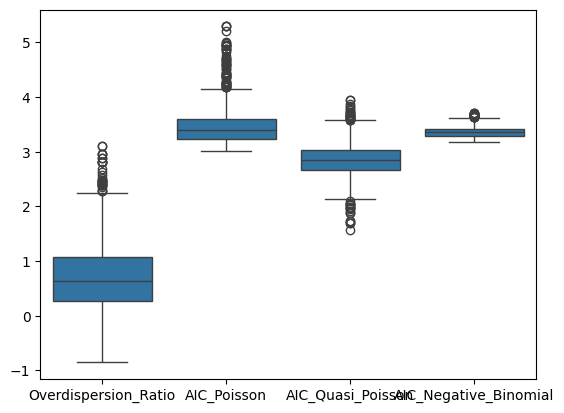

In [37]:
# Generate and save boxplots for specified metrics in one line
import numpy as np

sns.boxplot(data=np.log10(results_df[['Overdispersion_Ratio']]))
sns.boxplot(data=np.log10(results_df[['AIC_Poisson']]))
sns.boxplot(data=np.log10(results_df[['AIC_Quasi_Poisson']]))
sns.boxplot(data=np.log10(results_df[['AIC_Negative_Binomial']]))

#sns.boxplot(data=np.log10(results_df[['BIC_Negative_Binomial']]))




#                             , 'AIC_Poisson', 'AIC_Quasi_Poisson', 'AIC_Negative_Binomial', 'BIC_Poisson', 'BIC_Quasi_Poisson', 'BIC_Negative_Binomial']]).set_title('Model Comparison Metrics')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig('/home/darragh/New/eQTL/All/matrixes/all/boxplots.png')
# plt.show()

In [5]:
from scipy.stats import rankdata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools as pybed
import pandas as pd
pd.set_option('display.max_columns', None)

def bh_correction(p_values):
    n = len(p_values)
    ranks = rankdata(p_values)
    q_values = p_values * n / ranks
    q_values = np.minimum.accumulate(q_values[::-1])[::-1]
    return np.minimum(1, q_values)

def bonferroni_correction(p_values):
    num_tests = len(p_values)
    corrected_p_values = np.minimum(1, num_tests * p_values)

    return corrected_p_values


signif_df['p_value_LR'] = signif_df['P_value_LR_mutated'].astype(float)
signif_df['q_value_LR'] = bonferroni_correction(signif_df['p_value_LR'])
signif_df['log2FC_RNA'] = np.log2(signif_df['Fold_Change_RNA'])
signif_df['log2FC_CNA'] = np.log2(signif_df['Fold_Change_CNA'])
# # #


signif_df[['chr', 'start', 'end', 'gene', 'null1', 'null2']] = signif_df['File'].str.split("_", expand=True)

signif_df.to_csv("/home/darragh/New/Hartwig_gene_expression_all_LR.txt" ,sep = "\t" , header=True, index=False)


display(signif_df)

signif_df = signif_df.loc[signif_df['q_value_LR'] < 0.25]
signif_df = signif_df.loc[signif_df['log2FC_RNA'].abs() > 1]
signif_df.to_csv("/home/darragh/New/Hartwig_gene_expression_all_LR_signif.txt" ,sep = "\t" , header=True, index=False)


display(signif_df)

#signif_df.to_csv("/home/darragh/New/Hartwig_gene_expression_all.txt" ,sep = "\t" , header=True, index=False)


# signif_df = signif_df.loc[signif_df['q_value_mut'] < 0.1]
# signif_df = signif_df.loc[signif_df['log2FC_RNA'].abs() > 0.5]
# signif_df = signif_df.loc[signif_df['wilcox_test_p_RNA'] < 0.1]

# signif_df.loc[signif_df['log2FC_RNA'] > 0]


# onokokb = pd.read_table("/home/darragh/onkoKB_updated.uniq.txt", sep = "\t", header=None)
# onokokb.columns = ['gene']
# signif_df_cancer = signif_df[signif_df['gene'].isin(onokokb['gene'])]
# signif_df_cancer.to_csv("/home/darragh/New/Hartwig_gene_expression_cancer.txt" ,sep = "\t" , header=True, index=False)

# # display(signif_df_cancer)

# # #signif_df = signif_df.loc[(signif_df['wilcox_test_p_CNA'] < 0.1) ]

# # #signif_df.to_csv("/home/darragh/New/Hartwig_gene_expression_label.txt" ,sep = "\t" , header=True, index=False)



File P_value_LR_mutated  \
0     chr4_143325296_143327611_INPP4B__matrix.txt           6.30e-02   
1       chr19_42579220_42580688_MEGF8__matrix.txt           2.23e-02   
2       chr17_72753130_72757232_CDR2L__matrix.txt           5.50e-02   
3       chr1_94079625_94086718_CCDC18__matrix.txt           2.02e-22   
4       chr19_42579220_42580688_RPS19__matrix.txt           0.00e+00   
...                                           ...                ...   
1381    chr20_52294260_52297588_PFDN4__matrix.txt           7.50e-03   
1382   chr19_19248223_19251560_ZNF101__matrix.txt           5.78e-01   
1383   chr14_21081176_21083155_RNASE4__matrix.txt           1.12e-05   
1384     chr6_11231222_11234530_NEDD9__matrix.txt           7.88e-02   
1385  chr1_156716344_156721945_CRABP2__matrix.txt           0.00e+00   

      Fold_Change_RNA  Fold_Change_CNA  Sum_mutated  P_value_RNA  P_value_CNA  \
0            0.381288         1.655908         10.0     0.027004     0.068275   
1            1.095238         1.450812          9.0     0.750466     0.075039   
2            0.898747         1.007686          8.0     0.423919     0.397174   
3            1.393462         1.503943         10.0     0.001749     0.087250   
4            1.556090         1.369364          9.0     0.483922     0.067254   
...               ...              ...          ...          ...          ...   
1381         1.615103         1.194568          8.0     0.047566     0.154904   
1382         0.900000         1.210562          8.0     0.740535     0.893729   
1383         0.734802         1.460658          9.0     0.235300     0.111407   
1384         1.594237         1.206273          8.0     0.182207     0.056899   
1385         0.893960         1.036199         10.0     0.513556     0.103659   

        p_value_LR    q_value_LR  log2FC_RNA  log2FC_CNA    chr      start  \
0     6.300000e-02  1.000000e+00   -1.391048    0.727623   chr4  143325296   
1     2.230000e-02  1.000000e+00    0.131245    0.536860  chr19   42579220   
2     5.500000e-02  1.000000e+00   -0.154012    0.011046  chr17   72753130   
3     2.020000e-22  2.799720e-19    0.478674    0.588750   chr1   94079625   
4     0.000000e+00  0.000000e+00    0.637925    0.453506  chr19   42579220   
...            ...           ...         ...         ...    ...        ...   
1381  7.500000e-03  1.000000e+00    0.691626    0.256489  chr20   52294260   
1382  5.780000e-01  1.000000e+00   -0.152003    0.275677  chr19   19248223   
1383  1.120000e-05  1.552320e-02   -0.444573    0.546619  chr14   21081176   
1384  7.880000e-02  1.000000e+00    0.672866    0.270557   chr6   11231222   
1385  0.000000e+00  0.000000e+00   -0.161717    0.051302   chr1  156716344   

            end    gene null1       null2  
0     143327611  INPP4B        matrix.txt  
1      42580688   MEGF8        matrix.txt  
2      72757232   CDR2L        matrix.txt  
3      94086718  CCDC18        matrix.txt  
4      42580688   RPS19        matrix.txt  
...         ...     ...   ...         ...  
1381   52297588   PFDN4        matrix.txt  
1382   19251560  ZNF101        matrix.txt  
1383   21083155  RNASE4        matrix.txt  
1384   11234530   NEDD9        matrix.txt  
1385  156721945  CRABP2        matrix.txt  

[1386 rows x 17 columns]

File P_value_LR_mutated  \
16        chr8_49832302_49835385_MCM4__matrix.txt           0.00e+00   
37      chr8_49832302_49835385_UBE2V2__matrix.txt           0.00e+00   
86     chr1_204475219_204477598_SNRPE__matrix.txt           0.00e+00   
99      chr17_36904562_36909315_LASP1__matrix.txt           0.00e+00   
101     chr20_49345536_49348782_BCAS1__matrix.txt           0.00e+00   
182    chr17_36904562_36909315_FBXL20__matrix.txt           9.31e-50   
203     chr17_39809923_39812660_KRT15__matrix.txt           0.00e+00   
271        chr4_7068814_7070848_S100P__matrix.txt           2.86e-40   
294      chrX_152126400_152127932_BGN__matrix.txt           0.00e+00   
307    chr17_36904562_36909315_SRCIN1__matrix.txt          3.20e-279   
573      chr19_13123551_13125159_NFIX__matrix.txt           0.00e+00   
587     chr17_37308571_37311541_RPL23__matrix.txt           0.00e+00   
648     chr17_36904562_36909315_RPL23__matrix.txt           0.00e+00   
659    chr5_106906541_106908234_EFNA5__matrix.txt           5.40e-78   
711   chr17_36904562_36909315_PIP4K2B__matrix.txt           1.16e-74   
745   chrX_100662026_100664083_RPL36A__matrix.txt           0.00e+00   
755    chrX_80063512_80066284_SH3BGRL__matrix.txt          2.51e-289   
781     chr19_56150417_56155325_RPL28__matrix.txt           0.00e+00   
864        chr17_7788066_7792815_CD68__matrix.txt          1.31e-198   
890    chr19_15359544_15363490_NOTCH3__matrix.txt          6.88e-195   
916     chr17_36904562_36909315_CWC25__matrix.txt           1.03e-28   
936     chr17_36904562_36909315_MLLT6__matrix.txt          1.86e-114   
998     chr17_36904562_36909315_RPL19__matrix.txt           0.00e+00   
1055    chr10_80826114_80831264_RPS24__matrix.txt           0.00e+00   
1110     chr19_19248223_19251560_COMP__matrix.txt           0.00e+00   
1127  chrX_100662026_100664083_ARMCX2__matrix.txt           8.58e-31   
1128   chr5_162930005_162934024_PTTG1__matrix.txt           0.00e+00   
1141     chr8_129187820_129190171_MYC__matrix.txt          3.34e-120   
1148   chr16_47175430_47178508_ABCC11__matrix.txt           0.00e+00   
1184    chr1_155055154_155058882_MUC1__matrix.txt           0.00e+00   
1203   chr17_48594385_48597228_COL1A1__matrix.txt           0.00e+00   
1212     chr11_69502726_69503789_ANO1__matrix.txt           0.00e+00   
1255      chr7_17597325_17600915_AGR3__matrix.txt           0.00e+00   
1279    chr6_151710526_151713348_ESR1__matrix.txt           0.00e+00   

      Fold_Change_RNA  Fold_Change_CNA  Sum_mutated  P_value_RNA  P_value_CNA  \
16           2.123507         1.652770          9.0     0.011877     0.002409   
37           3.395173         1.652770          9.0     0.018391     0.002437   
86           2.190446         1.266109         11.0     0.025142     0.371800   
99           2.380193         4.835177          8.0     0.001244     0.001134   
101          0.425277         1.366559          8.0     0.018773     0.060933   
182          2.072932         4.134221          8.0     0.002844     0.001656   
203          6.848659         1.020613          8.0     0.005980     0.972983   
271          2.162073         0.998859         10.0     0.286015     0.939446   
294          0.440505         1.318512          8.0     0.021924     0.821372   
307          2.513674         4.374201          8.0     0.001126     0.001436   
573          2.006612         1.394468          9.0     0.274546     0.255509   
587          2.190112         1.274009         12.0     0.005444     0.151401   
648          6.840527         4.835177          8.0     0.000688     0.001090   
659          2.258824         0.989582          9.0     0.084181     0.706430   
711          2.995268         4.808335          8.0     0.000625     0.001195   
745          0.335056         1.794341          9.0     0.011877     0.081038   
755          0.477729         1.342359          8.0     0.065476     0.260529   
781          2.038287         1.387128          8.0     0.118814  

In [52]:
signif_df.head(60)


File P_value_LR_mutated  \
48          chr8_74242393_74243690_RPL7__matrix.txt           0.00e+00   
58          chr8_49832302_49835385_MCM4__matrix.txt           0.00e+00   
103       chr8_49832302_49835385_UBE2V2__matrix.txt           0.00e+00   
239      chr1_204475219_204477598_SNRPE__matrix.txt           0.00e+00   
240        chr12_29310361_29311703_FAR2__matrix.txt           1.89e-23   
274       chr17_36904562_36909315_LASP1__matrix.txt           0.00e+00   
286       chr20_49345536_49348782_BCAS1__matrix.txt           0.00e+00   
342        chr9_88968355_88971039_GOLM1__matrix.txt          1.48e-301   
412     chr20_35213371_35216657_EPB41L1__matrix.txt           2.87e-15   
442   chr10_115716732_115720809_PLEKHS1__matrix.txt           3.43e-41   
482      chr15_63671603_63674467_RPS27L__matrix.txt           9.13e-06   
499      chr17_36904562_36909315_FBXL20__matrix.txt           9.31e-50   
551       chr17_39809923_39812660_KRT15__matrix.txt           0.00e+00   
665        chr10_22291404_22292958_NEBL__matrix.txt           1.65e-95   
698      chr10_78391791_78392711_KCNMA1__matrix.txt           0.00e+00   
741          chr4_7068814_7070848_S100P__matrix.txt           2.86e-40   
782        chrX_152126400_152127932_BGN__matrix.txt           0.00e+00   
817      chr17_36904562_36909315_SRCIN1__matrix.txt          3.20e-279   
876    chr2_190405045_190407508_SLC40A1__matrix.txt           0.00e+00   
1009       chr12_53318618_53321545_KRT7__matrix.txt           0.00e+00   
1027      chr17_36904562_36909315_PCGF2__matrix.txt           1.11e-13   
1340     chr5_139038168_139041160_CXXC5__matrix.txt           0.00e+00   
1425      chr19_56164809_56167022_TNNT1__matrix.txt           0.00e+00   
1538       chr19_13123551_13125159_NFIX__matrix.txt           0.00e+00   
1566      chr17_37308571_37311541_RPL23__matrix.txt           0.00e+00   
1577       chr2_10090837_10094357_GRHL1__matrix.txt           8.51e-20   
1661        chr19_4722579_4724813_PLIN5__matrix.txt           6.62e-71   
1674      chr2_100630068_100630658_AFF3__matrix.txt           0.00e+00   
1678   chr1_152006821_152009895_S100A11__matrix.txt           0.00e+00   
1694      chr14_23448163_23452748_RBM23__matrix.txt           1.07e-06   
1714      chr17_36904562_36909315_RPL23__matrix.txt           0.00e+00   
1719         chr7_5457613_5461098_FSCN1__matrix.txt           2.17e-80   
1733     chr5_106906541_106908234_EFNA5__matrix.txt           5.40e-78   
1810    chr19_48823085_48825536_SULT2B1__matrix.txt           1.58e-49   
1873    chr17_36904562_36909315_PIP4K2B__matrix.txt           1.16e-74   
1913     chr8_144976593_144980565_SCRIB__matrix.txt           0.00e+00   
1960    chrX_100662026_100664083_RPL36A__matrix.txt           0.00e+00   
1978       chr8_128805170_128808734_MYC__matrix.txt           0.00e+00   
1985     chrX_80063512_80066284_SH3BGRL__matrix.txt          2.51e-289   
2001        chr7_26226053_26228519_CBX3__matrix.txt           1.79e-05   
2044      chr19_56150417_56155325_RPL28__matrix.txt           0.00e+00   
2066      chr16_65154774_65157921_CDH11__matrix.txt           0.00e+00   
2160    chr17_37729466_37730614_PPP1R1B__matrix.txt           0.00e+00   
2210      chr17_58307727_58309435_USP32__matrix.txt           0.00e+00   
2217    chr10_122836145_122838703_FGFR2__matrix.txt           2.34e-44   
2263         chr17_7788066_7792815_CD68__matrix.txt          1.31e-198   
2333     chr19_15359544_15363490_NOTCH3__matrix.txt          6.88e-195   
2393      chr17_36904562_36909315_CWC25__matrix.txt           1.03e-28   
2437      chr17_36904562_36909315_MLLT6__matrix.txt          1.86e-114   
2472      chr6_152010317_152012579_ESR1__matrix.txt           0.00e+00   
2497   chr1_153894192_153896688_GATAD2B__matrix.txt           0.00e+00   
2506      chr11_66789377_66792286_SYT12__matrix.txt          9.55e-263   
2571      chr17_36904562_36909315_RPL19__matrix.txt           0.00e+00   
2606      chr10_80826114_80831264_ZMIZ1__matrix.txt

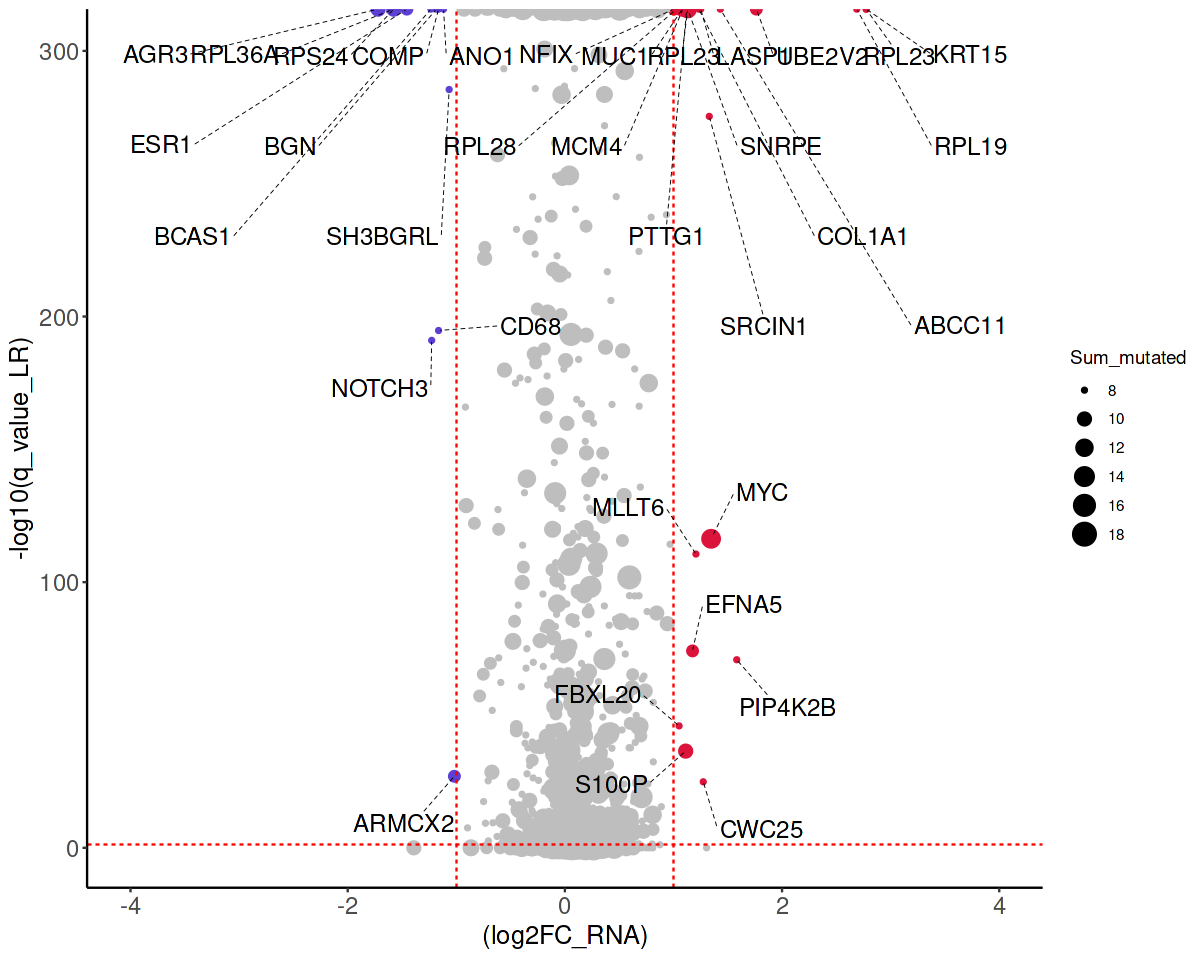

In [1]:
library(ggplot2)
library(ggpubr)
library(ggrepel)
options(repr.plot.width=10, repr.plot.height=8)


gene_expression_ps = read.table("/home/darragh/New/Hartwig_gene_expression_all_LR.txt", sep = "\t", header=T)
#gene_expression_ps = gene_expression_ps[gene_expression_ps$N < 50, ]

gene_expression_ps_label = read.table("/home/darragh/New/Hartwig_gene_expression_all_LR_signif.txt", sep = "\t", header=T)


ggplot(gene_expression_ps, aes(y = -log10(q_value_LR), x = (log2FC_RNA), size = Sum_mutated )) +
geom_point( aes(color = ifelse(q_value_LR < 0.25 &  log2FC_RNA > 1, "#DC143C",ifelse(q_value_LR < 0.25 & log2FC_RNA < -1, "#5D3FD3", "grey")))) +
 geom_hline(yintercept = -log10(0.05), linetype="dashed", colour="red") +
 geom_vline(xintercept = 1, linetype="dashed", colour="red") +
 geom_vline(xintercept = -1, linetype="dashed", colour="red") +
 theme_classic() +
 scale_color_identity()  +
  coord_cartesian(xlim = c(-4,4) ) +
     geom_text_repel(
      data = gene_expression_ps_label,
      aes(x = log2FC_RNA, y = -log10(q_value_LR), label = gene),
      color = "black",
      box.padding = 1.5,
      max.overlaps=100,
      size=5,
      segment.color = "black",
      segment.size = 0.2,
      segment.linetype = "dashed"
    )   +
    theme(axis.text.x = element_text(size = 14), axis.text.y = element_text(size = 14), axis.title.y = element_text(size = 15),  axis.title.x = element_text(size = 15) ) 
ggsave("/home/darragh/New/gene_expression_test_volcano.pdf", width=10, height=8)

# Cancer genes, bi-functional, PRC2 looping regulatory elements which are significant andmore than log2(0.5)

In [32]:
import pandas as pd
import pybedtools as pybed

MCF7_enh_to_sil = pd.read_table("/home/darragh/New/Differentially_active/switching/MCF7/output_enh_to_sil.txt", sep = "\t")
MCF7_enh_to_sil.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC',     'H3K4me1_FC',      'SUZ12_FC']
MCF7_enh_to_sil = MCF7_enh_to_sil[['chr',	'start',	'end']]
MCF7_enh_to_sil['annotation'] = "MCF7_enh_to_sil"

MDAMB361_enh_to_sil = pd.read_table("/home/darragh/New/Differentially_active/switching/MDAMB361/output_enh_to_sil.txt", sep = "\t")
MDAMB361_enh_to_sil.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
MDAMB361_enh_to_sil = MDAMB361_enh_to_sil[['chr',	'start',	'end']]
MDAMB361_enh_to_sil['annotation'] = "MDAMB361_enh_to_sil"

MDAMB231_enh_to_sil = pd.read_table("/home/darragh/New/Differentially_active/switching/MDAMB231/output_enh_to_sil.txt", sep = "\t")
MDAMB231_enh_to_sil.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
MDAMB231_enh_to_sil = MDAMB231_enh_to_sil[['chr',	'start',	'end']]
MDAMB231_enh_to_sil['annotation'] = "MDAMB231_enh_to_sil"

MDAMB436_enh_to_sil = pd.read_table("/home/darragh/New/Differentially_active/switching/MDAMB436/output_enh_to_sil.txt", sep = "\t")
MDAMB436_enh_to_sil.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
MDAMB436_enh_to_sil = MDAMB436_enh_to_sil[['chr',	'start',	'end']]
MDAMB436_enh_to_sil['annotation'] = "MDAMB436_enh_to_sil"

MDAMB468_enh_to_sil = pd.read_table("/home/darragh/New/Differentially_active/switching/MDAMB468/output_enh_to_sil.txt", sep = "\t")
MDAMB468_enh_to_sil.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
MDAMB468_enh_to_sil = MDAMB468_enh_to_sil[['chr',	'start',	'end']]
MDAMB468_enh_to_sil['annotation'] = "MDAMB468_enh_to_sil"

SKBR3_enh_to_sil = pd.read_table("/home/darragh/New/Differentially_active/switching/SKBR3/output_enh_to_sil.txt", sep = "\t")
SKBR3_enh_to_sil.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC', 'nn']
SKBR3_enh_to_sil = SKBR3_enh_to_sil[['chr',	'start',	'end']]
SKBR3_enh_to_sil['annotation'] = "SKBR3_enh_to_sil"

HCC1954_enh_to_sil = pd.read_table("/home/darragh/New/Differentially_active/switching/HCC1954/output_enh_to_sil.txt", sep = "\t")
HCC1954_enh_to_sil.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
HCC1954_enh_to_sil = HCC1954_enh_to_sil[['chr',	'start',	'end']]
HCC1954_enh_to_sil['annotation'] = "HCC1954_enh_to_sil"


####


MCF7_sil_to_enh = pd.read_table("/home/darragh/New/Differentially_active/switching/MCF7/output_sil_to_enh.txt", sep = "\t")
MCF7_sil_to_enh = MCF7_sil_to_enh[['chr',	'start',	'end']]
MCF7_sil_to_enh['annotation'] = "MCF7_sil_to_enh"

MDAMB361_sil_to_enh = pd.read_table("/home/darragh/New/Differentially_active/switching/MDAMB361/output_sil_to_enh.txt", sep = "\t")
MDAMB361_sil_to_enh.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
MDAMB361_sil_to_enh = MDAMB361_sil_to_enh[['chr',	'start',	'end']]
MDAMB361_sil_to_enh['annotation'] = "MDAMB361_sil_to_enh"

MDAMB231_sil_to_enh = pd.read_table("/home/darragh/New/Differentially_active/switching/MDAMB231/output_sil_to_enh.txt", sep = "\t")
MDAMB231_sil_to_enh.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
MDAMB231_sil_to_enh = MDAMB231_sil_to_enh[['chr',	'start',	'end']]
MDAMB231_sil_to_enh['annotation'] = "MDAMB231_sil_to_enh"

MDAMB436_sil_to_enh = pd.read_table("/home/darragh/New/Differentially_active/switching/MDAMB436/output_sil_to_enh.txt", sep = "\t")
MDAMB436_sil_to_enh.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
MDAMB436_sil_to_enh = MDAMB436_sil_to_enh[['chr',	'start',	'end']]
MDAMB436_sil_to_enh['annotation'] = "MDAMB436_sil_to_enh"

MDAMB468_sil_to_enh = pd.read_table("/home/darragh/New/Differentially_active/switching/MDAMB468/output_sil_to_enh.txt", sep = "\t")
MDAMB468_sil_to_enh.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
MDAMB468_sil_to_enh = MDAMB468_sil_to_enh[['chr',	'start',	'end']]
MDAMB468_sil_to_enh['annotation'] = "MDAMB468_sil_to_enh"

SKBR3_sil_to_enh = pd.read_table("/home/darragh/New/Differentially_active/switching/SKBR3/output_sil_to_enh.txt", sep = "\t")
SKBR3_sil_to_enh.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC','NN']
SKBR3_sil_to_enh = SKBR3_sil_to_enh[['chr',	'start',	'end']]
SKBR3_sil_to_enh['annotation'] = "SKBR3_sil_to_enh"

HCC1954_sil_to_enh = pd.read_table("/home/darragh/New/Differentially_active/switching/HCC1954/output_sil_to_enh.txt", sep = "\t")
HCC1954_sil_to_enh.columns = ['chr',     'start',   'end',     'annotation',      'ATAC_FC', 'H3K27ac_FC',      'H3K27me3_FC']
HCC1954_sil_to_enh = HCC1954_sil_to_enh[['chr',	'start',	'end']]
HCC1954_sil_to_enh['annotation'] = "HCC1954_sil_to_enh"

All_bifunctional = pd.concat([MCF7_enh_to_sil, MDAMB361_enh_to_sil, MDAMB231_enh_to_sil, MDAMB436_enh_to_sil, MDAMB468_enh_to_sil, SKBR3_enh_to_sil, HCC1954_enh_to_sil,
MCF7_sil_to_enh, MDAMB361_sil_to_enh, MDAMB231_sil_to_enh, MDAMB436_sil_to_enh, MDAMB468_sil_to_enh, SKBR3_sil_to_enh, HCC1954_sil_to_enh])

All_bifunctional['start'] = All_bifunctional['start']-250
All_bifunctional['end'] = All_bifunctional['end']+250

All_bifunctional = pybed.BedTool.from_dataframe(All_bifunctional)

display(All_bifunctional)

<BedTool(/tmp/pybedtools.0res44ou.tmp)>

In [1]:
import pandas as pd
import pybedtools as pybed
import gseapy as gp

expression_test = pd.read_table("/home/darragh/New/Hartwig_gene_expression_all_LR_signif.txt", sep = "\t")
expression_test .columns= ['File',	'P_value_LR_mutated',	'Fold_Change_RNA',	'Fold_Change_CNA',	'Sum_mutated',	'P_value_RNA',	'P_value_CNA',	'p_value_LR',	'q_value_LR',	'log2FC_RNA',	'log2FC_CNA',	'chr',	'start',	'end',	'gene',	'null1',	'null2']

expression_test_genes= expression_test[['gene']]
expression_test_genes = expression_test_genes.squeeze().str.strip().to_list()

all_RNA = pd.read_table("/home/darragh/New/CCLE_data/OmicsExpressionProteinCodingGenesTPMLogp1.csv", sep = ",", header=0)
all_RNA = all_RNA.rename(columns={'Unnamed: 0': 'id'})
MCF7_RNA = all_RNA.loc[(all_RNA['id'] == 'ACH-000019') ]
MCF7_RNA = MCF7_RNA.T
MCF7_RNA.columns = MCF7_RNA.iloc[0]
MCF7_RNA = MCF7_RNA.iloc[1:]
MCF7_RNA = MCF7_RNA.reset_index()
MCF7_RNA.columns = ['gene', 'expression']
MCF7_RNA['gene'] = MCF7_RNA['gene'].str.split().str[0]
MCF7_RNA = MCF7_RNA.loc[MCF7_RNA['expression'] > 0]
MCF7_RNA = MCF7_RNA[['gene']]
glist_bg = MCF7_RNA.squeeze().str.strip().to_list()



# backgound only reconigized a gene list input.
enr_bg = gp.enrichr(gene_list=expression_test_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 background=glist_bg,
                 #organism='human', # organism argment is ignored because user input a background

                 outdir=None, # don't write to disk
                 )

enr_bg.results.to_csv("/home/darragh/New/GSEA/MCF7_bg_enr_bg_sil_to_enh_2.txt", sep="\t", header=True, index=False) 
enr_bg = pd.read_table("/home/darragh/New/GSEA/MCF7_bg_enr_bg_sil_to_enh_2.txt", sep="\t")
enr_bg = enr_bg.loc[enr_bg['Adjusted P-value'] < 0.05]

display(enr_bg)
# display(expression_test)


Gene_set                               Term Overlap   P-value  \
0  MSigDB_Hallmark_2020                     Myc Targets V2    2/58  0.004119   
1  MSigDB_Hallmark_2020                    G2-M Checkpoint   3/200  0.004309   
2  MSigDB_Hallmark_2020            Estrogen Response Early   3/200  0.004309   
3  MSigDB_Hallmark_2020                        E2F Targets   3/200  0.004309   
4  MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition   3/200  0.004309   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0            0.0181            0                     0   22.938940   
1            0.0181            0                     0   10.035533   
2            0.0181            0                     0   10.035533   
3            0.0181            0                     0   10.035533   
4            0.0181            0                     0   10.035533   

   Combined Score            Genes  
0      125.983057         MYC;MCM4  
1       54.662987  PTTG1;MYC;EFNA5  
2       54.662987   MUC1;KRT15;MYC  
3       54.662987   PTTG1;MYC;MCM4  
4       54.662987  COL1A1;COMP;BGN

Saving 6.67 x 6.67 in image


Gene_set Term                              observed overlap P.value    
1 MSigDB   Myc Targets V2                    2        58      0.004119166
2 MSigDB   G2-M Checkpoint                   3        200     0.004309454
3 MSigDB   Estrogen Response Early           3        200     0.004309454
4 MSigDB   E2F Targets                       3        200     0.004309454
5 MSigDB   Epithelial Mesenchymal Transition 3        200     0.004309454
  Adjusted.P.value Old.P.value Old.Adjusted.P.value Odds.Ratio Combined.Score
1 0.01809971       0           0                    22.93894   125.98306     
2 0.01809971       0           0                    10.03553    54.66299     
3 0.01809971       0           0                    10.03553    54.66299     
4 0.01809971       0           0                    10.03553    54.66299     
5 0.01809971       0           0                    10.03553    54.66299     
  Genes          
1 MYC;MCM4       
2 PTTG1;MYC;EFNA5
3 MUC1;KRT15;MYC 
4 PTTG1;MYC;MCM4 
5 COL1A1;COMP;BGN

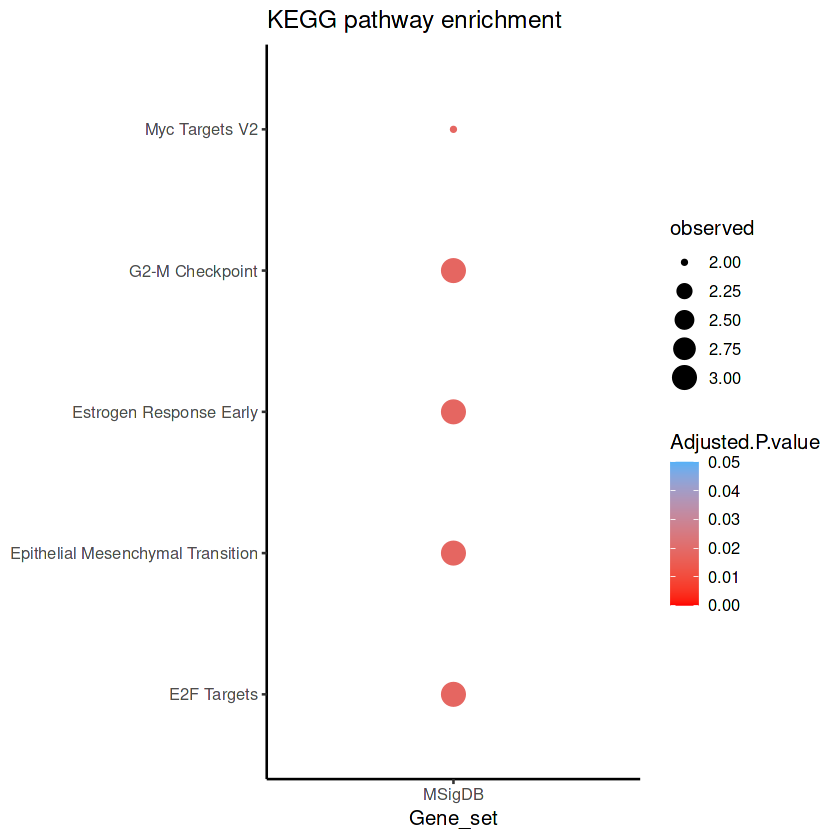

In [1]:
library(ggplot2)
library(tidyr)

dot_df = read.table("/home/darragh/New/GSEA/MCF7_bg_enr_bg_sil_to_enh_2.txt", sep="\t", header=T)
dot_df$Gene_set = "MSigDB"

dot_df = dot_df[dot_df$Adjusted.P.value < 0.05,]
dot_df <- separate(dot_df, Overlap, into = c("observed", "overlap"), sep = "/")

dot_df$observed = as.integer(dot_df$observed)

ggplot(dot_df, aes(x = Gene_set, y = Term	)) + 
                  geom_point(aes(size = observed, color = Adjusted.P.value)) +
                  theme_classic(base_size = 12) +
           scale_colour_gradient(limits=c(0, 0.05), low="red") +
           ylab(NULL) +
           ggtitle("KEGG pathway enrichment") 

ggsave("/home/darragh/New/expression_test_gene_path_enrichments.pdf")

head(dot_df)

In [1]:
def FizzBuzz():
    for i in range(1,100):
        print("hello")


/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


<BedTool(/tmp/pybedtools.mz6fdexh.tmp)>

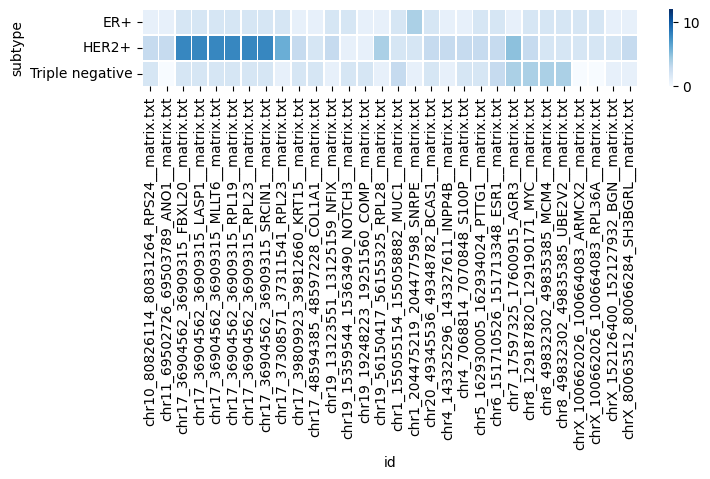

In [1]:
import pandas as pd
import pybedtools as pybed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

expression_test = pd.read_table("/home/darragh/New/Hartwig_gene_expression_all_LR_signif.txt", sep = "\t")
expression_test .columns= ['File',	'P_value_LR_mutated',	'Fold_Change_RNA',	'Fold_Change_CNA',	'Sum_mutated',	'P_value_RNA',	'P_value_CNA',	'p_value_LR',	'q_value_LR',	'log2FC_RNA',	'log2FC_CNA',	'chr',	'start',	'end',	'gene',	'null1',	'null2']


expression_test = pybed.BedTool.from_dataframe(expression_test[['chr', 'start', 'end', 'File']])
######################################################

Hartwig_mutation = pybed.BedTool("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation_expression.txt")
Hartwig_mutation = Hartwig_mutation.sort()

Hartwig_positively_selected_mutated = expression_test.intersect(Hartwig_mutation, wa=True, wb=True)
Hartwig_positively_selected_mutated = pd.read_table(Hartwig_positively_selected_mutated.fn, header=None)
Hartwig_positively_selected_mutated = Hartwig_positively_selected_mutated.iloc[:,[3,9]]
Hartwig_positively_selected_mutated.columns = ['id', 'Hartwig_patient']

meta_hartwig = pd.read_table("/home/darragh/Hartwig/metadata.tsv", sep="\t")
meta_hartwig = meta_hartwig.loc[meta_hartwig['primaryTumorLocation'] == "Breast"]
meta_hartwig = meta_hartwig[['sampleId',  'primaryTumorSubType' ]]
meta_hartwig.columns = ['Hartwig_patient', 'subtype_Hartwig' ]
Hartwig_positively_selected_mutated = Hartwig_positively_selected_mutated.merge(meta_hartwig, on="Hartwig_patient", how="left")
Hartwig_positively_selected_mutated = Hartwig_positively_selected_mutated.drop_duplicates()

Hartwig_positively_selected_mutated['subtype_Hartwig'] = Hartwig_positively_selected_mutated['subtype_Hartwig'].replace('ER-positive/HER2-positive', 'HER2+')
Hartwig_positively_selected_mutated['subtype_Hartwig'] = Hartwig_positively_selected_mutated['subtype_Hartwig'].replace('ER-positive/HER2-negative', 'ER+')
Hartwig_positively_selected_mutated['subtype_Hartwig'] = Hartwig_positively_selected_mutated['subtype_Hartwig'].replace('ER-positive/PR-positive', 'ER+')
Hartwig_positively_selected_mutated['subtype_Hartwig'] = Hartwig_positively_selected_mutated['subtype_Hartwig'].replace('ER-negative/HER2-positive', 'HER2+')
Hartwig_positively_selected_mutated['subtype_Hartwig'] = Hartwig_positively_selected_mutated['subtype_Hartwig'].replace('Triple Negative', 'Triple negative')
Hartwig_positively_selected_mutated['subtype_Hartwig'].fillna('Unknown', inplace=True)

Hartwig_positively_selected_mutated_Hartwig = Hartwig_positively_selected_mutated[["id", "subtype_Hartwig", "Hartwig_patient"]]
Hartwig_positively_selected_mutated_Hartwig = Hartwig_positively_selected_mutated_Hartwig.groupby(["id",'subtype_Hartwig'])['Hartwig_patient'].nunique().reset_index()
Hartwig_positively_selected_mutated_Hartwig = Hartwig_positively_selected_mutated_Hartwig.drop_duplicates()
Hartwig_positively_selected_mutated_Hartwig.columns = ["id",'subtype', 'Hartwig_patient' ]
Hartwig_positively_selected_mutated = Hartwig_positively_selected_mutated_Hartwig

Hartwig_positively_selected_mutated['Hartwig_patient'] = np.where(Hartwig_positively_selected_mutated['subtype'] == 'Triple_negative', ((Hartwig_positively_selected_mutated['Hartwig_patient'] / 111) * 100), Hartwig_positively_selected_mutated['Hartwig_patient'])
Hartwig_positively_selected_mutated['Hartwig_patient'] = np.where(Hartwig_positively_selected_mutated['subtype'] == 'HER2+', (Hartwig_positively_selected_mutated['Hartwig_patient'] / 116) * 100, Hartwig_positively_selected_mutated['Hartwig_patient'])
Hartwig_positively_selected_mutated['Hartwig_patient'] = np.where(Hartwig_positively_selected_mutated['subtype'] == 'ER+', (Hartwig_positively_selected_mutated['Hartwig_patient'] / 513) * 100, Hartwig_positively_selected_mutated['Hartwig_patient'])

Hartwig_positively_selected_mutated['Hartwig_patient'] = Hartwig_positively_selected_mutated['Hartwig_patient'].round(0).astype(int)
Hartwig_positively_selected_mutated = Hartwig_positively_selected_mutated[Hartwig_positively_selected_mutated['subtype'] != 'Unknown']

Hartwig_positively_selected_mutated_plot = Hartwig_positively_selected_mutated[['id', 'subtype', 'Hartwig_patient']]
Hartwig_positively_selected_mutated_plot['Hartwig_patient'] = Hartwig_positively_selected_mutated_plot['Hartwig_patient'].fillna(0)

heatmap_data = Hartwig_positively_selected_mutated_plot.pivot(index='subtype', columns='id', values='Hartwig_patient')
heatmap_data = heatmap_data.fillna(0)
heatmap_data = heatmap_data.astype(int)


plt.figure(figsize=(8, 1))
sns.heatmap(heatmap_data, cmap='Blues',  linewidths=.5, vmax=12,  annot_kws={"fontsize": 5})
plt.savefig('/home/darragh/New/heatmap_plot_3.pdf', format='pdf')

display(expression_test)


<BedTool(/tmp/pybedtools.3kztura5.tmp)>

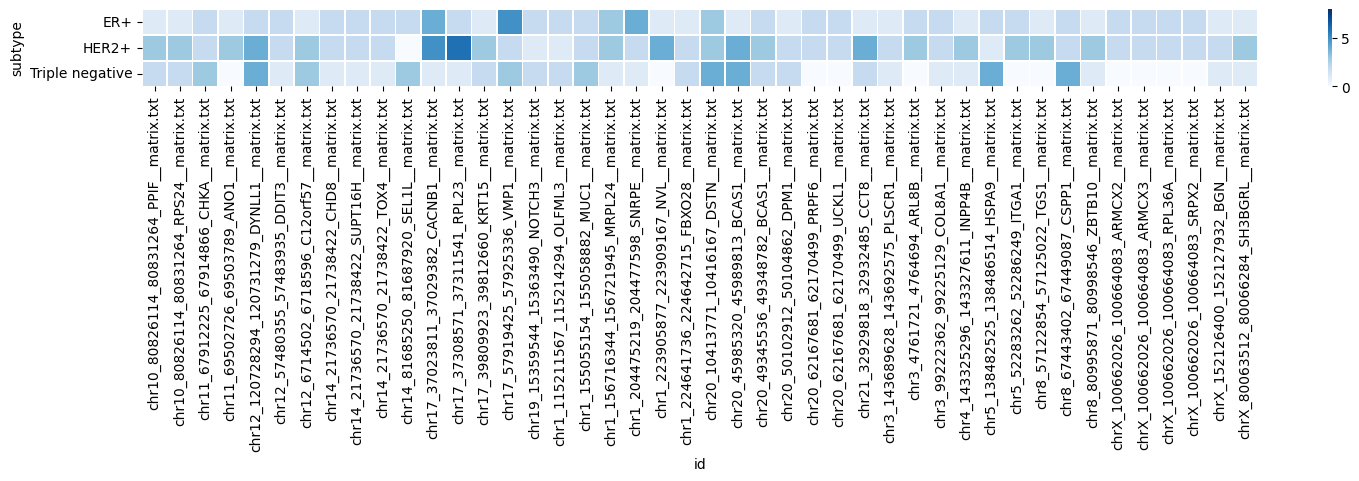

In [2]:
plt.figure(figsize=(18, 1))
sns.heatmap(heatmap_data, cmap='Blues',  linewidths=.5, vmax=8,  annot_kws={"fontsize": 5})
plt.savefig('/home/darragh/New/heatmap_plot_3.pdf', format='pdf')

display(expression_test)

# Lolipop plots

In [18]:
import pandas as pd
import pybedtools as pybed
import os

mutations = pd.read_table("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation_expression.txt", sep = "\t")
Hartwig = pybed.BedTool.from_dataframe(mutations)
Hartwig = Hartwig.sort()

file = pd.read_table("/home/darragh/Hartwig_gene_expression_4.txt", sep = "\t", header=None)
file.columns = ['chr', 'start', 'end', 'id']

Hartwig_DP = pybed.BedTool.from_dataframe(file)

Hartwig_DP_mutated = Hartwig_DP.intersect(Hartwig, wa=True, wb=True)
Hartwig_DP_mutated = pd.read_table(Hartwig_DP_mutated.fn, header=None)

#Select columns and rename them
Hartwig_DP_mutated = Hartwig_DP_mutated.iloc[:, [3,1,2,9,7,8,5] ]
Hartwig_DP_mutated.columns = ['id','start', 'end', 'patient', 'ref', 'alt', 'mut_start']
Hartwig_DP_mutated['nucleotide_change'] = Hartwig_DP_mutated['ref'] + '>' + Hartwig_DP_mutated['alt']
Hartwig_DP_mutated['len'] = Hartwig_DP_mutated['end'] - Hartwig_DP_mutated['start']
Hartwig_DP_mutated['position'] = Hartwig_DP_mutated['mut_start'] - Hartwig_DP_mutated['start']
# Hartwig_DP_mutated['patient'] = Hartwig_DP_mutated['patient'].str.split(".", expand=True)[0]
Hartwig_DP_mutated = Hartwig_DP_mutated[['id', 'len', 'patient', 'position', 'nucleotide_change']]
display(Hartwig_DP_mutated)

#Group the data by the 'id' column

#Write each each gene to s seperate df

for group_name, group_data in Hartwig_DP_mutated.groupby('id'):

    group_data.to_csv("/home/darragh/New/lolipops/DP/Fran_Adrian/_3/" + group_data['id'].iat[0] + '_'  + "_matrix.txt" ,sep = "\t" , header=True, index=False)




/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


id   len        patient  position nucleotide_change
0   chr1_155055154_155058882  3728  CPCT02010746T        13               G>A
1   chr1_155055154_155058882  3728  DRUP01330020T       325              T>TG
2   chr1_155055154_155058882  3728  CPCT02270028T       677               T>A
3   chr1_155055154_155058882  3728  CPCT02010746T      1371               G>T
4   chr1_155055154_155058882  3728  CPCT02020490T      1391               C>G
..                       ...   ...            ...       ...               ...
66   chr12_57480355_57483935  3580  CPCT02380052T      1994               C>T
67   chr12_57480355_57483935  3580  CPCT02080060T      2034               C>G
68   chr12_57480355_57483935  3580  CPCT02130163T      2077               C>T
69   chr12_57480355_57483935  3580  CPCT02390021T      2119             GC>AA
70   chr12_57480355_57483935  3580  WIDE01010322T      2960               A>G

[71 rows x 5 columns]

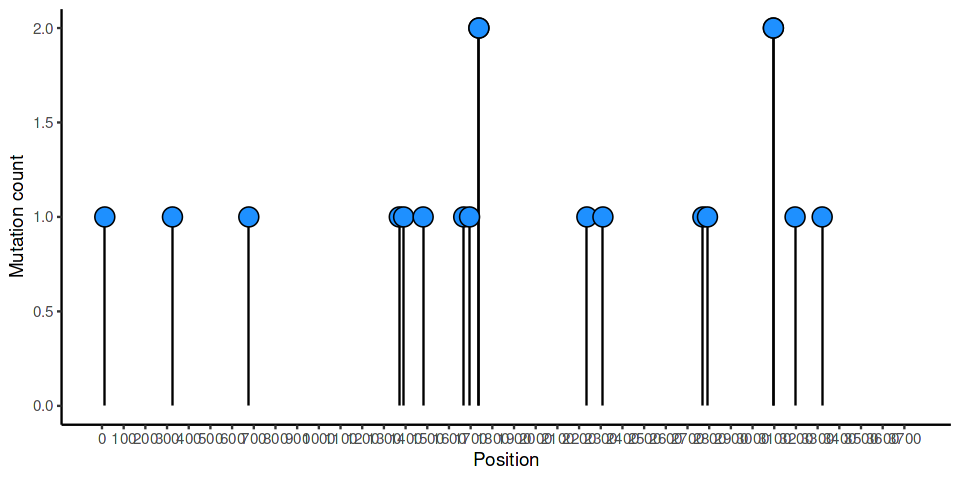

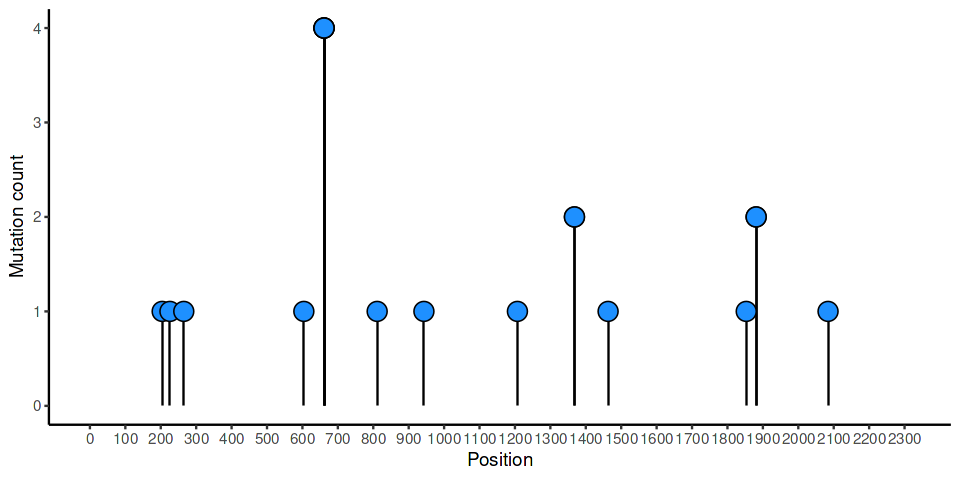

In [2]:
library(ggplot2)
library(dplyr)
options(repr.plot.width=8, repr.plot.height=4)

MUC1 = read.table("/home/darragh/New/lolipops/DP/Fran_Adrian/_3/chr1_155055154_155058882__matrix.txt", sep = "\t", header=TRUE)

  # Compute mutation counts
mutation_counts <- MUC1 %>%
count(position) %>%
mutate(freq = n)

# Define the enhancer coordinates
enhancer_start <- 0
enhancer_end <- MUC1$len[1]

# Merge mutation counts with original mutation data frame
MUC1 = merge(MUC1, mutation_counts)

# Create a new column that combines patient mutated and nucleotide change information
MUC1$mutation_label <- MUC1$nucleotide_change

# Calculate the range of mutation frequencies
min_freq <- min(mutation_counts$freq)
max_freq <- max(mutation_counts$freq)

ggplot(MUC1, aes(x = position, y = freq)) +
   geom_segment(aes(x = position, xend = position, y = 0, yend = freq), color = "black") +
   geom_point(aes(x = position, y = freq), shape = 21, fill = "dodgerblue", color = "black", size = 5) +
   
                        scale_x_continuous(limits = c(enhancer_start, enhancer_end), 
                        breaks = seq(enhancer_start, enhancer_end, 100)) +
                        labs(x = "Position", y = "Mutation count") +
                        theme_classic()
ggsave("/home/darragh/New/MUC1_lolipop.pdf", width=8, height=4)


INPP4B = read.table("/home/darragh/New/lolipops/DP/Fran_Adrian/_3/chr4_143325296_143327611__matrix.txt", sep = "\t", header=TRUE)

  # Compute mutation counts
mutation_counts <- INPP4B %>%
count(position) %>%
mutate(freq = n)

# Define the enhancer coordinates
enhancer_start <- 0
enhancer_end <- INPP4B$len[1]

# Merge mutation counts with original mutation data frame
INPP4B = merge(INPP4B, mutation_counts)

# Create a new column that combines patient mutated and nucleotide change information
INPP4B$mutation_label <- INPP4B$nucleotide_change

# Calculate the range of mutation frequencies
min_freq <- min(mutation_counts$freq)
max_freq <- max(mutation_counts$freq)

ggplot(INPP4B, aes(x = position, y = freq)) +
   geom_segment(aes(x = position, xend = position, y = 0, yend = freq), color = "black") +
   geom_point(aes(x = position, y = freq), shape = 21, fill = "dodgerblue", color = "black", size = 5) +
   
                        scale_x_continuous(limits = c(enhancer_start, enhancer_end), 
                        breaks = seq(enhancer_start, enhancer_end, 100)) +
                        labs(x = "Position", y = "Mutation count") +
                        theme_classic()
ggsave("/home/darragh/New/INPP4B_lolipop.pdf", width=8, height=4)


# What type of mutation is occuring at these onkoKB regions

In [3]:
import pandas as pd
import pybedtools as pybed

muts = pd.read_table("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation_expression.txt", sep = "\t", header=None)
muts.columns = ['chr', 'start', 'end', 'ref', 'alt', 'patient']
muts['id'] = muts['chr'].astype(str) + ":" +  muts['start'].astype(str) + ":" + muts['ref'].astype(str) + ":" + muts['alt'].astype(str)
muts['empty'] = "0"
muts['strand'] = "+"
muts['start'] = muts['start']-1
muts = pybed.BedTool.from_dataframe(muts[['chr', 'start', 'end', "id", "empty", "strand"]])

Hartwig_ps = pd.read_table("/home/darragh/New/Hartwig_gene_expression_all_LR_signif.txt", sep = "\t", header=0)
Hartwig_ps[['chr', 'start', 'end', 'gene', 'null1', 'null2']] = Hartwig_ps['File'].str.split("_", expand=True)
Hartwig_ps = Hartwig_ps.loc[(Hartwig_ps['gene'] == "MYC") | (Hartwig_ps['gene'] == "ESR1") | (Hartwig_ps['gene'] == "NOTCH3") | (Hartwig_ps['gene'] == "BGN")]


Hartwig_ps = pybed.BedTool.from_dataframe(Hartwig_ps[['chr', 'start', 'end', 'File']])

muts = muts.intersect(Hartwig_ps, wa=True)
muts = pd.read_table(muts.fn, header=None)

muts.to_csv("/home/darragh/New/motifbreakR/Hartwig_mutation.bed", sep = "\t", header=None, index=False)

display(muts)

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


0          1          2                   3  4  5
0    chr8  129188396  129188397  chr8:129188397:T:C  0  +
1    chr6  151712033  151712034  chr6:151712034:G:A  0  +
2    chr8  129189067  129189068  chr8:129189068:G:A  0  +
3    chr6  151713346  151713347  chr6:151713347:G:A  0  +
4    chr8  129188181  129188182  chr8:129188182:G:C  0  +
..    ...        ...        ...                 ... .. ..
72  chr19   15362181   15362182  chr19:15362182:G:T  0  +
73   chr6  151711238  151711239  chr6:151711239:C:G  0  +
74   chr6  151710533  151710534  chr6:151710534:G:A  0  +
75   chr8  129189575  129189576  chr8:129189576:G:A  0  +
76   chr6  151711125  151711126  chr6:151711126:G:C  0  +

[77 rows x 6 columns]

In [1]:
#Hartwig

library("motifStack")
library(motifbreakR)
library(BSgenome)
library(BSgenome.Hsapiens.UCSC.hg19)
library(MotifDb)
snps.bed.file = "/home/darragh/New/motifbreakR/Hartwig_mutation.bed"

read.table(snps.bed.file, header=FALSE)

snps.mb.frombed <- snps.from.file(file = snps.bed.file,
                                  search.genome = BSgenome.Hsapiens.UCSC.hg19,
                                  format = "bed")

head(snps.mb.frombed)

Loading required package: grid

Warning message:
“multiple methods tables found for ‘aperm’”
Warning message:
“replacing previous import ‘BiocGenerics::aperm’ by ‘DelayedArray::aperm’ when loading ‘SummarizedExperiment’”


Warning message:
“no function found corresponding to methods exports from ‘BSgenome’ for: ‘releaseName’”
Loading required package: MotifDb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:motifStack’:

    as.data.frame


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    

V1    V2        V3        V4                            V5 V6
1  chr8  129188396 129188397 chr8:129188397:T:C            0  + 
2  chr6  151712033 151712034 chr6:151712034:G:A            0  + 
3  chr8  129189067 129189068 chr8:129189068:G:A            0  + 
4  chr6  151713346 151713347 chr6:151713347:G:A            0  + 
5  chr8  129188181 129188182 chr8:129188182:G:C            0  + 
6  chrX  152126906 152126907 chrX:152126907:G:A            0  + 
7  chr19  15362095  15362096 chr19:15362096:C:T            0  + 
8  chr19  15360438  15360439 chr19:15360439:C:T            0  + 
9  chr8  129188507 129188508 chr8:129188508:C:G            0  + 
10 chr8  129189158 129189159 chr8:129189159:C:T            0  + 
11 chr8  129189575 129189576 chr8:129189576:G:A            0  + 
12 chrX  152127002 152127004 chrX:152127003:TA:T           0  + 
13 chr8  129189620 129189621 chr8:129189621:T:A            0  + 
14 chr19  15362095  15362096 chr19:15362096:C:T            0  + 
15 chr6  151712242 151712254 chr6:151712243:CGCCGCCGCCTG:C 0  + 
16 chr19  15362655  15362656 chr19:15362656:G:C            0  + 
17 chr8  129189828 129189829 chr8:129189829:G:A            0  + 
18 chr19  15361003  15361004 chr19:15361004:G:A            0  + 
19 chr6  151711162 151711163 chr6:151711163:G:A            0  + 
20 chr8  129189288 129189289 chr8:129189289:C:T            0  + 
21 chr8  129188055 129188056 chr8:129188056:A:G            0  + 
22 chr6  151711159 151711160 chr6:151711160:C:A            0  + 
23 chr8  129189568 129189569 chr8:129189569:C:T            0  + 
24 chr6  151712685 151712686 chr6:151712686:C:T            0  + 
25 chr19  15361848  15361849 chr19:15361849:C:T            0  + 
26 chr19  15362204  15362205 chr19:15362205:C:T            0  + 
27 chr19  15362095  15362096 chr19:15362096:C:T            0  + 
28 chrX  152127002 152127004 chrX:152127003:TA:T           0  + 
29 chr8  129188209 129188218 chr8:129188210:TTCTTACTA:T    0  + 
30 chr8  129190032 129190033 chr8:129190033:C:G            0  + 
⋮  ⋮     ⋮         ⋮         ⋮                             ⋮  ⋮ 
48 chr8  129187935 129187936 chr8:129187936:G:C            0  + 
49 chrX  152127613 152127614 chrX:152127614:A:G            0  + 
50 chr6  151712991 151712992 chr6:151712992:G:T            0  + 
51 chrX  152127611 152127612 chrX:152127612:A:G            0  + 
52 chr6  151710763 151710764 chr6:151710764:A:G            0  + 
53 chr8  129189447 129189448 chr8:129189448:A:C            0  + 
54 chr6  151713198 151713199 chr6:151713199:A:G            0  + 
55 chr6  151712790 151712791 chr6:151712791:C:T            0  + 
56 chr19  15362592  15362593 chr19:15362593:C:A            0  + 
57 chr8  129187828 129187829 chr8:129187829:T:G            0  + 
58 chr6  151710763 151710764 chr6:151710764:A:G            0  + 
59 chrX  152127002 152127004 chrX:152127003:TA:T           0  + 
60 chr8  129189137 129189141 chr8:129189138:GTTT:G         0  + 
61 chr8  129187935 129187936 chr8:129187936:G:C            0  + 
62 chr8  129188958 129188959 chr8:129188959:G:A            0  + 
63 chr19  15362593  15362594 chr19:15362594:G:A            0  + 
64 chr8  129188181 129188182 chr8:129188182:G:C            0  + 
65 chr6  151713346 151713347 chr6:151713347:G:A            0  + 
66 chr6  151711991 151711992 chr6:151711992:G:T            0  + 
67 chr8  129189137 129189141 chr8:129189138:GTTT:G         0  + 
68 chr6  151711639 151711640 chr6:151711640:C:A            0  + 
69 chr8  129189137 129189143 chr8:129189138:GTTTTT:G       0  + 
70 chrX  152127002 152127004 chrX:152127003:TA:T           0  + 
71 chr19  15362114  15362115 chr19:15362115:C:T            0  + 
72 chr8  129188519 129188520 chr8:129188520:C:T            0  + 
73 chr19  15362181  15362182 chr19:15362182:G:T            0  + 
74 chr6  151711238 151711239 chr6:151711239:C:G            0  + 
75 chr6  151710533 151710534 chr6:151710534:G:A            0  + 
76 chr8  129189575 129189576 chr8:129189576:G:A            0  + 
77 chr6  151711125 151711126 chr6:1517

GRanges object with 6 ranges and 3 metadata columns:
                     seqnames    ranges strand |             SNP_id
                        <Rle> <IRanges>  <Rle> |        <character>
  chr8:129188397:T:C     chr8 129188397      * | chr8:129188397:T:C
  chr6:151712034:G:A     chr6 151712034      * | chr6:151712034:G:A
  chr8:129189068:G:A     chr8 129189068      * | chr8:129189068:G:A
  chr6:151713347:G:A     chr6 151713347      * | chr6:151713347:G:A
  chr8:129188182:G:C     chr8 129188182      * | chr8:129188182:G:C
  chrX:152126907:G:A     chrX 152126907      * | chrX:152126907:G:A
                                REF            ALT
                     <DNAStringSet> <DNAStringSet>
  chr8:129188397:T:C              T              C
  chr6:151712034:G:A              G              A
  chr8:129189068:G:A              G              A
  chr6:151713347:G:A              G              A
  chr8:129188182:G:C              G              C
  chrX:152126907:G:A              G           

In [2]:
library(BiocParallel)

# Create a parameter for 24 cores
param <- BiocParallel::MulticoreParam(workers = 48)


results <- motifbreakR(snpList = snps.mb.frombed,
                       filterp = TRUE,
                       pwmList = subset(MotifDb, 
                                        dataSource %in% c("HOCOMOCOv10" )),
                       threshold = 1e-4,
                       method = "ic",
                       bkg = c(A=0.25, C=0.25, G=0.25, T=0.25),
                       BPPARAM = param)

In [3]:
results_df <- data.frame(SNP_id = names(results), results)
results_df$motifPos <- sapply(results_df$motifPos, paste, collapse = ", ")
write.table(results_df, "/home/darragh/New/motifbreakR/Hartwig_motifbreakR_results.txt", row.names = F, col.names =T, sep = "\t", quote = FALSE)
head(results_df)
class(results_df)
str(results_df)

SNP_id             seqnames start     end       width strand
1 chr8:129188397:T:C chr8     129188397 129188397 1     +     
2 chr8:129188397:T:C chr8     129188397 129188397 1     +     
3 chr8:129188397:T:C chr8     129188397 129188397 1     -     
4 chr8:129188397:T:C chr8     129188397 129188397 1     -     
5 chr8:129188397:T:C chr8     129188397 129188397 1     +     
6 chr8:129188397:T:C chr8     129188397 129188397 1     -     
  SNP_id.1           REF ALT varType ⋯ pctRef    pctAlt    scoreRef  scoreAlt 
1 chr8:129188397:T:C T   C   SNV     ⋯ 0.7790649 0.8937294  4.773458  5.445210
2 chr8:129188397:T:C T   C   SNV     ⋯ 0.9429342 0.8161766 12.800079 11.114868
3 chr8:129188397:T:C T   C   SNV     ⋯ 1.0000000 0.8350426  7.038057  5.912347
4 chr8:129188397:T:C T   C   SNV     ⋯ 1.0000000 0.8350426  7.038057  5.912347
5 chr8:129188397:T:C T   C   SNV     ⋯ 0.9680435 0.8362989 14.846033 12.853467
6 chr8:129188397:T:C T   C   SNV     ⋯ 1.0000000 0.8545875 13.709361 11.719549
  Refpvalue Altpvalue altPos alleleDiff alleleEffectSize effect
1 NA        NA        1       0.6717521  0.1107079       weak  
2 NA        NA        1      -1.6852112 -0.1242895       strong
3 NA        NA        1      -1.1257100 -0.1599461       strong
4 NA        NA        1      -1.1257100 -0.1599461       strong
5 NA        NA        1      -1.9925657 -0.1299836       strong
6 NA        NA        1      -1.9898115 -0.1451425       strong

[1] "data.frame"

'data.frame':	263 obs. of  26 variables:
 $ SNP_id          : chr  "chr8:129188397:T:C" "chr8:129188397:T:C" "chr8:129188397:T:C" "chr8:129188397:T:C" ...
 $ seqnames        : Factor w/ 4 levels "chr8","chr6",..: 1 1 1 1 1 1 1 1 1 2 ...
 $ start           : int  129188397 129188397 129188397 129188397 129188397 129188397 129188397 129188397 129188397 151712791 ...
 $ end             : int  129188397 129188397 129188397 129188397 129188397 129188397 129188397 129188397 129188397 151712791 ...
 $ width           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ strand          : Factor w/ 3 levels "+","-","*": 1 1 2 2 1 2 2 2 1 2 ...
 $ SNP_id.1        : chr  "chr8:129188397:T:C" "chr8:129188397:T:C" "chr8:129188397:T:C" "chr8:129188397:T:C" ...
 $ REF             : chr  "T" "T" "T" "T" ...
 $ ALT             : chr  "C" "C" "C" "C" ...
 $ varType         : chr  "SNV" "SNV" "SNV" "SNV" ...
 $ motifPos        : chr  "-10, 3" "-9, 6" "-7, 1" "-7, 1" ...
 $ geneSymbol      : chr  "ETV3" "P5F1B" "PO2F1" "PO2

In [1]:

import pandas as pd 
#import numpy as np
import numpy as np
np.long = int
import statsmodels.stats.multitest as multi

pd.set_option('display.max_columns', None)

Hartwig_results = pd.read_table("/home/darragh/New/motifbreakR/Hartwig_motifbreakR_results.txt", sep = "\t", header=0)
# Hartwig_results = Hartwig_results.iloc[:,[1,2,3,7,8,0,21,23,25,11,14]]
Hartwig_results = Hartwig_results[['seqnames',  'start', 'end', 'REF', 'ALT',   'providerId',   'alleleDiff',  'effect', 'geneSymbol']]
Hartwig_results.columns = ['chr',  'start', 'end', 'ref', 'alt',   'motif_id',   'allele_diff',  'effect', 'gene']

Hartwig_results = Hartwig_results[~Hartwig_results['motif_id'].str.contains('MOUSE')]
Hartwig_results = Hartwig_results[['chr',  'start', 'end', 'ref', 'alt',   'motif_id',   'allele_diff',  'effect', 'gene']]
Hartwig_results = Hartwig_results.drop_duplicates()

muts = pd.read_table("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation_expression.txt", sep = "\t", header=None)
muts.columns = ['chr', 'start', 'end', 'ref', 'alt', 'patient']
muts = muts.drop_duplicates()

Hartwig_results_mutated = pd.merge(Hartwig_results, muts, on=['chr', 'start', 'end', 'ref', 'alt'], how='outer')
Hartwig_results_mutated['id'] = Hartwig_results_mutated['chr'].astype(str) + "_" +  Hartwig_results_mutated['start'].astype(str) + "_" +  Hartwig_results_mutated['end'].astype(str) + '_' + Hartwig_results_mutated['ref'].astype(str) + "_" + Hartwig_results_mutated['alt'].astype(str)
Hartwig_results_mutated['id_2'] = Hartwig_results_mutated['chr'].astype(str) + "_" +  Hartwig_results_mutated['start'].astype(str).str[:3]

Hartwig_results_mutated = Hartwig_results_mutated[['motif_id', 'allele_diff', 'id', 'id_2', 'gene']]
Hartwig_results_mutated = Hartwig_results_mutated.loc[~Hartwig_results_mutated['allele_diff'].isna()]
Hartwig_results_mutated = Hartwig_results_mutated.groupby(['motif_id', 'allele_diff', 'gene', 'id', 'id_2']).size().reset_index(name='count')
Hartwig_results_mutated = Hartwig_results_mutated.sort_values(by='id', ascending=False)

Hartwig_results_mutated.to_csv("/home/darragh/New/motifbreakR/Hartwig_motifbreakR_results_mutation_counts.txt", sep ="\t", header=True, index=False)
display(Hartwig_results_mutated)

display(Hartwig_results)


motif_id  allele_diff   gene                            id  \
129   TFE2_HUMAN.H10MO.C    -0.502361   TFE2  chrX_152127614_152127614_A_G   
134  TWST1_HUMAN.H10MO.D     1.048596  TWST1  chrX_152127614_152127614_A_G   
39   FIGLA_HUMAN.H10MO.D     0.950236  FIGLA  chrX_152127614_152127614_A_G   
15   CTCFL_HUMAN.H10MO.A    -1.255986  CTCFL  chrX_152127612_152127612_A_G   
89    NDF1_HUMAN.H10MO.C    -1.277309   NDF1  chrX_152127612_152127612_A_G   
..                   ...          ...    ...                           ...   
7    BCL6B_HUMAN.H10MO.D     1.715059  BCL6B   chr19_15360439_15360439_C_T   
133    THB_HUMAN.H10MO.C    -1.284474    THB   chr19_15360439_15360439_C_T   
18   CTCFL_HUMAN.H10MO.A    -0.457837  CTCFL   chr19_15360439_15360439_C_T   
61    HSF1_HUMAN.H10MO.A     0.514799   HSF1   chr19_15360439_15360439_C_T   
132    THA_HUMAN.H10MO.C    -0.557078    THA   chr19_15360439_15360439_C_T   

          id_2  count  
129   chrX_152      1  
134   chrX_152      1  
39    chrX_152      1  
15    chrX_152      1  
89    chrX_152      1  
..         ...    ...  
7    chr19_153      1  
133  chr19_153      1  
18   chr19_153      1  
61   chr19_153      1  
132  chr19_153      1  

[147 rows x 6 columns]

chr      start        end ref alt             motif_id  allele_diff  \
0    chr8  129188397  129188397   T   C   ETV3_HUMAN.H10MO.D     0.671752   
1    chr8  129188397  129188397   T   C  P5F1B_HUMAN.H10MO.D    -1.685211   
3    chr8  129188397  129188397   T   C  PO2F1_HUMAN.H10MO.B    -1.125710   
4    chr8  129188397  129188397   T   C  PO2F2_HUMAN.H10MO.D    -1.992566   
6    chr8  129188397  129188397   T   C  PO2F3_HUMAN.H10MO.D    -1.785495   
..    ...        ...        ...  ..  ..                  ...          ...   
254  chr8  129189448  129189448   A   C   ELF5_HUMAN.H10MO.D    -1.790021   
255  chr8  129189448  129189448   A   C   ETS2_HUMAN.H10MO.C    -1.802610   
257  chr8  129189448  129189448   A   C   ETV4_HUMAN.H10MO.B    -1.153244   
259  chr8  129189448  129189448   A   C   ETV7_HUMAN.H10MO.D    -1.292536   
260  chr8  129189448  129189448   A   C    FEV_HUMAN.H10MO.C    -1.498447   

     effect   gene  
0      weak   ETV3  
1    strong  P5F1B  
3    strong  PO2F1  
4    strong  PO2F2  
6    strong  PO2F3  
..      ...    ...  
254  strong   ELF5  
255  strong   ETS2  
257  strong   ETV4  
259  strong   ETV7  
260  strong    FEV  

[147 rows x 9 columns]

motif_id            allele_diff gene  id                           id_2    
2  TWST1_HUMAN.H10MO.D 1.0485960   TWST1 chrX_152127614_152127614_A_G chrX_152
3  FIGLA_HUMAN.H10MO.D 0.9502365   FIGLA chrX_152127614_152127614_A_G chrX_152
8  ZEP2_HUMAN.H10MO.D  0.8743123   ZEP2  chrX_152126909_152126909_C_T chrX_152
13 ELF3_HUMAN.H10MO.D  0.9231556   ELF3  chrX_152126907_152126907_G_A chrX_152
15 DUXA_HUMAN.H10MO.D  1.0099395   DUXA  chr8_129190054_129190054_G_A chr8_129
16 ARI3A_HUMAN.H10MO.D 1.5075635   ARI3A chr8_129190054_129190054_G_A chr8_129
   count
2  1    
3  1    
8  1    
13 1    
15 1    
16 1

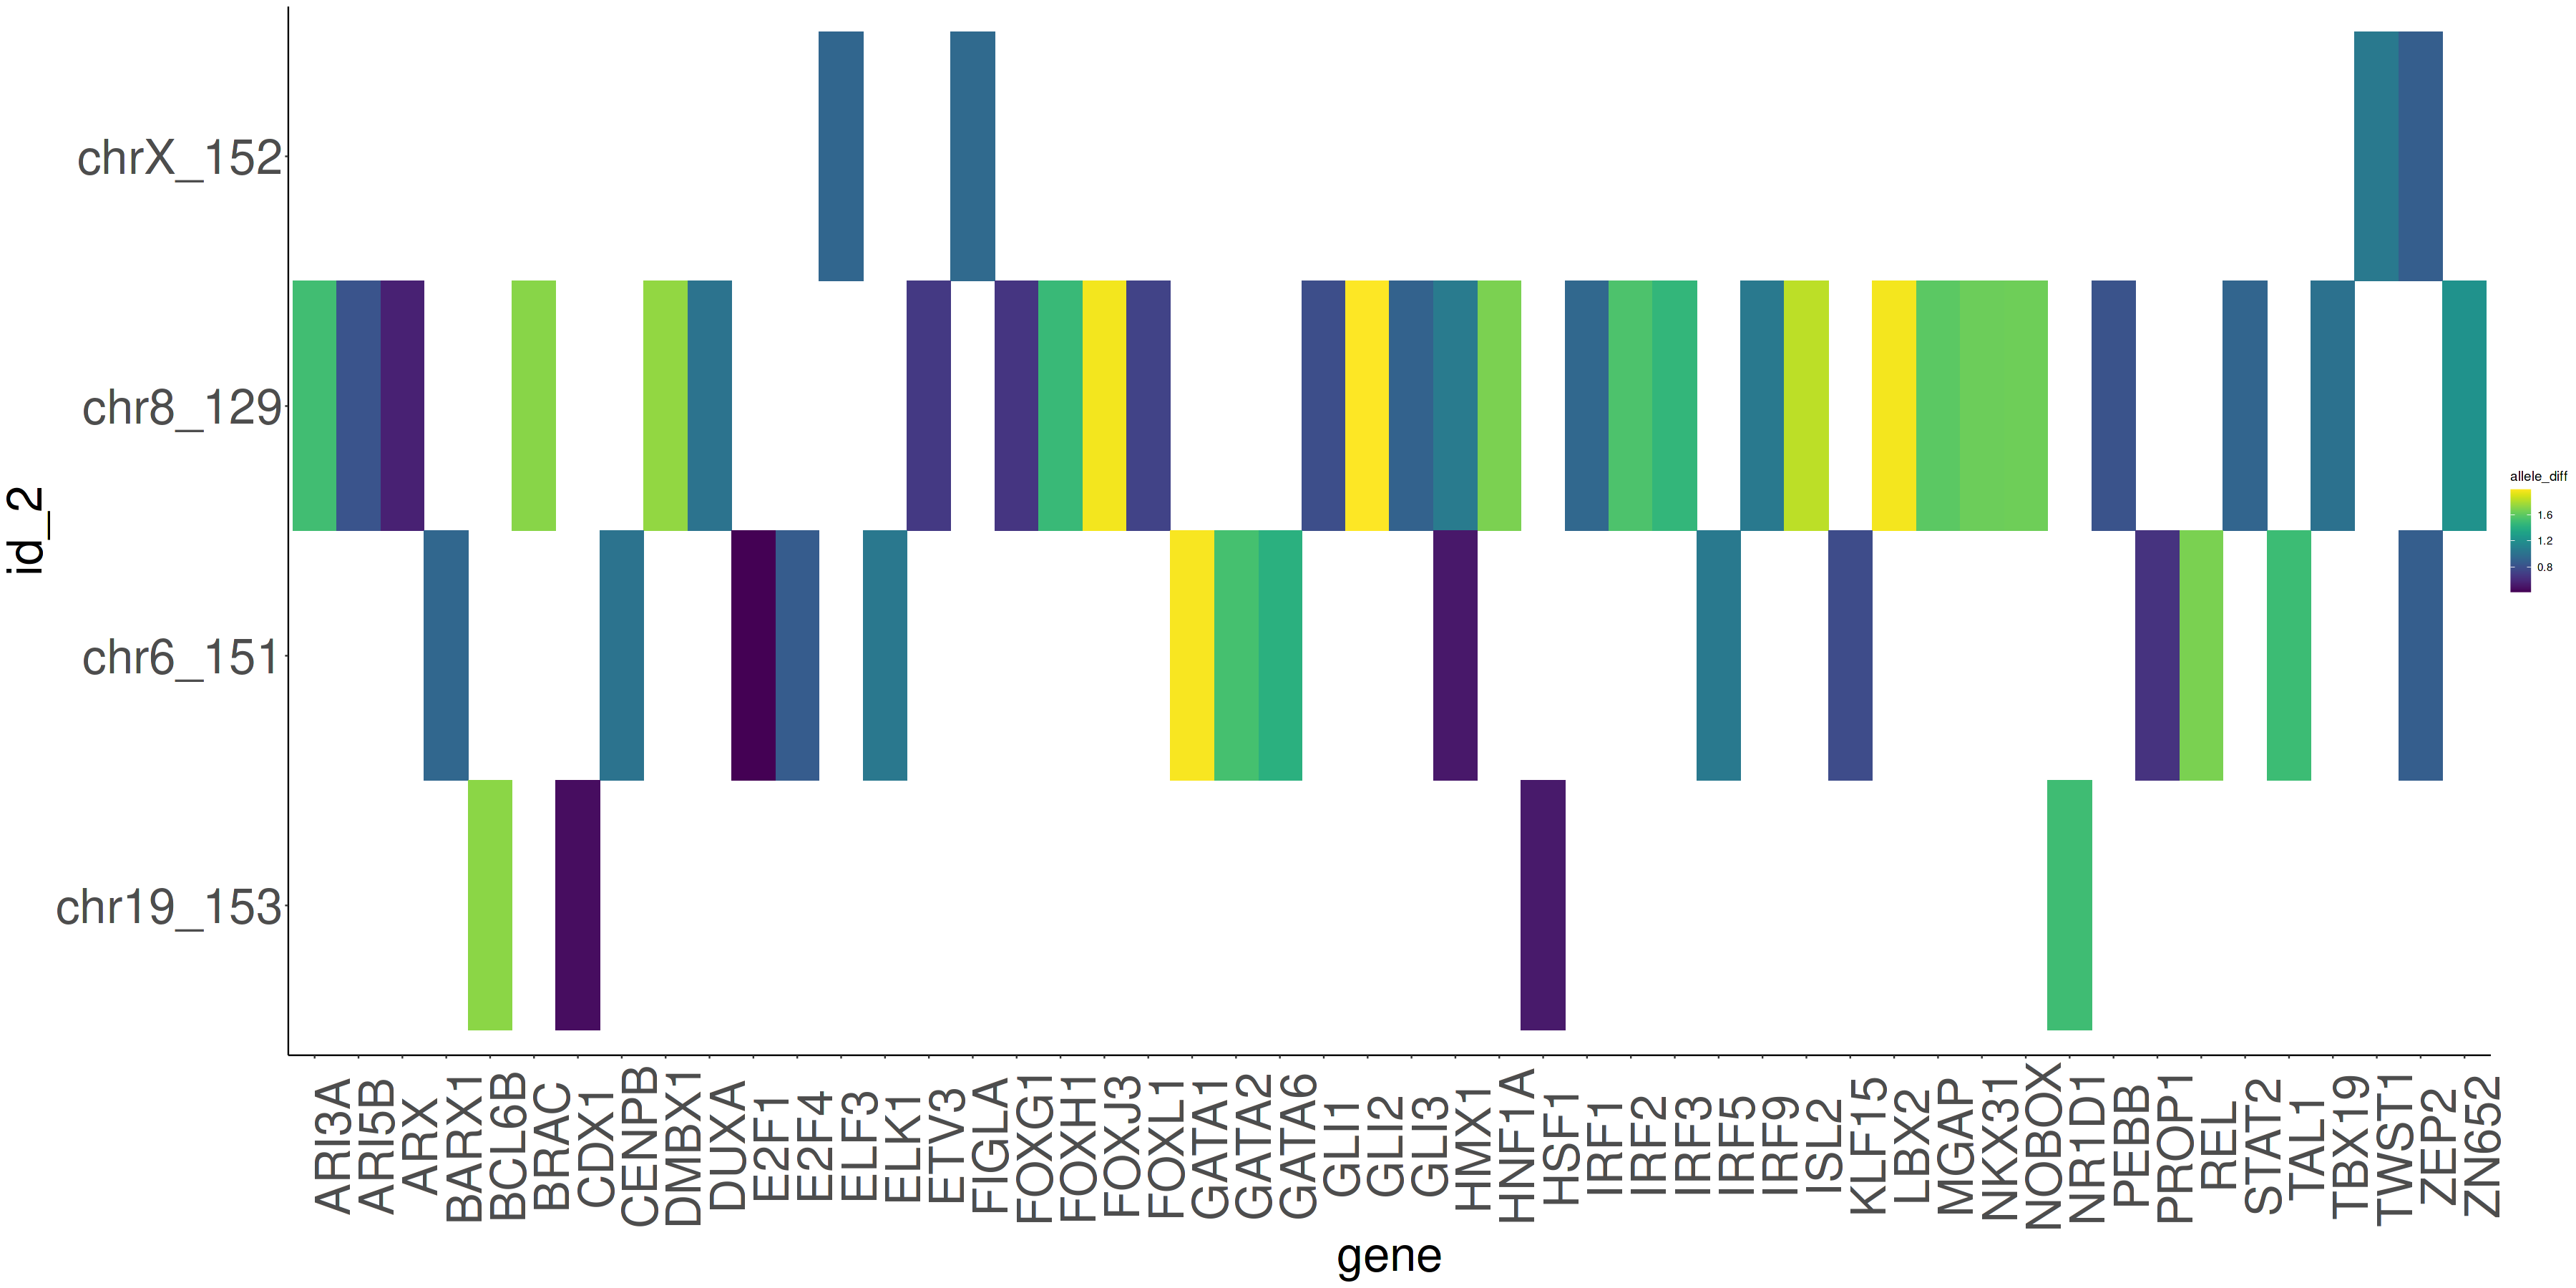

In [6]:
library(ggplot2)
library(ggrepel)
library(dplyr)
options(repr.plot.width=30, repr.plot.height=15)
library(viridis)


file = read.table("/home/darragh/New/motifbreakR/Hartwig_motifbreakR_results_mutation_counts.txt", header=T)

#chr1_204 <- file[grepl("chr1:2044", file$motif_id), ]
#file = file[(file$p_value < 1e-4),]
file = file[(file$allele_diff > 0.4),]

head(file)

ggplot(file, aes(y=id_2, x=gene, fill = allele_diff )) +
   geom_tile()+
  theme_classic() +
  scale_fill_viridis( option="viridis") +
    theme(axis.text = element_text(size = 40), axis.title.x = element_text(size = 40), axis.title.y = element_text(size = 40), axis.text.x = element_text(angle=90)) 
 #+
#  geom_text_repel(
#     data = chr1_204,
#     aes(label = gene),
#     color = "black",
#     box.padding = 1,
#     max.overlaps=100,
#     label.size=16,
#     segment.color = "black",
#     segment.size = 0.2,
#     segment.linetype = "dashed"
#   ) #+
#   xlab("Proportion of regulatory element mutation at TF binding site") +
#   ylab("Number of mutations") +
#   theme(axis.text = element_text(size = 16), axis.title.x = element_text(size = 16), axis.title.y = element_text(size = 16)) 
ggsave("/home/darragh/New/expression_TF_motifbreaker_heatmap_hartwig.pdf", width=30, height=15)

# chr1_204 %>%
#   group_by(gene) %>%
#   summarize(total_id = sum(id))%>%
#   arrange(desc(total_id))

In [9]:
print(gene_expression_ps_label)

                                              id   p_value_mut  p_value_cna
8      chr20_52271180_52274444_RTEL1__matrix.txt  1.976630e-06 4.232588e-01
113   chr20_52271180_52274444_ZNF217__matrix.txt  4.952060e-13 6.834638e-01
140    chr2_216000743_216003558_ATIC__matrix.txt  6.050785e-09 6.089289e-01
163    chr17_56743474_56746913_RNF43__matrix.txt  1.209495e-07 3.023431e-03
175       chr10_4386105_4387376_KLF6__matrix.txt  5.895570e-07 4.250775e-01
210  chr6_157039810_157042841_ARID1B__matrix.txt  1.634381e-13 3.536051e-01
290  chr14_68773177_68774719_ZFP36L1__matrix.txt 6.714663e-140 1.119912e-01
308     chr22_20921131_20924100_CRKL__matrix.txt  2.656246e-09 1.309087e-01
420     chr17_57919425_57925336_CLTC__matrix.txt  1.722439e-19 2.850347e-05
449     chr8_49832302_49835385_PRKDC__matrix.txt  1.912754e-25 7.040258e-02
555   chr19_15359544_15363490_NOTCH3__matrix.txt  1.626289e-13 8.288394e-01
633     chr12_6444159_6446316_ZNF384__matrix.txt  1.907574e-06 4.866622e-01
639    chr12

In [13]:
gene_expression_ps[gene_expression_ps$N > 30, ]

id                                           p_value_mut  p_value_cna 
491   chr2_232476039_232479377_SNORA75__matrix.txt 3.839443e-01 5.701912e-01
644   chr8_32167094_32167994_SNORA70__matrix.txt   8.531687e-10 2.030802e-04
717   chr8_144910084_144911954_7SK__matrix.txt     1.120362e-27 5.526417e-01
1367  chr8_144820386_144822925_7SK__matrix.txt     1.445881e-69 4.860315e-01
2424  chr5_35228499_35231059_U3__matrix.txt        5.680878e-01 3.154932e-01
2606  chr3_64328425_64331356_U3__matrix.txt        9.578634e-01 7.973426e-02
2694  chr17_58676623_58679607_U3__matrix.txt       2.216580e-01 6.261045e-06
3532  chr8_98655330_98658211_SNORA72__matrix.txt   8.895383e-01 6.798231e-04
3911  chr16_23082411_23084754_SNORA75__matrix.txt  2.540653e-01 1.350366e-01
4924  chr15_37390780_37394799_U3__matrix.txt       8.817687e-01 6.780285e-01
5399  chr8_145025882_145028101_7SK__matrix.txt     0.000000e+00 1.030997e-01
6012  chr12_76244297_76246988_SNORA70__matrix.txt  1.337629e-01 9.122339e-04
6139  chr1_219739680_219740916_U3__matrix.txt      1.829044e-01 1.930733e-03
6265  chr17_42295601_42300225_U3__matrix.txt       6.832213e-01 8.257441e-06
6302  chr8_144464702_144468013_7SK__matrix.txt     0.000000e+00 9.893022e-01
6400  chr12_76326115_76328655_SNORA70__matrix.txt  4.403642e-46 2.049557e-01
7973  chr3_111394806_111395912_SNORA70__matrix.txt 5.389717e-38 9.377972e-04
8374  chr19_10340895_10342376_SNORA70__matrix.txt  2.247212e-03 3.203630e-01
8583  chr3_107241384_107244843_SNORA70__matrix.txt 1.174027e-16 4.888862e-04
8642  chr3_30559433_30560638_U3__matrix.txt        4.812548e-01 1.060688e-03
9889  chr15_70388343_70394358_U3__matrix.txt       6.057190e-01 4.580098e-02
11977 chr8_144814121_144816411_7SK__matrix.txt     0.000000e+00 5.769089e-01
      FC_RNA FC_CNA    N   wilcox_test_p_RNA wilcox_test_p_CNA q_value_mut  
491   1      1.4796211  35 0.9017396         9.018356e-02       1.000000e+00
644   1      0.9510635 135 0.9982595         2.902531e-08       1.078491e-05
717   1      0.9659206  35 0.8895820         5.636953e-01       1.416250e-23
1367  1      1.4501640  56 0.3452738         6.041890e-01       1.827738e-65
2424  1      1.0101917 250 0.3766139         3.759453e-04       1.000000e+00
2606  1      1.0026897 250 0.5406715         8.932409e-01       1.000000e+00
2694  1      1.0817067 350 0.2841260         1.940615e-18       1.000000e+00
3532  1      1.0054668  56 0.9167612         2.798343e-01       1.000000e+00
3911  1      1.2115342  49 0.7735508         3.358943e-04       1.000000e+00
4924  1      0.9796487 300 0.8725220         2.665232e-09       1.000000e+00
5399  1      0.9641877  35 0.2856288         9.721672e-03      1.000000e-300
6012  1      1.1663068 189 0.8802610         3.567785e-02       1.000000e+00
6139  1      0.9919076 250 0.1621208         7.525426e-05       1.000000e+00
6265  1      1.2669661 300 0.2739735         1.144601e-17       1.000000e+00
6302  1      1.4151075  42 0.7037874         2.238326e-01      1.000000e-300
6400  1      1.4110448 162 0.9314500         9.032894e-09       5.566644e-42
7973  1      1.5136373 135 0.9974095         1.311061e-17       6.813141e-34
8374  1      1.2278635 162 0.9340804         3.793475e-01       1.000000e+00
8583  1      1.6651244 162 0.8243432         5.858703e-16       1.484087e-12
8642  1      1.0559408 250 0.3418873         1.403338e-15       1.000000e+00
9889  1      0.9862331 250 0.9312705         3.152139e-03       1.000000e+00
11977 1      1.0068217  49 0.1824184         3.223767e-01      1.000000e-300
      q_value_cna log2FC_RNA log2FC_CNA   chr   start     end       gene   
491   1.00000000  0           0.565227742 chr2  232476039 232479377 SNORA75
644   1.00000000  0          -0.072386405 chr8   32167094  32167994 SNORA70
717   1.00000000  0          -0.050023526 chr8  144910084 144911954 7SK    
1367  1.00000000  0           0.536216015 chr8  144820386 144822925 7SK    
2424  1.00000000  0           0.014629155 chr5   35228499  35231059 U3     
2606  1.

In [15]:
gene_expression_ps[-log10(gene_expression_ps$q_value_mut) > 100, ]

id                                         p_value_mut   p_value_cna
25  chr1_185687711_185690025_TPR__matrix.txt   6.084114e-109 0.8424828  
136 chr6_44016983_44020682_VEGFA__matrix.txt   1.091880e-126 0.7675585  
198 chr6_43666272_43667801_NFKBIE__matrix.txt   0.000000e+00 0.2044260  
260 chr2_112789082_112791519_MERTK__matrix.txt 6.366614e-135 0.7228471  
    FC_RNA    FC_CNA    N wilcox_test_p_RNA wilcox_test_p_CNA q_value_mut  
25  1.6308740 1.0092707 7 0.007207672       0.6938579         4.204731e-105
136 0.9592047 0.6866536 7 0.670284376       0.9327796         7.545981e-123
198 1.1581342 1.7100927 5 0.298365121       0.3409466         1.000000e-300
260 1.1755952 1.2221415 8 0.341075063       0.3546008         4.399967e-131
    q_value_cna log2FC_RNA  log2FC_CNA  chr  start     end       gene   null1
25  1            0.70564533  0.01331316 chr1 185687711 185690025 TPR    NA   
136 1           -0.06008942 -0.54234553 chr6  44016983  44020682 VEGFA  NA   
198 1            0.21180249  0.77407457 chr6  43666272  43667801 NFKBIE NA   
260 1            0.23339142  0.28941134 chr2 112789082 112791519 MERTK  NA   
    null2     
25  matrix.txt
136 matrix.txt
198 matrix.txt
260 matrix.txt

In [123]:
from scipy.stats import rankdata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def bh_correction(p_values):
    n = len(p_values)
    ranks = rankdata(p_values)
    q_values = p_values * n / ranks
    q_values = np.minimum.accumulate(q_values[::-1])[::-1]
    return np.minimum(1, q_values)

def bonferroni_correction(p_values):
    num_tests = len(p_values)
    corrected_p_values = np.minimum(1, num_tests * p_values)

    return corrected_p_values


signif_df = pd.DataFrame(signif)
signif_df.columns = ['id', 'p_value_mutated', 'p_value_RNA', 'FC_RNA', 'FC_CNA', 'N']
signif_df['q_value'] = bonferroni_correction(signif_df['p_value_mutated'])
signif_df['log2FC_RNA'] = np.log2(signif_df['FC_RNA'])
signif_df['log2FC_CNA'] = np.log2(signif_df['FC_CNA'])

signif_df = signif_df.loc[signif_df['q_value'] < 0.1]
# signif_df[['chr', 'start', 'end' ,'gene', 'null2', 'null3']] = signif_df['id'].str.split("_", expand=True)
# signif_df = signif_df[['chr',	'start',	'end', 'p_value',	'FC_RNA',	'FC_CNA',	'N',	'q_value',	'log2FC_RNA',	'log2FC_CNA']]



# signif_df.to_csv("/home/darragh/New/eQTL/output_data.txt", sep = "\t", header=True, index=False)


# #Hartwig mutation
# Primary_Driver_H = pd.read_table("/home/darragh/New/DriverPower_Final_2/ICGC/output/DriverPower_burden.result.tsv", sep="\t", header=0)
# Primary_Driver_H[['chr', 'start', 'end']] = Primary_Driver_H['binID'].str.split("_", expand=True)
# Primary_Driver_H = Primary_Driver_H[['chr',	'start', 'end', 'binID',	'length',	'nMut',	'nSample',	'N',	'nPred',	'raw_p',	'raw_q']]
# display(Primary_Driver_H)



display(signif_df)


id  p_value_mutated  \
4        chr8_118723118_118725735_EXT1__matrix.txt     1.208916e-17   
6       chr10_10872615_10873460_SFTA1P__matrix.txt     4.044984e-08   
110   chr1_153336582_153338141_SLC27A3__matrix.txt     2.276098e-04   
134  chr13_30009298_30010844_MTUS2-AS1__matrix.txt     1.615294e-08   
158    chr1_153336582_153338141_S100A8__matrix.txt     2.438675e-06   
209       chr12_611883_612807_B4GALNT3__matrix.txt     1.679359e-07   
215    chr10_123218599_123220647_FGFR2__matrix.txt     8.382166e-09   
237        chr17_54756209_54757763_NOG__matrix.txt     1.190006e-04   
335       chr20_60011064_60012699_CDH4__matrix.txt     1.689416e-05   
340    chr1_157931621_157933753_SLAMF9__matrix.txt     7.251924e-06   

      p_value_RNA    FC_RNA    FC_CNA    N       q_value  log2FC_RNA  \
4    1.301296e-11  1.161184  2.415909  6.0  4.690594e-15    0.215597   
6    9.828819e-01  1.235849  1.868805  6.0  1.569454e-05    0.305503   
110  1.080718e-01  0.907648  1.511003  5.0  8.831259e-02   -0.139795   
134  4.371537e-04  1.009901  1.980964  5.0  6.267340e-06    0.014214   
158  9.717539e-01  2.418605  1.512131  5.0  9.462059e-04    1.274175   
209  4.793711e-04  1.650877  2.196667  6.0  6.515913e-05    0.723233   
215  2.577333e-26  2.353579  4.897845  6.0  3.252281e-06    1.234856   
237  7.111223e-01  1.059406  1.167972  7.0  4.617222e-02    0.083256   
335  6.406179e-05  1.004545  1.555869  6.0  6.554936e-03    0.006543   
340  1.745085e-06  1.149533  1.526476  5.0  2.813747e-03    0.201048   

     log2FC_CNA  
4      1.272566  
6      0.902116  
110    0.595507  
134    0.986202  
158    0.596583  
209    1.135316  
215    2.292147  
237    0.224006  
335    0.637720  
340    0.610205

In [ ]:
Primary_Driver_H = pd.read_table("/home/darragh/New/DriverPower_Final_2/ICGC/output/DriverPower_burden.result.tsv", sep="\t", header=0)
Primary_Driver_H[['chr', 'start', 'end']] = Primary_Driver_H['binID'].str.split("_", expand=True)
Primary_Driver_H = Primary_Driver_H[['chr',	'start', 'end', 'binID',	'length',	'nMut',	'nSample',	'N',	'nPred',	'raw_p',	'raw_q']]

In [100]:
signif_df_plot.head(60)

log2FC_RNA  log2FC_CNA
id                                                                   
chr11_77788513_77791788_USP35__matrix.txt        1.802782    2.474041
chr11_62337079_62343778_SNORA57__matrix.txt      7.417557    0.127158
chr5_137875161_137882656_SNORA74A__matrix.txt   -1.569541   -0.198599
chr12_52607250_52612209_KRT7__matrix.txt        -1.862321    0.308866
chr19_17583358_17587684_SNORA68__matrix.txt      7.052351    0.272370
chr10_102278535_102279899_SCD__matrix.txt       -1.515372    0.554921
chr7_95220826_95229776_PEG10__matrix.txt         1.602974    0.474146
chr7_94138231_94141064_PEG10__matrix.txt         2.778572   -0.135690
chr4_174100019_174104694_GALNT7__matrix.txt      1.539181    0.301834
chr2_10236133_10237827_SNORA26__matrix.txt       3.150560    0.065338
chr17_37805668_37807173_GRB7__matrix.txt         4.179749    4.332237
chr4_73239493_73242552_ALB__matrix.txt           5.880621   -0.034661
chr10_32232040_32234275_CCDC7__matrix.txt        2.035965    0.175502
chr1_59082572_59087703_TACSTD2__matrix.txt      -1.979445    0.583912
chr1_93287202_93290209_RPL5__matrix.txt          1.732632    0.568400
chr7_23529393_23531739_GPNMB__matrix.txt         2.385811   -0.546606
chr15_98963810_98965184_SYNM__matrix.txt         1.881095   -0.098343
chr8_66559640_66561753_MTFR1__matrix.txt         1.564156    0.887399
chr17_38134621_38139188_CDC6__matrix.txt         1.526811   -0.021477
chr7_44120641_44123274_PPIA__matrix.txt         -1.705353    0.028965
chr5_68483832_68486754_CCNB1__matrix.txt         1.502347   -0.028732
chr4_89201425_89206974_SPP1__matrix.txt         -2.240352    0.278400
chr3_12702740_12707145_SNORA7A__matrix.txt       4.907371    0.688923
chr6_152022272_152026456_ESR1__matrix.txt       -2.482675    0.575759
chr8_123655358_123656115_TBC1D31__matrix.txt     1.661128    0.548116
chr2_128049951_128053391_PROC__matrix.txt        2.770446   -0.024573
chr16_56482652_56487508_MT1E__matrix.txt        -2.283114    0.023560
chr1_28967811_28971381_SNORA73B__matrix.txt      1.663774    0.008941
chr11_1223300_1225380_MUC5B__matrix.txt          3.798041    0.570268
chr5_57705030_57708663_PLK2__matrix.txt         -1.561504    0.540634
chr17_75386952_75389730_SYNGR2__matrix.txt      -1.807595    0.748593
chr11_9283686_9287709_SNORA23__matrix.txt       -5.313790   -0.018062
chr8_36999106_37007238_ERLIN2__matrix.txt        1.558967    2.042638
chr4_39698511_39703485_RPL9__matrix.txt          1.694571   -0.000036
chr6_132435085_132437680_ENPP1__matrix.txt       2.407943    1.318814
chr4_3292745_3296299_HGFAC__matrix.txt           2.057413   -0.004769
chr8_48856731_48858037_MCM4__matrix.txt          1.960514    1.157451
chr12_53362708_53366878_KRT18__matrix.txt       -1.748197    0.039536
chr17_37006573_37012587_RPL23__matrix.txt        2.270805    3.217291
chr5_137908576_137912648_MATR3__matrix.txt       2.310061   -0.108529
chr5_138179005_138181931_SNORA74A__matrix.txt   -2.551101   -0.139992
chr1_150896930_150901022_ECM1__matrix.txt        1.918306    0.221650
chr17_7377792_7385055_SNORA67__matrix.txt        2.075533    0.349208
chr5_138738340_138740579_EGR1__matrix.txt        1.696669   -0.092731
chr10_37602688_37604152_LINC00993__matrix.txt    1.777625    1.096216
chr9_137215137_137223345_RNU6ATAC__matrix.txt    6.473056    0.564041
chr6_43967194_43971758_VEGFA__matrix.txt        -2.231125    0.767766
chr17_37805668_37807173_ERBB2__matrix.txt        4.192949    4.496083
chr17_37006573_37012587_RPL19__matrix.txt        2.219360    2.979169
chr16_56639032_56650013_MT1E__matrix.txt        -2.296403   -0.013953
chr1_153630333_153632661_S100A9__matrix.txt      3.813006    0.570600
chr17_48448638_48451471_LUC7L3__matrix.txt      -5.229011    0.102560
chr17_37729318_37730935_GRB7__matrix.txt         3.180881    3.925559
chr17_37885327_37887676_MIEN1__matrix.txt        1.516917    1.766529
chr10_81194107_81196147_TMEM254__matrix.txt     -3.271276    0.574490
chr17_7460440_7468401_CLDN7__matrix.txt         -1.839874

In [12]:
import pybedtools as pybed

mutations = pd.read_table("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation.txt", sep = "\t")
Hartwig = pybed.BedTool.from_dataframe(mutations)
Hartwig = Hartwig.sort()

file = pd.read_table("/home/darragh/New/eQTL/Fran_Adrian/signif_results.txt")
file[['chr', 'start', 'end', 'gene', 'null', 'null']] = file['id'].str.split("_", expand=True)
file = pybed.BedTool.from_dataframe(file[['chr', 'start', 'end', 'id', 'gene']])


Hartwig_DP_mutated = file.intersect(Hartwig, wa=True, wb=True)
Hartwig_DP_mutated = pd.read_table(Hartwig_DP_mutated.fn, header=None)

#Select columns and rename them
Hartwig_DP_mutated = Hartwig_DP_mutated.iloc[:, [3,1,2,10,8,9,6] ]
Hartwig_DP_mutated.columns = ['id','start', 'end', 'patient', 'ref', 'alt', 'mut_start']
Hartwig_DP_mutated['nucleotide_change'] = Hartwig_DP_mutated['ref'] + '>' + Hartwig_DP_mutated['alt']
Hartwig_DP_mutated['len'] = Hartwig_DP_mutated['end'] - Hartwig_DP_mutated['start']
Hartwig_DP_mutated['position'] = Hartwig_DP_mutated['mut_start'] - Hartwig_DP_mutated['start']
Hartwig_DP_mutated['patient'] = Hartwig_DP_mutated['patient'].str.split(".", expand=True)[0]
Hartwig_DP_mutated = Hartwig_DP_mutated[['id', 'len', 'patient', 'position', 'nucleotide_change']]

#Group the data by the 'id' column

#Write each each gene to s seperate df

for group_name, group_data in Hartwig_DP_mutated.groupby('id'):

    group_data.to_csv("/home/darragh/New/eQTL/Fran_Adrian/lolipops/" + group_data['id'].iat[0] + '_'  + "_matrix.txt" ,sep = "\t" , header=True, index=False)

display(Hartwig_DP_mutated)


id   len        patient  \
0    chr5_137875161_137882656_SNORA74A__matrix.txt  7495  CPCT02120183T   
1    chr5_137875161_137882656_SNORA74A__matrix.txt  7495  CPCT02020493T   
2    chr5_137875161_137882656_SNORA74A__matrix.txt  7495  CPCT02040097T   
3    chr5_137875161_137882656_SNORA74A__matrix.txt  7495  WIDE01010311T   
4    chr5_137875161_137882656_SNORA74A__matrix.txt  7495  CPCT02440018T   
..                                             ...   ...            ...   
765      chr1_46593405_46602062_TSPAN1__matrix.txt  8657  CPCT02050164T   
766      chr1_46593405_46602062_TSPAN1__matrix.txt  8657  CPCT02010682T   
767      chr1_46593405_46602062_TSPAN1__matrix.txt  8657  CPCT02010682T   
768      chr1_46593405_46602062_TSPAN1__matrix.txt  8657  CPCT02120051T   
769      chr1_46593405_46602062_TSPAN1__matrix.txt  8657  WIDE01010268T   

     position nucleotide_change  
0         236               C>T  
1        1375               G>T  
2        1905               G>A  
3        2295               G>T  
4        2295               G>T  
..        ...               ...  
765      7916               C>G  
766      7980               G>C  
767      8224               G>A  
768      8465               G>C  
769      8601               G>C  

[770 rows x 5 columns]

In [ ]:
library(dplyr)
library(ggplot2)

# Get a list of all .txt files in the specified directory
txt_files <- list.files("/home/darragh/New/eQTL/Fran_Adrian/lolipops", pattern = "\\.txt$", full.names = TRUE)

# Iterate through each file
for (txt_file in txt_files) {
  # Read the current file
  PLEKHS1 <- read.table(txt_file, sep = "\t", header = TRUE)

  # Your existing code here
  mutation_counts <- PLEKHS1 %>%
    count(position) %>%
    mutate(freq = n)

  enhancer_start <- 0
  enhancer_end <- PLEKHS1$len[1]

  PLEKHS1 <- merge(PLEKHS1, mutation_counts)

  PLEKHS1$mutation_label <- PLEKHS1$nucleotide_change

  min_freq <- min(mutation_counts$freq)
  max_freq <- max(mutation_counts$freq)

  ggplot(PLEKHS1, aes(x = position, y = freq)) +
    geom_segment(aes(x = position, xend = position, y = 0, yend = freq), color = "black") +
    geom_point(aes(x = position, y = freq), shape = 21, fill = "dodgerblue", color = "black", size = 5) +
    scale_x_continuous(limits = c(enhancer_start, enhancer_end), 
                       breaks = seq(enhancer_start, enhancer_end, 100)) +
    labs(x = "Position", y = "Mutation count") +
    theme_classic()

  # Save the plot as a PDF in the same directory
  pdf_file <- sub("\\.txt$", ".pdf", basename(txt_file))
  ggsave(file.path(dirname(txt_file), pdf_file), width = 12, height = 4)
}


Warning message in geom_violin(width = 0.25, outlier.shape = NA, fill = "#ADD8E6"):
“Ignoring unknown parameters: `outlier.shape`”
Warning message in geom_boxplot(width = 0.05, outlier = F):
“Ignoring unknown parameters: `outlier`”


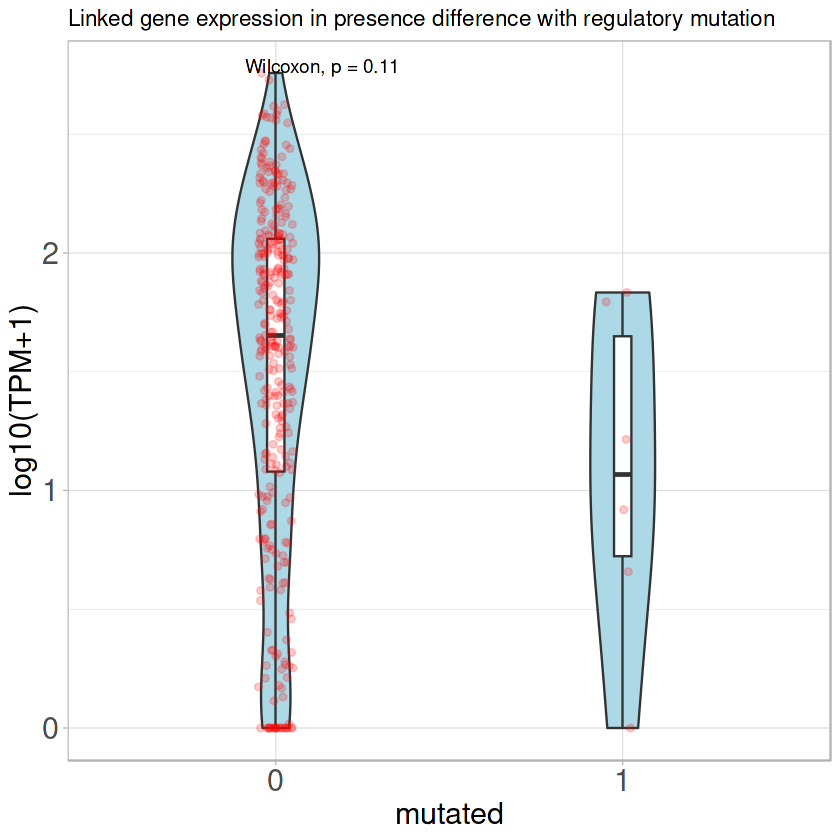

In [6]:
library(ggplot2)
library(ggpubr)

file = read.delim("/home/darragh/New/eQTL/All/matrixes/chr12_52607250_52612209_KRT7__matrix.txt", header = TRUE)
file$mutated = as.character(file$mutated)

ggplot(file, aes(x=mutated, y=log10(RNA))) + geom_violin(width=0.25, outlier.shape = NA, fill="#ADD8E6")  + geom_boxplot(width=0.05, outlier=F) + geom_jitter(color="red", width=0.05, alpha=0.2) + theme_light() +stat_compare_means() +
  theme(axis.text=element_text(size=18), axis.title.x=element_text(size=18) , axis.title.y=element_text(size=18) ) +
  ylab("log10(TPM+1)") + ggtitle("Linked gene expression in presence difference with regulatory mutation")
# ggplot(file, aes(x=mutated, y=log10(CNA))) + geom_violin(width=1, outlier.shape = NA, fill="#ADD8E6")  + geom_boxplot(width=0.05, outlier=F) + geom_jitter(color="red", width=0.05, alpha=0.1) + theme_light() +stat_compare_means() +
#   theme(axis.text=element_text(size=18), axis.title.x=element_text(size=18) , axis.title.y=element_text(size=18) )

# Generate RNA expression boxplots of every region

In [ ]:
import pandas as pd
import pybedtools as pybed
import os


mutations = pd.read_table("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation.txt", sep = "\t")
Hartwig = pybed.BedTool.from_dataframe(mutations)
Hartwig = Hartwig.sort()

file = pd.read_table("/home/darragh/New/DriverPower_Final/output/DriverPower_burden.result.tsv", sep = "\t")
file[['chr', 'start', 'end']] = file['binID'].str.split("_", expand=True)
Hartwig_DP = file.loc[file['raw_q'] < 0.1]
Hartwig_DP = pybed.BedTool.from_dataframe(Hartwig_DP[['chr',	'start',	'end', 'binID',	'length',	'nMut',	'nSample',	'N',	'nPred',	'raw_p',	'raw_q']])


Hartwig_DP_mutated = Hartwig_DP.intersect(Hartwig, wa=True, wb=True)
Hartwig_DP_mutated = pd.read_table(Hartwig_DP_mutated.fn, header=None)

#Select columns and rename them
Hartwig_DP_mutated = Hartwig_DP_mutated.iloc[:, [3,1,2,16,14,15,12] ]
Hartwig_DP_mutated.columns = ['id','start', 'end', 'patient', 'ref', 'alt', 'mut_start']
Hartwig_DP_mutated['nucleotide_change'] = Hartwig_DP_mutated['ref'] + '>' + Hartwig_DP_mutated['alt']
Hartwig_DP_mutated['len'] = Hartwig_DP_mutated['end'] - Hartwig_DP_mutated['start']
Hartwig_DP_mutated['position'] = Hartwig_DP_mutated['mut_start'] - Hartwig_DP_mutated['start']
Hartwig_DP_mutated['patient'] = Hartwig_DP_mutated['patient'].str.split(".", expand=True)[0]
Hartwig_DP_mutated = Hartwig_DP_mutated[['id', 'len', 'patient', 'position', 'nucleotide_change']]

#Group the data by the 'id' column

#Write each each gene to s seperate df

for group_name, group_data in Hartwig_DP_mutated.groupby('id'):

    group_data.to_csv("/home/darragh/New/lolipops/DP/Fran_Adrian/" + group_data['id'].iat[0] + '_'  + "_matrix.txt" ,sep = "\t" , header=True, index=False)

# ## Iterate over each group
# # for group_name, group_data in groups:
# #         # Create a filename based on the group name
# #         filename = os.path.join(output_directory, group_name + '.txt')

# #         # Save the group data to the file
# #         group_data.to_csv(filename, sep='\t', index=False)


display(Hartwig_DP_mutated)


Optimization terminated successfully.
         Current function value: 0.077031
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                mutated   No. Observations:                  329
Model:                          Logit   Df Residuals:                      327
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Jan 2024   Pseudo R-squ.:                 0.02131
Time:                        11:43:52   Log-Likelihood:                -25.343
converged:                       True   LL-Null:                       -25.895
Covariance Type:            nonrobust   LLR p-value:                    0.2935
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7106      0.659     -7.144      0.000      -6.003      -3.418
CNA            0.1786      0.

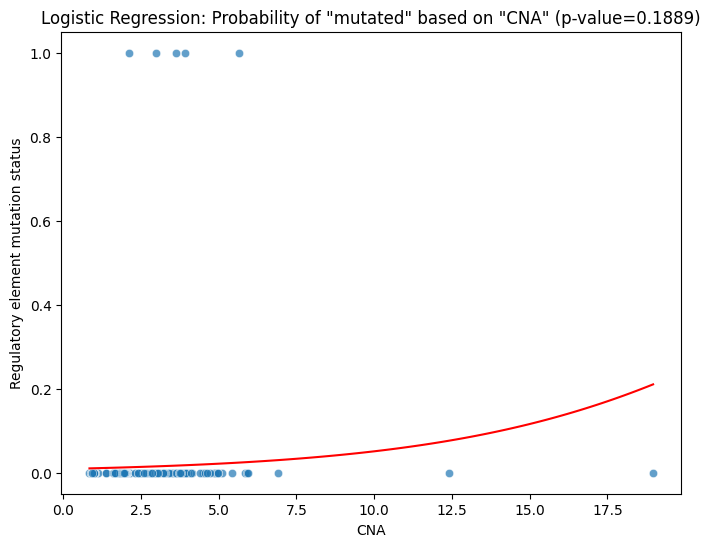

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

# Load your data
my_data = pd.read_table("/home/darragh/New/eQTL/All/matrixes/chrX_54665002_54669359_MAGED2__matrix.txt", sep="\t", header=0)

# Logistic regression model
model_logistic = sm.Logit(my_data['mutated'], sm.add_constant(my_data['CNA']))
result = model_logistic.fit()

# Print summary statistics
print(result.summary())

# Generate predicted probabilities
predicted_probabilities = result.predict(sm.add_constant(my_data['CNA']))

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=my_data['CNA'], y=my_data['mutated'], alpha=0.7)

# Plot the logistic regression curve
x_values = np.linspace(my_data['CNA'].min(), my_data['CNA'].max(), 100)
y_values = result.predict(sm.add_constant(x_values))
plt.plot(x_values, y_values, color='red', label='Logistic Regression C/urve')

p_value_CNA = result.pvalues['CNA']

plt.title(f'Logistic Regression: Probability of "mutated" based on "CNA" (p-value={p_value_CNA:.4f})')
plt.xlabel('CNA')
plt.ylabel('Regulatory element mutation status')
plt.show()

# Generate lolipop plot of every region

In [7]:
Hartwig_ps = pd.read_table("/home/darragh/New/DriverPower_Final/output/DriverPower_burden.result.tsv")
Hartwig_ps['Hartwig_mutation_log2FC'] = Hartwig_ps['Hartwig_mutation_log2FC'] = np.log2((Hartwig_ps['nMut']+1) / (Hartwig_ps['nPred']+1))
Hartwig_ps = Hartwig_ps[['binID', 'Hartwig_mutation_log2FC', 'nMut' ]]
display(Hartwig_ps)

binID  Hartwig_mutation_log2FC  nMut
0        chr6_142705544_142708137                 3.365281    70
1       chr10_115510039_115513898                 2.747832    68
2          chr9_46112532_46114176                 3.145975    12
3        chr1_148927624_148933345                 2.401983    75
4         chr20_61505135_61505488                 3.115168    16
...                           ...                      ...   ...
110391   chr8_124860469_124861086                -1.600515     0
110392    chr20_17837957_17838874                -1.728198     0
110393    chr20_17632492_17633400                -1.334257     0
110394     chr8_12464218_12465377                -0.418825     0
110395       chrY_9984103_9985073                -2.139476     0

[110396 rows x 3 columns]

In [ ]:
library(dplyr)
library(ggplot2)

# Get a list of all .txt files in the specified directory
txt_files <- list.files("/home/darragh/New/eQTL/Fran_Adrian/lolipops", pattern = "\\.txt$", full.names = TRUE)

# Iterate through each file
for (txt_file in txt_files) {
  # Read the current file
  PLEKHS1 <- read.table(txt_file, sep = "\t", header = TRUE)

  # Your existing code here
  mutation_counts <- PLEKHS1 %>%
    count(position) %>%
    mutate(freq = n)

  enhancer_start <- 0
  enhancer_end <- PLEKHS1$len[1]

  PLEKHS1 <- merge(PLEKHS1, mutation_counts)

  PLEKHS1$mutation_label <- PLEKHS1$nucleotide_change

  min_freq <- min(mutation_counts$freq)
  max_freq <- max(mutation_counts$freq)

  ggplot(PLEKHS1, aes(x = position, y = freq)) +
    geom_segment(aes(x = position, xend = position, y = 0, yend = freq), color = "black") +
    geom_point(aes(x = position, y = freq), shape = 21, fill = "dodgerblue", color = "black", size = 5) +
    scale_x_continuous(limits = c(enhancer_start, enhancer_end), 
                       breaks = seq(enhancer_start, enhancer_end, 100)) +
    labs(x = "Position", y = "Mutation count") +
    theme_classic()

  # Save the plot as a PDF in the same directory
  pdf_file <- sub("\\.txt$", ".pdf", basename(txt_file))
  ggsave(file.path(dirname(txt_file), pdf_file), width = 12, height = 4)
}

# Generate a gene expression boxplot for every region

In [9]:
 options(repr.plot.width=10, repr.plot.height=8)

library(ggplot2)
library(ggpubr)

# Get a list of all files in the specified directory
files <- list.files("/home/darragh/New/eQTL/All/matrixes/significant", pattern = "\\.txt$", full.names = TRUE)

# Iterate through each file
for (current_file in files) {
  # Read the current file
  file <- read.delim(current_file, header = TRUE)
  file$mutated <- as.character(file$mutated)

  # Your existing plotting code here
  plot <- ggplot(file, aes(x = mutated, y = log10(RNA))) +
    geom_violin(width = 0.25, outlier.shape = NA, fill = "#ADD8E6") +
    geom_boxplot(width = 0.05, outlier = FALSE) +
    geom_jitter(color = "red", width = 0.05, alpha = 0.3) +
    theme_light() +
    stat_compare_means() +
    theme(axis.text = element_text(size = 18), 
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18))+
          ggtitle("Change in linked gene expression with regulatory mutation") +
          ylab("TPM+1")
 
  # Save the plot as a PDF in the same directory
  pdf_file <- sub("\\.txt$", ".pdf", basename(current_file))
  ggsave(file.path(dirname(current_file), pdf_file), plot, width = 10, height = 8)
}


Warning message in geom_violin(width = 0.25, outlier.shape = NA, fill = "#ADD8E6"):
“Ignoring unknown parameters: `outlier.shape`”
Warning message in geom_boxplot(width = 0.05, outlier = FALSE):
“Ignoring unknown parameters: `outlier`”
Warning message in geom_violin(width = 0.25, outlier.shape = NA, fill = "#ADD8E6"):
“Ignoring unknown parameters: `outlier.shape`”
Warning message in geom_boxplot(width = 0.05, outlier = FALSE):
“Ignoring unknown parameters: `outlier`”


Warning message in geom_violin(width = 0.25, outlier.shape = NA, fill = "#ADD8E6"):
“Ignoring unknown parameters: `outlier.shape`”
Warning message in geom_boxplot(width = 0.05, outlier = FALSE):
“Ignoring unknown parameters: `outlier`”
Warning message in geom_violin(width = 0.25, outlier.shape = NA, fill = "#ADD8E6"):
“Ignoring unknown parameters: `outlier.shape`”
Warning message in geom_boxplot(width = 0.05, outlier = FALSE):
“Ignoring unknown parameters: `outlier`”
Warning message in geom_violin(width = 0.25, outlier.shape = NA, fill = "#ADD8E6"):
“Ignoring unknown parameters: `outlier.shape`”
Warning message in geom_boxplot(width = 0.05, outlier = FALSE):
“Ignoring unknown parameters: `outlier`”
Warning message in geom_violin(width = 0.25, outlier.shape = NA, fill = "#ADD8E6"):
“Ignoring unknown parameters: `outlier.shape`”
Warning message in geom_boxplot(width = 0.05, outlier = FALSE):
“Ignoring unknown parameters: `outlier`”
Warning message in geom_violin(width = 0.25, outlier.sha

# Generate a logistic regression boxplot for every region

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import glob

# Get a list of all files in the specified directory
files = glob.glob("/home/darragh/New/eQTL/All/matrixes/significant/*.txt")

# Iterate through each file
for current_file in files:
    # Load your data
    my_data = pd.read_table(current_file, sep="\t", header=0)

    # Logistic regression model
    model_logistic = sm.Logit(my_data['mutated'], sm.add_constant(my_data['CNA']))
    result = model_logistic.fit()

    # Print summary statistics
    print(result.summary())

    # Generate predicted probabilities
    predicted_probabilities = result.predict(sm.add_constant(my_data['CNA']))

    # Create a scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=my_data['CNA'], y=my_data['mutated'], alpha=0.7)

    # Plot the logistic regression curve
    x_values = np.linspace(my_data['CNA'].min(), my_data['CNA'].max(), 100)
    y_values = result.predict(sm.add_constant(x_values))
    plt.plot(x_values, y_values, color='red', label='Logistic Regression Curve')

    p_value_CNA = result.pvalues['CNA']

    plt.title(f'Logistic Regression: Probability of "mutated" based on "CNA" (p-value={p_value_CNA:.4f})')
    plt.xlabel('CNA')
    plt.ylabel('Regulatory element mutation status')
    
    # Save the plot as a PDF in the same directory with a similar name
    pdf_file = current_file.replace('.txt', '_plot.pdf')
    plt.savefig(pdf_file)
    
    plt.close()  # Close the plot to avoid overlapping when iterating over multiple files


Optimization terminated successfully.
         Current function value: 0.099851
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                mutated   No. Observations:                  329
Model:                          Logit   Df Residuals:                      327
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Dec 2023   Pseudo R-squ.:                 0.03026
Time:                        18:40:35   Log-Likelihood:                -32.851
converged:                       True   LL-Null:                       -33.876
Covariance Type:            nonrobust   LLR p-value:                    0.1522
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3057      1.128     -2.045      0.041      -4.516      -0.096
CNA           -0.6099      0.

Optimization terminated successfully.
         Current function value: 0.090302
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                mutated   No. Observations:                  329
Model:                          Logit   Df Residuals:                      327
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Dec 2023   Pseudo R-squ.:                0.008720
Time:                        18:40:35   Log-Likelihood:                -29.709
converged:                       True   LL-Null:                       -29.971
Covariance Type:            nonrobust   LLR p-value:                    0.4697
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6561      1.015     -4.586      0.000      -6.646      -2.666
CNA            0.2112      0.

In [ ]:
sns.clustermap(HMEC_unique_regs_genes_2,cmap='PRGn',figsize=(10, 13)).savefig('/home/darragh/New/Differentially_active/Non_cancer_genes_expression.pdf')


In [ ]:
# Volcano plot
library(ggplot2)
library(ggrepel)
library(stringr)

file = read.table("/home/darragh/New/eQTL/output_data.txt", sep = "\t", header=T)
head(file)

file_2 = file[file$p_value < 0.05, ]
file_2 = file_2[abs(file_2$log2FC) > 1.5, ]
file_2$gene <- str_extract(file_2$id, "(?<=_)\\w+(?=__)")
file_2$gene <- sub(".+_(.+)", "\\1", file_2$gene)
nrow(file_2)

ggplot(file, aes(x= log2FC, y = -log10(q_value) )) +
geom_point() +
geom_vline(xintercept=-1.5, linetype="dashed", color="red") +
geom_vline(xintercept=1.5, linetype="dashed", color="red") +
geom_hline(yintercept=-log10(0.1), linetype="dashed", color="red") +
xlab("Log2FC") +
ylab("-log10(q_value)") + 
theme_bw() +
 geom_text_repel(
    data = file_2,
    aes(x = log2FC, y = -log10(q_value), label = gene),
    color = "black",
    box.padding = 2,
    max.overlaps=10,
    size=4,
    segment.color = "black",
    segment.size = 0.2,
    segment.linetype = "dashed"
  ) +
  ggtitle("Regulatory mutation effect on gene expression") +
  theme(axis.text=element_text(size=18), axis.title.x=element_text(size=18) , axis.title.y=element_text(size=18) )



# What is the subtype enrichment at these regions

In [4]:
# Rows as Hartwig & ICGC
# Columns as breast cancer subtypes
# Red-Blue Heatmap showing the number of mutations in each positively seelted for hit

import pandas as pd
import pybedtools as pybed
import numpy as np

ICGC_positively_selected = pd.read_table("/home/darragh/New/eQTL/Fran_Adrian/signif_results.txt")
ICGC_positively_selected[['chr', 'start', 'end', 'gene', 'null', 'null']] = ICGC_positively_selected['id'].str.split("_", expand=True)
ICGC_positively_selected = pybed.BedTool.from_dataframe(ICGC_positively_selected[['chr', 'start', 'end', 'id']])
ICGC_positively_selected.columns = ['chr', 'start', 'end', 'binID']

# ICGC_positively_selected = pd.read_table("/home/darragh/New/DriverPower_Final/ICGC/output/DriverPower_burden.result__signif.tsv", sep = "\t")
# ICGC_positively_selected[['chr', 'start', 'end']] = ICGC_positively_selected['binID'].str.split("_", expand=True)
# ICGC_positively_selected = pybed.BedTool.from_dataframe(ICGC_positively_selected[['chr', 'start', 'end', 'binID']])

Hartwig_mutation = pybed.BedTool("/home/darragh/New/Active_Driver_Final/inputs/Hartwig_mutation.bed")
Hartwig_mutation = Hartwig_mutation.sort()

ICGC_positively_selected_mutated = ICGC_positively_selected.intersect(Hartwig_mutation, wa=True, wb=True)
ICGC_positively_selected_mutated = pd.read_table(ICGC_positively_selected_mutated.fn, header=None)
ICGC_positively_selected_mutated = ICGC_positively_selected_mutated.iloc[:,[3,9]]
ICGC_positively_selected_mutated.columns = ['id', 'Hartwig_patient']

meta_hartwig = pd.read_table("/home/darragh/Hartwig/metadata.tsv", sep="\t")
meta_hartwig = meta_hartwig.loc[meta_hartwig['primaryTumorLocation'] == "Breast"]
meta_hartwig = meta_hartwig[['sampleId',  'primaryTumorSubType' ]]
meta_hartwig.columns = ['Hartwig_patient', 'subtype_Hartwig' ]
ICGC_positively_selected_mutated = ICGC_positively_selected_mutated.merge(meta_hartwig, on="Hartwig_patient", how="left")
ICGC_positively_selected_mutated = ICGC_positively_selected_mutated.drop_duplicates()

ICGC_positively_selected_mutated['subtype_Hartwig'] = ICGC_positively_selected_mutated['subtype_Hartwig'].replace('ER-positive/HER2-positive', 'HER2+')
ICGC_positively_selected_mutated['subtype_Hartwig'] = ICGC_positively_selected_mutated['subtype_Hartwig'].replace('ER-positive/HER2-negative', 'ER+')
ICGC_positively_selected_mutated['subtype_Hartwig'] = ICGC_positively_selected_mutated['subtype_Hartwig'].replace('ER-negative/HER2-positive', 'HER2+')
ICGC_positively_selected_mutated['subtype_Hartwig'] = ICGC_positively_selected_mutated['subtype_Hartwig'].replace('Triple negative', 'Triple negative')
ICGC_positively_selected_mutated['subtype_Hartwig'].fillna('Unknown', inplace=True)

ICGC_positively_selected_mutated_Hartwig = ICGC_positively_selected_mutated[["id", "subtype_Hartwig", "Hartwig_patient"]]
ICGC_positively_selected_mutated_Hartwig = ICGC_positively_selected_mutated_Hartwig.groupby(["id",'subtype_Hartwig'])['Hartwig_patient'].nunique().reset_index()
ICGC_positively_selected_mutated_Hartwig = ICGC_positively_selected_mutated_Hartwig.drop_duplicates()
ICGC_positively_selected_mutated_Hartwig.columns = ["id",'subtype', 'Hartwig_patient' ]
ICGC_positively_selected_mutated = ICGC_positively_selected_mutated_Hartwig

ICGC_positively_selected_mutated['Hartwig_patient'] = np.where(ICGC_positively_selected_mutated['subtype'] == 'Triple_negative', ((ICGC_positively_selected_mutated['Hartwig_patient'] / 111) * 100), ICGC_positively_selected_mutated['Hartwig_patient'])
ICGC_positively_selected_mutated['Hartwig_patient'] = np.where(ICGC_positively_selected_mutated['subtype'] == 'HER2+', (ICGC_positively_selected_mutated['Hartwig_patient'] / 116) * 100, ICGC_positively_selected_mutated['Hartwig_patient'])
ICGC_positively_selected_mutated['Hartwig_patient'] = np.where(ICGC_positively_selected_mutated['subtype'] == 'ER+', (ICGC_positively_selected_mutated['Hartwig_patient'] / 513) * 100, ICGC_positively_selected_mutated['Hartwig_patient'])
ICGC_positively_selected_mutated['Hartwig_patient'] = ICGC_positively_selected_mutated['Hartwig_patient'].round(0).astype(int)
ICGC_positively_selected_mutated_Hartwig = ICGC_positively_selected_mutated[ICGC_positively_selected_mutated['subtype'] != 'Unknown']

##################

ICGC_positively_selected = pd.read_table("/home/darragh/New/eQTL/Fran_Adrian/signif_results.txt")
ICGC_positively_selected[['chr', 'start', 'end', 'gene', 'null', 'null']] = ICGC_positively_selected['id'].str.split("_", expand=True)
ICGC_positively_selected = pybed.BedTool.from_dataframe(ICGC_positively_selected[['chr', 'start', 'end', 'id']])
ICGC_positively_selected.columns = ['chr', 'start', 'end', 'binID']

ICGC_mutation = pybed.BedTool("/home/darragh/New/Active_Driver_Final/inputs/ICGC_mutation.bed")
ICGC_mutation = ICGC_mutation.sort()

ICGC_positively_selected_mutated = ICGC_positively_selected.intersect(ICGC_mutation, wa=True, wb=True)
ICGC_positively_selected_mutated = pd.read_table(ICGC_positively_selected_mutated.fn, header=None)
ICGC_positively_selected_mutated = ICGC_positively_selected_mutated.iloc[:,[3,9]]
ICGC_positively_selected_mutated.columns = ['id', 'ICGC_patient']

meta_ICGC = pd.read_table("/home/darragh/New/WGS/ICGC/brca_metadata.txt", sep="\t")
meta_ICGC.columns = ['ICGC_patient', 'primaryTumorSubType' ]
ICGC_positively_selected_mutated = ICGC_positively_selected_mutated.merge(meta_ICGC, on="ICGC_patient", how="left")
ICGC_positively_selected_mutated = ICGC_positively_selected_mutated.drop_duplicates()
ICGC_positively_selected_mutated['primaryTumorSubType'].fillna('Unknown', inplace=True)
ICGC_positively_selected_mutated['primaryTumorSubType'] = ICGC_positively_selected_mutated['primaryTumorSubType'].replace('Triple Negative', 'Triple negative')

ICGC_positively_selected_mutated = ICGC_positively_selected_mutated.groupby(["id",'primaryTumorSubType'])['ICGC_patient'].nunique().reset_index()
ICGC_positively_selected_mutated = ICGC_positively_selected_mutated.drop_duplicates()
ICGC_positively_selected_mutated.columns = ["id",'subtype', 'ICGC_patient' ]

ICGC_positively_selected_mutated['ICGC_patient'] = np.where(ICGC_positively_selected_mutated['subtype'] == 'Triple_negative', ((ICGC_positively_selected_mutated['ICGC_patient'] / 160) * 100), ICGC_positively_selected_mutated['ICGC_patient'])
ICGC_positively_selected_mutated['ICGC_patient'] = np.where(ICGC_positively_selected_mutated['subtype'] == 'HER2+', (ICGC_positively_selected_mutated['ICGC_patient'] / 143) * 100, ICGC_positively_selected_mutated['ICGC_patient'])
ICGC_positively_selected_mutated['ICGC_patient'] = np.where(ICGC_positively_selected_mutated['subtype'] == 'ER+', (ICGC_positively_selected_mutated['ICGC_patient'] / 363) * 100, ICGC_positively_selected_mutated['ICGC_patient'])
ICGC_positively_selected_mutated['ICGC_patient'] = ICGC_positively_selected_mutated['ICGC_patient'].round(0).astype(int)
ICGC_positively_selected_mutated_ICGC = ICGC_positively_selected_mutated[ICGC_positively_selected_mutated['subtype'] != 'Unknown']

ICGC_positively_selected_mutated = ICGC_positively_selected_mutated_ICGC.merge(ICGC_positively_selected_mutated_Hartwig, on=["id", "subtype"], how="outer")

display(ICGC_positively_selected_mutated)


id          subtype  \
0         chr11_34670070_34679281_EHF__matrix.txt              ER+   
1         chr11_34670070_34679281_EHF__matrix.txt            HER2+   
2         chr11_34670070_34679281_EHF__matrix.txt  Triple negative   
3       chr11_68881362_68885491_CCND1__matrix.txt              ER+   
4        chr12_52607250_52612209_KRT7__matrix.txt              ER+   
..                                            ...              ...   
123    chr7_129514510_129518402_UBE2H__matrix.txt  Triple negative   
124  chr7_145843590_145844820_CNTNAP2__matrix.txt            HER2+   
125      chr8_67340087_67345717_SNHG6__matrix.txt  Triple negative   
126      chr8_67573610_67582146_CSPP1__matrix.txt            HER2+   
127     chrX_54665002_54669359_MAGED2__matrix.txt            HER2+   

     ICGC_patient  Hartwig_patient  
0             2.0              2.0  
1             1.0              5.0  
2             2.0              3.0  
3             1.0              2.0  
4             1.0              1.0  
..            ...              ...  
123           NaN              3.0  
124           NaN              1.0  
125           NaN              4.0  
126           NaN              2.0  
127           NaN              2.0  

[128 rows x 4 columns]

/tmp/ipykernel_1637433/2474410698.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ICGC_positively_selected_mutated_plot['ICGC_patient'] = ICGC_positively_selected_mutated_plot['ICGC_patient'].fillna(0)


<AxesSubplot:xlabel='id', ylabel='subtype'>

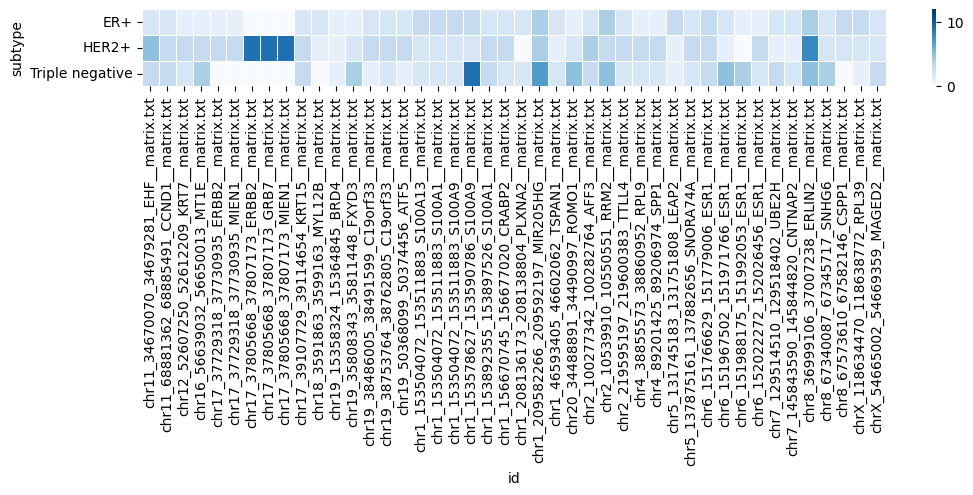

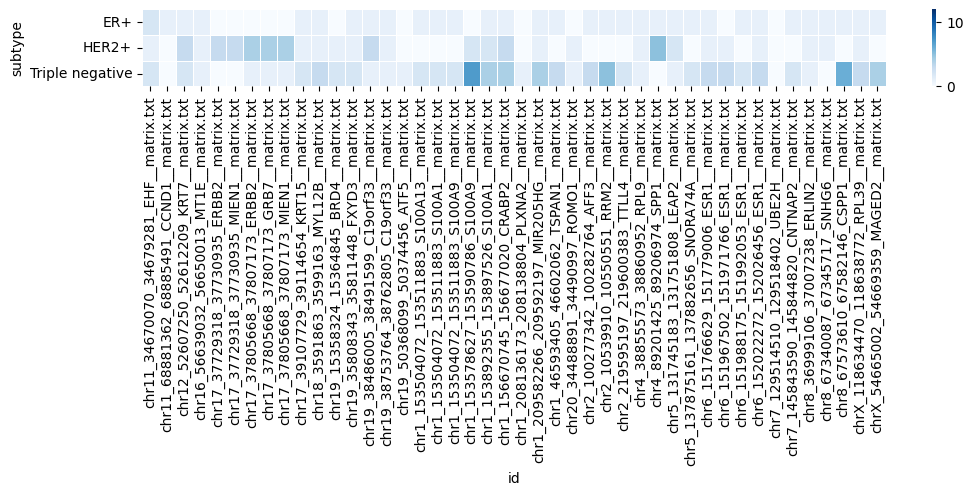

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

ICGC_positively_selected_mutated_plot = ICGC_positively_selected_mutated[['id', 'subtype', 'Hartwig_patient']]
ICGC_positively_selected_mutated_plot['ICGC_patient'] = ICGC_positively_selected_mutated_plot['Hartwig_patient'].fillna(0)

heatmap_data = ICGC_positively_selected_mutated_plot.pivot(index='subtype', columns='id', values='Hartwig_patient')
heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(12, 1))
sns.heatmap(heatmap_data, cmap='Blues', fmt=".1f",  linewidths=.5, vmax=12)
#plt.savefig('/home/darragh/New/heatmap_plot_1.pdf', format='pdf')

########

ICGC_positively_selected_mutated_plot = ICGC_positively_selected_mutated[['id', 'subtype', 'ICGC_patient']]
ICGC_positively_selected_mutated_plot['ICGC_patient'] = ICGC_positively_selected_mutated_plot['ICGC_patient'].fillna(0)
#ICGC_positively_selected_mutated_plot = ICGC_positively_selected_mutated_plot[ICGC_positively_selected_mutated_plot['subtype'] != 'Triple Negative']

heatmap_data = ICGC_positively_selected_mutated_plot.pivot(index='subtype', columns='id', values='ICGC_patient')
heatmap_data = heatmap_data.fillna(0)

plt.figure(figsize=(12, 1))
sns.heatmap(heatmap_data, cmap='Blues', fmt=".1f",  linewidths=.5, vmax=12)
#plt.savefig('/home/darragh/New/heatmap_plot_2.pdf', format='pdf')


In [ ]:
ERBB2 = read.table("/home/darragh/New/eQTL/output_data.txt", sep = "\t", header=T)


In [4]:
head(file, 20L)

id                                            p_value       FC        N 
1  chr19_11804156_11808939_ZNF625__matrix.txt     9.516232e-01 1.1537451  5
2  chr2_129056122_129068695_AMMECR1L__matrix.txt  6.681464e-02 0.7180233  8
3  chr1_204373879_204384120_SOX13__matrix.txt     4.492375e-01 1.0016155  6
4  chr1_153602516_153609162_S100A6__matrix.txt    1.397319e-39 1.4048147  8
5  chr7_94283224_94288622_CASD1__matrix.txt       4.022995e-03 0.6916743  5
6  chr19_18526581_18532647_GDF15__matrix.txt      2.295822e-03 1.4543269  5
7  chr17_73526703_73529313_MIF4GD__matrix.txt     1.015262e-03 1.0791985  6
8  chr16_85523287_85528954_KIAA0513__matrix.txt   3.567375e-01 0.9672131  5
9  chr1_233426706_233432113_NTPCR__matrix.txt     1.516469e-02 0.7425214 11
10 chr12_3322059_3329103_TSPAN9__matrix.txt       9.274337e-07 1.7031630  9
11 chr14_23338240_23343202_OXA1L__matrix.txt      3.884926e-01 1.1369903  9
12 chr1_202771639_202778201_TMEM183A__matrix.txt  3.381562e-01 0.9703417  8
13 chr13_47168997_47171870_LRCH1__matrix.txt      8.685955e-01 0.9646570  6
14 chr1_109813282_109821650_AMPD2__matrix.txt     4.960715e-01 1.1309237  5
15 chr7_115850091_115858638_CAV1__matrix.txt      1.341369e-01 1.1849192  9
16 chr17_37022995_37040819_RPL19__matrix.txt     1.410427e-246 0.7232963 16
17 chr1_153328349_153339211_ILF2__matrix.txt      6.056077e-02 1.4131064 12
18 chr20_23127531_23133892_THBD__matrix.txt       3.986946e-01 0.8877888 11
19 chr17_14200171_14214205_COX10__matrix.txt      7.044324e-01 1.0761994 11
20 chr6_97342822_97347200_NDUFAF4__matrix.txt     8.717716e-01 1.3613666  9
   q_value       log2FC      
1   1.000000e+00  0.206324486
2   1.000000e+00 -0.477897523
3   1.000000e+00  0.002328806
4   1.239562e-35  0.490379811
5   1.000000e+00 -0.531835261
6   1.000000e+00  0.540351614
7   1.000000e+00  0.109960212
8   1.000000e+00 -0.048094288
9   1.000000e+00 -0.429495552
10  8.227265e-03  0.768216528
11  1.000000e+00  0.185219971
12  1.000000e+00 -0.043435199
13  1.000000e+00 -0.051912089
14  1.000000e+00  0.177501592
15  1.000000e+00  0.244788697
16 1.251190e-242 -0.467341280
17  1.000000e+00  0.498870143
18  1.000000e+00 -0.171711621
19  1.000000e+00  0.105945455
20  1.000000e+00  0.445055644

In [116]:
from scipy.stats import rankdata

# def bh_correction(p_values):
#     n = len(p_values)
#     ranks = rankdata(p_values)
#     q_values = p_values * n / ranks
#     q_values = np.minimum.accumulate(q_values[::-1])[::-1]
#     return np.minimum(1, q_values)

# def bonferroni_correction(p_values):
#     num_tests = len(p_values)
#     corrected_p_values = np.minimum(1, num_tests * p_values)

#     return corrected_p_values

signif_df = pd.DataFrame(signif)
signif_df.columns = ['id', 'FC', 'p_value']

signif_df_signif = signif_df.loc[signif_df['p_value'] < 0.05]
signif_df_signif['log2FC'] = np.log2(signif_df_signif['FC'])

signif_df_signif = signif_df_signif.loc[signif_df_signif['log2FC'] > 3]

display(signif_df_signif)

/home/darragh/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1520049/1979428881.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_df_signif['log2FC'] = np.log2(signif_df_signif['FC'])


id         FC   p_value  \
614    chr17_37729318_37730935_PPP1R1B__matrix.txt  45.266667  0.014343   
8622     chr17_37729318_37730935_PGAP3__matrix.txt   9.864529  0.014172   
10205    chr17_36713465_36716168_PGAP3__matrix.txt  11.688150  0.007777   
13697     chr17_37829781_37834567_GRB7__matrix.txt  21.898058  0.008110   
17915   chrX_130710804_130713276_FIRRE__matrix.txt   8.301724  0.024046   
20634        chr11_8181368_8184551_HBB__matrix.txt  12.300000  0.045464   
21918    chr17_37829781_37834567_ERBB2__matrix.txt  10.863716  0.005285   
25090   chr7_102511949_102517747_CDHR3__matrix.txt   8.156463  0.036610   
25214    chr17_37829781_37834567_PGAP3__matrix.txt  10.765432  0.012467   
25607    chr17_36713465_36716168_ERBB2__matrix.txt  26.523171  0.013589   
27400   chr17_36713465_36716168_STARD3__matrix.txt  15.959450  0.011048   
31716    chr17_37729318_37730935_MIEN1__matrix.txt  14.462573  0.001294   
35985   chr17_37729318_37730935_STARD3__matrix.txt  12.862269  0.027942   
36036     chr17_37729318_37730935_GRB7__matrix.txt  36.629102  0.001959   
40440   chr17_37829781_37834567_STARD3__matrix.txt  14.124093  0.004597   
41314    chr17_37729318_37730935_ERBB2__matrix.txt  31.962458  0.001459   
42088       chr4_2794268_2804191_FGFR3__matrix.txt   8.820611  0.008183   
42380     chr4_41283067_41283686_UCHL1__matrix.txt   8.041667  0.027730   
46257     chr8_81278111_81280665_FABP5__matrix.txt   8.766173  0.041519   
50501    chr17_37829781_37834567_MIEN1__matrix.txt  14.219812  0.008167   
58823    chr17_36713465_36716168_MIEN1__matrix.txt  13.065407  0.006656   
63974   chr17_37805668_37807173_STARD3__matrix.txt  16.017442  0.000031   
66124   chr8_101454925_101457895_COX6C__matrix.txt  20.238494  0.013411   
75455     chr17_36713465_36716168_GRB7__matrix.txt  23.808878  0.010115   

         log2FC  
614    5.500377  
8622   3.302250  
10205  3.546975  
13697  4.452731  
17915  3.053411  
20634  3.620586  
21918  3.441446  
25090  3.027944  
25214  3.428334  
25607  4.729181  
27400  3.996339  
31716  3.854252  
35985  3.685073  
36036  5.194918  
40440  3.820086  
41314  4.998306  
42088  3.140879  
42380  3.007495  
46257  3.131947  
50501  3.829830  
58823  3.707680  
63974  4.001572  
66124  4.339030  
75455  4.573428

In [7]:
signif_df = pd.DataFrame(signif, columns = ['id', 'p_value_RNA'])
signif_df['chr'] = signif_df['id'].str.split('_').str[0]
signif_df['start'] = signif_df['id'].str.split('_').str[1]
signif_df['end'] = signif_df['id'].str.split('_').str[2]
signif_df['q_value_RNA'] = multipletests(signif_df['p_value_RNA'], method='fdr_bh')[1]
#signif_df['gene'] = signif_df['gene'].str.split('_').str[0]

#new_df = All_regs_annotated.merge(signif_df, on='gene')
signif_df.to_csv("/home/darragh/New/eQTL/All/output.txt", sep="\t")
display(signif_df)


id  p_value_RNA    chr  \
0             chr8_63076602_63078399_GGH__matrix.txt     0.856909   chr8   
1         chr19_11804156_11808939_ZNF625__matrix.txt     0.650788  chr19   
2          chr15_41147672_41159882_SPG11__matrix.txt     0.635473  chr15   
3      chr2_129056122_129068695_AMMECR1L__matrix.txt     0.047432   chr2   
4         chr17_38179847_38184207_IGFBP4__matrix.txt     0.296793  chr17   
...                                              ...          ...    ...   
77776         chr11_8181368_8184551_IPO7__matrix.txt     0.532929  chr11   
77777       chr11_10612037_10617534_SBF2__matrix.txt     0.611830  chr11   
77778    chr10_122174509_122176603_HTRA1__matrix.txt     0.863520  chr10   
77779     chr11_65336207_65345973_B3GAT3__matrix.txt     0.252717  chr11   
77780       chr8_48767937_48769444_SPIDR__matrix.txt     0.509968   chr8   

           start        end  q_value_RNA  
0       63076602   63078399     0.994983  
1       11804156   11808939     0.981360  
2       41147672   41159882     0.980543  
3      129056122  129068695     0.808600  
4       38179847   38184207     0.955608  
...          ...        ...          ...  
77776    8181368    8184551     0.975812  
77777   10612037   10617534     0.979830  
77778  122174509  122176603     0.995237  
77779   65336207   65345973     0.952134  
77780   48767937   48769444     0.975378  

[77781 rows x 6 columns]

In [9]:
signif = signif_df.loc[signif_df['q_value_RNA'] < 0.1]

display(signif)

id  p_value_RNA    chr  \
401          chr8_81278244_81280612_FABP5__matrix.txt     0.000001   chr8   
1209   chr12_112194392_112197489_ANKRD13A__matrix.txt     0.000151  chr12   
1671        chr14_21098388_21101794_NDRG2__matrix.txt     0.000127  chr14   
2505       chr11_67005888_67011413_NDUFS8__matrix.txt     0.000038  chr11   
2750       chr22_50324296_50331511_RABL2B__matrix.txt     0.000006  chr22   
...                                               ...          ...    ...   
74250      chr12_6440102_6452824_CD27-AS1__matrix.txt     0.000100  chr12   
76482      chr14_105131257_105134396_INF2__matrix.txt     0.000028  chr14   
76709       chr12_76411353_76418038_CSRP2__matrix.txt     0.000007  chr12   
77364      chr17_55974998_55982949_MRPS23__matrix.txt     0.000104  chr17   
77730     chr10_102818472_102828384_SFXN2__matrix.txt     0.000004  chr10   

           start        end  q_value_RNA  
401     81278244   81280612     0.005368  
1209   112194392  112197489     0.097954  
1671    21098388   21101794     0.090880  
2505    67005888   67011413     0.054990  
2750    50324296   50331511     0.020568  
...          ...        ...          ...  
74250    6440102    6452824     0.078007  
76482  105131257  105134396     0.046616  
76709   76411353   76418038     0.022429  
77364   55974998   55982949     0.079397  
77730  102818472  102828384     0.019160  

[120 rows x 6 columns]

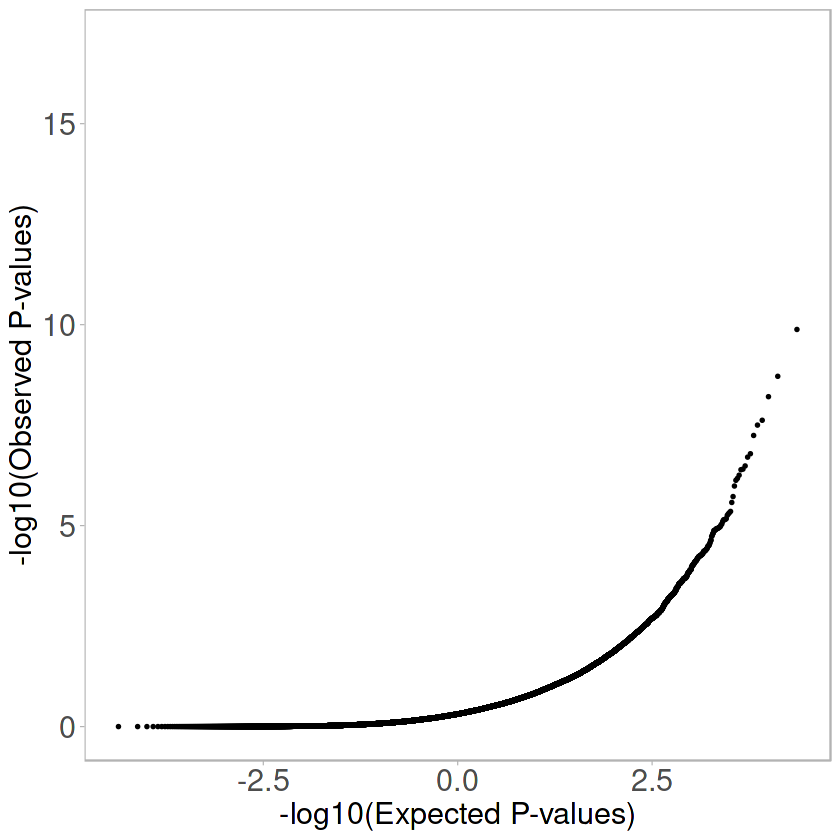

In [5]:
library(ggplot2)

All = read.table("/home/darragh/New/eQTL/All/output.txt", sep="\t", header=T)

ggplot(All, aes(sample = -log10(p_value_RNA))) + stat_qq(size=0.5)  + coord_cartesian(ylim = c(0,17) ) +
theme_light() +
 theme(axis.text = element_text(size = 18), axis.title.x = element_text(size = 18), axis.title.y = element_text(size = 18), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position="none") +
 xlab("-log10(Expected P-values)") +
  ylab("-log10(Observed P-values)") 

# ER

In [72]:
All_regs_annotated_bed = pybed.BedTool.from_dataframe(ER)

#Mutation data
Genes = pybed.BedTool("/index/hg19/hg19_exons.bed")
Hartwig = pd.read_table("/home/darragh/New/DriverPower/mutation/Hartwig_ER.txt", header=0)
#Hartwig = Hartwig[['chr', 'start', 'end', 'ref', 'alt','sampleId']]
Hartwig.columns = ['chr', 'start', 'end', 'ref', 'alt','sampleId']
Hartwig['sampleId'] = Hartwig['sampleId'].str.split('.').str[0]

Hartwig = Hartwig[Hartwig['ref'].str.len() < 2]
Hartwig = Hartwig[Hartwig['alt'].str.len() < 2]
Hartwig = Hartwig.loc[Hartwig['ref'] != "-"]
Hartwig = Hartwig.loc[Hartwig['alt'] != "-"]

Hartwig = pybed.BedTool.from_dataframe(Hartwig)
Hartwig = Hartwig.sort()

Mutated_reg_elements_mutations = All_regs_annotated_bed.intersect(Hartwig, wa=True, wb=True)
Mutated_reg_elements_mutations = pd.read_table(Mutated_reg_elements_mutations.fn, header=None)
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.iloc[:, [0,1,2,3,4,10]]
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.drop_duplicates()
Mutated_reg_elements_mutations.columns = ['chr', 'start', 'end', 'id', 'gene', 'patient']

display(Mutated_reg_elements_mutations)

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr      start        end                        id       gene  \
0       chr1     858733     861980        chr1_858733_861980  LINC00115   
1       chr1     858733     861980        chr1_858733_861980  LINC00115   
2       chr1     858733     861980        chr1_858733_861980  LINC00115   
3       chr1     858733     861980        chr1_858733_861980  LINC00115   
4       chr1     858733     861980        chr1_858733_861980  LINC00115   
...      ...        ...        ...                       ...        ...   
960221  chrX  155110375  155111882  chrX_155110375_155111882      VAMP7   
960222  chrX  155110375  155111882  chrX_155110375_155111882      VAMP7   
960223  chrX  155110375  155111882  chrX_155110375_155111882      VAMP7   
960224  chrX  155110375  155111882  chrX_155110375_155111882      VAMP7   
960225  chrX  155110375  155111882  chrX_155110375_155111882      VAMP7   

              patient  
0       CPCT02040055T  
1       CPCT02010520T  
2       CPCT02210039T  
3       CPCT02390015T  
4       CPCT02020344T  
...               ...  
960221  CPCT02040036T  
960222  CPCT02030451T  
960223  CPCT02010682T  
960224  CPCT02390008T  
960225  CPCT02011013T  

[874547 rows x 6 columns]

In [73]:
Hartwig_RNA = pd.read_table("/home/darragh/New/hartwig_breast_RNA_gene_ids_2.txt",header=0)
Hartwig_RNA.index = Hartwig_RNA.gene
del Hartwig_RNA['gene']
display(Hartwig_RNA)

CPCT02080001TII  CPCT02100048T  CPCT02020493TII  CPCT02010267TII  \
gene                                                                         
TSPAN6          -0.039405      -0.290391         0.106167        -0.727106   
DPM1            -0.255361      -0.152882         0.486481         0.296348   
SCYL3            0.516510      -1.119971        -0.443231        -0.428875   
C1orf112        -0.099671      -0.545760         0.444445        -0.383804   
FGR              0.276425      -0.559696         0.691294        -0.358644   
...                   ...            ...              ...              ...   
CDR1             1.542089       0.075975        -0.312887         0.356889   
ACTL10           0.506234      -0.960675         1.150785        -0.167951   
PANO1            0.601589      -0.168276        -0.360742        -0.287422   
PRRC2B           1.241604      -0.125871        -0.711797        -0.254248   
F8A1             0.480327      -1.043724        -0.392827         1.045232   

          CPCT02100043T  CPCT02080036T  CPCT02080070T  CPCT02040035T  \
gene                                                                   
TSPAN6         0.183973      -0.385765      -0.099641      -0.727106   
DPM1          -0.516391      -0.028490       0.434920      -0.706524   
SCYL3         -0.350948      -0.383759      -0.672912       0.411923   
C1orf112      -0.534394      -0.201958       0.107747       0.533947   
FGR           -0.148018      -0.227801       0.771076      -0.492679   
...                 ...            ...            ...            ...   
CDR1           0.100295       0.727636      -0.122054      -0.238936   
ACTL10         0.017264      -0.579130      -0.264264       0.802579   
PANO1          0.739065       0.794055      -0.342412       0.729900   
PRRC2B        -0.605286       1.006011      -0.447048       0.496265   
F8A1          -0.623023      -0.108391       0.107252      -0.341232   

          CPCT02070168T  CPCT02050053T  ...  CPCT02370003T  CPCT02010726T  \
gene                                    ...                                 
TSPAN6        -0.109681       0.668375  ...      -0.132269      -0.132269   
DPM1           0.296993      -0.241826  ...      -0.484809      -0.429381   
SCYL3          0.446785      -0.252513  ...      -0.125368       0.772851   
C1orf112      -0.075519      -0.382383  ...      -0.238896       0.052341   
FGR           -0.690539      -0.783087  ...      -0.457574       0.483859   
...                 ...            ...  ...            ...            ...   
CDR1          -0.336959       1.433148  ...      -0.257796      -0.258045   
ACTL10        -0.549496      -0.749529  ...      -1.097734      -0.060526   
PANO1         -0.232431       0.070015  ...      -0.635694      -0.113286   
PRRC2B        -0.173600       0.410445  ...      -1.049433      -0.172190   
F8A1          -0.210259       0.042427  ...      -0.834696      -0.379598   

          CPCT02330076T  CPCT02050060T  CPCT02120029T  CPCT02050299T  \
gene                                                                   
TSPAN6        -1.126173      -0.606633       0.874183      -0.958013   
DPM1          -1.823476      -0.761308      -0.265028      -0.193487   
SCYL3         -1.796711       0.385263      -0.607289       1.262975   
C1orf112      -1.436517      -0.437789      -0.281516       0.249813   
FGR           -1.166043       2.226309      -0.438427       7.332390   
...                 ...            ...            ...            ...   
CDR1          -0.498013       0.737811      -0.441681      -0.367482   
ACTL10        -1.464461      -0.134613       0.491417       0.150620   
PANO1         -1.093947       4.295107       0.152501      -0.296587   
PRRC2B        -1.988749       1.053271       0.261847       1.572422   
F8A1          -1.709174      -0.832050       0.111221      -0.252593   

          CPCT02020377T  CPCT02170018T  CPCT02080170T  CPCT02220029T  
gene                                            

In [74]:
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[Mutated_reg_elements_mutations.patient.isin(Hartwig_RNA.columns)]
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[Mutated_reg_elements_mutations.gene.isin(Hartwig_RNA.index)]
number = Mutated_reg_elements_mutations.groupby(['chr', 'start','end','id', 'gene'])['patient'].size().reset_index()
number = number[['id','patient']]
number.columns = ['id', 'number']
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.merge(number, on='id',how='outer')
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.drop_duplicates()
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.loc[Mutated_reg_elements_mutations['number'] > 4]
#Mutated_reg_elements_mutations['id'] = Mutated_reg_elements_mutations['id'] + '_' +Mutated_reg_elements_mutations['annotation']
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[['chr', 'start','end','id','gene','patient']]
display(Mutated_reg_elements_mutations)
# Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.loc[Mutated_reg_elements_mutations['patient'] > 8]
# Mutated_reg_elements_mutations['mutated'] = 1
# display(Mutated_reg_elements_mutations)

chr      start        end                        id   gene  \
204      chr1  200707299  200710865  chr1_200707299_200710865  KIF14   
207      chr1  200707299  200710865  chr1_200707299_200710865  KIF14   
210      chr1  200707299  200710865  chr1_200707299_200710865  KIF14   
213      chr1  200707299  200710865  chr1_200707299_200710865  KIF14   
216      chr1  200707299  200710865  chr1_200707299_200710865  KIF14   
...       ...        ...        ...                       ...    ...   
5159781  chrX  153767429  153777633  chrX_153767429_153777633  IKBKG   
5159782  chrX  153767429  153777633  chrX_153767429_153777633  IKBKG   
5159783  chrX  153767429  153777633  chrX_153767429_153777633  IKBKG   
5159784  chrX  153767429  153777633  chrX_153767429_153777633  IKBKG   
5159785  chrX  153767429  153777633  chrX_153767429_153777633  IKBKG   

               patient  
204      CPCT02020436T  
207      CPCT02010419T  
210      CPCT02010746T  
213      CPCT02210010T  
216      CPCT02010447T  
...                ...  
5159781  CPCT02080047T  
5159782  CPCT02120029T  
5159783  CPCT02080060T  
5159784  CPCT02080170T  
5159785  CPCT02010520T  

[73073 rows x 6 columns]

In [75]:
All_hartwig = pd.DataFrame()
All_hartwig['patient'] = Hartwig_RNA.columns
All_hartwig['mutated'] = 0
display(All_hartwig)

patient  mutated
0    CPCT02080001TII        0
1      CPCT02100048T        0
2    CPCT02020493TII        0
3    CPCT02010267TII        0
4      CPCT02100043T        0
..               ...      ...
325    CPCT02050299T        0
326    CPCT02020377T        0
327    CPCT02170018T        0
328    CPCT02080170T        0
329    CPCT02220029T        0

[330 rows x 2 columns]

In [76]:
#Add RNA Data

dfs = []

for element, df_element in Mutated_reg_elements_mutations.groupby(['id','gene']):
    df_element = df_element[['id' ,'gene', 'patient']]
    Not_mutated = All_hartwig[~All_hartwig.patient.isin(df_element.patient)]
    Not_mutated['gene'] = df_element['gene'].iat[0]
    Not_mutated['id'] = df_element['id'].iat[0]
    df_element = pd.concat([df_element,Not_mutated]).reset_index()
    df_element = df_element.drop_duplicates()
    df_element['mutated'] = df_element['mutated'].replace(np.nan, 1)
    dfs.append(df_element)

df_RNA = pd.concat(dfs)

df_RNA = df_RNA.merge(pd.melt(Hartwig_RNA.reset_index(), id_vars="gene", var_name="patient", value_name="RNA"), on=["gene", "patient"])

display(df_RNA) 

/tmp/ipykernel_2655392/2713383392.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Not_mutated['gene'] = df_element['gene'].iat[0]
/tmp/ipykernel_2655392/2713383392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Not_mutated['id'] = df_element['id'].iat[0]


index                         id   gene        patient  mutated  \
0          92988  chr10_101189420_101191798   GOT1  CPCT02080053T      1.0   
1        1064306  chr10_102124047_102125501   GOT1  CPCT02080053T      1.0   
2          92989  chr10_101189420_101191798   GOT1  CPCT02120024T      1.0   
3            264  chr10_102124047_102125501   GOT1  CPCT02120024T      0.0   
4          92990  chr10_101189420_101191798   GOT1  CPCT02380024T      1.0   
...          ...                        ...    ...            ...      ...   
3453775      325       chrX_9753460_9755882  ANOS1  CPCT02050299T      0.0   
3453776      326       chrX_9753460_9755882  ANOS1  CPCT02020377T      0.0   
3453777      327       chrX_9753460_9755882  ANOS1  CPCT02170018T      0.0   
3453778      328       chrX_9753460_9755882  ANOS1  CPCT02080170T      0.0   
3453779      329       chrX_9753460_9755882  ANOS1  CPCT02220029T      0.0   

              RNA  
0       -0.576873  
1       -0.576873  
2       -0.704426  
3       -0.704426  
4        2.168449  
...           ...  
3453775  1.054271  
3453776 -0.776717  
3453777 -0.574940  
3453778 -0.352713  
3453779 -0.618567  

[3453780 rows x 6 columns]

In [77]:
#Process and add CNA data
#awk '{print $6}' /home/darragh/New/CADD/Hartwig/All_Hartwig_CADD_10.txt | sort | uniq > Hartwig_breast_patients
#for file in $(cat Hartwig_breast_patients); do mv "$file.purple.cnv.gene.tsv" /home/darragh/New/WGS/Hartwig/CNA/breast/$file.purple.cnv.gene.tsv; done

dfs = []  
Hartwig_gene_CNA_data = glob.glob('/home/darragh/New/WGS/Hartwig/CNA/breast/*.purple.cnv.gene.tsv')
for file in Hartwig_gene_CNA_data:
    Patient_CNA_df = pd.read_table(file)
    Patient_CNA_df['CopyNumber'] = (Patient_CNA_df['minCopyNumber'] + Patient_CNA_df['maxCopyNumber'])/2
    Patient_CNA_df = Patient_CNA_df[['gene', 'CopyNumber']]
    Patient_CNA_df.columns = ["gene", os.path.basename(file).split(".")[0]]
    Patient_CNA_df.reset_index()
    dfs.append(Patient_CNA_df)

df_CNA = reduce(lambda df1,df2: pd.merge(df1,df2,on='gene'), dfs)

df_CNA.index = df_CNA.gene
del df_CNA['gene']

Final_df = df_RNA.merge(pd.melt(df_CNA.reset_index(), id_vars="gene", var_name="patient", value_name="CNA"), on=["gene", "patient"])
display(Final_df)

index                         id   gene        patient  mutated  \
0          92988  chr10_101189420_101191798   GOT1  CPCT02080053T      1.0   
1        1064306  chr10_102124047_102125501   GOT1  CPCT02080053T      1.0   
2          92989  chr10_101189420_101191798   GOT1  CPCT02120024T      1.0   
3            264  chr10_102124047_102125501   GOT1  CPCT02120024T      0.0   
4          92990  chr10_101189420_101191798   GOT1  CPCT02380024T      1.0   
...          ...                        ...    ...            ...      ...   
3271242      325     chrX_78093837_78095574  TAF9B  CPCT02050299T      0.0   
3271243      326     chrX_78093837_78095574  TAF9B  CPCT02020377T      0.0   
3271244      327     chrX_78093837_78095574  TAF9B  CPCT02170018T      0.0   
3271245      328     chrX_78093837_78095574  TAF9B  CPCT02080170T      0.0   
3271246      329     chrX_78093837_78095574  TAF9B  CPCT02220029T      0.0   

              RNA     CNA  
0       -0.576873  2.0407  
1       -0.576873  2.0407  
2       -0.704426  2.0132  
3       -0.704426  2.0132  
4        2.168449  4.0042  
...           ...     ...  
3271242  0.021842  1.9372  
3271243 -1.738917  2.0084  
3271244 -0.386514  2.9918  
3271245 -0.261373  1.9481  
3271246  0.715607  2.9086  

[3271247 rows x 7 columns]

In [16]:
#Write each each gene to s seperate df

for element, df_element in Final_df.groupby(['id', 'gene']):
    df_element.to_csv("/home/darragh/New/eQTL/All/matrixes/" + df_element['id'].iat[0] + '_'  + df_element['gene'].iat[0] + '_'  + "_matrix.txt" ,sep = "\t" , header=True, index=False)



KeyboardInterrupt: 

In [ ]:
import statsmodels.formula.api as smf

signif = []
dir = glob.glob('/home/darragh/New/eQTL/ER/matrixes/*_matrix.txt')

for file in dir:
    pandas = pd.read_table(file)
    #quant = pandas.groupby(["id","mutated"])["RNA"].quantile([0.95])[0]#.unstack(level=1)

    pandas = pandas.drop(pandas[(pandas['RNA'] > 3) | (pandas['RNA'] < -3)].index)
    #pandas = pandas.drop(pandas[ (pandas['RNA'] > quant)].index)

    mod = smf.ols(formula='RNA ~ CNA + mutated', data=pandas)
    res = mod.fit()

    if res.pvalues['mutated'] < 10:
        signif.append([os.path.basename(file), res.pvalues['mutated'] ])

        print(file)

    #break


/home/darragh/New/eQTL/ER/matrixes/chr11_62605575_62610296_SNHG1__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr2_129056122_129068695_AMMECR1L__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr8_141597903_141602540_CHRAC1__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr19_13943622_13965525_AKAP8L__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr11_67894063_67897158_NDUFS8__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr3_149101510_149114964_TSC22D2__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr19_797270_802393_FSTL3__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr7_6421640_6427851_ZDHHC4__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr2_129046187_129052102_IWS1__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr11_126269582_126281634_EI24__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr15_93440631_93453048_AP3S2__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr7_64457840_64459852_ZNF117__matrix.txt
/home/darragh/New/eQTL/ER/matrixes/chr19_13271140_13284113_ZNF799__mat

In [85]:
signif_df = pd.DataFrame(signif, columns = ['id', 'p_value_RNA'])
signif_df['chr'] = signif_df['id'].str.split('_').str[0]
signif_df['start'] = signif_df['id'].str.split('_').str[1]
signif_df['end'] = signif_df['id'].str.split('_').str[2]
signif_df['q_value_RNA'] = multipletests(signif_df['p_value_RNA'], method='fdr_bh')[1]
#signif_df['gene'] = signif_df['gene'].str.split('_').str[0]

#new_df = All_regs_annotated.merge(signif_df, on='gene')
signif_df.to_csv("/home/darragh/New/eQTL/ER/output.txt", sep="\t")
display(signif_df)


id  p_value_RNA    chr  \
0         chr11_62605575_62610296_SNHG1__matrix.txt     0.096216  chr11   
1     chr2_129056122_129068695_AMMECR1L__matrix.txt     0.624661   chr2   
2       chr8_141597903_141602540_CHRAC1__matrix.txt     0.418465   chr8   
3        chr19_13943622_13965525_AKAP8L__matrix.txt     0.026372  chr19   
4        chr11_67894063_67897158_NDUFS8__matrix.txt     0.040287  chr11   
...                                             ...          ...    ...   
9928        chr17_7787278_7793402_ZBTB4__matrix.txt     0.595429  chr17   
9929       chr8_67024767_67027970_NCOA2__matrix.txt     0.364554   chr8   
9930      chr15_39919969_39924226_THBS1__matrix.txt     0.242792  chr15   
9931     chr1_230886323_230889977_TSNAX__matrix.txt     0.172493   chr1   
9932       chr8_74242469_74243762_STAU2__matrix.txt     0.109478   chr8   

          start        end  q_value_RNA  
0      62605575   62610296     0.875890  
1     129056122  129068695     0.994565  
2     141597903  141602540     0.994565  
3      13943622   13965525     0.717691  
4      67894063   67897158     0.771041  
...         ...        ...          ...  
9928    7787278    7793402     0.994565  
9929   67024767   67027970     0.990730  
9930   39919969   39924226     0.957507  
9931  230886323  230889977     0.934398  
9932   74242469   74243762     0.875890  

[9933 rows x 6 columns]

In [86]:
signif = signif_df.loc[signif_df['q_value_RNA'] < 0.1]

display(signif)

Empty DataFrame
Columns: [id, p_value_RNA, chr, start, end, q_value_RNA]
Index: []

# TN

In [87]:
All_regs_annotated_bed = pybed.BedTool.from_dataframe(TN)

#Mutation data
Genes = pybed.BedTool("/index/hg19/hg19_exons.bed")
Hartwig = pd.read_table("/home/darragh/New/DriverPower/mutation/Hartwig_TN.txt", header=0)
#Hartwig = Hartwig[['chr', 'start', 'end', 'ref', 'alt','sampleId']]
Hartwig.columns = ['chr', 'start', 'end', 'ref', 'alt','sampleId']
Hartwig['sampleId'] = Hartwig['sampleId'].str.split('.').str[0]

Hartwig = Hartwig[Hartwig['ref'].str.len() < 2]
Hartwig = Hartwig[Hartwig['alt'].str.len() < 2]
Hartwig = Hartwig.loc[Hartwig['ref'] != "-"]
Hartwig = Hartwig.loc[Hartwig['alt'] != "-"]

Hartwig = pybed.BedTool.from_dataframe(Hartwig)
Hartwig = Hartwig.sort()

Mutated_reg_elements_mutations = All_regs_annotated_bed.intersect(Hartwig, wa=True, wb=True)
Mutated_reg_elements_mutations = pd.read_table(Mutated_reg_elements_mutations.fn, header=None)
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.iloc[:, [0,1,2,3,4,10]]
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.drop_duplicates()
Mutated_reg_elements_mutations.columns = ['chr', 'start', 'end', 'id', 'gene', 'patient']

display(Mutated_reg_elements_mutations)

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr      start        end                        id   gene  \
0       chr1  160982557  160991041  chr1_160982557_160991041   CD48   
1       chr1  160982557  160991041  chr1_160982557_160991041   CD48   
2       chr1  160982557  160991041  chr1_160982557_160991041   CD48   
3       chr1  160982557  160991041  chr1_160982557_160991041   CD48   
4       chr1  160982557  160991041  chr1_160982557_160991041   CD48   
...      ...        ...        ...                       ...    ...   
462206  chrX  154443844  154446295  chrX_154443844_154446295   VBP1   
462207  chrY   21152510   21155211    chrY_21152510_21155211  HSFY2   
462208  chrY   21152510   21155211    chrY_21152510_21155211  HSFY2   
462209  chrY   21152510   21155211    chrY_21152510_21155211  HSFY2   
462210  chrY   21152510   21155211    chrY_21152510_21155211  HSFY2   

                patient  
0         CPCT02050285T  
1       CPCT02010326TII  
2         CPCT02220029T  
3         CPCT02080216T  
4         CPCT02010863T  
...                 ...  
462206    CPCT02220029T  
462207    CPCT02060059T  
462208    CPCT02010337T  
462209    CPCT02220060T  
462210    CPCT02230089T  

[434356 rows x 6 columns]

In [88]:
Hartwig_RNA = pd.read_table("/home/darragh/New/hartwig_breast_RNA_gene_ids_2.txt",header=0)
Hartwig_RNA.index = Hartwig_RNA.gene
del Hartwig_RNA['gene']
display(Hartwig_RNA)

CPCT02080001TII  CPCT02100048T  CPCT02020493TII  CPCT02010267TII  \
gene                                                                         
TSPAN6          -0.039405      -0.290391         0.106167        -0.727106   
DPM1            -0.255361      -0.152882         0.486481         0.296348   
SCYL3            0.516510      -1.119971        -0.443231        -0.428875   
C1orf112        -0.099671      -0.545760         0.444445        -0.383804   
FGR              0.276425      -0.559696         0.691294        -0.358644   
...                   ...            ...              ...              ...   
CDR1             1.542089       0.075975        -0.312887         0.356889   
ACTL10           0.506234      -0.960675         1.150785        -0.167951   
PANO1            0.601589      -0.168276        -0.360742        -0.287422   
PRRC2B           1.241604      -0.125871        -0.711797        -0.254248   
F8A1             0.480327      -1.043724        -0.392827         1.045232   

          CPCT02100043T  CPCT02080036T  CPCT02080070T  CPCT02040035T  \
gene                                                                   
TSPAN6         0.183973      -0.385765      -0.099641      -0.727106   
DPM1          -0.516391      -0.028490       0.434920      -0.706524   
SCYL3         -0.350948      -0.383759      -0.672912       0.411923   
C1orf112      -0.534394      -0.201958       0.107747       0.533947   
FGR           -0.148018      -0.227801       0.771076      -0.492679   
...                 ...            ...            ...            ...   
CDR1           0.100295       0.727636      -0.122054      -0.238936   
ACTL10         0.017264      -0.579130      -0.264264       0.802579   
PANO1          0.739065       0.794055      -0.342412       0.729900   
PRRC2B        -0.605286       1.006011      -0.447048       0.496265   
F8A1          -0.623023      -0.108391       0.107252      -0.341232   

          CPCT02070168T  CPCT02050053T  ...  CPCT02370003T  CPCT02010726T  \
gene                                    ...                                 
TSPAN6        -0.109681       0.668375  ...      -0.132269      -0.132269   
DPM1           0.296993      -0.241826  ...      -0.484809      -0.429381   
SCYL3          0.446785      -0.252513  ...      -0.125368       0.772851   
C1orf112      -0.075519      -0.382383  ...      -0.238896       0.052341   
FGR           -0.690539      -0.783087  ...      -0.457574       0.483859   
...                 ...            ...  ...            ...            ...   
CDR1          -0.336959       1.433148  ...      -0.257796      -0.258045   
ACTL10        -0.549496      -0.749529  ...      -1.097734      -0.060526   
PANO1         -0.232431       0.070015  ...      -0.635694      -0.113286   
PRRC2B        -0.173600       0.410445  ...      -1.049433      -0.172190   
F8A1          -0.210259       0.042427  ...      -0.834696      -0.379598   

          CPCT02330076T  CPCT02050060T  CPCT02120029T  CPCT02050299T  \
gene                                                                   
TSPAN6        -1.126173      -0.606633       0.874183      -0.958013   
DPM1          -1.823476      -0.761308      -0.265028      -0.193487   
SCYL3         -1.796711       0.385263      -0.607289       1.262975   
C1orf112      -1.436517      -0.437789      -0.281516       0.249813   
FGR           -1.166043       2.226309      -0.438427       7.332390   
...                 ...            ...            ...            ...   
CDR1          -0.498013       0.737811      -0.441681      -0.367482   
ACTL10        -1.464461      -0.134613       0.491417       0.150620   
PANO1         -1.093947       4.295107       0.152501      -0.296587   
PRRC2B        -1.988749       1.053271       0.261847       1.572422   
F8A1          -1.709174      -0.832050       0.111221      -0.252593   

          CPCT02020377T  CPCT02170018T  CPCT02080170T  CPCT02220029T  
gene                                            

In [89]:
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[Mutated_reg_elements_mutations.patient.isin(Hartwig_RNA.columns)]
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[Mutated_reg_elements_mutations.gene.isin(Hartwig_RNA.index)]
number = Mutated_reg_elements_mutations.groupby(['chr', 'start','end','id', 'gene'])['patient'].size().reset_index()
number = number[['id','patient']]
number.columns = ['id', 'number']
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.merge(number, on='id',how='outer')
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.drop_duplicates()
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.loc[Mutated_reg_elements_mutations['number'] > 4]
#Mutated_reg_elements_mutations['id'] = Mutated_reg_elements_mutations['id'] + '_' +Mutated_reg_elements_mutations['annotation']
Mutated_reg_elements_mutations = Mutated_reg_elements_mutations[['chr', 'start','end','id','gene','patient']]
display(Mutated_reg_elements_mutations)
# Mutated_reg_elements_mutations = Mutated_reg_elements_mutations.loc[Mutated_reg_elements_mutations['patient'] > 8]
# Mutated_reg_elements_mutations['mutated'] = 1
# display(Mutated_reg_elements_mutations)

chr      start        end                        id  gene  \
43733    chr19   13943657   13967022   chr19_13943657_13967022  MRI1   
43774    chr19   13943657   13967022   chr19_13943657_13967022  MRI1   
43815    chr19   13943657   13967022   chr19_13943657_13967022  MRI1   
43856    chr19   13943657   13967022   chr19_13943657_13967022  MRI1   
43897    chr19   13943657   13967022   chr19_13943657_13967022  MRI1   
...        ...        ...        ...                       ...   ...   
2716539   chr7  116037878  116042620  chr7_116037878_116042620  CAV2   
2716540   chr7  116037878  116042620  chr7_116037878_116042620  CAV2   
2716541   chr7  116037878  116042620  chr7_116037878_116042620  CAV2   
2716542   chr7  116037878  116042620  chr7_116037878_116042620  CAV2   
2716543   chr7  116037878  116042620  chr7_116037878_116042620  CAV2   

                 patient  
43733      CPCT02370003T  
43774      CPCT02010461T  
43815      CPCT02060059T  
43856      CPCT02160037T  
43897      CPCT02010708T  
...                  ...  
2716539    CPCT02100048T  
2716540    CPCT02060059T  
2716541  CPCT02010326TII  
2716542    CPCT02100020T  
2716543    CPCT02020385T  

[1769 rows x 6 columns]

In [90]:
All_hartwig = pd.DataFrame()
All_hartwig['patient'] = Hartwig_RNA.columns
All_hartwig['mutated'] = 0
display(All_hartwig)

patient  mutated
0    CPCT02080001TII        0
1      CPCT02100048T        0
2    CPCT02020493TII        0
3    CPCT02010267TII        0
4      CPCT02100043T        0
..               ...      ...
325    CPCT02050299T        0
326    CPCT02020377T        0
327    CPCT02170018T        0
328    CPCT02080170T        0
329    CPCT02220029T        0

[330 rows x 2 columns]

In [91]:
#Add RNA Data

dfs = []

for element, df_element in Mutated_reg_elements_mutations.groupby(['id','gene']):
    df_element = df_element[['id' ,'gene', 'patient']]
    Not_mutated = All_hartwig[~All_hartwig.patient.isin(df_element.patient)]
    Not_mutated['gene'] = df_element['gene'].iat[0]
    Not_mutated['id'] = df_element['id'].iat[0]
    df_element = pd.concat([df_element,Not_mutated]).reset_index()
    df_element = df_element.drop_duplicates()
    df_element['mutated'] = df_element['mutated'].replace(np.nan, 1)
    dfs.append(df_element)

df_RNA = pd.concat(dfs)

df_RNA = df_RNA.merge(pd.melt(Hartwig_RNA.reset_index(), id_vars="gene", var_name="patient", value_name="RNA"), on=["gene", "patient"])

display(df_RNA) 

/tmp/ipykernel_2655392/2713383392.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Not_mutated['gene'] = df_element['gene'].iat[0]
/tmp/ipykernel_2655392/2713383392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Not_mutated['id'] = df_element['id'].iat[0]


index                       id   gene        patient  mutated  \
0       2248872  chr10_29875627_29880115  ACBD5  CPCT02120073T      1.0   
1       2248889  chr10_29875627_29880115  ACBD5  CPCT02370003T      1.0   
2       2248906  chr10_29875627_29880115  ACBD5  CPCT02220026T      1.0   
3       2248923  chr10_29875627_29880115  ACBD5  CPCT02340049T      1.0   
4       2248940  chr10_29875627_29880115  ACBD5  CPCT02050160T      1.0   
...         ...                      ...    ...            ...      ...   
103615      324   chr9_26258421_26268461  TUSC1  CPCT02120029T      0.0   
103616      325   chr9_26258421_26268461  TUSC1  CPCT02050299T      0.0   
103617      326   chr9_26258421_26268461  TUSC1  CPCT02020377T      0.0   
103618      327   chr9_26258421_26268461  TUSC1  CPCT02170018T      0.0   
103619      328   chr9_26258421_26268461  TUSC1  CPCT02080170T      0.0   

             RNA  
0       0.549045  
1       0.168836  
2       1.886618  
3       0.948402  
4      -2.314837  
...          ...  
103615  0.909788  
103616 -0.357075  
103617 -1.503398  
103618  0.278720  
103619 -0.884147  

[103620 rows x 6 columns]

In [92]:
#Process and add CNA data
#awk '{print $6}' /home/darragh/New/CADD/Hartwig/All_Hartwig_CADD_10.txt | sort | uniq > Hartwig_breast_patients
#for file in $(cat Hartwig_breast_patients); do mv "$file.purple.cnv.gene.tsv" /home/darragh/New/WGS/Hartwig/CNA/breast/$file.purple.cnv.gene.tsv; done

dfs = []  
Hartwig_gene_CNA_data = glob.glob('/home/darragh/New/WGS/Hartwig/CNA/breast/*.purple.cnv.gene.tsv')
for file in Hartwig_gene_CNA_data:
    Patient_CNA_df = pd.read_table(file)
    Patient_CNA_df['CopyNumber'] = (Patient_CNA_df['minCopyNumber'] + Patient_CNA_df['maxCopyNumber'])/2
    Patient_CNA_df = Patient_CNA_df[['gene', 'CopyNumber']]
    Patient_CNA_df.columns = ["gene", os.path.basename(file).split(".")[0]]
    Patient_CNA_df.reset_index()
    dfs.append(Patient_CNA_df)

df_CNA = reduce(lambda df1,df2: pd.merge(df1,df2,on='gene'), dfs)

df_CNA.index = df_CNA.gene
del df_CNA['gene']

Final_df = df_RNA.merge(pd.melt(df_CNA.reset_index(), id_vars="gene", var_name="patient", value_name="CNA"), on=["gene", "patient"])
display(Final_df)

index                       id   gene        patient  mutated  \
0      2248872  chr10_29875627_29880115  ACBD5  CPCT02120073T      1.0   
1      2248889  chr10_29875627_29880115  ACBD5  CPCT02370003T      1.0   
2      2248906  chr10_29875627_29880115  ACBD5  CPCT02220026T      1.0   
3      2248923  chr10_29875627_29880115  ACBD5  CPCT02340049T      1.0   
4      2248940  chr10_29875627_29880115  ACBD5  CPCT02050160T      1.0   
...        ...                      ...    ...            ...      ...   
97379      324   chr9_26258421_26268461  TUSC1  CPCT02120029T      0.0   
97380      325   chr9_26258421_26268461  TUSC1  CPCT02050299T      0.0   
97381      326   chr9_26258421_26268461  TUSC1  CPCT02020377T      0.0   
97382      327   chr9_26258421_26268461  TUSC1  CPCT02170018T      0.0   
97383      328   chr9_26258421_26268461  TUSC1  CPCT02080170T      0.0   

            RNA     CNA  
0      0.549045  3.8762  
1      0.168836  3.9842  
2      1.886618  6.5902  
3      0.948402  2.0005  
4     -2.314837  7.8242  
...         ...     ...  
97379  0.909788  1.9796  
97380 -0.357075  1.9841  
97381 -1.503398  2.8823  
97382  0.278720  2.0103  
97383 -0.884147  1.9928  

[97384 rows x 7 columns]

In [93]:
#Write each each gene to s seperate df

for element, df_element in Final_df.groupby(['id', 'gene']):
    df_element.to_csv("/home/darragh/New/eQTL/TN/matrixes/" + df_element['id'].iat[0] + '_'  + df_element['gene'].iat[0] + '_'  + "_matrix.txt" ,sep = "\t" , header=True, index=False)



In [94]:
import statsmodels.formula.api as smf

signif = []
dir = glob.glob('/home/darragh/New/eQTL/TN/matrixes/*_matrix.txt')

for file in dir:
    pandas = pd.read_table(file)
    #quant = pandas.groupby(["id","mutated"])["RNA"].quantile([0.95])[0]#.unstack(level=1)

    pandas = pandas.drop(pandas[(pandas['RNA'] > 3) | (pandas['RNA'] < -3)].index)
    #pandas = pandas.drop(pandas[ (pandas['RNA'] > quant)].index)

    mod = smf.ols(formula='RNA ~ CNA + mutated', data=pandas)
    res = mod.fit()

    if res.pvalues['mutated'] < 10:
        signif.append([os.path.basename(file), res.pvalues['mutated'] ])

        print(file)

    #break

/home/darragh/New/eQTL/TN/matrixes/chr11_63632979_63641792_EML3__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr6_46842699_46845931_SUPT3H__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr19_13943657_13967022_CC2D1A__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr1_33218866_33236333_S100PBP__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr1_144532909_144539045_PDZK1P1__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr19_13943657_13967022_PRDX2__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr1_249166031_249168839_ZNF695__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr12_65995151_66007684_GNS__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr1_249166031_249168839_SMYD3__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr9_26258421_26268461_PLAA__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr22_37933897_37946924_TRIOBP__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr20_42575933_42588056_SRSF6__matrix.txt
/home/darragh/New/eQTL/TN/matrixes/chr1_145111605_145117173_NBPF10__matr

In [95]:
signif_df = pd.DataFrame(signif, columns = ['id', 'p_value_RNA'])
signif_df['chr'] = signif_df['id'].str.split('_').str[0]
signif_df['start'] = signif_df['id'].str.split('_').str[1]
signif_df['end'] = signif_df['id'].str.split('_').str[2]
signif_df['q_value_RNA'] = multipletests(signif_df['p_value_RNA'], method='fdr_bh')[1]
#signif_df['gene'] = signif_df['gene'].str.split('_').str[0]

#new_df = All_regs_annotated.merge(signif_df, on='gene')
signif_df.to_csv("/home/darragh/New/eQTL/TN/output.txt", sep="\t")
display(signif)

[['chr11_63632979_63641792_EML3__matrix.txt', 0.41179933092865584],
 ['chr6_46842699_46845931_SUPT3H__matrix.txt', 0.8268887425080842],
 ['chr19_13943657_13967022_CC2D1A__matrix.txt', 0.059574823975768444],
 ['chr1_33218866_33236333_S100PBP__matrix.txt', 0.2788637067142933],
 ['chr1_144532909_144539045_PDZK1P1__matrix.txt', 0.7505848050477311],
 ['chr19_13943657_13967022_PRDX2__matrix.txt', 0.9655130302228376],
 ['chr1_249166031_249168839_ZNF695__matrix.txt', 0.21501068235522794],
 ['chr12_65995151_66007684_GNS__matrix.txt', 0.16184829931577913],
 ['chr1_249166031_249168839_SMYD3__matrix.txt', 0.3540941339699657],
 ['chr9_26258421_26268461_PLAA__matrix.txt', 0.23742990446552062],
 ['chr22_37933897_37946924_TRIOBP__matrix.txt', 0.22551443042724095],
 ['chr20_42575933_42588056_SRSF6__matrix.txt', 0.18355771029750131],
 ['chr1_145111605_145117173_NBPF10__matrix.txt', 0.8249550102091253],
 ['chr12_65995151_66007684_HELB__matrix.txt', 0.14216408378754233],
 ['chr22_37933897_37946924_LGALS1_

In [96]:
signif = signif_df.loc[signif_df['q_value_RNA'] < 0.1]

display(signif)

id  p_value_RNA    chr  \
51    chr19_13943657_13967022_ZSWIM4__matrix.txt     0.000577  chr19   
154  chr19_13943657_13967022_CACNA1A__matrix.txt     0.000028  chr19   

        start       end  q_value_RNA  
51   13943657  13967022     0.085437  
154  13943657  13967022     0.008244

# All Manhatan plot

In [53]:

import pandas as pd
import pybedtools as pybed
import numpy as np

pd.set_option('display.max_columns', None)

Primary_Driver_H = pd.read_table("/home/darragh/New/eQTL/All/output.txt", sep="\t", header=0)

Primary_Driver_H[['chr', 'start', 'end', 'gene', 'null1', 'null2']] = Primary_Driver_H['id'].str.split("_", expand=True)

Primary_Driver_H = Primary_Driver_H[['chr',	'start', 'end', 'id',	'p_value_RNA',	'q_value_RNA', 'gene']]

###################################################

OnkoKB = pd.read_table("/home/darragh/New/Cancer_genes.txt", sep="\t", header=None, names=['OnkoKB'])

Primary_Driver_H['OnkoKB'] = np.where(
    (Primary_Driver_H['gene'].isin(OnkoKB['OnkoKB'])),
    'OnkoKB',
    'Not'
)
Primary_Driver_H_genes = Primary_Driver_H[['id', 'gene']]

Primary_Driver_H = Primary_Driver_H[['chr',	'start',	'end',	'id', 'p_value_RNA',	'q_value_RNA','OnkoKB']]
Primary_Driver_H = Primary_Driver_H.drop_duplicates()
Primary_Driver_H_bed = pybed.BedTool.from_dataframe(Primary_Driver_H)

##

Primary_DA = pd.read_table("/home/darragh/New/Differentially_active/Non_cancer/output_fold1.5.txt", sep="\t", header=0 )
Primary_DA = pybed.BedTool.from_dataframe(Primary_DA.loc[(Primary_DA['Fold'] < -1.5) & (Primary_DA['FDR'] < 0.1) ])
Primary_Driver_H_2 = Primary_Driver_H_bed.intersect(Primary_DA, f=0.5, wa=True)
Primary_Driver_H_2 = pd.read_table(Primary_Driver_H_2.fn, header=None)
Primary_Driver_H_2['Primary_unique'] = "True"
Primary_Driver_H_2.rename(columns={3: 'id'}, inplace=True)
Primary_Driver_H_2 = Primary_Driver_H_2[['id', 'Primary_unique']]
Primary_Driver_H = Primary_Driver_H.merge(Primary_Driver_H_2, on="id", how="outer")
Primary_Driver_H.Primary_unique = Primary_Driver_H.Primary_unique.fillna('False')
Primary_Driver_H = Primary_Driver_H.drop_duplicates()

##
ER_DA = pd.read_table("/home/darragh/New/Differentially_active/ER/output_fold1.txt", sep="\t", header=0 )
ER_DA = pybed.BedTool.from_dataframe(ER_DA.loc[(ER_DA['Fold'] < -1.5) & (ER_DA['FDR'] < 0.1) ])
Primary_Driver_H_2 = Primary_Driver_H_bed.intersect(ER_DA, f=0.5, wa=True)
Primary_Driver_H_2 = pd.read_table(Primary_Driver_H_2.fn, header=None)
Primary_Driver_H_2['ER_unique'] = "True"
Primary_Driver_H_2.rename(columns={3: 'id'}, inplace=True)
Primary_Driver_H_2 = Primary_Driver_H_2[['id', 'ER_unique']]
Primary_Driver_H = Primary_Driver_H.merge(Primary_Driver_H_2, on="id", how="outer")
Primary_Driver_H.ER_unique = Primary_Driver_H.ER_unique.fillna('False')
Primary_Driver_H = Primary_Driver_H.drop_duplicates()

##

TN_DA = pd.read_table("/home/darragh/New/Differentially_active/TN/output_fold1.txt", sep="\t", header=0 )
TN_DA = pybed.BedTool.from_dataframe(TN_DA.loc[(TN_DA['Fold'] < -1.5) & (TN_DA['FDR'] < 0.1) ])
Primary_Driver_H_2 = Primary_Driver_H_bed.intersect(TN_DA, f=0.5, wa=True)
Primary_Driver_H_2 = pd.read_table(Primary_Driver_H_2.fn, header=None)
Primary_Driver_H_2['TN_unique'] = "True"
Primary_Driver_H_2.rename(columns={3: 'id'}, inplace=True)
Primary_Driver_H_2 = Primary_Driver_H_2[['id', 'TN_unique']]
Primary_Driver_H = Primary_Driver_H.merge(Primary_Driver_H_2, on="id", how="outer")
Primary_Driver_H.TN_unique = Primary_Driver_H.TN_unique.fillna('False')
Primary_Driver_H = Primary_Driver_H.drop_duplicates()

##

Primary_Driver_H_genes = Primary_Driver_H_genes[Primary_Driver_H_genes['gene'].isin(OnkoKB['OnkoKB'])]

Primary_Driver_H.to_csv("/home/darragh/New/combine_PS_eQTL/All_eQTL.txt", sep="\t", index=False)
Primary_Driver_H_genes.to_csv("/home/darragh/New/combine_PS_eQTL/All_eQTL_genes.txt", sep="\t", index=False)

display(Primary_Driver_H)
display(Primary_Driver_H_genes)

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr      start        end  \
0       chr8   63076602   63078399   
1      chr19   11804156   11808939   
2      chr15   41147672   41159882   
3       chr2  129056122  129068695   
4      chr17   38179847   38184207   
...      ...        ...        ...   
77776  chr11    8181368    8184551   
77777  chr11   10612037   10617534   
77778  chr10  122174509  122176603   
77779  chr11   65336207   65345973   
77780   chr8   48767937   48769444   

                                                  id  p_value_RNA  \
0             chr8_63076602_63078399_GGH__matrix.txt     0.856909   
1         chr19_11804156_11808939_ZNF625__matrix.txt     0.650788   
2          chr15_41147672_41159882_SPG11__matrix.txt     0.635473   
3      chr2_129056122_129068695_AMMECR1L__matrix.txt     0.047432   
4         chr17_38179847_38184207_IGFBP4__matrix.txt     0.296793   
...                                              ...          ...   
77776         chr11_8181368_8184551_IPO7__matrix.txt     0.532929   
77777       chr11_10612037_10617534_SBF2__matrix.txt     0.611830   
77778    chr10_122174509_122176603_HTRA1__matrix.txt     0.863520   
77779     chr11_65336207_65345973_B3GAT3__matrix.txt     0.252717   
77780       chr8_48767937_48769444_SPIDR__matrix.txt     0.509968   

       q_value_RNA OnkoKB Primary_unique ER_unique TN_unique  
0         0.994983    Not          False     False     False  
1         0.981360    Not          False     False     False  
2         0.980543    Not          False     False     False  
3         0.808600    Not          False     False     False  
4         0.955608    Not          False     False     False  
...            ...    ...            ...       ...       ...  
77776     0.975812    Not          False     False     False  
77777     0.979830    Not           True     False     False  
77778     0.995237    Not          False     False     False  
77779     0.952134    Not          False     False     False  
77780     0.975378    Not          False     False     False  

[77781 rows x 10 columns]

id     gene
6        chr17_18084757_18092474_SHMT1__matrix.txt    SHMT1
26     chr19_53493193_53497876_PPP2R1A__matrix.txt  PPP2R1A
55       chr17_74043990_74052850_SRSF2__matrix.txt    SRSF2
56          chr10_3795004_3802425_KLF6__matrix.txt     KLF6
57        chr9_118451487_118457476_TNC__matrix.txt      TNC
...                                            ...      ...
77711    chr15_87828722_87831930_CRTC3__matrix.txt    CRTC3
77715   chr1_116037331_116041438_CSDE1__matrix.txt    CSDE1
77741     chr5_109422102_109425613_APC__matrix.txt      APC
77762    chr12_26439698_26442290_RECQL__matrix.txt    RECQL
77765      chr7_65954049_65959733_SBDS__matrix.txt     SBDS

[6757 rows x 2 columns]

chr   start     end       id                                           
1 chr8   63076602  63078399 chr8_63076602_63078399_GGH__matrix.txt       
2 chr19  11804156  11808939 chr19_11804156_11808939_ZNF625__matrix.txt   
3 chr15  41147672  41159882 chr15_41147672_41159882_SPG11__matrix.txt    
4 chr2  129056122 129068695 chr2_129056122_129068695_AMMECR1L__matrix.txt
5 chr17  38179847  38184207 chr17_38179847_38184207_IGFBP4__matrix.txt   
6 chr19  36618078  36624544 chr19_36618078_36624544_NUDT19__matrix.txt   
  p_value    q_value   OnkoKB Primary_unique ER_unique TN_unique chr_num
1 0.85690918 0.9949827 Not    False          False     False      8     
2 0.65078837 0.9813601 Not    False          False     False     19     
3 0.63547319 0.9805431 Not    False          False     False     15     
4 0.04743219 0.8086005 Not    False          False     False      2     
5 0.29679275 0.9556080 Not    False          False     False     17     
6 0.69777072 0.9853041 Not    False          False     False     19

id                                          gene   
1 chr17_18084757_18092474_SHMT1__matrix.txt   SHMT1  
2 chr19_53493193_53497876_PPP2R1A__matrix.txt PPP2R1A
3 chr17_74043990_74052850_SRSF2__matrix.txt   SRSF2  
4 chr10_3795004_3802425_KLF6__matrix.txt      KLF6   
5 chr9_118451487_118457476_TNC__matrix.txt    TNC    
6 chr20_39629501_39638888_CHD6__matrix.txt    CHD6

id                                           gene    chr   start    
488  chr1_210010798_210015567_PPP2R5A__matrix.txt PPP2R5A chr1  210010798
1497 chr12_13022483_13028754_LRP6__matrix.txt     LRP6    chr12  13022483
1579 chr12_50593605_50601771_LIMA1__matrix.txt    LIMA1   chr12  50593605
2111 chr15_73921148_73930179_PML__matrix.txt      PML     chr15  73921148
2494 chr17_38462788_38480506_SMARCE1__matrix.txt  SMARCE1 chr17  38462788
3431 chr2_223572419_223575236_ACSL3__matrix.txt   ACSL3   chr2  223572419
     end       p_value      q_value     OnkoKB Primary_unique ER_unique
488  210015567 7.780822e-05 0.068772740 OnkoKB False          False    
1497  13028754 4.769850e-06 0.019526509 OnkoKB False          False    
1579  50601771 2.330239e-05 0.040277412 OnkoKB False          False    
2111  73930179 1.254325e-04 0.090879516 OnkoKB False          False    
2494  38480506 6.672549e-07 0.003992289 OnkoKB False          False    
3431 223575236 9.551417e-06 0.026532813 OnkoKB False          False    
     TN_unique chr_num
488  False      1     
1497 False     12     
1579 False     12     
2111 False     15     
2494 False     17     
3431 False      2

Warning message in geom_text_repel(data = filtered_df, aes(label = gene), vjust = 0.5, :
“Ignoring unknown parameters: `label.size`”


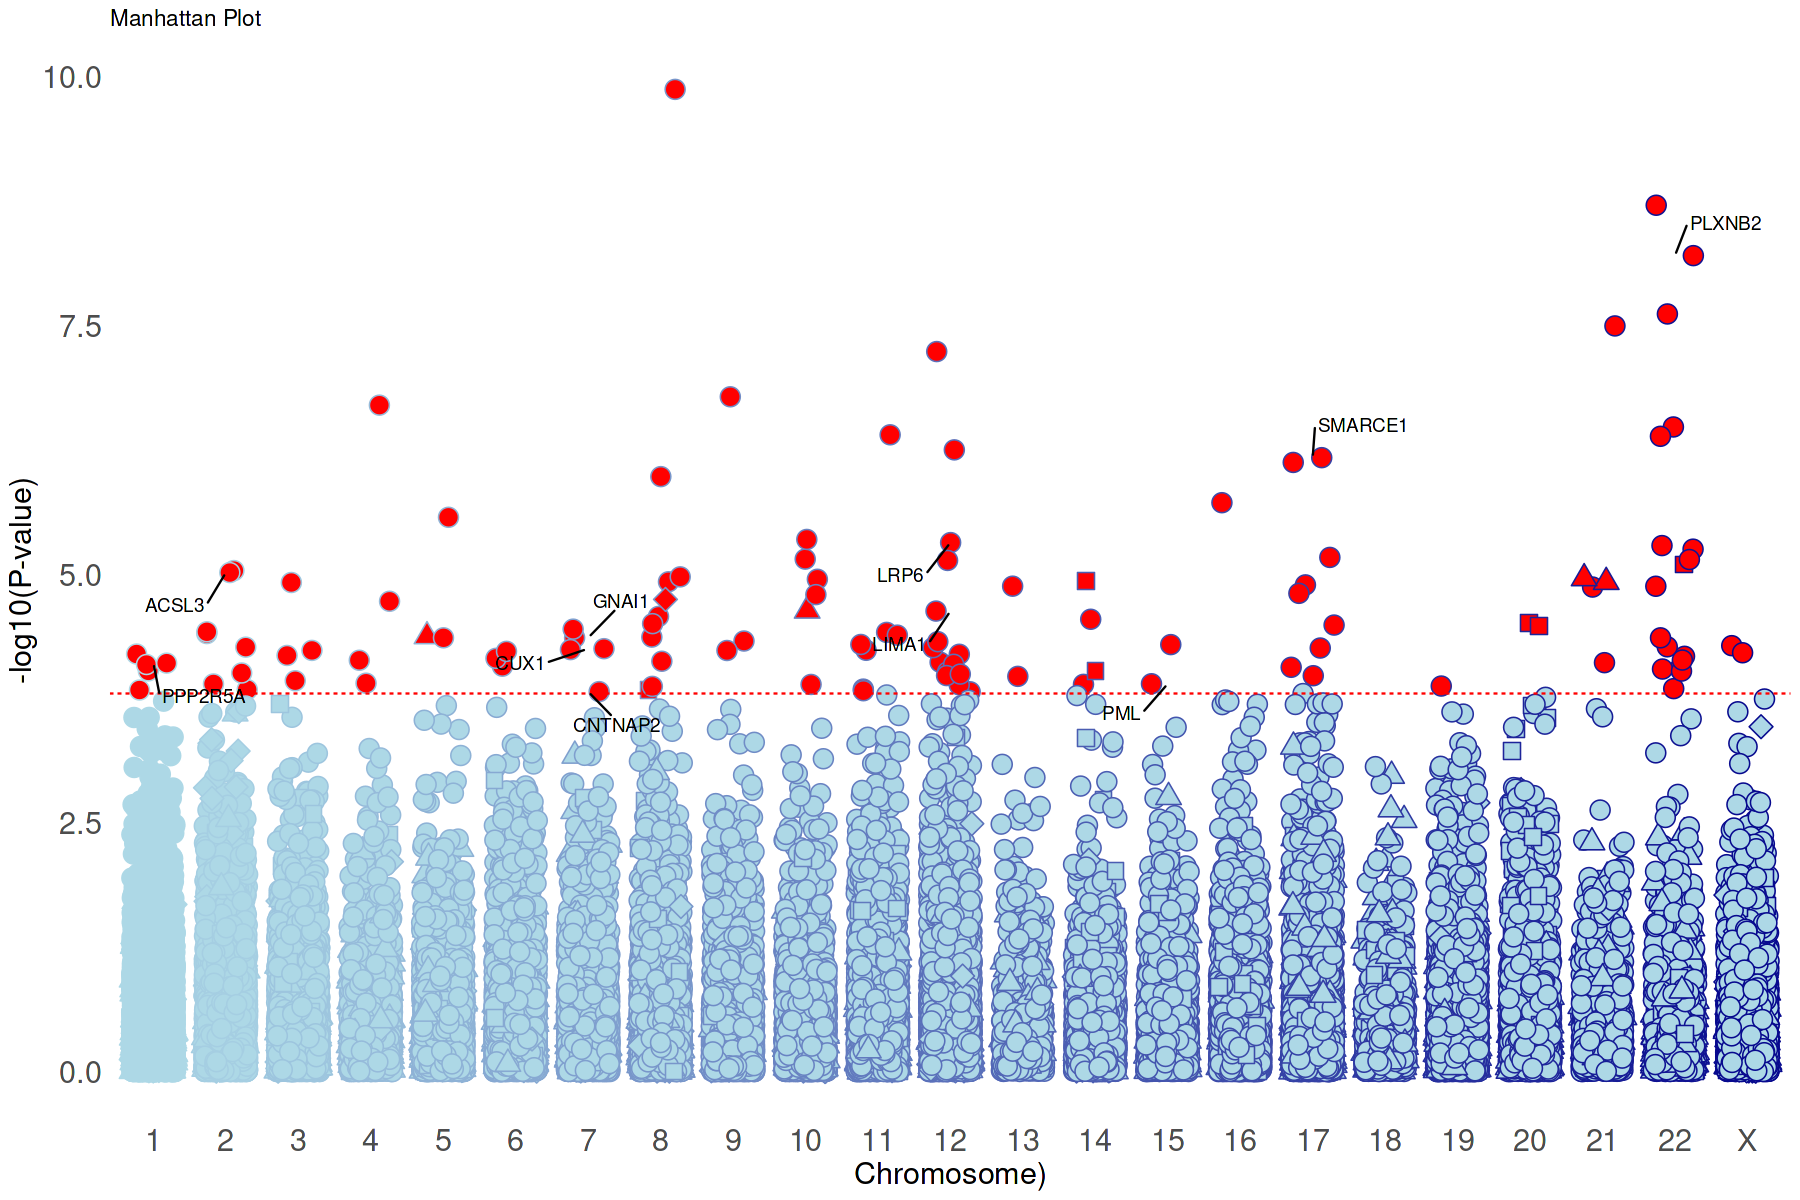

In [12]:
#All Hartwig

library(tidyr)
library(ggplot2)
library(stringr)
library(RColorBrewer)
library(ggrepel)

options(repr.plot.width=15, repr.plot.height=10)

Primary_Driver_H = read.table("/home/darragh/New/combine_PS_eQTL/All_eQTL.txt", header=T)
Primary_Driver_H_genes = read.table("/home/darragh/New/combine_PS_eQTL/All_eQTL_genes.txt", header=T)
colnames(Primary_Driver_H) = c('chr',	'start',	'end',	'id',	'p_value',	'q_value',	'OnkoKB',	'Primary_unique',	'ER_unique',	'TN_unique')


Primary_Driver_H = Primary_Driver_H[Primary_Driver_H$chr != "chrY", ]  

Primary_Driver_H$chr <- str_replace(Primary_Driver_H$chr, "chrX", "chr23")

# Extract numeric part from the chromosome names
Primary_Driver_H$chr_num <- as.numeric(str_extract(Primary_Driver_H$chr, "\\d+"))

# Define the chromosome order
chromosome_order <- 1:23

# Create a data frame to store the significance threshold
threshold <- data.frame(xmin = min(Primary_Driver_H$chr_num), xmax = max(Primary_Driver_H$chr_num), y = -log10(0.05))

# Define a color palette with 24 different colors
num_shades <- 24

# Generate a vector of 24 evenly spaced values from 0 to 1
shades <- seq(0, 1, length.out = num_shades)

# Create the color palette using the shades of blue
color_palette <- colorRampPalette(c("lightblue", "darkblue"))(num_shades)

head(Primary_Driver_H)
head(Primary_Driver_H_genes)

library(ggrepel)

# Merge Primary_Driver_H_genes with Primary_Driver_H to include chr_num
merged_df <- merge(Primary_Driver_H_genes, Primary_Driver_H, by = "id")

# Filter the merged dataframe to include only the desired points
filtered_df <- merged_df[merged_df$q_value < 0.1 & merged_df$OnkoKB == 'OnkoKB',]

head(filtered_df)

# Create the Manhattan plot using ggplot and ggrepel
ggplot(Primary_Driver_H, aes(x = factor(chr_num, levels = chromosome_order), y = -log10(p_value), color = factor(chr_num), fill = q_value < 0.1)) +
  geom_point(position = position_jitter(width = 0.3, height = 0), size = 5, shape = ifelse(Primary_Driver_H$Primary_unique == 'True', 24, ifelse(Primary_Driver_H$ER_unique, 22, ifelse(Primary_Driver_H$TN_unique == 'True', 23, 21)))) +
  scale_fill_manual(values = c("FALSE" = "lightblue", "TRUE" = "red")) +
  geom_hline(data = threshold, aes(yintercept = 3.8), linetype = "dashed", color = "red") +
  geom_text_repel(
    data = filtered_df,
    aes(label = gene),
    vjust = 0.5,
    color = "black",
    box.padding = 1,
    label.size=6,
    point.padding = 0.2,
    max.overlaps=100
  ) +
  scale_x_discrete(limits = as.character(chromosome_order), labels = c(1:22, "X", "Y")) +
  labs(x = "Chromosome Group", y = "-log10(p-value)", title = "Manhattan Plot") +
  scale_color_manual(values = color_palette) +
  theme_minimal() +
  theme_minimal() + theme(axis.text = element_text(size = 18), axis.title.x = element_text(size = 18), axis.title.y = element_text(size = 18), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position="none") +
 xlab("Chromosome)") +
  ylab("-log10(P-value)") 


In [10]:
import pandas as pd

Primary_Driver_H = pd.read_table("/home/darragh/New/combine_PS_eQTL/All_eQTL.txt", sep="\t", header=0)
Primary_Driver_H_genes = pd.read_table("/home/darragh/New/combine_PS_eQTL/All_eQTL_genes.txt", sep="\t", header=0)

Primary_Driver_H = Primary_Driver_H.merge(Primary_Driver_H_genes, on="id")


Primary_Driver_H = Primary_Driver_H.loc[Primary_Driver_H['q_value_RNA'] < 0.1,]

display(Primary_Driver_H)


chr      start        end  \
919   chr12   13022483   13028754   
1365   chr7   75713182   75721635   
2269  chr15   73921148   73930179   
3445  chr17   38462788   38480506   
4123   chr2  223572419  223575236   
4428   chr1  210010798  210015567   
4804   chr7  145843590  145844820   
4980  chr22   50324296   50331511   
5191   chr7  102511949  102517747   
5591  chr12   50593605   50601771   

                                                id   p_value_RNA  q_value_RNA  \
919       chr12_13022483_13028754_LRP6__matrix.txt  4.769850e-06     0.019527   
1365      chr7_75713182_75721635_GNAI1__matrix.txt  4.322563e-05     0.055209   
2269       chr15_73921148_73930179_PML__matrix.txt  1.254325e-04     0.090880   
3445   chr17_38462788_38480506_SMARCE1__matrix.txt  6.672549e-07     0.003992   
4123    chr2_223572419_223575236_ACSL3__matrix.txt  9.551417e-06     0.026533   
4428  chr1_210010798_210015567_PPP2R5A__matrix.txt  7.780822e-05     0.068773   
4804  chr7_145843590_145844820_CNTNAP2__matrix.txt  1.505059e-04     0.097954   
4980    chr22_50324296_50331511_PLXNB2__matrix.txt  6.195715e-09     0.000161   
5191     chr7_102511949_102517747_CUX1__matrix.txt  5.566499e-05     0.060224   
5591     chr12_50593605_50601771_LIMA1__matrix.txt  2.330239e-05     0.040277   

      OnkoKB  Primary_unique  ER_unique  TN_unique     gene  
919   OnkoKB           False      False      False     LRP6  
1365  OnkoKB           False      False      False    GNAI1  
2269  OnkoKB           False      False      False      PML  
3445  OnkoKB           False      False      False  SMARCE1  
4123  OnkoKB           False      False      False    ACSL3  
4428  OnkoKB           False      False      False  PPP2R5A  
4804  OnkoKB           False      False      False  CNTNAP2  
4980  OnkoKB           False      False      False   PLXNB2  
5191  OnkoKB           False      False      False     CUX1  
5591  OnkoKB           False      False      False    LIMA1

chr   start     end       id                                           
1 chr11  62605575  62610296 chr11_62605575_62610296_SNHG1__matrix.txt    
2 chr2  129056122 129068695 chr2_129056122_129068695_AMMECR1L__matrix.txt
3 chr8  141597903 141602540 chr8_141597903_141602540_CHRAC1__matrix.txt  
4 chr19  13943622  13965525 chr19_13943622_13965525_AKAP8L__matrix.txt   
5 chr11  67894063  67897158 chr11_67894063_67897158_NDUFS8__matrix.txt   
6 chr3  149101510 149114964 chr3_149101510_149114964_TSC22D2__matrix.txt 
  p_value    q_value   OnkoKB Primary_unique ER_unique TN_unique chr_num
1 0.09621614 0.8758903 Not    False          False     False     11     
2 0.62466073 0.9945654 Not    False          False     False      2     
3 0.41846483 0.9945654 Not    False          False     False      8     
4 0.02637242 0.7176912 Not    False          False     False     19     
5 0.04028697 0.7710413 Not    False          False     True      11     
6 0.85406263 0.9945654 Not    False          False     False      3

id                                         gene  
1 chr9_22101741_22108708_CDKN2B__matrix.txt  CDKN2B
2 chr2_213768222_213773179_BARD1__matrix.txt BARD1 
3 chr15_41952103_41954834_MGA__matrix.txt    MGA   
4 chr5_79539943_79546072_MSH3__matrix.txt    MSH3  
5 chr19_797270_802393_ARID3A__matrix.txt     ARID3A
6 chr7_148839753_148846315_KMT2C__matrix.txt KMT2C

id gene chr start end p_value q_value OnkoKB Primary_unique ER_unique
     TN_unique chr_num

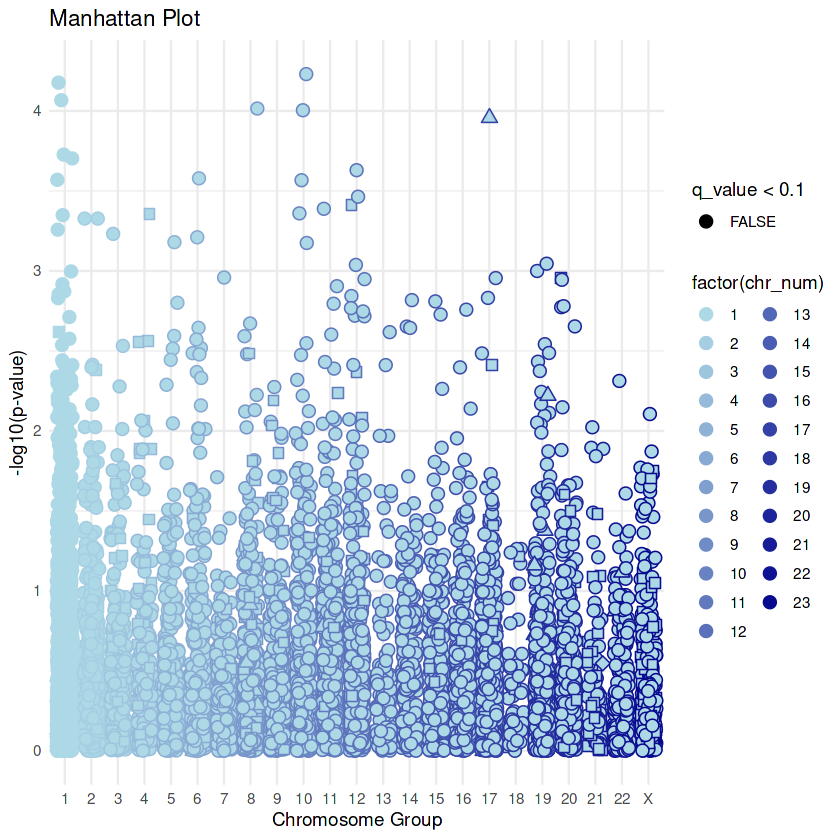

In [4]:
#All Hartwig

library(tidyr)
library(ggplot2)
library(stringr)
library(RColorBrewer)
library(ggrepel)

Primary_Driver_H = read.table("/home/darragh/New/combine_PS_eQTL/ER_eQTL.txt", header=T)
Primary_Driver_H_genes = read.table("/home/darragh/New/combine_PS_eQTL/ER_eQTL_genes.txt", header=T)
colnames(Primary_Driver_H) = c('chr',	'start',	'end',	'id',	'p_value',	'q_value',	'OnkoKB',	'Primary_unique',	'ER_unique',	'TN_unique')


Primary_Driver_H = Primary_Driver_H[Primary_Driver_H$chr != "chrY", ]  

Primary_Driver_H$chr <- str_replace(Primary_Driver_H$chr, "chrX", "chr23")

# Extract numeric part from the chromosome names
Primary_Driver_H$chr_num <- as.numeric(str_extract(Primary_Driver_H$chr, "\\d+"))

# Define the chromosome order
chromosome_order <- 1:23

# Create a data frame to store the significance threshold
threshold <- data.frame(xmin = min(Primary_Driver_H$chr_num), xmax = max(Primary_Driver_H$chr_num), y = -log10(0.05))

# Define a color palette with 24 different colors
num_shades <- 24

# Generate a vector of 24 evenly spaced values from 0 to 1
shades <- seq(0, 1, length.out = num_shades)

# Create the color palette using the shades of blue
color_palette <- colorRampPalette(c("lightblue", "darkblue"))(num_shades)

head(Primary_Driver_H)
head(Primary_Driver_H_genes)

library(ggrepel)

# Merge Primary_Driver_H_genes with Primary_Driver_H to include chr_num
merged_df <- merge(Primary_Driver_H_genes, Primary_Driver_H, by = "id")

# Filter the merged dataframe to include only the desired points
filtered_df <- merged_df[merged_df$q_value < 0.1 & merged_df$OnkoKB == 'OnkoKB',]

head(filtered_df)

# Create the Manhattan plot using ggplot and ggrepel
ggplot(Primary_Driver_H, aes(x = factor(chr_num, levels = chromosome_order), y = -log10(p_value), color = factor(chr_num), fill = q_value < 0.1)) +
  geom_point(position = position_jitter(width = 0.3, height = 0), size = 3, shape = ifelse(Primary_Driver_H$Primary_unique == 'True', 24, ifelse(Primary_Driver_H$ER_unique, 22, ifelse(Primary_Driver_H$TN_unique == 'True', 23, 21)))) +
  scale_fill_manual(values = c("FALSE" = "lightblue", "TRUE" = "red")) +

  geom_text_repel(
    data = filtered_df,
    aes(label = gene),
    vjust = 0.5,
    color = "black",
    box.padding = 1,
    point.padding = 0.2,
    max.overlaps=100
  ) +
  scale_x_discrete(limits = as.character(chromosome_order), labels = c(1:22, "X", "Y")) +
  labs(x = "Chromosome Group", y = "-log10(p-value)", title = "Manhattan Plot") +
  scale_color_manual(values = color_palette) +
  theme_minimal()


chr   start     end       id                                          
1 chr11  63632979  63641792 chr11_63632979_63641792_EML3__matrix.txt    
2 chr6   46842699  46845931 chr6_46842699_46845931_SUPT3H__matrix.txt   
3 chr19  13943657  13967022 chr19_13943657_13967022_CC2D1A__matrix.txt  
4 chr1   33218866  33236333 chr1_33218866_33236333_S100PBP__matrix.txt  
5 chr1  144532909 144539045 chr1_144532909_144539045_PDZK1P1__matrix.txt
6 chr19  13943657  13967022 chr19_13943657_13967022_PRDX2__matrix.txt   
  p_value    q_value   OnkoKB Primary_unique ER_unique TN_unique chr_num
1 0.41179933 0.8165655 Not    False          False     False     11     
2 0.82688874 0.9636184 Not    False          False     False      6     
3 0.05957482 0.5510671 Not    False          False     False     19     
4 0.27886371 0.7889675 Not    False          False     False      1     
5 0.75058481 0.9257612 Not    False          False     False      1     
6 0.96551303 0.9909946 Not    False          False     False     19

id                                       gene 
1 chr7_55086065_55098678_EGFR__matrix.txt  EGFR 
2 chr1_33218866_33236333_HDAC1__matrix.txt HDAC1
3 chr7_55085859_55098678_EGFR__matrix.txt  EGFR 
4 chr10_8185664_8191607_GATA3__matrix.txt  GATA3
5 chr7_22893299_22900939_GPNMB__matrix.txt GPNMB

id gene chr start end p_value q_value OnkoKB Primary_unique ER_unique
     TN_unique chr_num

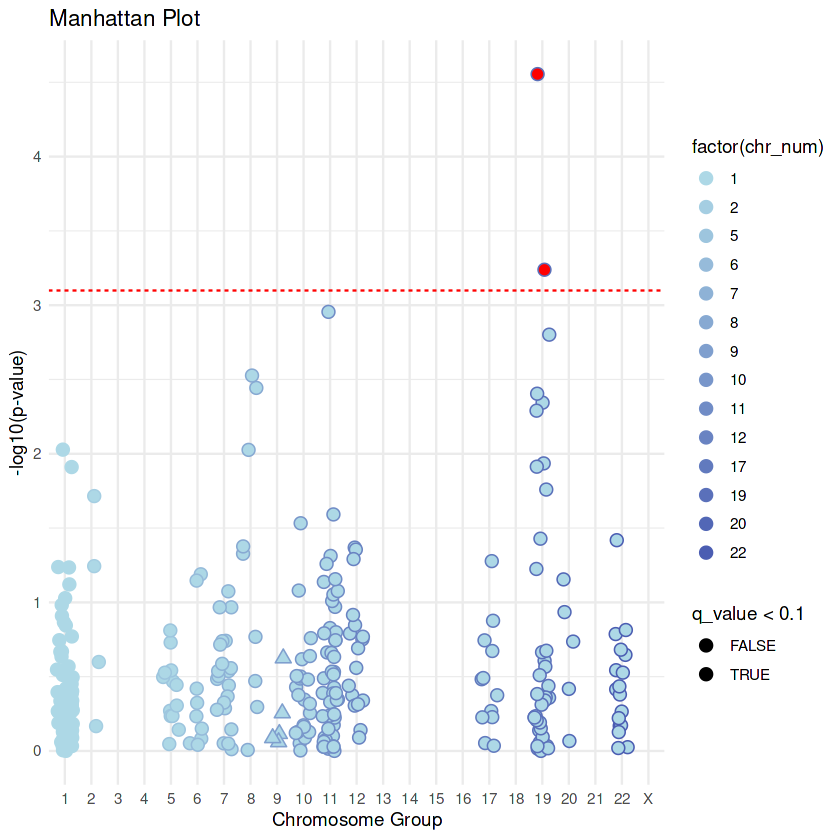

In [6]:
#All Hartwig

library(tidyr)
library(ggplot2)
library(stringr)
library(RColorBrewer)
library(ggrepel)

Primary_Driver_H = read.table("/home/darragh/New/combine_PS_eQTL/TN_eQTL.txt", header=T)
Primary_Driver_H_genes = read.table("/home/darragh/New/combine_PS_eQTL/TN_eQTL_genes.txt", header=T)
colnames(Primary_Driver_H) = c('chr',	'start',	'end',	'id',	'p_value',	'q_value',	'OnkoKB',	'Primary_unique',	'ER_unique',	'TN_unique')


Primary_Driver_H = Primary_Driver_H[Primary_Driver_H$chr != "chrY", ]  

Primary_Driver_H$chr <- str_replace(Primary_Driver_H$chr, "chrX", "chr23")

# Extract numeric part from the chromosome names
Primary_Driver_H$chr_num <- as.numeric(str_extract(Primary_Driver_H$chr, "\\d+"))

# Define the chromosome order
chromosome_order <- 1:23

# Create a data frame to store the significance threshold
threshold <- data.frame(xmin = min(Primary_Driver_H$chr_num), xmax = max(Primary_Driver_H$chr_num), y = -log10(0.05))

# Define a color palette with 24 different colors
num_shades <- 24

# Generate a vector of 24 evenly spaced values from 0 to 1
shades <- seq(0, 1, length.out = num_shades)

# Create the color palette using the shades of blue
color_palette <- colorRampPalette(c("lightblue", "darkblue"))(num_shades)

head(Primary_Driver_H)
head(Primary_Driver_H_genes)

library(ggrepel)

# Merge Primary_Driver_H_genes with Primary_Driver_H to include chr_num
merged_df <- merge(Primary_Driver_H_genes, Primary_Driver_H, by = "id")

# Filter the merged dataframe to include only the desired points
filtered_df <- merged_df[merged_df$q_value < 0.1 & merged_df$OnkoKB == 'OnkoKB',]

head(filtered_df)

# Create the Manhattan plot using ggplot and ggrepel
ggplot(Primary_Driver_H, aes(x = factor(chr_num, levels = chromosome_order), y = -log10(p_value), color = factor(chr_num), fill = q_value < 0.1)) +
  geom_point(position = position_jitter(width = 0.3, height = 0), size = 3, shape = ifelse(Primary_Driver_H$Primary_unique == 'True', 24, ifelse(Primary_Driver_H$ER_unique, 22, ifelse(Primary_Driver_H$TN_unique == 'True', 23, 21)))) +
  scale_fill_manual(values = c("FALSE" = "lightblue", "TRUE" = "red")) +
  geom_hline(data = threshold, aes(yintercept = 3.1), linetype = "dashed", color = "red") +
  geom_text_repel(
    data = filtered_df,
    aes(label = gene),
    vjust = 0.5,
    color = "black",
    box.padding = 1,
    point.padding = 0.2,
    max.overlaps=100
  ) +
  scale_x_discrete(limits = as.character(chromosome_order), labels = c(1:22, "X", "Y")) +
  labs(x = "Chromosome Group", y = "-log10(p-value)", title = "Manhattan Plot") +
  scale_color_manual(values = color_palette) +
  theme_minimal()


In [54]:
import pandas as pd
import pybedtools as pybed

Warning message:
“Expected 8 pieces. Additional pieces discarded in 6893 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 8 pieces. Additional pieces discarded in 3937 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 8 pieces. Additional pieces discarded in 10228 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Saving 6.67 x 6.67 in image


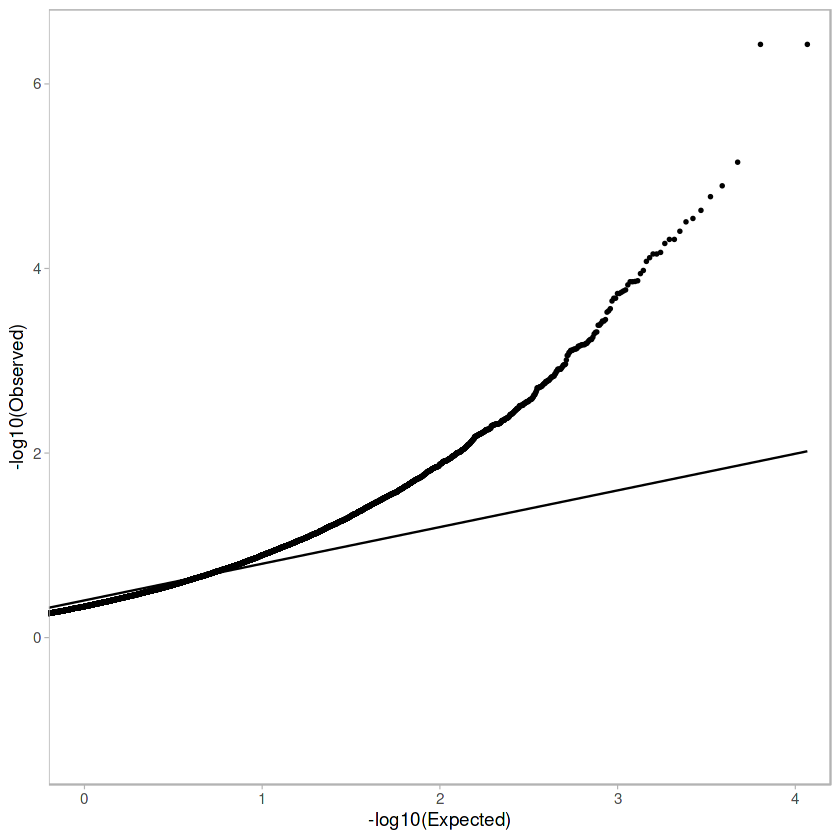

In [13]:
library(ggplot2)
library(ggrepel)
library(tidyr)

file_1 = read.delim("/home/darragh/New/eQTL/Hartwig/Primary/output.txt", header = T)
file_1 <- file_1 %>% separate(id, c('chr', 'start', 'end', 'ann1', 'ann2', 'ann3', 'gene', 'null'))
file_1$annotation = paste(file_1$ann2,file_1$ann3, sep="_" )

file_2 = read.delim("/home/darragh/New/eQTL/Hartwig/ER/output.txt", header = T)
file_2 <- file_2 %>% separate(id, c('chr', 'start', 'end', 'ann1', 'ann2', 'ann3', 'gene', 'null'))
file_2$annotation = paste(file_2$ann2,file_2$ann3, sep="_" )

file_3 = read.delim("/home/darragh/New/eQTL/Hartwig/TN/output.txt", header = T)
file_3 <- file_3 %>% separate(id, c('chr', 'start', 'end', 'ann1', 'ann2', 'ann3', 'gene', 'null'))
file_3$annotation = paste(file_3$ann2,file_3$ann3, sep="_" )

file = rbind(file_1, file_2, file_3)

ggplot(file, aes(sample = -log10(p_value_RNA))) + stat_qq(size=0.5) + coord_cartesian(xlim = c(0,4) ) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) + xlab("-log10(Expected)") + ylab("-log10(Observed)") + stat_qq_line()
ggsave("/home/darragh/New/somatic_eQTL_qq_plot.pdf")


In [1]:
import pandas as pd
import pybedtools as pybed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
####
#Function for calling promoters
####
#awk '{print $0}' /index/hg19/Homo_sapiens.GRCh37.87.chr.gtf | grep "protein_coding" | awk '{if ($3 == "gene") print "chr"$1"\t"$4"\t"$5"\t"$7"\t"$14 }' > /home/darragh/Annotation_reg_elements/hg19_protein_coding_minimal.gtf
gtf = "/home/darragh/Annotation_reg_elements/hg19_protein_coding_minimal.gtf"
def Identify_coding_promoters(gtf):
    hg19_gtf = pd.read_table(gtf)
    hg19_gtf.columns = ["chr","start","end", "strand", "gene"]
    hg19_gtf = hg19_gtf[["chr","start","end", "gene"]]
    seqnames_we_like = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chr22","chrX", "chrY"]
    hg19_gtf = hg19_gtf[hg19_gtf['chr'].isin(seqnames_we_like)]
    hg19_gtf['end'] = hg19_gtf['start']+1
    hg19_gtf['gene'] = hg19_gtf['gene'].str.rstrip(';')

    return(hg19_gtf)

Coding_promoter_df = Identify_coding_promoters(gtf)
display(Coding_promoter_df)
Coding_promoter = pybed.BedTool.from_dataframe(Coding_promoter_df)
Coding_promoter = Coding_promoter.sort()


# Read in Non-cancer unique regulatory elements
Non_cancer_unique = pd.read_table("/home/darragh/New/Differentially_active/Non_cancer/output_fold1.txt", sep="\t", header=0)
Non_cancer_unique = Non_cancer_unique.loc[(Non_cancer_unique['FDR'] <0.05)  & (Non_cancer_unique['Fold'] < -1.5) ]
Non_cancer_unique = pybed.BedTool.from_dataframe(Non_cancer_unique[['seqnames', 'start', 'end']])
Non_cancer_unique = Non_cancer_unique.sort()
Non_cancer_unique = Non_cancer_unique.merge()

# Read in HMEC and MCF10A enhancers
HMEC = pd.read_table("/home/darragh/New/Regulatory_elements/HMEC_reg_elements.txt",header=None, sep="\t")
MCF10A = pd.read_table("/home/darragh/New/Regulatory_elements/MCF10A_reg_elements.txt",header=None, sep="\t")
HMEC.columns = ["chr", "start", "end", "annotation"]
MCF10A.columns = ["chr", "start", "end", "annotation"]
HMEC = pybed.BedTool.from_dataframe(HMEC.loc[(HMEC['annotation'] != "HMEC_active_promoter") & (HMEC['annotation'] != "HMEC_polycomb_promoter")])
MCF10A = pybed.BedTool.from_dataframe(MCF10A.loc[(MCF10A['annotation'] != "MCF10A_active_promoter") & (MCF10A['annotation'] != "MCF10A_polycomb_promoter")])

HMEC_unique = HMEC.intersect(Non_cancer_unique, wa=True,f=0.5)
MCF10A_unique = MCF10A.intersect(Non_cancer_unique, wa=True,f=0.5)

HMEC_unique = pd.read_table(HMEC_unique.fn, header=None)
HMEC_unique.columns = ['chr', 'start', 'end', 'annotation']
MCF10A_unique = pd.read_table(MCF10A_unique.fn, header=None)
MCF10A_unique.columns = ['chr', 'start', 'end', 'annotation']

HMEC_unique['id'] = HMEC_unique['chr'].astype(str) + '_' + HMEC_unique['start'].astype(str) + '_' + HMEC_unique['end'].astype(str)
MCF10A_unique['id'] = MCF10A_unique['chr'].astype(str) + '_' + MCF10A_unique['start'].astype(str) + '_' + MCF10A_unique['end'].astype(str)

#################################################################
#Super enhancers will be linked to the highest expressed nearest gene
HMEC_super_enhancer = HMEC_unique.loc[HMEC_unique['annotation'] == "HMEC_super_enhancer"]
HMEC_super_enhancer = pybed.BedTool.from_dataframe(HMEC_super_enhancer.drop_duplicates())
HMEC_RNA = pd.read_table("/home/darragh/New/ABC/rna/hmec/HMEC_RNA_2.txt", header=None)
HMEC_RNA.columns = ['gene', 'expression']
genes_hg19 = pd.read_table("/home/darragh/New/ABC/hg19.genes_all.txt", header=None)
genes_hg19 = genes_hg19.iloc[:,[0,1,2,3]]
genes_hg19.columns = ['chr', 'start', 'end', 'gene']
HMEC_RNA = HMEC_RNA.merge(genes_hg19, on="gene")
HMEC_RNA = pybed.BedTool.from_dataframe(HMEC_RNA[['chr', 'start', 'end', 'gene', 'expression']])
HMEC_RNA = HMEC_RNA.sort()
HMEC_super_enhancer = HMEC_super_enhancer.closest(HMEC_RNA, t="all")
HMEC_super_enhancer = pd.read_table(HMEC_super_enhancer.fn, header=None)
HMEC_super_enhancer = HMEC_super_enhancer.iloc[:,[0,1,2,3,4,8,9]]
HMEC_super_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene', 'expression']
HMEC_super_enhancer = HMEC_super_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene', 'expression'].max().reset_index()
HMEC_super_enhancer = HMEC_super_enhancer[['chr', 'start', 'end', 'annotation', 'id', 'gene']].drop_duplicates()

#Active-enhancers are linked to all max ABC contacts
HMEC_active_enhancer = HMEC_unique.loc[(HMEC_unique['annotation'] == "HMEC_active_enhancer")]
HMEC_active_enhancer = HMEC_active_enhancer[['chr', 'start', 'end', 'annotation','id']]
HMEC_active_enhancer = pybed.BedTool.from_dataframe(HMEC_active_enhancer.drop_duplicates())
HMEC_ABC = pd.read_table("/home/darragh/New/ABC/predictions/HMEC/EnhancerPredictions.txt", header=0)
HMEC_ABC = pybed.BedTool.from_dataframe(HMEC_ABC[['chr', 'start', 'end', 'TargetGene', 'ABC.Score']])
HMEC_active_enhancer = HMEC_active_enhancer.intersect(HMEC_ABC, wa=True, wb=True)
HMEC_active_enhancer = pd.read_table(HMEC_active_enhancer.fn, header=None)
HMEC_active_enhancer = HMEC_active_enhancer.iloc[:,[0,1,2,3,4,8,9]]
HMEC_active_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene','score']
HMEC_active_enhancer_tmp = HMEC_active_enhancer[['id', 'gene','score']]
HMEC_active_enhancer = HMEC_active_enhancer[['chr', 'start', 'end', 'annotation', 'id','score']]
HMEC_active_enhancer = HMEC_active_enhancer.groupby(['chr', 'start', 'end', 'annotation', 'id'])['score'].max().reset_index()
HMEC_active_enhancer = HMEC_active_enhancer.merge(HMEC_active_enhancer_tmp, on=['id','score'])
HMEC_active_enhancer = HMEC_active_enhancer.drop_duplicates()
HMEC_active_enhancer = HMEC_active_enhancer[['chr',	'start',	'end',	'annotation',	'id', 'gene']]

HMEC_unique_enhancers = pd.concat([HMEC_active_enhancer,HMEC_super_enhancer])
HMEC_unique_enhancers_2 = HMEC_unique_enhancers[['id','gene']]

#Everything else link to the closest gene
HMEC_unique = HMEC_unique.merge(HMEC_unique_enhancers_2, on="id", how="outer")
HMEC_unique_no_genes = HMEC_unique.loc[HMEC_unique['gene'].isna()]
HMEC_unique_no_genes = pybed.BedTool.from_dataframe(HMEC_unique_no_genes[['chr', 'start', 'end', 'annotation', 'id']])
HMEC_unique_no_genes = HMEC_unique_no_genes.closest(Coding_promoter)
HMEC_unique_no_genes = pd.read_table(HMEC_unique_no_genes.fn, header=None)
HMEC_unique_no_genes = HMEC_unique_no_genes.iloc[:,[0,1,2,3,4,8]]
HMEC_unique_no_genes = HMEC_unique_no_genes.drop_duplicates()
HMEC_unique_no_genes.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']

HMEC_unique_regs_genes = pd.concat([HMEC_unique_enhancers, HMEC_unique_no_genes])
HMEC_unique_regs_genes = HMEC_unique_regs_genes.drop_duplicates()


####################################################################
#Super enhancers will be linked to the highest expressed nearest gene
MCF10A_super_enhancer = MCF10A_unique.loc[MCF10A_unique['annotation'] == "MCF10A_super_enhancer"]
MCF10A_super_enhancer = pybed.BedTool.from_dataframe(MCF10A_super_enhancer.drop_duplicates())
MCF10A_RNA = pd.read_table("/home/darragh/New/ABC/rna/MCF10A/MCF10A_RNA_2.txt", header=None)
MCF10A_RNA.columns = ['gene', 'expression']
genes_hg19 = pd.read_table("/home/darragh/New/ABC/hg19.genes_all.txt", header=None)
genes_hg19 = genes_hg19.iloc[:,[0,1,2,3]]
genes_hg19.columns = ['chr', 'start', 'end', 'gene']
MCF10A_RNA = MCF10A_RNA.merge(genes_hg19, on="gene")
MCF10A_RNA = pybed.BedTool.from_dataframe(MCF10A_RNA[['chr', 'start', 'end', 'gene', 'expression']])
MCF10A_RNA = MCF10A_RNA.sort()
MCF10A_super_enhancer = MCF10A_super_enhancer.closest(MCF10A_RNA, t="all")
MCF10A_super_enhancer = pd.read_table(MCF10A_super_enhancer.fn, header=None)
MCF10A_super_enhancer = MCF10A_super_enhancer.iloc[:,[0,1,2,3,4,8,9]]
MCF10A_super_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene', 'expression']
MCF10A_super_enhancer = MCF10A_super_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene', 'expression'].max().reset_index()
MCF10A_super_enhancer = MCF10A_super_enhancer[['chr', 'start', 'end', 'annotation', 'id', 'gene']].drop_duplicates()

#Active-enhancers are linked to all overlapping ABC contacts
MCF10A_active_enhancer = MCF10A_unique.loc[(MCF10A_unique['annotation'] == "MCF10A_active_enhancer")]
MCF10A_active_enhancer = MCF10A_active_enhancer[['chr', 'start', 'end', 'annotation','id']]
MCF10A_active_enhancer = pybed.BedTool.from_dataframe(MCF10A_active_enhancer.drop_duplicates())
MCF10A_ABC = pd.read_table("/home/darragh/New/ABC/predictions/MCF10A/EnhancerPredictions.txt", header=0)
MCF10A_ABC = pybed.BedTool.from_dataframe(MCF10A_ABC[['chr', 'start', 'end', 'TargetGene', 'ABC.Score']])
MCF10A_active_enhancer = MCF10A_active_enhancer.intersect(MCF10A_ABC, wa=True, wb=True)
MCF10A_active_enhancer = pd.read_table(MCF10A_active_enhancer.fn, header=None)
MCF10A_active_enhancer = MCF10A_active_enhancer.iloc[:,[0,1,2,3,4,8,9]]
MCF10A_active_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene','score']
MCF10A_active_enhancer_tmp = MCF10A_active_enhancer[['id', 'gene','score']]
MCF10A_active_enhancer = MCF10A_active_enhancer[['chr', 'start', 'end', 'annotation', 'id','score']]
MCF10A_active_enhancer = MCF10A_active_enhancer.groupby(['chr', 'start', 'end', 'annotation', 'id'])['score'].max().reset_index()
MCF10A_active_enhancer = MCF10A_active_enhancer.merge(MCF10A_active_enhancer_tmp, on=['id','score'])
MCF10A_active_enhancer = MCF10A_active_enhancer.drop_duplicates()
MCF10A_active_enhancer = MCF10A_active_enhancer[['chr',	'start',	'end',	'annotation',	'id', 'gene']]

MCF10A_unique_enhancers = pd.concat([MCF10A_active_enhancer,MCF10A_super_enhancer])
MCF10A_unique_enhancers_2 = MCF10A_unique_enhancers[['id','gene']]

#Everything else link to the closest gene
MCF10A_unique = MCF10A_unique.merge(MCF10A_unique_enhancers_2, on="id", how="outer")
MCF10A_unique_no_genes = MCF10A_unique.loc[MCF10A_unique['gene'].isna()]
MCF10A_unique_no_genes = pybed.BedTool.from_dataframe(MCF10A_unique_no_genes[['chr', 'start', 'end', 'annotation', 'id']])
MCF10A_unique_no_genes = MCF10A_unique_no_genes.closest(Coding_promoter)
MCF10A_unique_no_genes = pd.read_table(MCF10A_unique_no_genes.fn, header=None)
MCF10A_unique_no_genes = MCF10A_unique_no_genes.iloc[:,[0,1,2,3,4,8]]
MCF10A_unique_no_genes = MCF10A_unique_no_genes.drop_duplicates()
MCF10A_unique_no_genes.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']

MCF10A_unique_regs_genes = pd.concat([MCF10A_unique_enhancers, MCF10A_unique_no_genes])
MCF10A_unique_regs_genes = MCF10A_unique_regs_genes.drop_duplicates()

# Read in Non-cancer unique regulatory elements
ER_unique = pd.read_table("/home/darragh/New/Differentially_active/ER/output_fold1.txt", sep="\t", header=0)
ER_unique = ER_unique.loc[(ER_unique['FDR'] <0.05)  & (ER_unique['Fold'] < -1.5) ]
ER_unique = pybed.BedTool.from_dataframe(ER_unique[['seqnames', 'start', 'end']])
ER_unique = ER_unique.sort()
ER_unique = ER_unique.merge()

# Read in MCF7 and T47D enhancers
MCF7 = pd.read_table("/home/darragh/New/Regulatory_elements/MCF7_reg_elements.txt",header=None, sep="\t")
T47D = pd.read_table("/home/darragh/New/Regulatory_elements/T47D_reg_elements.txt",header=None, sep="\t")
MCF7.columns = ["chr", "start", "end", "annotation"]
T47D.columns = ["chr", "start", "end", "annotation"]
MCF7 = pybed.BedTool.from_dataframe(MCF7.loc[(MCF7['annotation'] != "MCF7_active_promoter") & (MCF7['annotation'] != "MCF7_polycomb_promoter")])
T47D = pybed.BedTool.from_dataframe(T47D.loc[(T47D['annotation'] != "T47D_active_promoter") & (T47D['annotation'] != "T47D_polycomb_promoter")])

MCF7_unique = MCF7.intersect(ER_unique, wa=True,f=0.5)
T47D_unique = T47D.intersect(ER_unique, wa=True,f=0.5)

MCF7_unique = pd.read_table(MCF7_unique.fn, header=None)
MCF7_unique.columns = ['chr', 'start', 'end', 'annotation']
T47D_unique = pd.read_table(T47D_unique.fn, header=None)
T47D_unique.columns = ['chr', 'start', 'end', 'annotation']

MCF7_unique['id'] = MCF7_unique['chr'].astype(str) + '_' + MCF7_unique['start'].astype(str) + '_' + MCF7_unique['end'].astype(str)
T47D_unique['id'] = T47D_unique['chr'].astype(str) + '_' + T47D_unique['start'].astype(str) + '_' + T47D_unique['end'].astype(str)

#Super enhancers will be linked to the highest expressed nearest gene
MCF7_super_enhancer = MCF7_unique.loc[MCF7_unique['annotation'] == "MCF7_super_enhancer"]
MCF7_super_enhancer = pybed.BedTool.from_dataframe(MCF7_super_enhancer.drop_duplicates())
MCF7_RNA = pd.read_table("/home/darragh/New/ABC/rna/MCF7/ABC_table.txt", header=None)
MCF7_RNA.columns = ['gene', 'expression']
genes_hg19 = pd.read_table("/home/darragh/New/ABC/hg19.genes_all.txt", header=None)
genes_hg19 = genes_hg19.iloc[:,[0,1,2,3]]
genes_hg19.columns = ['chr', 'start', 'end', 'gene']
MCF7_RNA = MCF7_RNA.merge(genes_hg19, on="gene")
MCF7_RNA = pybed.BedTool.from_dataframe(MCF7_RNA[['chr', 'start', 'end', 'gene', 'expression']])
MCF7_RNA = MCF7_RNA.sort()
MCF7_super_enhancer = MCF7_super_enhancer.closest(MCF7_RNA, t="all")
MCF7_super_enhancer = pd.read_table(MCF7_super_enhancer.fn, header=None)
MCF7_super_enhancer = MCF7_super_enhancer.iloc[:,[0,1,2,3,4,8,9]]
MCF7_super_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene', 'expression']
MCF7_super_enhancer = MCF7_super_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene', 'expression'].max().reset_index()
MCF7_super_enhancer = MCF7_super_enhancer[['chr', 'start', 'end', 'annotation', 'id', 'gene']].drop_duplicates()

#Active-enhancers are linked to all overlapping ABC contacts
MCF7_active_enhancer = MCF7_unique.loc[(MCF7_unique['annotation'] == "MCF7_active_enhancer")]
MCF7_active_enhancer = MCF7_active_enhancer[['chr', 'start', 'end', 'annotation','id']]
MCF7_active_enhancer = pybed.BedTool.from_dataframe(MCF7_active_enhancer.drop_duplicates())
MCF7_ABC = pd.read_table("/home/darragh/New/ABC/predictions/MCF7/EnhancerPredictions.txt", header=0)
MCF7_ABC = pybed.BedTool.from_dataframe(MCF7_ABC[['chr', 'start', 'end', 'TargetGene', 'ABC.Score']])
MCF7_active_enhancer = MCF7_active_enhancer.intersect(MCF7_ABC, wa=True, wb=True)
MCF7_active_enhancer = pd.read_table(MCF7_active_enhancer.fn, header=None)
MCF7_active_enhancer = MCF7_active_enhancer.iloc[:,[0,1,2,3,4,8,9]]
MCF7_active_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene','score']
MCF7_active_enhancer_tmp = MCF7_active_enhancer[['id', 'gene','score']]
MCF7_active_enhancer = MCF7_active_enhancer[['chr', 'start', 'end', 'annotation', 'id','score']]
MCF7_active_enhancer = MCF7_active_enhancer.groupby(['chr', 'start', 'end', 'annotation', 'id'])['score'].max().reset_index()
MCF7_active_enhancer = MCF7_active_enhancer.merge(MCF7_active_enhancer_tmp, on=['id','score'])
MCF7_active_enhancer = MCF7_active_enhancer.drop_duplicates()
MCF7_active_enhancer = MCF7_active_enhancer[['chr',	'start',	'end',	'annotation',	'id', 'gene']]

MCF7_unique_enhancers = pd.concat([MCF7_active_enhancer,MCF7_super_enhancer])
MCF7_unique_enhancers_2 = MCF7_unique_enhancers[['id','gene']]

#Everything else link to the closest gene
MCF7_unique = MCF7_unique.merge(MCF7_unique_enhancers_2, on="id", how="outer")
MCF7_unique_no_genes = MCF7_unique.loc[MCF7_unique['gene'].isna()]
MCF7_unique_no_genes = pybed.BedTool.from_dataframe(MCF7_unique_no_genes[['chr', 'start', 'end', 'annotation', 'id']])
MCF7_unique_no_genes = MCF7_unique_no_genes.closest(Coding_promoter)
MCF7_unique_no_genes = pd.read_table(MCF7_unique_no_genes.fn, header=None)
MCF7_unique_no_genes = MCF7_unique_no_genes.iloc[:,[0,1,2,3,4,8]]
MCF7_unique_no_genes = MCF7_unique_no_genes.drop_duplicates()
MCF7_unique_no_genes.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']

MCF7_unique_regs_genes = pd.concat([MCF7_unique_enhancers, MCF7_unique_no_genes])
MCF7_unique_regs_genes = MCF7_unique_regs_genes.drop_duplicates()


#Super enhancers will be linked to the highest expressed nearest gene
T47D_super_enhancer = T47D_unique.loc[T47D_unique['annotation'] == "T47D_super_enhancer"]
T47D_super_enhancer = pybed.BedTool.from_dataframe(T47D_super_enhancer.drop_duplicates())
T47D_RNA = pd.read_table("/home/darragh/New/ABC/rna/T47D/ABC_table.txt", header=None)
T47D_RNA.columns = ['gene', 'expression']
genes_hg19 = pd.read_table("/home/darragh/New/ABC/hg19.genes_all.txt", header=None)
genes_hg19 = genes_hg19.iloc[:,[0,1,2,3]]
genes_hg19.columns = ['chr', 'start', 'end', 'gene']
T47D_RNA = T47D_RNA.merge(genes_hg19, on="gene")
T47D_RNA = pybed.BedTool.from_dataframe(T47D_RNA[['chr', 'start', 'end', 'gene', 'expression']])
T47D_RNA = T47D_RNA.sort()
T47D_super_enhancer = T47D_super_enhancer.closest(T47D_RNA, t="all")
T47D_super_enhancer = pd.read_table(T47D_super_enhancer.fn, header=None)
T47D_super_enhancer = T47D_super_enhancer.iloc[:,[0,1,2,3,4,8,9]]
T47D_super_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene', 'expression']
T47D_super_enhancer = T47D_super_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene', 'expression'].max().reset_index()
T47D_super_enhancer = T47D_super_enhancer[['chr', 'start', 'end', 'annotation', 'id', 'gene']].drop_duplicates()

#Active-enhancers are linked to all overlapping ABC contacts
T47D_active_enhancer = T47D_unique.loc[(T47D_unique['annotation'] == "T47D_active_enhancer")]
T47D_active_enhancer = T47D_active_enhancer[['chr', 'start', 'end', 'annotation','id']]
T47D_active_enhancer = pybed.BedTool.from_dataframe(T47D_active_enhancer.drop_duplicates())
T47D_ABC = pd.read_table("/home/darragh/New/ABC/predictions/T47D/EnhancerPredictions.txt", header=0)
T47D_ABC = pybed.BedTool.from_dataframe(T47D_ABC[['chr', 'start', 'end', 'TargetGene', 'ABC.Score']])
T47D_active_enhancer = T47D_active_enhancer.intersect(T47D_ABC, wa=True, wb=True)
T47D_active_enhancer = pd.read_table(T47D_active_enhancer.fn, header=None)
T47D_active_enhancer = T47D_active_enhancer.iloc[:,[0,1,2,3,4,8,9]]
T47D_active_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene','score']
T47D_active_enhancer_tmp = T47D_active_enhancer[['id', 'gene','score']]
T47D_active_enhancer = T47D_active_enhancer[['chr', 'start', 'end', 'annotation', 'id','score']]
T47D_active_enhancer = T47D_active_enhancer.groupby(['chr', 'start', 'end', 'annotation', 'id'])['score'].max().reset_index()
T47D_active_enhancer = T47D_active_enhancer.merge(T47D_active_enhancer_tmp, on=['id','score'])
T47D_active_enhancer = T47D_active_enhancer.drop_duplicates()
T47D_active_enhancer = T47D_active_enhancer[['chr',	'start',	'end',	'annotation',	'id', 'gene']]

T47D_unique_enhancers = pd.concat([T47D_active_enhancer,T47D_super_enhancer])
T47D_unique_enhancers_2 = T47D_unique_enhancers[['id','gene']]

#Everything else link to the closest gene
T47D_unique = T47D_unique.merge(T47D_unique_enhancers_2, on="id", how="outer")
T47D_unique_no_genes = T47D_unique.loc[T47D_unique['gene'].isna()]
T47D_unique_no_genes = pybed.BedTool.from_dataframe(T47D_unique_no_genes[['chr', 'start', 'end', 'annotation', 'id']])
T47D_unique_no_genes = T47D_unique_no_genes.closest(Coding_promoter)
T47D_unique_no_genes = pd.read_table(T47D_unique_no_genes.fn, header=None)
T47D_unique_no_genes = T47D_unique_no_genes.iloc[:,[0,1,2,3,4,8]]
T47D_unique_no_genes = T47D_unique_no_genes.drop_duplicates()
T47D_unique_no_genes.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']

T47D_unique_regs_genes = pd.concat([T47D_unique_enhancers, T47D_unique_no_genes])
T47D_unique_regs_genes = T47D_unique_regs_genes.drop_duplicates()

# Read in Non-cancer unique regulatory elements
TN_unique = pd.read_table("/home/darragh/New/Differentially_active/TN/output_fold1.txt", sep="\t", header=0)
TN_unique = TN_unique.loc[(TN_unique['FDR'] <0.05)  & (TN_unique['Fold'] < -1.5) ]
TN_unique = pybed.BedTool.from_dataframe(TN_unique[['seqnames', 'start', 'end']])
TN_unique = TN_unique.sort()
TN_unique = TN_unique.merge()

# Read in MDAMB231 and MDAMB436 enhancers
MDAMB231 = pd.read_table("/home/darragh/New/Regulatory_elements/MDAMB231_reg_elements.txt",header=None, sep="\t")
MDAMB436 = pd.read_table("/home/darragh/New/Regulatory_elements/MDAMB436_reg_elements.txt",header=None, sep="\t")
BT549 = pd.read_table("/home/darragh/New/Regulatory_elements/BT549_reg_elements.txt",header=None, sep="\t")
MDAMB468 = pd.read_table("/home/darragh/New/Regulatory_elements/MDAMB468_reg_elements.txt",header=None, sep="\t")
MDAMB231.columns = ["chr", "start", "end", "annotation"]
MDAMB436.columns = ["chr", "start", "end", "annotation"]
BT549.columns = ["chr", "start", "end", "annotation"]
MDAMB468.columns = ["chr", "start", "end", "annotation"]
MDAMB231 = pybed.BedTool.from_dataframe(MDAMB231.loc[(MDAMB231['annotation'] != "MDAMB231_active_promoter") & (MDAMB231['annotation'] != "MDAMB231_polycomb_promoter")])
MDAMB436 = pybed.BedTool.from_dataframe(MDAMB436.loc[(MDAMB436['annotation'] != "MDAMB436_active_promoter") & (MDAMB436['annotation'] != "MDAMB436_polycomb_promoter")])
BT549 = pybed.BedTool.from_dataframe(BT549.loc[(BT549['annotation'] != "MDAMB436_active_promoter") & (BT549['annotation'] != "BT549_polycomb_promoter")])
MDAMB468 = pybed.BedTool.from_dataframe(MDAMB468.loc[(MDAMB468['annotation'] != "MDAMB468_active_promoter") & (MDAMB468['annotation'] != "MDAMB468_polycomb_promoter")])

MDAMB231_unique = MDAMB231.intersect(TN_unique, wa=True,f=0.5)
MDAMB436_unique = MDAMB436.intersect(TN_unique, wa=True,f=0.5)
BT549_unique = BT549.intersect(TN_unique, wa=True,f=0.5)
MDAMB468_unique = MDAMB468.intersect(TN_unique, wa=True,f=0.5)

MDAMB231_unique = pd.read_table(MDAMB231_unique.fn, header=None)
MDAMB231_unique.columns = ['chr', 'start', 'end', 'annotation']
MDAMB436_unique = pd.read_table(MDAMB436_unique.fn, header=None)
BT549_unique = pd.read_table(BT549_unique.fn, header=None)
MDAMB468_unique = pd.read_table(MDAMB468_unique.fn, header=None)
MDAMB436_unique.columns = ['chr', 'start', 'end', 'annotation']
BT549_unique.columns = ['chr', 'start', 'end', 'annotation']
MDAMB468_unique.columns = ['chr', 'start', 'end', 'annotation']

MDAMB231_unique['id'] = MDAMB231_unique['chr'].astype(str) + '_' + MDAMB231_unique['start'].astype(str) + '_' + MDAMB231_unique['end'].astype(str)
MDAMB436_unique['id'] = MDAMB436_unique['chr'].astype(str) + '_' + MDAMB436_unique['start'].astype(str) + '_' + MDAMB436_unique['end'].astype(str)
BT549_unique['id'] = BT549_unique['chr'].astype(str) + '_' + BT549_unique['start'].astype(str) + '_' + BT549_unique['end'].astype(str)
MDAMB468_unique['id'] = MDAMB468_unique['chr'].astype(str) + '_' + MDAMB468_unique['start'].astype(str) + '_' + MDAMB468_unique['end'].astype(str)


#Super enhancers will be linked to the highest expressed nearest gene
MDAMB231_super_enhancer = MDAMB231_unique.loc[MDAMB231_unique['annotation'] == "MDAMB231_super_enhancer"]
MDAMB231_super_enhancer = pybed.BedTool.from_dataframe(MDAMB231_super_enhancer.drop_duplicates())
MDAMB231_RNA = pd.read_table("/home/darragh/New/ABC/rna/MDAMB231/ABC_table.txt", header=None)
MDAMB231_RNA.columns = ['gene', 'expression']
genes_hg19 = pd.read_table("/home/darragh/New/ABC/hg19.genes_all.txt", header=None)
genes_hg19 = genes_hg19.iloc[:,[0,1,2,3]]
genes_hg19.columns = ['chr', 'start', 'end', 'gene']
MDAMB231_RNA = MDAMB231_RNA.merge(genes_hg19, on="gene")
MDAMB231_RNA = pybed.BedTool.from_dataframe(MDAMB231_RNA[['chr', 'start', 'end', 'gene', 'expression']])
MDAMB231_RNA = MDAMB231_RNA.sort()
MDAMB231_super_enhancer = MDAMB231_super_enhancer.closest(MDAMB231_RNA, t="all")
MDAMB231_super_enhancer = pd.read_table(MDAMB231_super_enhancer.fn, header=None)
MDAMB231_super_enhancer = MDAMB231_super_enhancer.iloc[:,[0,1,2,3,4,8,9]]
MDAMB231_super_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene', 'expression']
MDAMB231_super_enhancer = MDAMB231_super_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene', 'expression'].max().reset_index()
MDAMB231_super_enhancer = MDAMB231_super_enhancer[['chr', 'start', 'end', 'annotation', 'id', 'gene']].drop_duplicates()

#Active-enhancers are linked to all overlapping ABC contacts
MDAMB231_active_enhancer = MDAMB231_unique.loc[(MDAMB231_unique['annotation'] == "MDAMB231_active_enhancer")]
MDAMB231_active_enhancer = MDAMB231_active_enhancer[['chr', 'start', 'end', 'annotation','id']]
MDAMB231_active_enhancer = pybed.BedTool.from_dataframe(MDAMB231_active_enhancer.drop_duplicates())
MDAMB231_ABC = pd.read_table("/home/darragh/New/ABC/predictions/MDAMB231/EnhancerPredictions.txt", header=0)
MDAMB231_ABC = pybed.BedTool.from_dataframe(MDAMB231_ABC[['chr', 'start', 'end', 'TargetGene', 'ABC.Score']])
MDAMB231_active_enhancer = MDAMB231_active_enhancer.intersect(MDAMB231_ABC, wa=True, wb=True)
MDAMB231_active_enhancer = pd.read_table(MDAMB231_active_enhancer.fn, header=None)
MDAMB231_active_enhancer = MDAMB231_active_enhancer.iloc[:,[0,1,2,3,4,8,9]]
MDAMB231_active_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene','score']
MDAMB231_active_enhancer_tmp = MDAMB231_active_enhancer[['id', 'gene','score']]
MDAMB231_active_enhancer = MDAMB231_active_enhancer[['chr', 'start', 'end', 'annotation', 'id','score']]
MDAMB231_active_enhancer = MDAMB231_active_enhancer.groupby(['chr', 'start', 'end', 'annotation', 'id'])['score'].max().reset_index()
MDAMB231_active_enhancer = MDAMB231_active_enhancer.merge(MDAMB231_active_enhancer_tmp, on=['id','score'])
MDAMB231_active_enhancer = MDAMB231_active_enhancer.drop_duplicates()
MDAMB231_active_enhancer = MDAMB231_active_enhancer[['chr',	'start',	'end',	'annotation',	'id', 'gene']]

MDAMB231_unique_enhancers = pd.concat([MDAMB231_active_enhancer,MDAMB231_super_enhancer])
MDAMB231_unique_enhancers_2 = MDAMB231_unique_enhancers[['id','gene']]

#Everything else link to the closest gene
MDAMB231_unique = MDAMB231_unique.merge(MDAMB231_unique_enhancers_2, on="id", how="outer")
MDAMB231_unique_no_genes = MDAMB231_unique.loc[MDAMB231_unique['gene'].isna()]
MDAMB231_unique_no_genes = pybed.BedTool.from_dataframe(MDAMB231_unique_no_genes[['chr', 'start', 'end', 'annotation', 'id']])
MDAMB231_unique_no_genes = MDAMB231_unique_no_genes.closest(Coding_promoter)
MDAMB231_unique_no_genes = pd.read_table(MDAMB231_unique_no_genes.fn, header=None)
MDAMB231_unique_no_genes = MDAMB231_unique_no_genes.iloc[:,[0,1,2,3,4,8]]
MDAMB231_unique_no_genes = MDAMB231_unique_no_genes.drop_duplicates()
MDAMB231_unique_no_genes.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']

MDAMB231_unique_regs_genes = pd.concat([MDAMB231_unique_enhancers, MDAMB231_unique_no_genes])
MDAMB231_unique_regs_genes = MDAMB231_unique_regs_genes.drop_duplicates()


#Super enhancers will be linked to the highest expressed nearest gene
MDAMB436_super_enhancer = MDAMB436_unique.loc[MDAMB436_unique['annotation'] == "MDAMB436_super_enhancer"]
MDAMB436_super_enhancer = pybed.BedTool.from_dataframe(MDAMB436_super_enhancer.drop_duplicates())
MDAMB436_RNA = pd.read_table("/home/darragh/New/ABC/rna/MDAMB436/ABC_table.txt", header=None)
MDAMB436_RNA.columns = ['gene', 'expression']
genes_hg19 = pd.read_table("/home/darragh/New/ABC/hg19.genes_all.txt", header=None)
genes_hg19 = genes_hg19.iloc[:,[0,1,2,3]]
genes_hg19.columns = ['chr', 'start', 'end', 'gene']
MDAMB436_RNA = MDAMB436_RNA.merge(genes_hg19, on="gene")
MDAMB436_RNA = pybed.BedTool.from_dataframe(MDAMB436_RNA[['chr', 'start', 'end', 'gene', 'expression']])
MDAMB436_RNA = MDAMB436_RNA.sort()
MDAMB436_super_enhancer = MDAMB436_super_enhancer.closest(MDAMB436_RNA, t="all")
MDAMB436_super_enhancer = pd.read_table(MDAMB436_super_enhancer.fn, header=None)
MDAMB436_super_enhancer = MDAMB436_super_enhancer.iloc[:,[0,1,2,3,4,8,9]]
MDAMB436_super_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene', 'expression']
MDAMB436_super_enhancer = MDAMB436_super_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene', 'expression'].max().reset_index()
MDAMB436_super_enhancer = MDAMB436_super_enhancer[['chr', 'start', 'end', 'annotation', 'id', 'gene']].drop_duplicates()

#Active-enhancers are linked to all overlapping ABC contacts
MDAMB436_active_enhancer = MDAMB436_unique.loc[(MDAMB436_unique['annotation'] == "MDAMB436_active_enhancer")]
MDAMB436_active_enhancer = MDAMB436_active_enhancer[['chr', 'start', 'end', 'annotation','id']]
MDAMB436_active_enhancer = pybed.BedTool.from_dataframe(MDAMB436_active_enhancer.drop_duplicates())
MDAMB436_ABC = pd.read_table("/home/darragh/New/ABC/predictions/MDAMB436/EnhancerPredictions.txt", header=0)
MDAMB436_ABC = pybed.BedTool.from_dataframe(MDAMB436_ABC[['chr', 'start', 'end', 'TargetGene', 'ABC.Score']])
MDAMB436_active_enhancer = MDAMB436_active_enhancer.intersect(MDAMB436_ABC, wa=True, wb=True)
MDAMB436_active_enhancer = pd.read_table(MDAMB436_active_enhancer.fn, header=None)
MDAMB436_active_enhancer = MDAMB436_active_enhancer.iloc[:,[0,1,2,3,4,8,9]]
MDAMB436_active_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene','score']
MDAMB436_active_enhancer_tmp = MDAMB436_active_enhancer[['id', 'gene','score']]
MDAMB436_active_enhancer = MDAMB436_active_enhancer[['chr', 'start', 'end', 'annotation', 'id','score']]
MDAMB436_active_enhancer = MDAMB436_active_enhancer.groupby(['chr', 'start', 'end', 'annotation', 'id'])['score'].max().reset_index()
MDAMB436_active_enhancer = MDAMB436_active_enhancer.merge(MDAMB436_active_enhancer_tmp, on=['id','score'])
MDAMB436_active_enhancer = MDAMB436_active_enhancer.drop_duplicates()
MDAMB436_active_enhancer = MDAMB436_active_enhancer[['chr',	'start',	'end',	'annotation',	'id', 'gene']]

MDAMB436_unique_enhancers = pd.concat([MDAMB436_active_enhancer,MDAMB436_super_enhancer])
MDAMB436_unique_enhancers_2 = MDAMB436_unique_enhancers[['id','gene']]

#Everything else link to the closest gene
MDAMB436_unique = MDAMB436_unique.merge(MDAMB436_unique_enhancers_2, on="id", how="outer")
MDAMB436_unique_no_genes = MDAMB436_unique.loc[MDAMB436_unique['gene'].isna()]
MDAMB436_unique_no_genes = pybed.BedTool.from_dataframe(MDAMB436_unique_no_genes[['chr', 'start', 'end', 'annotation', 'id']])
MDAMB436_unique_no_genes = MDAMB436_unique_no_genes.closest(Coding_promoter)
MDAMB436_unique_no_genes = pd.read_table(MDAMB436_unique_no_genes.fn, header=None)
MDAMB436_unique_no_genes = MDAMB436_unique_no_genes.iloc[:,[0,1,2,3,4,8]]
MDAMB436_unique_no_genes = MDAMB436_unique_no_genes.drop_duplicates()
MDAMB436_unique_no_genes.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']

MDAMB436_unique_regs_genes = pd.concat([MDAMB436_unique_enhancers, MDAMB436_unique_no_genes])
MDAMB436_unique_regs_genes = MDAMB436_unique_regs_genes.drop_duplicates()

####################################################################
#Super enhancers will be linked to the highest expressed nearest gene
# MDAMB468_super_enhancer = MDAMB468_unique.loc[MDAMB468_unique['annotation'] == "MDAMB468_super_enhancer"]
# MDAMB468_super_enhancer = pybed.BedTool.from_dataframe(MDAMB468_super_enhancer.drop_duplicates())
# MDAMB468_RNA = pd.read_table("/home/darragh/New/ABC/rna/MDAMB468/ABC_table.txt", header=None)
# MDAMB468_RNA.columns = ['gene', 'expression']
# genes_hg19 = pd.read_table("/home/darragh/New/ABC/hg19.genes_all.txt", header=None)
# genes_hg19 = genes_hg19.iloc[:,[0,1,2,3]]
# genes_hg19.columns = ['chr', 'start', 'end', 'gene']
# MDAMB468_RNA = MDAMB468_RNA.merge(genes_hg19, on="gene")
# MDAMB468_RNA = pybed.BedTool.from_dataframe(MDAMB468_RNA[['chr', 'start', 'end', 'gene', 'expression']])
# MDAMB468_RNA = MDAMB468_RNA.sort()
# MDAMB468_super_enhancer = MDAMB468_super_enhancer.closest(MDAMB468_RNA, t="all")
# MDAMB468_super_enhancer = pd.read_table(MDAMB468_super_enhancer.fn, header=None)
# MDAMB468_super_enhancer = MDAMB468_super_enhancer.iloc[:,[0,1,2,3,4,8,9]]
# MDAMB468_super_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene', 'expression']
# MDAMB468_super_enhancer = MDAMB468_super_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene', 'expression'].max().reset_index()
# MDAMB468_super_enhancer = MDAMB468_super_enhancer[['chr', 'start', 'end', 'annotation', 'id', 'gene']].drop_duplicates()

# #Active-enhancers are linked to all overlapping ABC contacts
# MDAMB468_active_enhancer = MDAMB468_unique.loc[(MDAMB468_unique['annotation'] == "MDAMB468_active_enhancer")]
# MDAMB468_active_enhancer = MDAMB468_active_enhancer[['chr', 'start', 'end', 'annotation','id']]
# MDAMB468_active_enhancer = pybed.BedTool.from_dataframe(MDAMB468_active_enhancer.drop_duplicates())
# MDAMB468_ABC = pd.read_table("/home/darragh/New/ABC/predictions/MDAMB468/EnhancerPredictions.txt", header=0)
# MDAMB468_ABC = pybed.BedTool.from_dataframe(MDAMB468_ABC[['chr', 'start', 'end', 'TargetGene']])
# MDAMB468_active_enhancer = MDAMB468_active_enhancer.intersect(MDAMB468_ABC, wa=True, wb=True)
# MDAMB468_active_enhancer = pd.read_table(MDAMB468_active_enhancer.fn, header=None)
# MDAMB468_active_enhancer = MDAMB468_active_enhancer.iloc[:,[0,1,2,3,4,8]]
# MDAMB468_active_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']
# #MDAMB468_active_enhancer = MDAMB468_active_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene'].agg(lambda x : ','.join(x)).reset_index()
# MDAMB468_active_enhancer = MDAMB468_active_enhancer.drop_duplicates()

# MDAMB468_unique_enhancers = MDAMB468_active_enhancer
# MDAMB468_unique_enhancers_2 = MDAMB468_unique_enhancers[['id','gene']]

# #Everything else link to the closest gene
# MDAMB468_unique = MDAMB468_unique.merge(MDAMB468_unique_enhancers_2, on="id", how="outer")
# MDAMB468_unique_no_genes = MDAMB468_unique.loc[MDAMB468_unique['gene'].isna()]
# MDAMB468_unique_no_genes = pybed.BedTool.from_dataframe(MDAMB468_unique_no_genes[['chr', 'start', 'end', 'annotation', 'id']])
# MDAMB468_unique_no_genes = MDAMB468_unique_no_genes.closest(Coding_promoter)
# MDAMB468_unique_no_genes = pd.read_table(MDAMB468_unique_no_genes.fn, header=None)
# MDAMB468_unique_no_genes = MDAMB468_unique_no_genes.iloc[:,[0,1,2,3,4,8]]
# MDAMB468_unique_no_genes = MDAMB468_unique_no_genes.drop_duplicates()
# MDAMB468_unique_no_genes.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']

# MDAMB468_unique_regs_genes = pd.concat([MDAMB468_unique_enhancers, MDAMB468_unique_no_genes])
# MDAMB468_unique_regs_genes = MDAMB468_unique_regs_genes.drop_duplicates()
# display(MDAMB468_unique_regs_genes)

####################################################################

#Super enhancers will be linked to the highest expressed nearest gene
BT549_super_enhancer = BT549_unique.loc[BT549_unique['annotation'] == "BT549_super_enhancer"]
BT549_super_enhancer = pybed.BedTool.from_dataframe(BT549_super_enhancer.drop_duplicates())
BT549_RNA = pd.read_table("/home/darragh/New/ABC/rna/BT549/ABC_table.txt", header=None)
BT549_RNA.columns = ['gene', 'expression']
genes_hg19 = pd.read_table("/home/darragh/New/ABC/hg19.genes_all.txt", header=None)
genes_hg19 = genes_hg19.iloc[:,[0,1,2,3]]
genes_hg19.columns = ['chr', 'start', 'end', 'gene']
BT549_RNA = BT549_RNA.merge(genes_hg19, on="gene")
BT549_RNA = pybed.BedTool.from_dataframe(BT549_RNA[['chr', 'start', 'end', 'gene', 'expression']])
BT549_RNA = BT549_RNA.sort()
BT549_super_enhancer = BT549_super_enhancer.closest(BT549_RNA, t="all")
BT549_super_enhancer = pd.read_table(BT549_super_enhancer.fn, header=None)
BT549_super_enhancer = BT549_super_enhancer.iloc[:,[0,1,2,3,4,8,9]]
BT549_super_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene', 'expression']
BT549_super_enhancer = BT549_super_enhancer.groupby(['chr', 'start', 'end', 'annotation','id'])['gene', 'expression'].max().reset_index()
BT549_super_enhancer = BT549_super_enhancer[['chr', 'start', 'end', 'annotation', 'id', 'gene']].drop_duplicates()

#Active-enhancers are linked to all overlapping ABC contacts
BT549_active_enhancer = BT549_unique.loc[(BT549_unique['annotation'] == "BT549_active_enhancer")]
BT549_active_enhancer = BT549_active_enhancer[['chr', 'start', 'end', 'annotation','id']]
BT549_active_enhancer = pybed.BedTool.from_dataframe(BT549_active_enhancer.drop_duplicates())
BT549_ABC = pd.read_table("/home/darragh/New/ABC/predictions/BT549/EnhancerPredictions.txt", header=0)
BT549_ABC = pybed.BedTool.from_dataframe(BT549_ABC[['chr', 'start', 'end', 'TargetGene', 'ABC.Score']])
BT549_active_enhancer = BT549_active_enhancer.intersect(BT549_ABC, wa=True, wb=True)
BT549_active_enhancer = pd.read_table(BT549_active_enhancer.fn, header=None)
BT549_active_enhancer = BT549_active_enhancer.iloc[:,[0,1,2,3,4,8,9]]
BT549_active_enhancer.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene','score']
BT549_active_enhancer_tmp = BT549_active_enhancer[['id', 'gene','score']]
BT549_active_enhancer = BT549_active_enhancer[['chr', 'start', 'end', 'annotation', 'id','score']]
BT549_active_enhancer = BT549_active_enhancer.groupby(['chr', 'start', 'end', 'annotation', 'id'])['score'].max().reset_index()
BT549_active_enhancer = BT549_active_enhancer.merge(BT549_active_enhancer_tmp, on=['id','score'])
BT549_active_enhancer = BT549_active_enhancer.drop_duplicates()
BT549_active_enhancer = BT549_active_enhancer[['chr',	'start',	'end',	'annotation',	'id', 'gene']]

BT549_unique_enhancers = pd.concat([BT549_active_enhancer,BT549_super_enhancer])
BT549_unique_enhancers_2 = BT549_unique_enhancers[['id','gene']]

#Everything else link to the closest gene
BT549_unique = BT549_unique.merge(BT549_unique_enhancers_2, on="id", how="outer")
BT549_unique_no_genes = BT549_unique.loc[BT549_unique['gene'].isna()]
BT549_unique_no_genes = pybed.BedTool.from_dataframe(BT549_unique_no_genes[['chr', 'start', 'end', 'annotation', 'id']])
BT549_unique_no_genes = BT549_unique_no_genes.closest(Coding_promoter)
BT549_unique_no_genes = pd.read_table(BT549_unique_no_genes.fn, header=None)
BT549_unique_no_genes = BT549_unique_no_genes.iloc[:,[0,1,2,3,4,8]]
BT549_unique_no_genes = BT549_unique_no_genes.drop_duplicates()
BT549_unique_no_genes.columns = ['chr', 'start', 'end', 'annotation', 'id', 'gene']

BT549_unique_regs_genes = pd.concat([BT549_unique_enhancers, BT549_unique_no_genes])
BT549_unique_regs_genes = BT549_unique_regs_genes.drop_duplicates()


chr     start       end        gene
0       chr1    134901    134902  AL627309.1
1       chr1    367640    367641      OR4F29
2       chr1    621059    621060      OR4F16
3       chr1    738532    738533  AL669831.1
4       chr1    818043    818044  AL645608.2
...      ...       ...       ...         ...
20308  chr21  47720095  47720096    C21orf58
20309  chr21  47744036  47744037        PCNT
20310  chr21  47878812  47878813       DIP2A
20311  chr21  48018875  48018876       S100B
20312  chr21  48055079  48055080       PRMT2

[20313 rows x 4 columns]

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [55]:
Primary_Hartwig = pd.read_table("/home/darragh/New/eQTL/Hartwig/ER/output.txt", sep="\t", header=0)
Primary_Hartwig = Primary_Hartwig.iloc[:,[1,6]]
Primary_Hartwig.columns = ['id', 'q_value']
Primary_Hartwig = Primary_Hartwig.loc[Primary_Hartwig['q_value'] < 0.1]
# Primary_Hartwig = Primary_Hartwig.set_index('id')

Primary_Hartwig[['chr', 'start', 'end', 'ann1', 'ann2', 'ann3', 'gene', 'ann4', 'nn']] = Primary_Hartwig['id'].str.split("_", expand=True)
Primary_Hartwig['id'] = Primary_Hartwig['chr'] + '_' + Primary_Hartwig['start'] +'_' + Primary_Hartwig['end']
Primary_Hartwig = Primary_Hartwig[['id', 'gene', 'ann2', 'ann3']]


#HMEC_unique_regs_genes = HMEC_unique_regs_genes.loc[HMEC_unique_regs_genes['gene'] == "TRIM37"]

Primary_Hartwig = Primary_Hartwig.merge(MCF7_unique_regs_genes, on="id")

# plt.figure(figsize=(1, 5))
# sns.heatmap(Primary_Hartwig,cmap='PRGn', vmin=0, vmax=0.1,linewidths = 0.5)

display(Primary_Hartwig)


id  gene_x    ann2      ann3    chr     start  \
0  chr14_34949053_34951638  SPTSSA  active  enhancer  chr14  34949053   

        end            annotation  gene_y  
0  34951638  MCF7_active_enhancer  SPTSSA

In [47]:
Primary_Hartwig = pd.read_table("/home/darragh/New/eQTL/Hartwig/Primary/output.txt", sep="\t", header=0)
Primary_Hartwig = Primary_Hartwig.iloc[:,[1,6]]
Primary_Hartwig.columns = ['id', 'q_value']
Primary_Hartwig = Primary_Hartwig.loc[Primary_Hartwig['q_value'] < 0.1]
# #Primary_Hartwig = Primary_Hartwig.set_index('id')
# #BT549_unique_regs_genes
# plt.figure(figsize=(1, 5))
# sns.heatmap(Primary_Hartwig,cmap='PRGn',vmin=0, vmax=0.1, linewidths = 0.5)

display(Primary_Hartwig)

id   q_value
1022  chr8_92330233_92333216_Primary_active_enhancer...  0.038279
2033  chr21_35407634_35410570_Primary_active_enhance...  0.001285
4934  chr9_128090553_128092038_Primary_active_enhanc...  0.043070
5416  chr8_36999803_37003915_Primary_active_enhancer...  0.047662
5934  chr17_57170263_57172359_Primary_active_enhance...  0.043070
5982  chr21_35407634_35408978_Primary_active_enhance...  0.001285
6739  chr8_36999803_37003997_Primary_active_enhancer...  0.047662

q_value
id                                                          
chr2_216175483_216181690_ER_active_promoter_ATI...  0.091388
chr21_37506028_37509270_ER_active_promoter_CBR3...  0.091388
chr14_34949053_34951638_ER_active_enhancer_SPTS...  0.091388

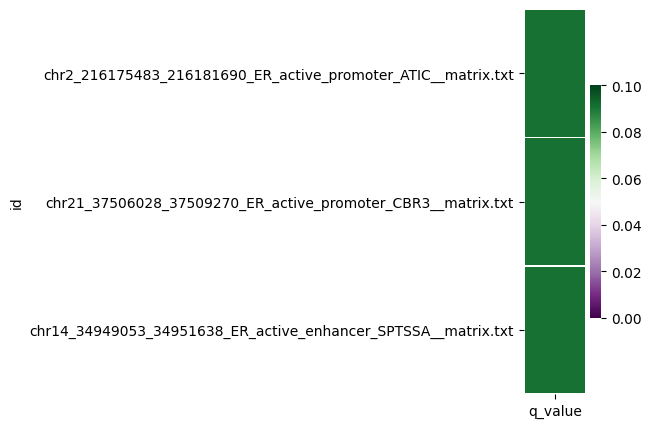

In [25]:
ER_Hartwig = pd.read_table("/home/darragh/New/eQTL/Hartwig/ER/output.txt", sep="\t", header=0)
ER_Hartwig = ER_Hartwig.iloc[:,[1,6]]
ER_Hartwig.columns = ['id', 'q_value']
ER_Hartwig = ER_Hartwig.loc[ER_Hartwig['q_value'] < 0.1]
ER_Hartwig = ER_Hartwig.set_index('id')

plt.figure(figsize=(1, 5))
sns.heatmap(ER_Hartwig,cmap='PRGn',vmin=0, vmax=0.1, linewidths = 0.5)

display(ER_Hartwig)

q_value
id                                                          
chr8_56506950_56508093_TN_active_enhancer_TMEM6...  0.064976
chr17_37805668_37807173_TN_active_enhancer_STAR...  0.064976

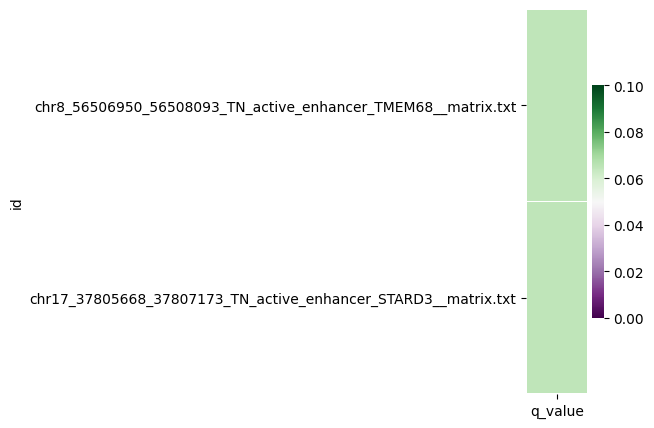

In [45]:
TN_Hartwig = pd.read_table("/home/darragh/New/eQTL/Hartwig/TN/output.txt", sep="\t", header=0)
TN_Hartwig = TN_Hartwig.iloc[:,[1,6]]
TN_Hartwig.columns = ['id', 'q_value']
TN_Hartwig = TN_Hartwig.loc[TN_Hartwig['q_value'] < 0.1]
TN_Hartwig = TN_Hartwig.set_index('id')

plt.figure(figsize=(1, 5))
sns.heatmap(TN_Hartwig,cmap='PRGn',vmin=0, vmax=0.1,linewidths = 0.5)

display(TN_Hartwig)

In [33]:
#Primary_Hartwig = Primary_Hartwig.merge(MCF7_unique_regs_genes, on="id")

display(HMEC_unique_regs_genes)

chr      start        end            annotation  \
0     chr1    1152914    1153599  HMEC_active_enhancer   
1     chr1    1152914    1153599  HMEC_active_enhancer   
2     chr1    1185370    1186583  HMEC_active_enhancer   
3     chr1    2165378    2167095  HMEC_active_enhancer   
4     chr1    2358993    2361139  HMEC_active_enhancer   
...    ...        ...        ...                   ...   
2646  chrX  148205222  148206510  HMEC_active_enhancer   
2647  chrX  148205222  148207024  HMEC_active_enhancer   
2648  chrX  148956797  148960116  HMEC_active_enhancer   
2649  chrX  148962228  148962908  HMEC_active_enhancer   
2650  chrX  149218693  149220054  HMEC_active_enhancer   

                            id      gene  
0         chr1_1152914_1153599      SDF4  
1         chr1_1152914_1153599   B3GALT6  
2         chr1_1185370_1186583  C1QTNF12  
3         chr1_2165378_2167095       SKI  
4         chr1_2358993_2361139     PEX10  
...                        ...       ...  
2646  chrX_148205222_148206510       IDS  
2647  chrX_148205222_148207024       IDS  
2648  chrX_148956797_148960116    MAGEA8  
2649  chrX_148962228_148962908    MAGEA8  
2650  chrX_149218693_149220054  CXorf40B  

[8360 rows x 6 columns]

In [2]:
import pandas as pd

In [3]:
Primary_Hartwig_eQTL = pd.read_table("/home/darragh/New/eQTL/Hartwig/Primary/output.txt", sep="\t", header=0)
Primary_Hartwig_eQTL[['chr', 'start', 'end', 'ann1','ann2', 'ann3', 'gene' , 'null1', 'null2']] = Primary_Hartwig_eQTL['id'].str.split("_", expand =True)


Primary_Hartwig_A = pd.read_table("/home/darragh/New/ActiveDriverWGS/output/Primary_regs_hartwig.txt", sep="\t", header=None)
Primary_Hartwig_A = Primary_Hartwig_A.iloc[:,[0,1]]
Primary_Hartwig_A.columns = ['id', 'p_value']

# Primary_Hartwig_D = pd.read_table("/home/darragh/New/DriverPower/Hartwig/Primary/output/Primary.result.tsv", sep="\t", header=0)
# Primary_Hartwig_D.columns = ['id', 'len_Hartwig', 'mutation_rate_D_Hartwig', 'patient_rate_D_Hartwig' ,'N_Hartwig', 'predicted_mutation_rate_D_Hartwig', 'p_value','q_value' ]
# Primary_Hartwig_D = Primary_Hartwig_D[['id', 'p_value' ]]

# Primary_Hartwig_PS = pd.concat([Primary_Hartwig_A,Primary_Hartwig_D ])
# Primary_Hartwig_PS = Primary_Hartwig_PS.groupby("id")['p_value'].min().reset_index()

####

Primary_Hartwig_eQTL['id'] = Primary_Hartwig_eQTL['chr'] + '_' + Primary_Hartwig_eQTL['start'] + '_' + Primary_Hartwig_eQTL['end'] 
Primary_Hartwig_eQTL['annotation'] = Primary_Hartwig_eQTL['ann2'] + '_' + Primary_Hartwig_eQTL['ann3'] 
Primary_Hartwig_eQTL = Primary_Hartwig_eQTL[['id', 'annotation', 'gene', 'p_value_RNA']]


Primary_Hartwig = Primary_Hartwig_eQTL.merge(Primary_Hartwig_A, on="id")


combined_p_value_list = []

Primary_Hartwig_ps = Primary_Hartwig[['p_value_RNA', 'p_value']]
Primary_Hartwig_ps = Primary_Hartwig_ps.to_numpy()
combined_p_value = np.array([combine_pvalues(i,method='stouffer',weights=None) for i in Primary_Hartwig_ps])

for i in combined_p_value:
    combined_p_value_list.append(i[1])

Primary_Hartwig['combined_p'] = pd.DataFrame(combined_p_value_list)
Primary_Hartwig['q_value'] = multipletests(Primary_Hartwig['combined_p'] , method='fdr_bh')[1]

Primary_Hartwig.to_csv("/home/darragh/New/eQTL/Primary_combined_with_GLM.txt", sep="\t")

signif = Primary_Hartwig.loc[(Primary_Hartwig['q_value'] < 0.1) & (Primary_Hartwig['p_value_RNA'] < 0.05) & (Primary_Hartwig['p_value'] < 0.05) ]
# signif.to_csv("/home/darragh/New/eQTL/Hartwig/TN/all/combined_with_GLM.signif.txt", sep="\t")


# display(Primary_hartwig_tested)
display(signif)


ValueError: Columns must be same length as key

In [4]:
ER_Hartwig_eQTL = pd.read_table("/home/darragh/New/eQTL/Hartwig/ER/output.txt", sep="\t", header=0)
ER_Hartwig_eQTL[['chr', 'start', 'end', 'ann1','ann2', 'ann3', 'gene' , 'null1', 'null2']] = ER_Hartwig_eQTL['id'].str.split("_", expand =True)


ER_Hartwig_A = pd.read_table("/home/darragh/New/ActiveDriverWGS/output/ER_regs_hartwig.txt", sep="\t", header=None)
ER_Hartwig_A = ER_Hartwig_A.iloc[:,[0,1]]
ER_Hartwig_A.columns = ['id', 'p_value']

# Primary_Hartwig_D = pd.read_table("/home/darragh/New/DriverPower/Hartwig/Primary/output/Primary.result.tsv", sep="\t", header=0)
# Primary_Hartwig_D.columns = ['id', 'len_Hartwig', 'mutation_rate_D_Hartwig', 'patient_rate_D_Hartwig' ,'N_Hartwig', 'predicted_mutation_rate_D_Hartwig', 'p_value','q_value' ]
# Primary_Hartwig_D = Primary_Hartwig_D[['id', 'p_value' ]]

# Primary_Hartwig_PS = pd.concat([Primary_Hartwig_A,Primary_Hartwig_D ])
# Primary_Hartwig_PS = Primary_Hartwig_PS.groupby("id")['p_value'].min().reset_index()

####

ER_Hartwig_eQTL['id'] = ER_Hartwig_eQTL['chr'] + '_' + ER_Hartwig_eQTL['start'] + '_' + ER_Hartwig_eQTL['end'] 
ER_Hartwig_eQTL['annotation'] = ER_Hartwig_eQTL['ann2'] + '_' + ER_Hartwig_eQTL['ann3'] 
ER_Hartwig_eQTL = ER_Hartwig_eQTL[['id', 'annotation', 'gene', 'p_value_RNA']]


ER_Hartwig = ER_Hartwig_eQTL.merge(ER_Hartwig_A, on="id")


combined_p_value_list = []

ER_Hartwig_ps = ER_Hartwig[['p_value_RNA', 'p_value']]
ER_Hartwig_ps = ER_Hartwig_ps.to_numpy()
combined_p_value = np.array([combine_pvalues(i,method='stouffer',weights=None) for i in ER_Hartwig_ps])

for i in combined_p_value:
    combined_p_value_list.append(i[1])

ER_Hartwig['combined_p'] = pd.DataFrame(combined_p_value_list)
ER_Hartwig['q_value'] = multipletests(ER_Hartwig['combined_p'] , method='fdr_bh')[1]

ER_Hartwig.to_csv("/home/darragh/New/eQTL/ER_combined_with_GLM.txt", sep="\t")

signif = ER_Hartwig.loc[(ER_Hartwig['q_value'] < 0.1) & (ER_Hartwig['p_value_RNA'] < 0.05) & (ER_Hartwig['p_value'] < 0.05) ]
# signif.to_csv("/home/darragh/New/eQTL/Hartwig/TN/all/combined_with_GLM.signif.txt", sep="\t")


# display(Primary_hartwig_tested)
display(signif)

id       annotation    gene  p_value_RNA  \
26       chr6_76562192_76562941  active_enhancer   SENP6     0.006738   
27       chr6_76562192_76562941  active_enhancer    MYO6     0.009532   
152    chr8_145016164_145019366  active_enhancer   DGAT1     0.015261   
154    chr8_145016164_145019366  active_enhancer  COMMD5     0.006767   
156    chr8_145016164_145019366  active_enhancer   GRINA     0.016374   
...                         ...              ...     ...          ...   
20861    chr1_65379857_65384457  active_enhancer    JAK1     0.022632   
21343  chr9_140352526_140354529  active_promoter  PNPLA7     0.016646   
21398   chr14_54700390_54701233  active_enhancer   CDKN3     0.039314   
22915  chr8_142163293_142165262  active_enhancer    PTK2     0.014151   
23314     chr10_5533423_5536858  active_enhancer  CALML5     0.013478   

        p_value  combined_p   q_value  
26     0.003899    0.000142  0.017756  
27     0.003899    0.000201  0.022347  
152    0.030251    0.002138  0.088532  
154    0.030251    0.001058  0.059246  
156    0.030251    0.002276  0.092159  
...         ...         ...       ...  
20861  0.006788    0.000786  0.051414  
21343  0.008293    0.000689  0.047847  
21398  0.001625    0.000443  0.037703  
22915  0.005524    0.000408  0.035078  
23314  0.012793    0.000837  0.053107  

[233 rows x 7 columns]

In [3]:
TN_Hartwig_eQTL = pd.read_table("/home/darragh/New/eQTL/Hartwig/TN/output.txt", sep="\t", header=0)
TN_Hartwig_eQTL[['chr', 'start', 'end', 'ann1','ann2', 'ann3', 'gene' , 'null1', 'null2']] = TN_Hartwig_eQTL['id'].str.split("_", expand =True)


TN_Hartwig_A = pd.read_table("/home/darragh/New/ActiveDriverWGS/output/TN_regs_hartwig.txt", sep="\t", header=None)
TN_Hartwig_A = TN_Hartwig_A.iloc[:,[0,1]]
TN_Hartwig_A.columns = ['id', 'p_value']


####

TN_Hartwig_eQTL['id'] = TN_Hartwig_eQTL['chr'] + '_' + TN_Hartwig_eQTL['start'] + '_' + TN_Hartwig_eQTL['end'] 
TN_Hartwig_eQTL['annotation'] = TN_Hartwig_eQTL['ann2'] + '_' + TN_Hartwig_eQTL['ann3'] 
TN_Hartwig_eQTL = TN_Hartwig_eQTL[['id', 'annotation', 'gene', 'p_value_RNA']]


TN_Hartwig = TN_Hartwig_eQTL.merge(TN_Hartwig_A, on="id")


combined_p_value_list = []

TN_Hartwig_ps = TN_Hartwig[['p_value_RNA', 'p_value']]
TN_Hartwig_ps = TN_Hartwig_ps.to_numpy()
combined_p_value = np.array([combine_pvalues(i,method='stouffer',weights=None) for i in TN_Hartwig_ps])

for i in combined_p_value:
    combined_p_value_list.append(i[1])

TN_Hartwig['combined_p'] = pd.DataFrame(combined_p_value_list)
TN_Hartwig['q_value'] = multipletests(TN_Hartwig['combined_p'] , method='fdr_bh')[1]

TN_Hartwig.to_csv("/home/darragh/New/eQTL/TN_combined_with_GLM.txt", sep="\t")

signif = TN_Hartwig.loc[(TN_Hartwig['q_value'] < 0.1) & (TN_Hartwig['p_value_RNA'] < 0.05) & (TN_Hartwig['p_value'] < 0.05) ]
# signif.to_csv("/home/darragh/New/eQTL/Hartwig/TN/all/combined_with_GLM.signif.txt", sep="\t")


# display(Primary_hartwig_tested)
display(signif)


id       annotation      gene  p_value_RNA  \
1799   chr12_105606998_105610294  active_enhancer  C12orf75     0.005059   
2879    chr4_160311017_160312613  active_enhancer     ETFDH     0.016677   
2881    chr4_160311017_160312613  active_enhancer   C4orf46     0.042755   
2884    chr4_160311017_160312613  active_enhancer      PPID     0.000019   
3141     chr22_38172041_38174315  active_enhancer   ANKRD54     0.003843   
...                          ...              ...       ...          ...   
39080    chr20_22672094_22673031  active_enhancer      THBD     0.001390   
40724     chr1_16938547_16940734  active_promoter     NBPF1     0.003080   
41255    chr17_46695728_46696668  active_enhancer     HOXB7     0.004021   
41698       chr2_8230673_8232115  active_enhancer       ID2     0.001464   
42427    chr20_10413595_10416946  active_promoter    SLX4IP     0.018282   

        p_value    combined_p   q_value  
1799   0.007008  1.884564e-04  0.055537  
2879   0.000714  8.509725e-05  0.037736  
2881   0.000714  2.593291e-04  0.068999  
2884   0.000714  1.194147e-07  0.000391  
3141   0.005018  1.055576e-04  0.040852  
...         ...           ...       ...  
39080  0.019445  1.747794e-04  0.055115  
40724  0.015191  2.623593e-04  0.069183  
41255  0.000299  8.486485e-06  0.008812  
41698  0.044569  4.733965e-04  0.093301  
42427  0.002228  2.422203e-04  0.065263  

[94 rows x 7 columns]

X id                       annotation      gene   p_value_RNA p_value  
1 0 chr1_113276605_113280474 active_enhancer RHOC   0.9407541   0.3500279
2 1 chr1_113276605_113280474 active_enhancer LRIG2  0.6581102   0.3500279
3 2 chr1_113276605_113280474 active_enhancer PPM1J  0.9287337   0.3500279
4 3 chr4_46508298_46511026   active_enhancer NIPAL1 0.3385249   0.3141210
5 4 chr4_46508298_46511026   active_enhancer GNPDA2 0.3166635   0.3141210
6 5 chr4_46508298_46511026   active_enhancer SLAIN2 0.7295037   0.3141210
  combined_p q_value   colour size
1 0.7971487  1.0000000 ns     0.3 
2 0.5062244  0.9750464 ns     0.3 
3 0.7777182  1.0000000 ns     0.3 
4 0.2620991  0.8659003 ns     0.3 
5 0.2483448  0.8549943 ns     0.3 
6 0.5358089  0.9811464 ns     0.3

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


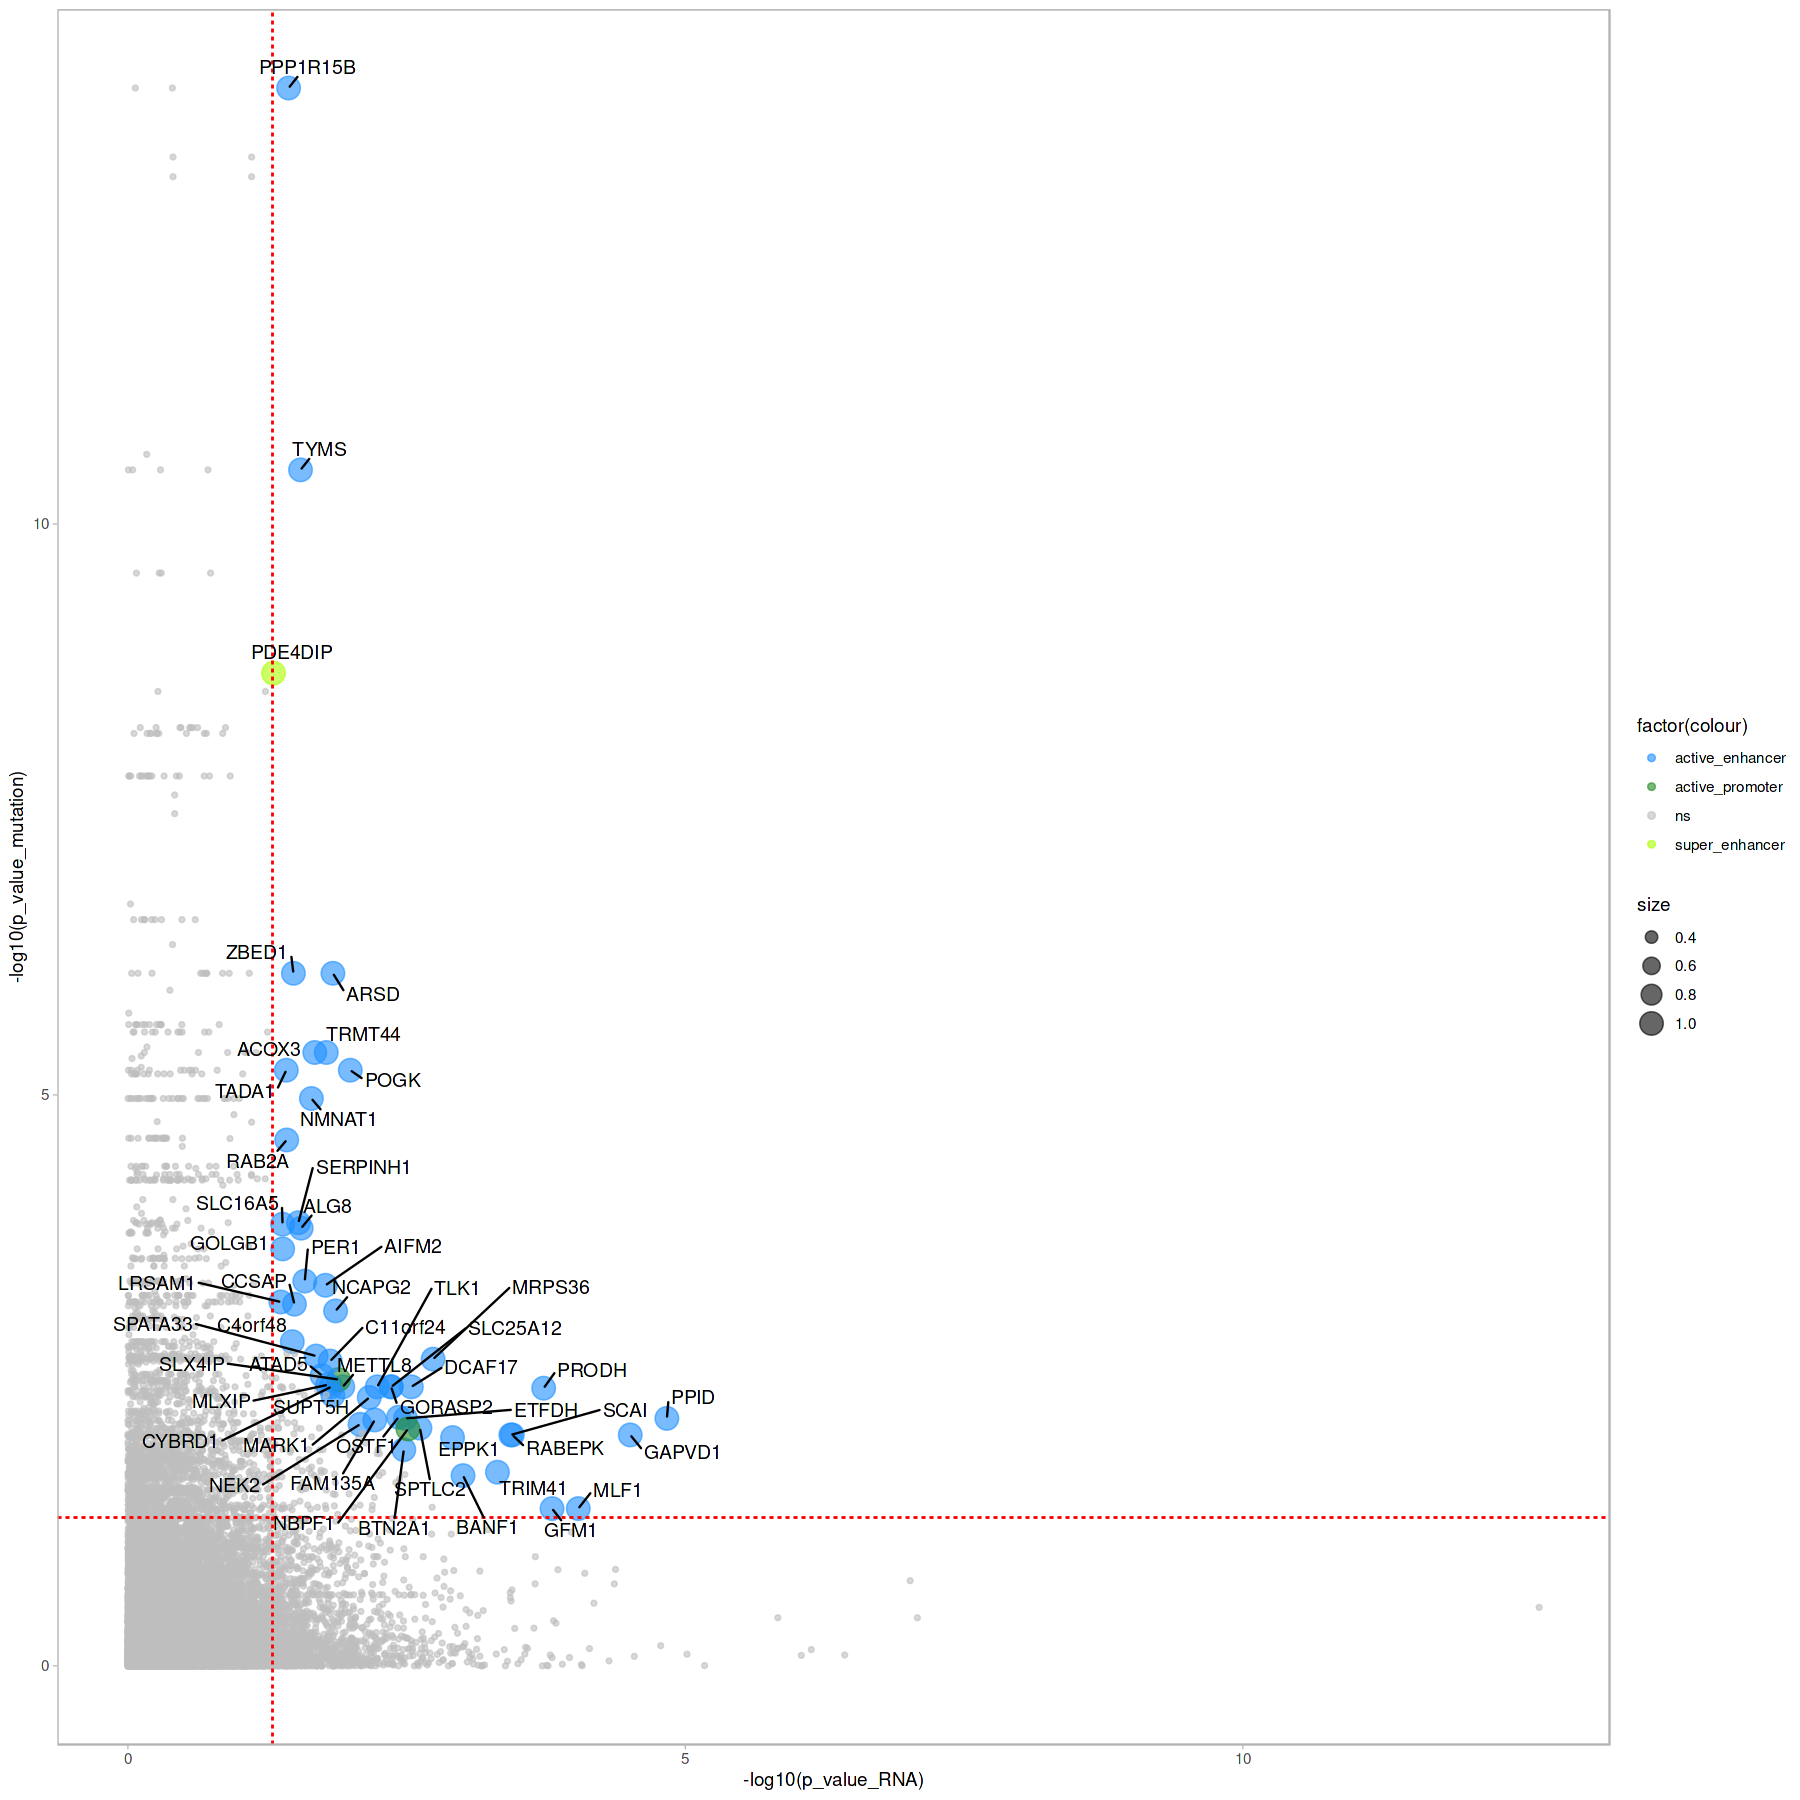

In [1]:
library(ggplot2)
library(ggrepel)

file = read.delim("/home/darragh/New/eQTL/Primary_combined_with_GLM.txt", header = T)
#file$annotation = as.factor(file$annotation)
file$colour = NA
file$size = 1

file$colour[file$annotation == "super_enhancer"] <- "super_enhancer"
file$colour[file$annotation == "active_enhancer"] <- "active_enhancer"
file$colour[file$annotation == "active_promoter"] <- "active_promoter"
file$colour[file$annotation == "polycomb_promoter"] <- "polycomb_promoter"

file$colour[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- "ns"

file$size[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- 0.3


file_2 <- file[(file$q_value <= 0.05) & (file$p_value_RNA <= 0.05) & (file$p_value <= 0.05), ]

# genes_i_like = c(""  )
# file_2 <- file_2[file_2$gene %in% genes_i_like,]

options(repr.plot.width=15, repr.plot.height=15)

head(file)

ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "grey", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) +geom_hline(yintercept=-log10(0.05),color="red", size=0.6,linetype="dashed") + geom_vline(xintercept=-log10(0.05),color="red", size=0.6,linetype="dashed") +
 geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black")

id                       X     annotation      gene   p_value_RNA
269  chr1_220686694_220690688 23415 active_enhancer MARK1  0.006849349
3178 chr3_121449316_121451224 19902 active_enhancer GOLGB1 0.040923620
     p_value      combined_p   q_value    Fold     FDR          colour         
269  0.0044687749 0.0001642320 0.03243648 3.405173 1.283578e-05 active_enhancer
3178 0.0002231759 0.0001023697 0.02445466 2.886925 5.670797e-04 active_enhancer
     size
269  1   
3178 1

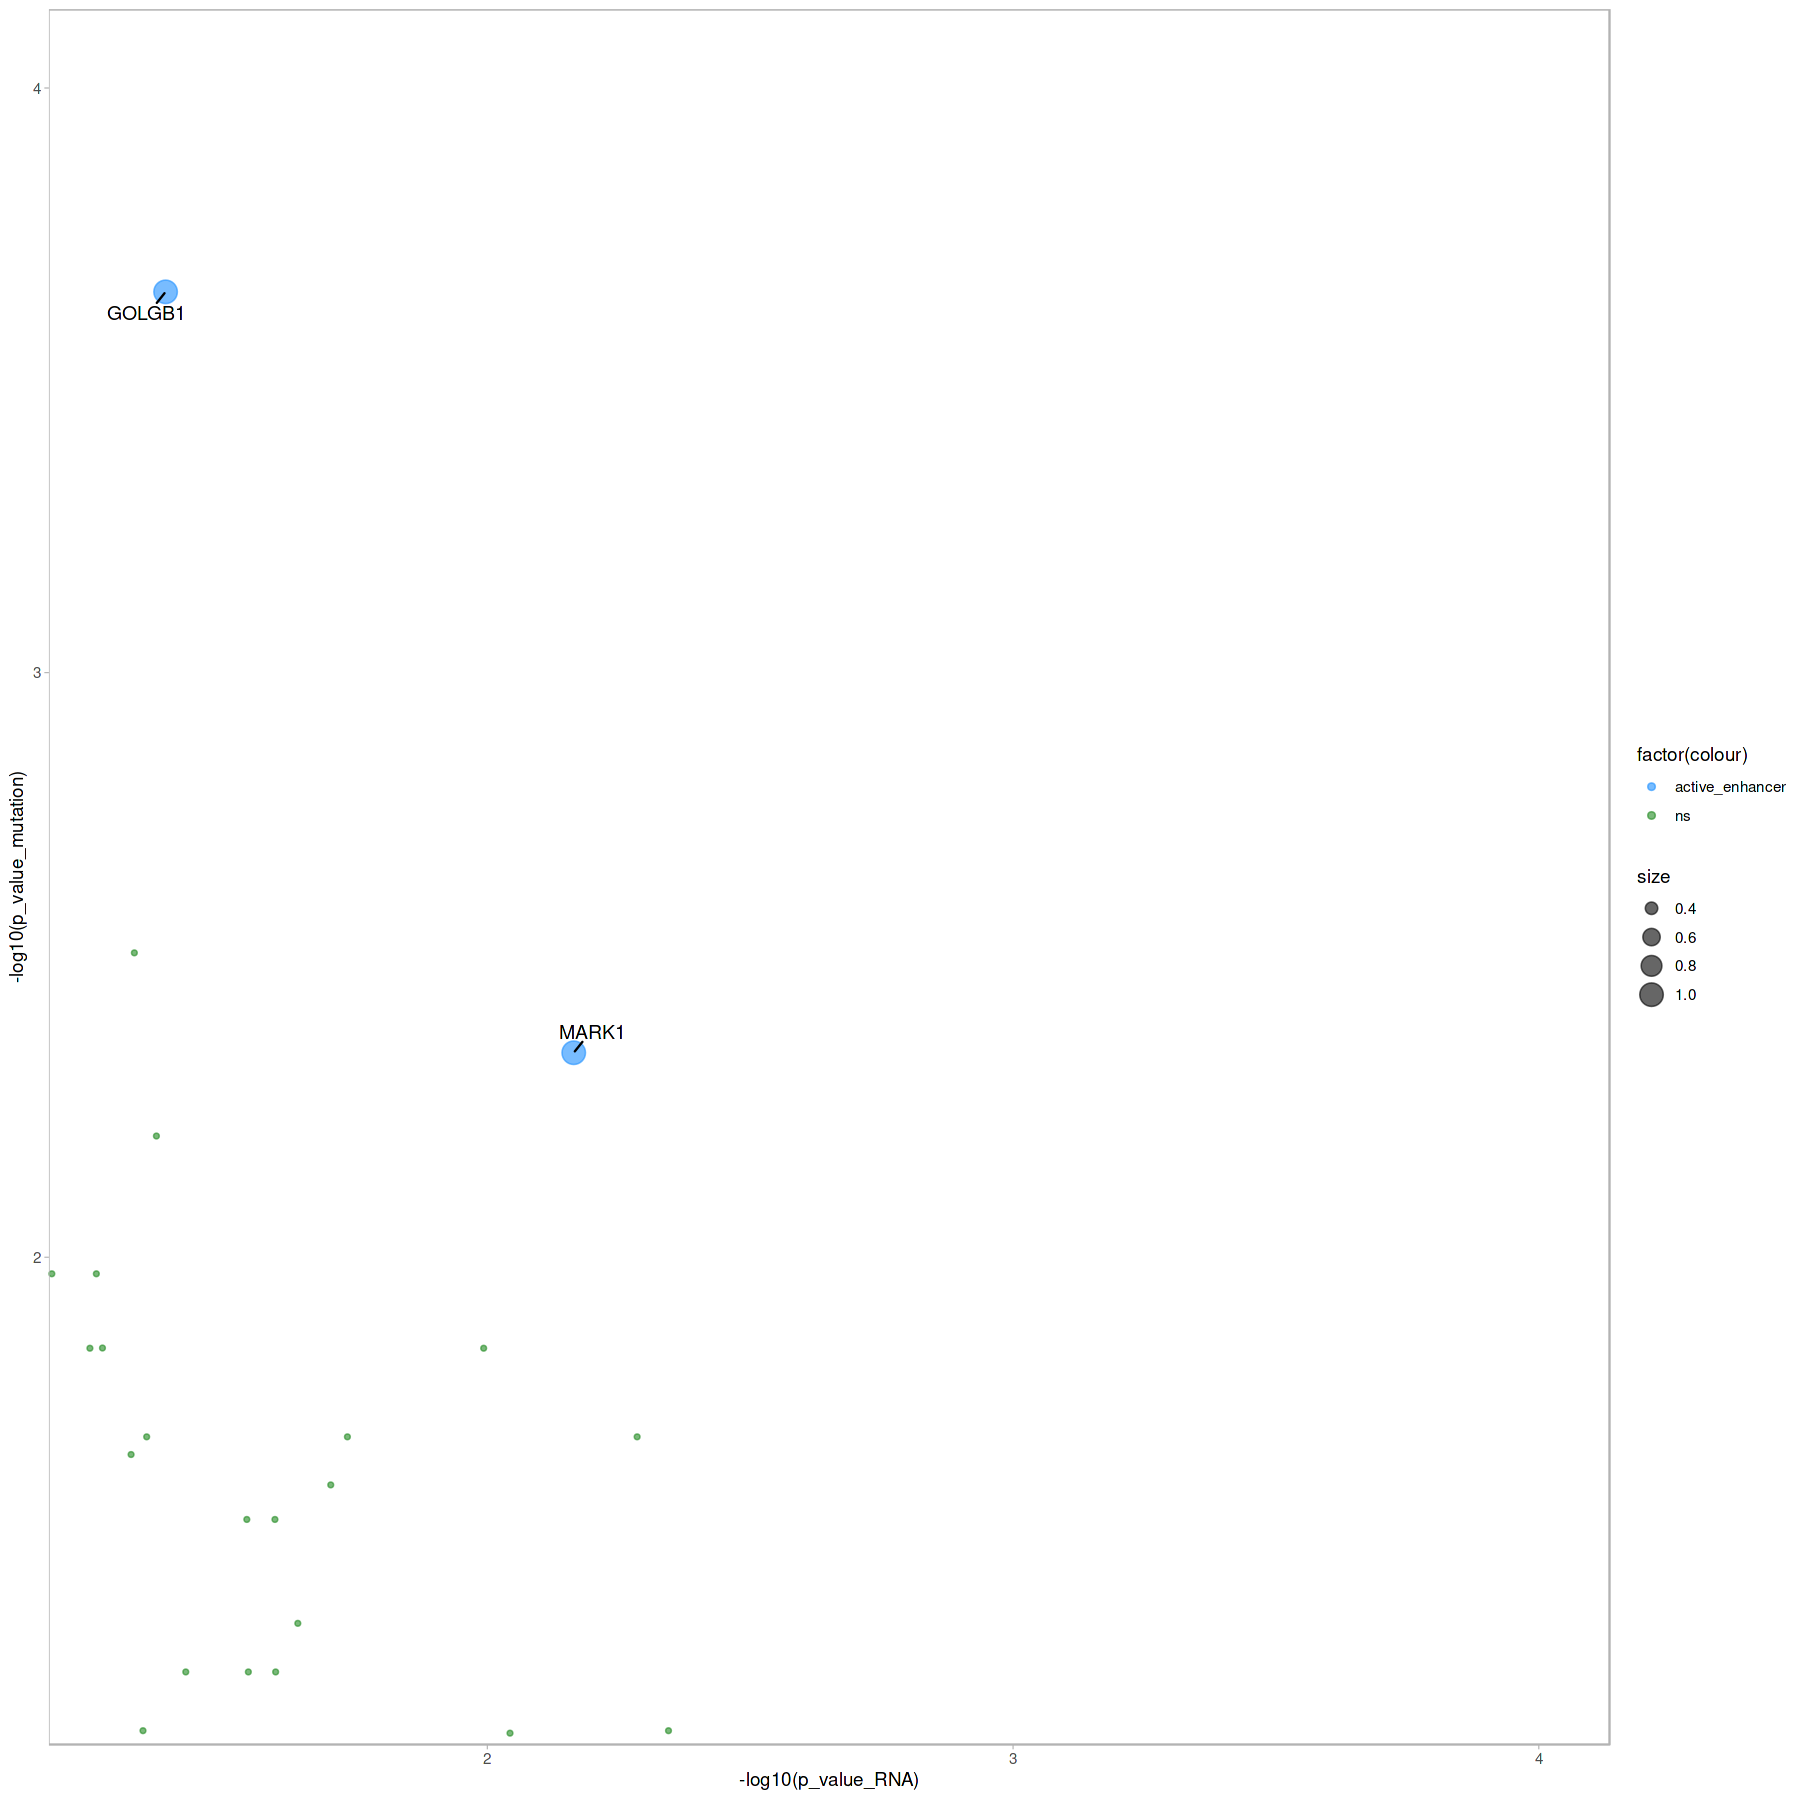

In [10]:
# repeat plot but for unique only

file = read.delim("/home/darragh/New/eQTL/Primary_combined_with_GLM.txt", header = T)

Primary_unique = read.delim("/home/darragh/New/Differentially_active/Non_cancer/output_fold1.txt", header = T)
Primary_unique$id = paste(Primary_unique$seqnames, Primary_unique$start, Primary_unique$end, sep="_")
Primary_unique = Primary_unique[,c("id", "Fold", "FDR")]
Primary_unique$Fold = Primary_unique$Fold*-1
Primary_unique = Primary_unique[Primary_unique$Fold >1.5,]
Primary_unique = Primary_unique[Primary_unique$FDR <0.05,]


file = merge(file, Primary_unique)


file$colour = NA
file$size = 1

file$colour[file$annotation == "super_enhancer"] <- "super_enhancer"
file$colour[file$annotation == "active_enhancer"] <- "active_enhancer"
file$colour[file$annotation == "active_promoter"] <- "active_promoter"
file$colour[file$annotation == "polycomb_promoter"] <- "polycomb_promoter"

file$colour[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- "ns"

file$size[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- 0.3


file_2 <- file[(file$q_value <= 0.05) & (file$p_value_RNA <= 0.05) & (file$p_value <= 0.05), ]


options(repr.plot.width=15, repr.plot.height=15)

head(file_2, 10L)

# ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "grey", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) + coord_cartesian(xlim = c(-log10(0.05),5), ylim=c(-log10(0.05),3.5)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) 
#  geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black") 

ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "grey", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) + coord_cartesian(xlim = c(-log10(0.05),4), ylim=c(-log10(0.05),4)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank())  +
 geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


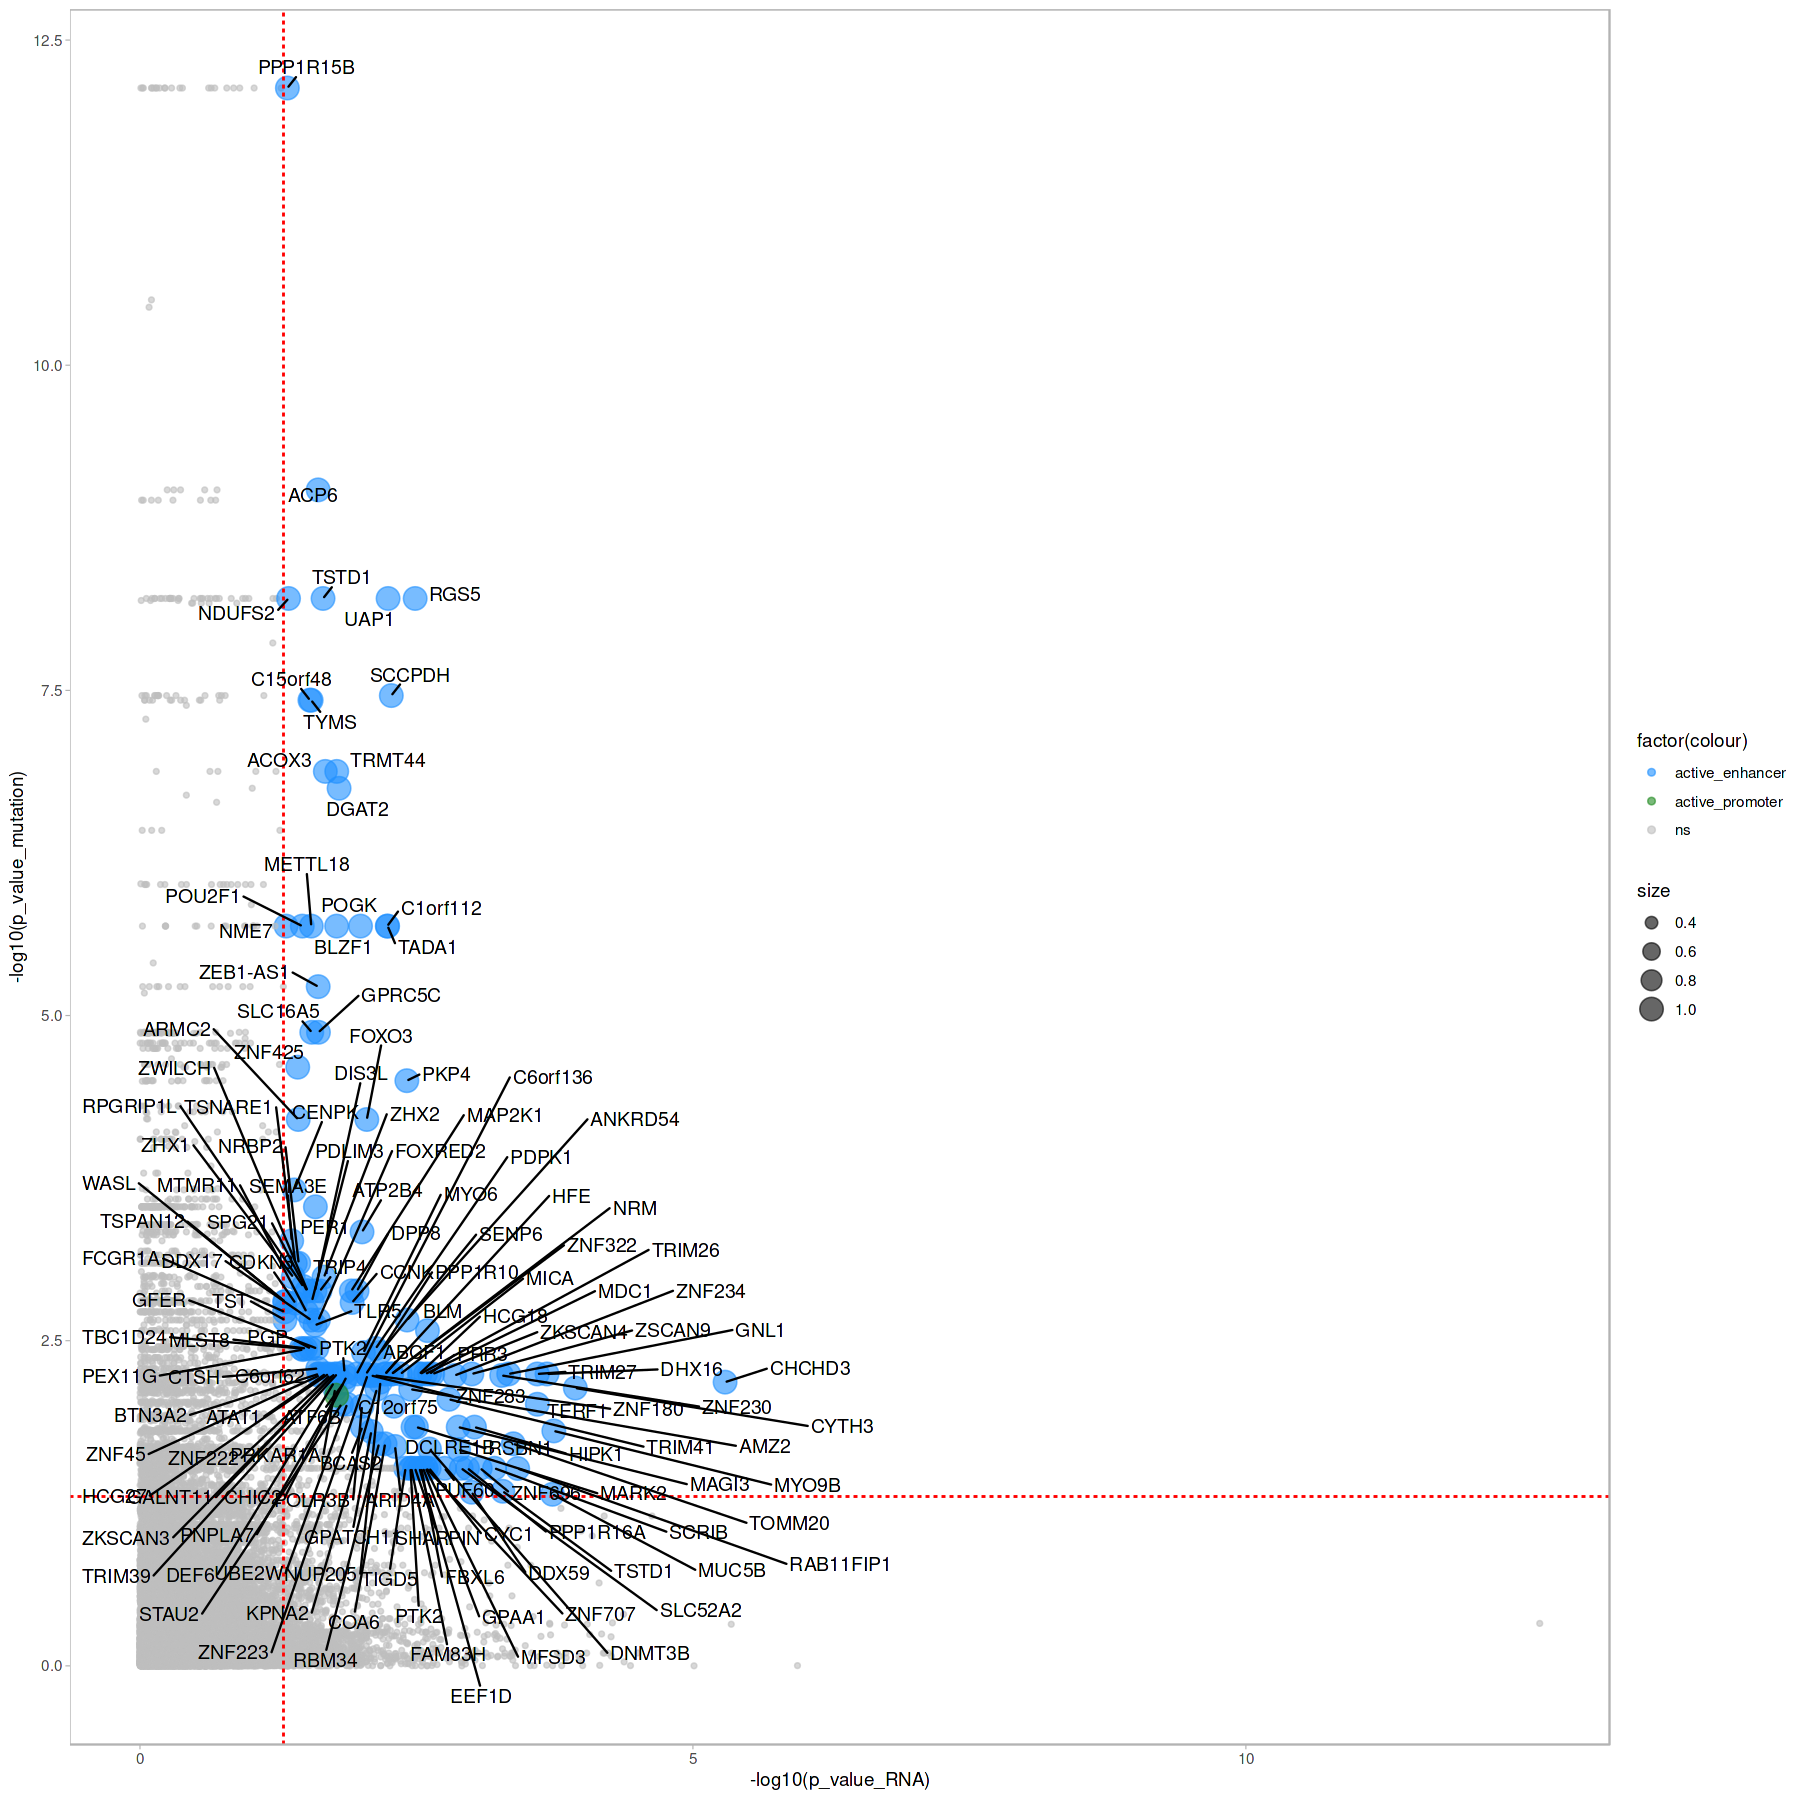

In [1]:
library(ggplot2)
library(ggrepel)

file = read.delim("/home/darragh/New/eQTL/ER_combined_with_GLM.txt", header = T)
#file$annotation = as.factor(file$annotation)
file$colour = NA
file$size = 1

file$colour[file$annotation == "super_enhancer"] <- "super_enhancer"
file$colour[file$annotation == "active_enhancer"] <- "active_enhancer"
file$colour[file$annotation == "active_promoter"] <- "active_promoter"
file$colour[file$annotation == "polycomb_promoter"] <- "polycomb_promoter"

file$colour[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- "ns"

file$size[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- 0.3


file_2 <- file[(file$q_value <= 0.05) & (file$p_value_RNA <= 0.05) & (file$p_value <= 0.05), ]

#genes_i_like = c(""  )
#file_2 <- file_2[file_2$gene %in% genes_i_like,]

options(repr.plot.width=15, repr.plot.height=15)

ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "grey", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) +geom_hline(yintercept=-log10(0.05),color="red", size=0.6,linetype="dashed") + geom_vline(xintercept=-log10(0.05),color="red", size=0.6,linetype="dashed") +
 geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black")

id                        X     annotation      gene     p_value_RNA 
359  chr12_105607100_105610304 12151 active_enhancer POLR3B   0.0098293640
364  chr12_105607100_105610304 12154 active_enhancer C12orf75 0.0050592934
739  chr16_53544025_53546372   10958 active_enhancer RPGRIP1L 0.0333513989
1779 chr7_122473991_122475051  17557 active_enhancer WASL     0.0487178205
1785 chr7_122473991_122475051  17555 active_enhancer TSPAN12  0.0492173104
1947 chr8_74242469_74243762    15417 active_enhancer TERF1    0.0002553283
1951 chr8_74242469_74243762    15416 active_enhancer STAU2    0.0150656011
1954 chr8_74242469_74243762    15423 active_enhancer UBE2W    0.0134137235
     p_value     combined_p   q_value     Fold     FDR          colour         
359  0.010091381 4.972128e-04 0.040331542 1.876250 4.517558e-02 active_enhancer
364  0.010091381 2.690229e-04 0.026168491 1.876250 4.517558e-02 active_enhancer
739  0.001210755 2.895245e-04 0.027168750 1.543978 2.908273e-02 active_enhancer
1779 0.001586159 5.603948e-04 0.043117969 5.921762 7.081632e-05 active_enhancer
1785 0.001586159 5.673109e-04 0.043350041 5.921762 7.081632e-05 active_enhancer
1947 0.009740614 1.985105e-05 0.004279422 2.259632 5.495398e-03 active_enhancer
1951 0.009740614 7.232691e-04 0.049000566 2.259632 5.495398e-03 active_enhancer
1954 0.009740614 6.465980e-04 0.046603742 2.259632 5.495398e-03 active_enhancer
     size
359  1   
364  1   
739  1   
1779 1   
1785 1   
1947 1   
1951 1   
1954 1

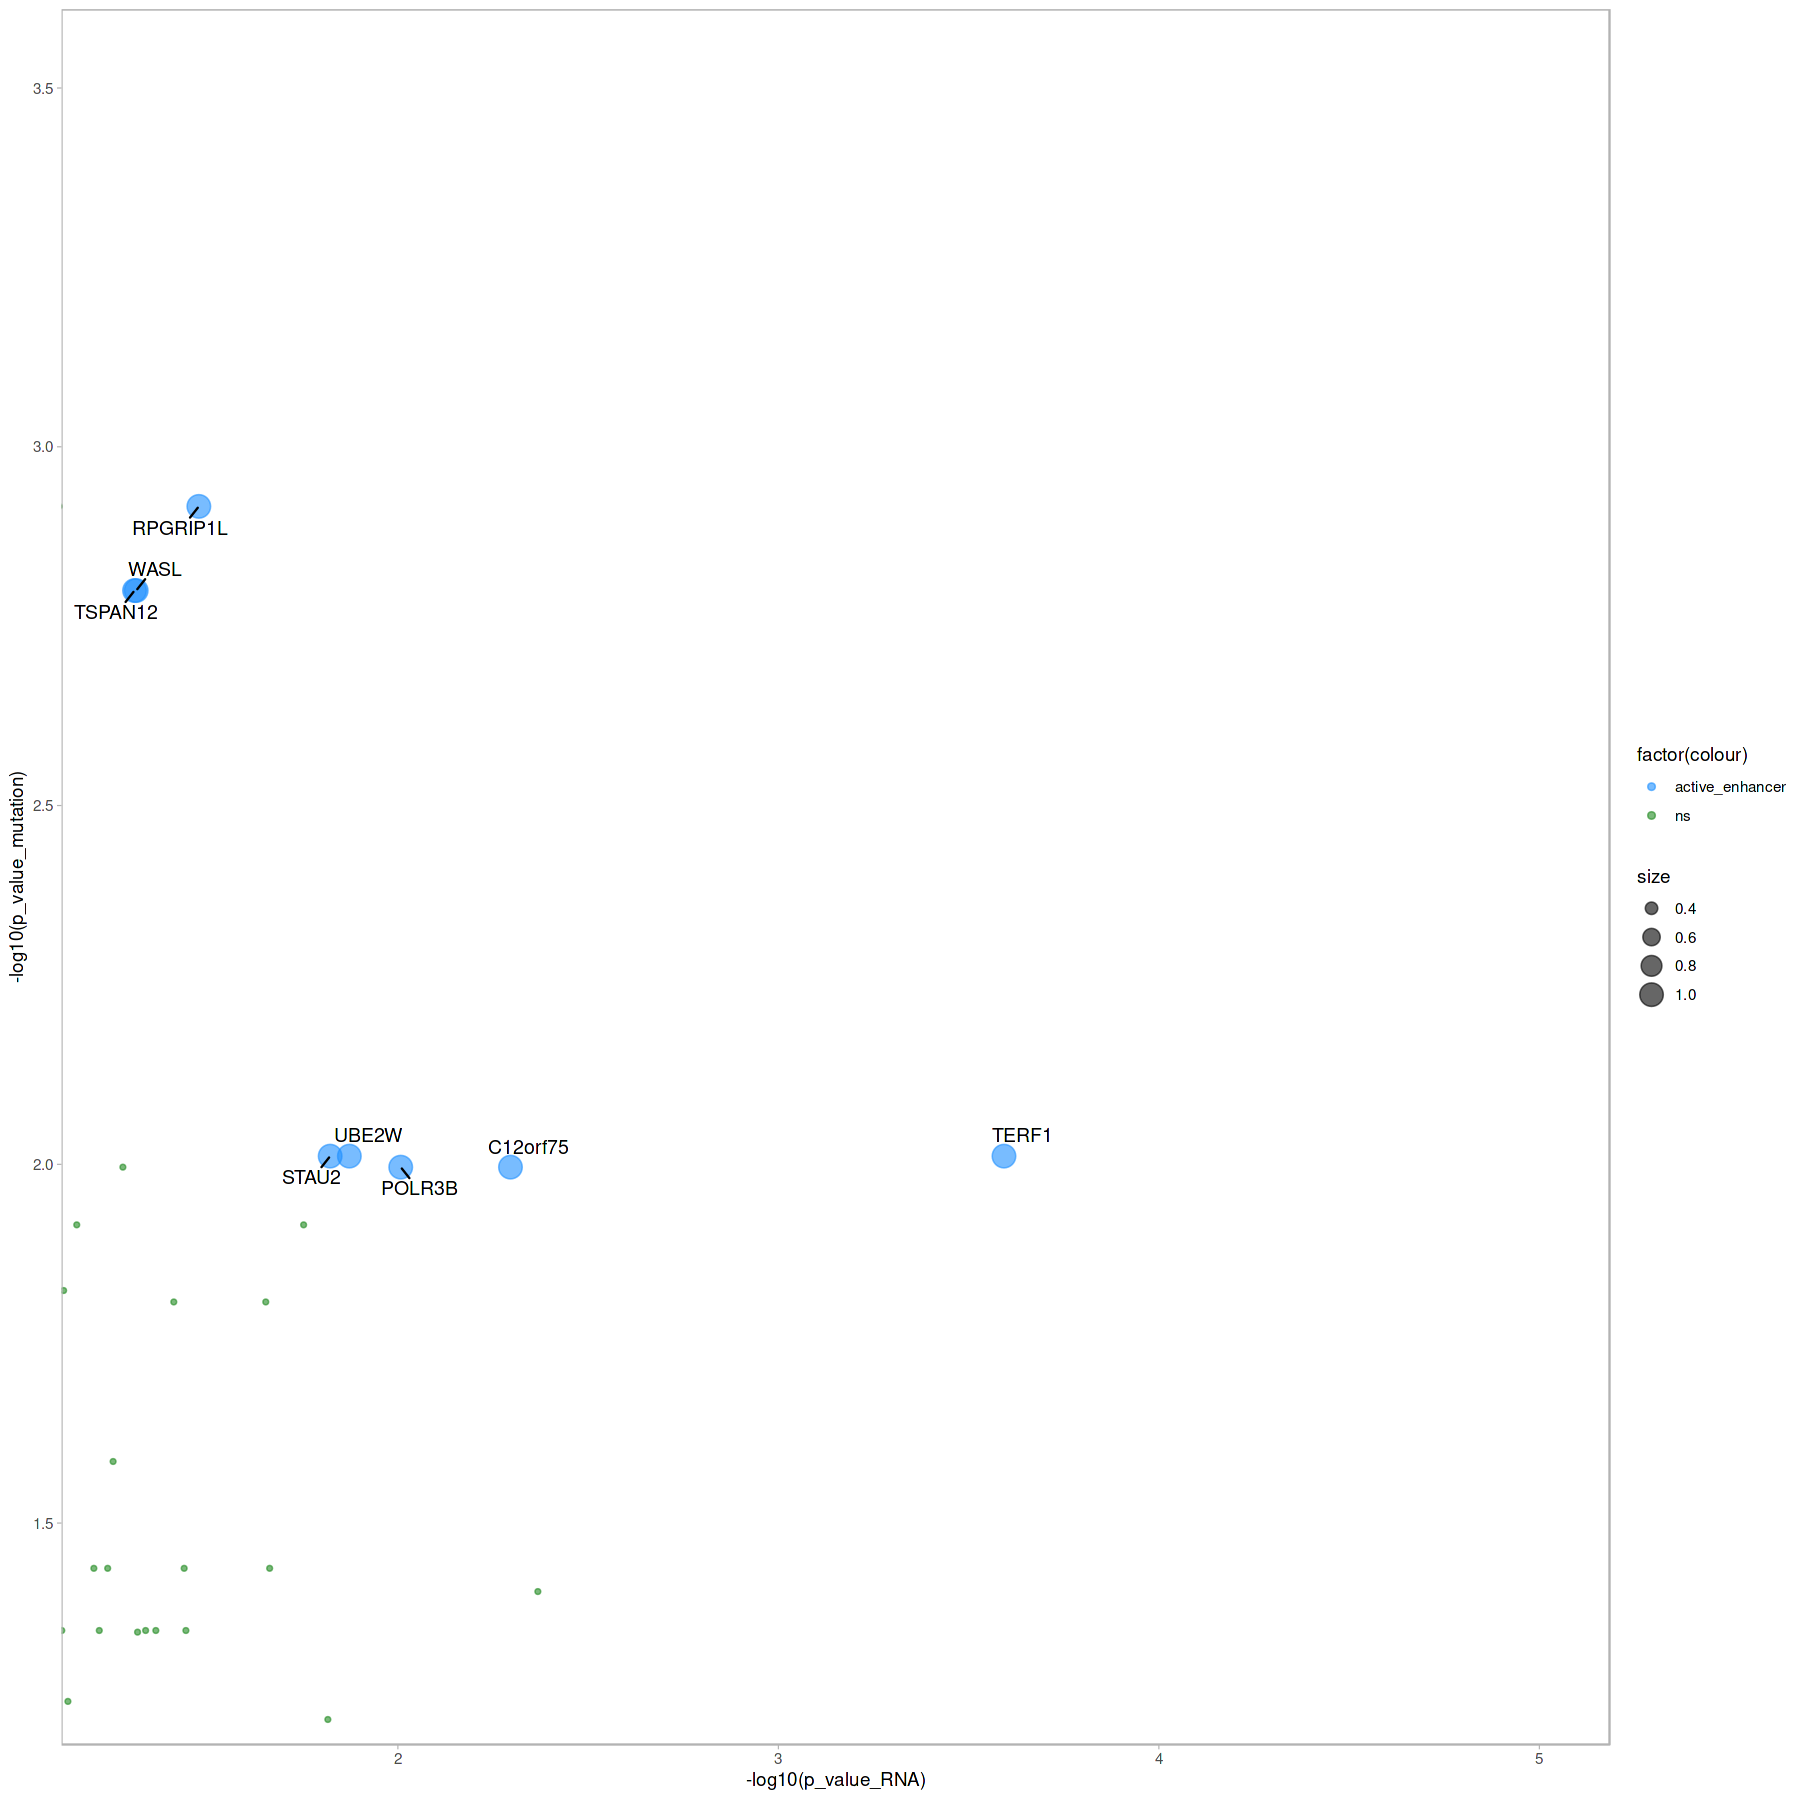

In [11]:
# repeat plot but for unique only

file = read.delim("/home/darragh/New/eQTL/ER_combined_with_GLM.txt", header = T)

ER_unique = read.delim("/home/darragh/New/Differentially_active/ER/output_fold1.txt", header = T)
ER_unique$id = paste(ER_unique$seqnames, ER_unique$start, ER_unique$end, sep="_")
ER_unique = ER_unique[,c("id", "Fold", "FDR")]
ER_unique$Fold = ER_unique$Fold*-1
ER_unique = ER_unique[ER_unique$Fold >1.5,]
ER_unique = ER_unique[ER_unique$FDR <0.05,]

file = merge(file, ER_unique)


file$colour = NA
file$size = 1

file$colour[file$annotation == "super_enhancer"] <- "super_enhancer"
file$colour[file$annotation == "active_enhancer"] <- "active_enhancer"
file$colour[file$annotation == "active_promoter"] <- "active_promoter"
file$colour[file$annotation == "polycomb_promoter"] <- "polycomb_promoter"

file$colour[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- "ns"

file$size[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- 0.3


file_2 <- file[(file$q_value <= 0.05) & (file$p_value_RNA <= 0.05) & (file$p_value <= 0.05), ]


options(repr.plot.width=15, repr.plot.height=15)

head(file_2, 10L)

# ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "grey", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) + coord_cartesian(xlim = c(-log10(0.05),5), ylim=c(-log10(0.05),3.5)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) 
#  geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black") 

ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "grey", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) + coord_cartesian(xlim = c(-log10(0.05),5), ylim=c(-log10(0.05),3.5)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank())  +
 geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black")



X id                    annotation      gene   p_value_RNA p_value  
1 0 chr17_7737044_7740335 active_enhancer USP43  0.07467827  0.2629722
2 1 chr17_7737044_7740335 active_enhancer ACAP1  0.29769258  0.2629722
3 2 chr17_7737044_7740335 active_enhancer PER1   0.74020339  0.2629722
4 3 chr17_7737044_7740335 active_enhancer KCNAB3 0.85630740  0.2629722
5 4 chr17_7737044_7740335 active_enhancer KCTD11 0.57976717  0.2629722
6 5 chr17_7737044_7740335 active_enhancer MPDU1  0.31308469  0.2629722
  combined_p q_value   colour size
1 0.07105675 0.7033148 ns     0.3 
2 0.20498068 0.9339698 ns     0.3 
3 0.50275418 1.0000000 ns     0.3 
4 0.61936741 1.0000000 ns     0.3 
5 0.37975872 1.0000000 ns     0.3 
6 0.21391706 0.9406787 ns     0.3

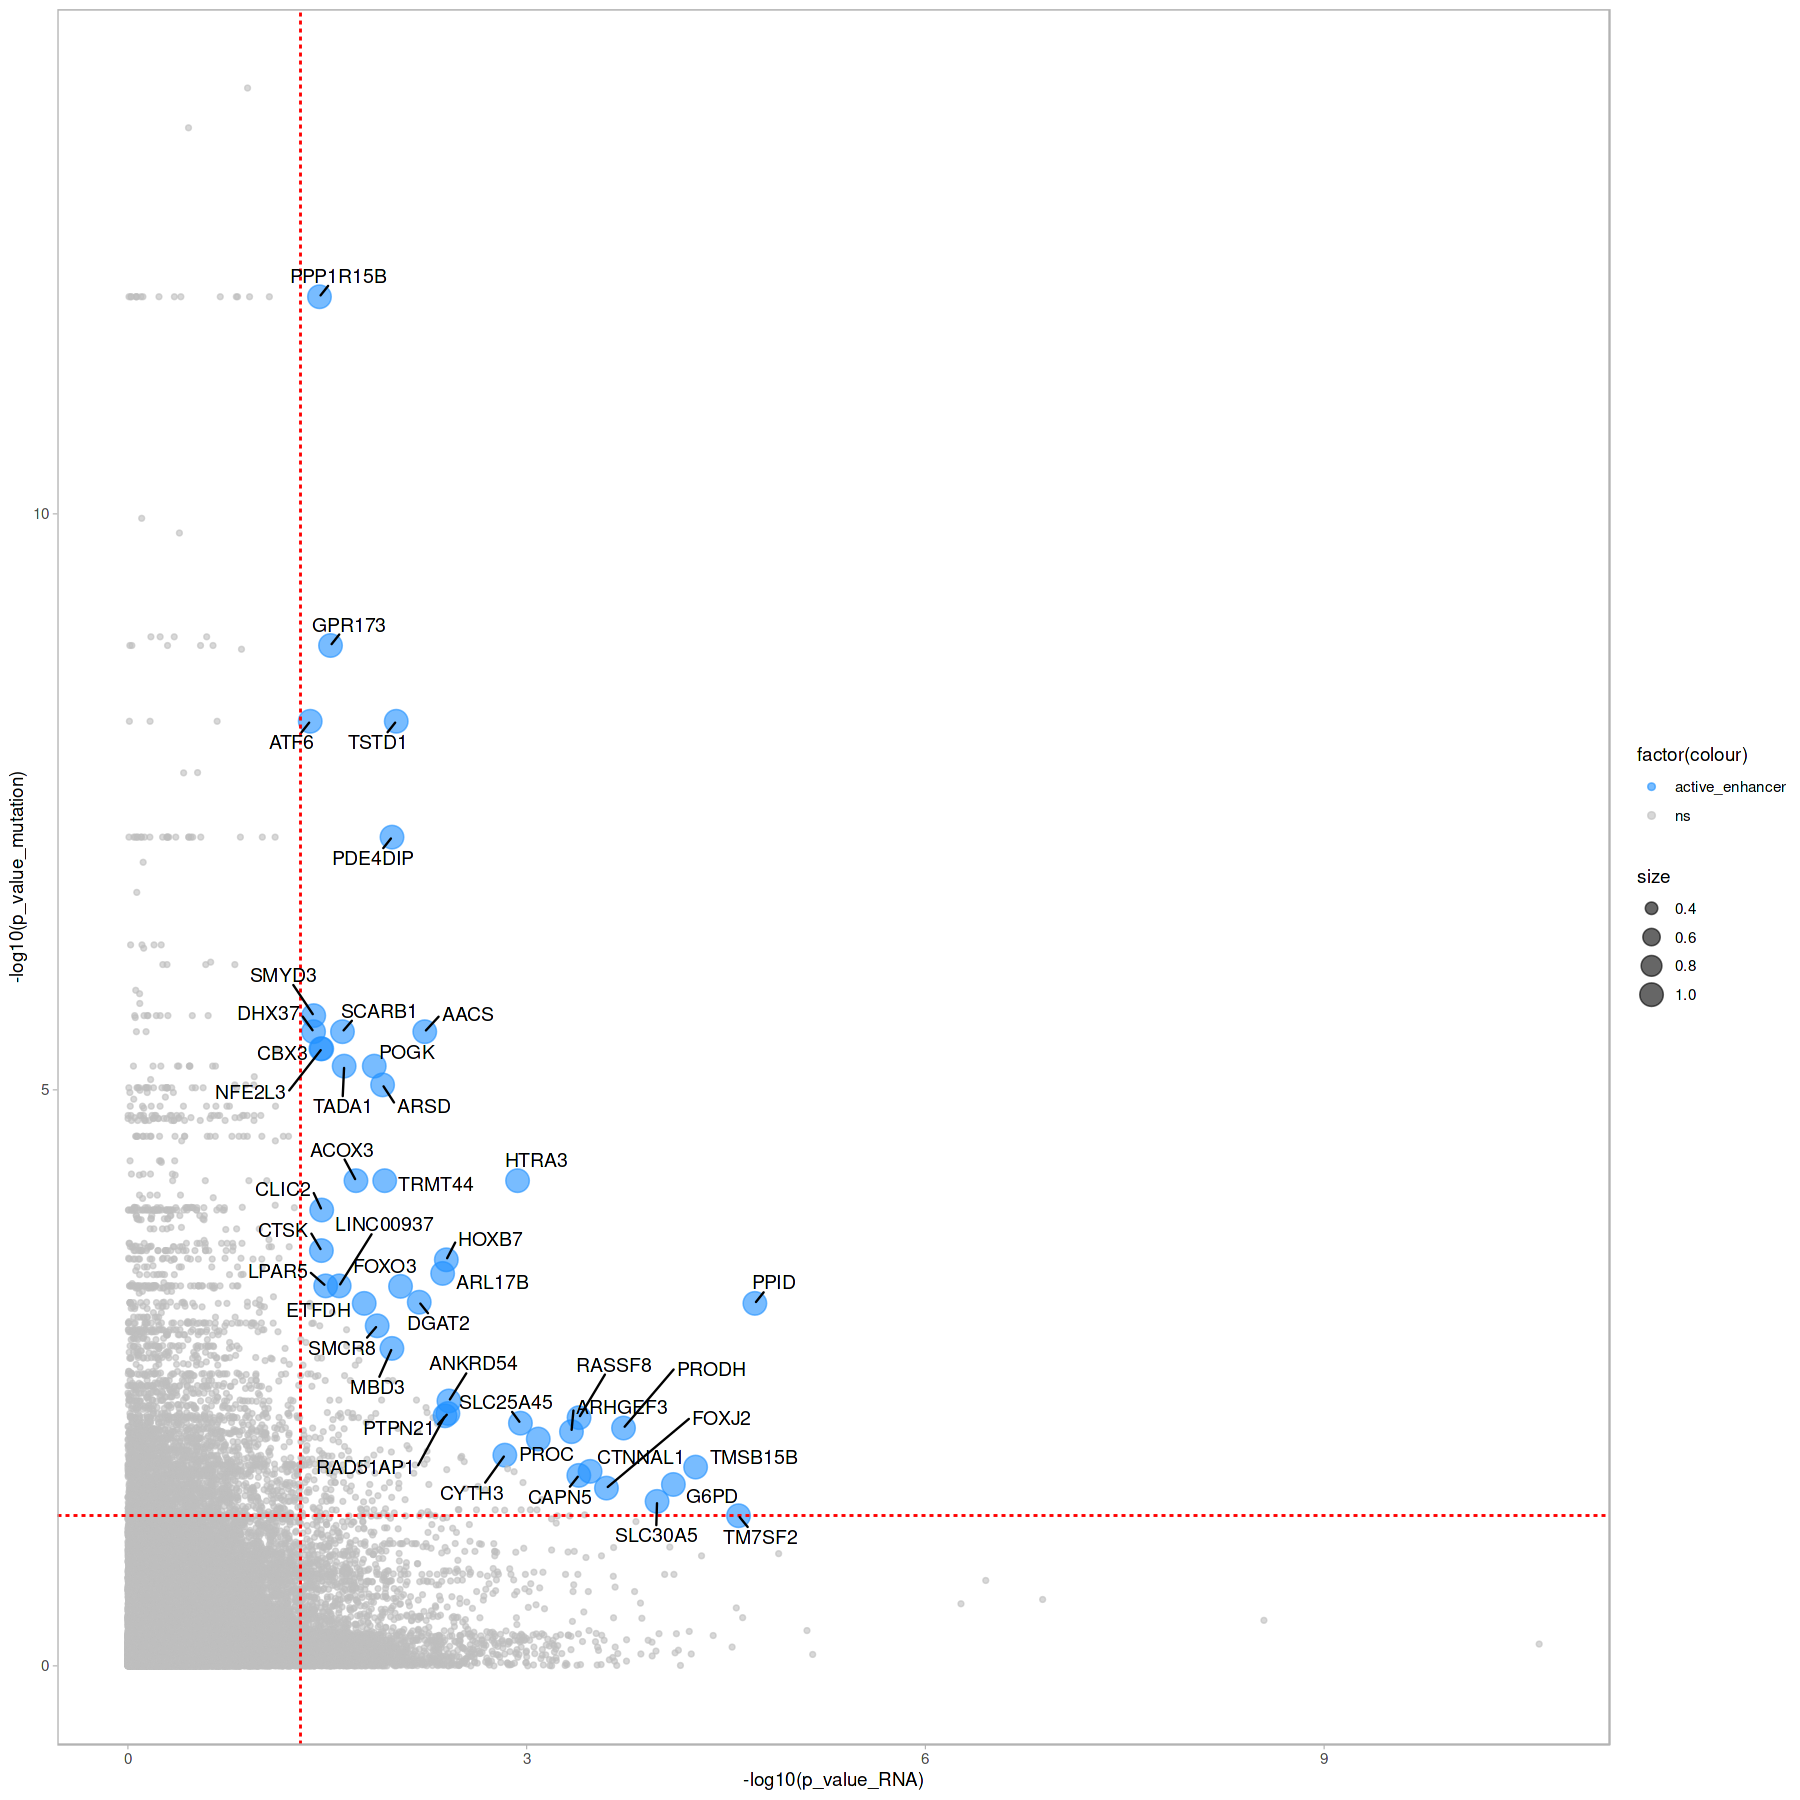

In [12]:
library(ggplot2)
library(ggrepel)

file = read.delim("/home/darragh/New/eQTL/TN_combined_with_GLM.txt", header = T)
#file$annotation = as.factor(file$annotation)
file$colour = NA
file$size = 1

file$colour[file$annotation == "super_enhancer"] <- "super_enhancer"
file$colour[file$annotation == "active_enhancer"] <- "active_enhancer"
file$colour[file$annotation == "active_promoter"] <- "active_promoter"
file$colour[file$annotation == "polycomb_promoter"] <- "polycomb_promoter"

file$colour[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- "ns"

file$size[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- 0.3


file_2 <- file[(file$q_value <= 0.05) & (file$p_value_RNA <= 0.05) & (file$p_value <= 0.05), ]

# genes_i_like = c(""  )
# file_2 <- file_2[file_2$gene %in% genes_i_like,]

options(repr.plot.width=15, repr.plot.height=15)

head(file)

ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "grey", "forestgreen", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) +geom_hline(yintercept=-log10(0.05),color="red", size=0.6,linetype="dashed") + geom_vline(xintercept=-log10(0.05),color="red", size=0.6,linetype="dashed") +
 geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black")

In [19]:
# repeat plot but for unique only

file = read.delim("/home/darragh/New/eQTL/TN_combined_with_GLM.txt", header = T)

TN_unique = read.delim("/home/darragh/New/Differentially_active/TN/output_fold1.txt", header = T)
TN_unique$id = paste(TN_unique$seqnames, TN_unique$start, TN_unique$end, sep="_")
TN_unique = TN_unique[,c("id", "Fold", "FDR")]
TN_unique$Fold = TN_unique$Fold*-1
TN_unique = TN_unique[TN_unique$Fold >1.5,]
TN_unique = TN_unique[TN_unique$FDR <0.05,]

file = merge(file, TN_unique)

file$colour = NA
file$size = 1

file$colour[file$annotation == "super_enhancer"] <- "super_enhancer"
file$colour[file$annotation == "active_enhancer"] <- "active_enhancer"
file$colour[file$annotation == "active_promoter"] <- "active_promoter"
file$colour[file$annotation == "polycomb_promoter"] <- "polycomb_promoter"

file$colour[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- "ns"

file$size[(file$q_value > 0.05) | (file$p_value_RNA > 0.05) | (file$p_value > 0.05) ] <- 0.3

file_2 <- file[(file$q_value <= 0.1) & (file$p_value_RNA <= 0.05) & (file$p_value <= 0.05), ]

head(file)

# options(repr.plot.width=15, repr.plot.height=15)

# head(file_2, 10L)

# # ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "grey", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) + coord_cartesian(xlim = c(-log10(0.05),5), ylim=c(-log10(0.05),3.5)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) 
# #  geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black") 

# ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(colour), size=size),alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "grey", "#AAFF00", "red")) + scale_shape_manual(values=c(5, 2, 8, 1)) + coord_cartesian(xlim = c(-log10(0.05),10), ylim=c(-log10(0.05),10)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank())  +
#  geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black")

id                     X     annotation      gene    p_value_RNA p_value  
1 chr1_14670918_14674206 28238 active_enhancer DNAJC16 0.38694204  0.4854127
2 chr1_14670918_14674206 28241 active_enhancer CASP9   0.86804722  0.4854127
3 chr1_14670918_14674206 28239 active_enhancer TMEM51  0.56096371  0.4854127
4 chr1_14670918_14674206 28235 active_enhancer KAZN    0.17426186  0.4854127
5 chr1_14670918_14674206 28236 active_enhancer PRDM2   0.06904729  0.4854127
6 chr1_14670918_14674206 28243 active_enhancer EFHD2   0.64791761  0.4854127
  combined_p q_value   Fold     FDR        colour size
1 0.4094300  1.0000000 3.581455 0.01737279 ns     0.3 
2 0.7776033  1.0000000 3.581455 0.01737279 ns     0.3 
3 0.5329225  1.0000000 3.581455 0.01737279 ns     0.3 
4 0.2454925  0.9675153 3.581455 0.01737279 ns     0.3 
5 0.1413112  0.8579048 3.581455 0.01737279 ns     0.3 
6 0.5958542  1.0000000 3.581455 0.01737279 ns     0.3

X id                        annotation      gene    p_value_RNA p_value    
1 0 chr1_172327419_172329936  active_enhancer PIGC    0.74483356  0.412629315
2 1 chr8_99305126_99307403    active_promoter NIPAL2  0.03370267  0.731994988
3 2 chr1_65430236_65432877    active_promoter JAK1    0.57045425  0.605424831
4 3 chr14_105258053_105263670 active_promoter ZBTB42  0.22367776  0.957541375
5 4 chr6_291359_293637        active_promoter DUSP22  0.06747904  0.001792004
6 5 chr9_74523799_74528061    active_promoter C9orf85 0.84257573  0.596378390
  combined_p   q_value  
1 0.6214847042 0.9017600
2 0.1960894385 0.7282833
3 0.6234762487 0.9021044
4 0.7520487295 0.9345280
5 0.0009149167 0.1029151
6 0.8114456108 0.9447498

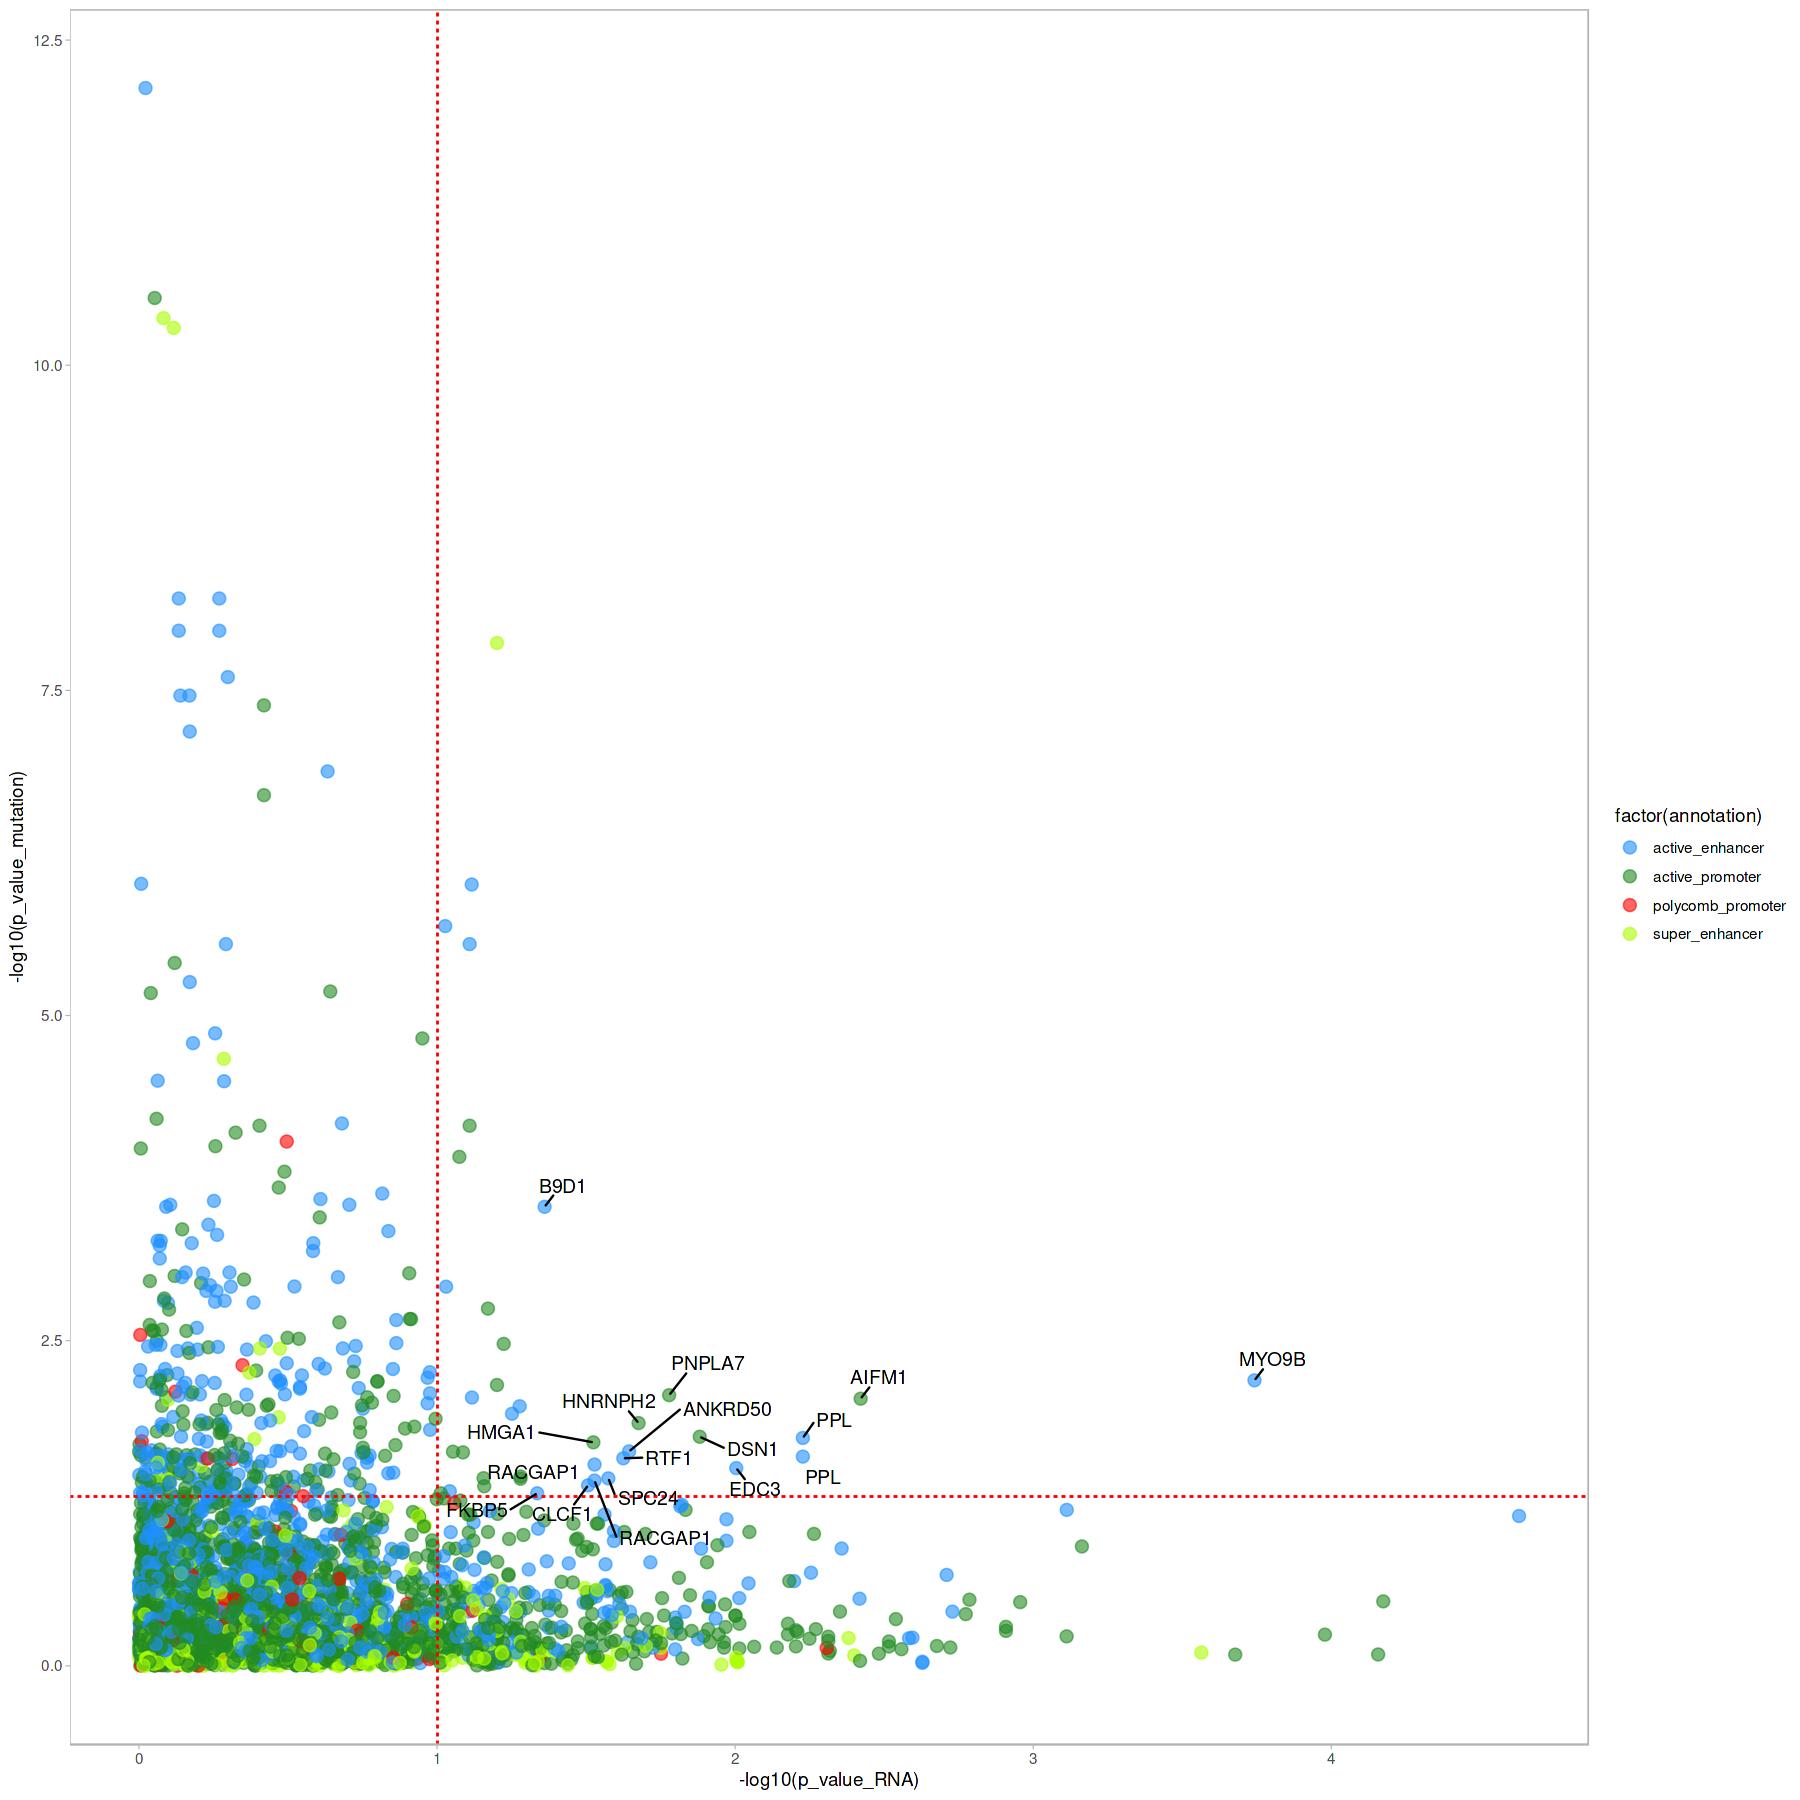

In [22]:
library(ggplot2)
library(ggrepel)

file = read.delim("/home/darragh/New/eQTL/ER_combined_with_GLM.txt", header = T)
#file$annotation = as.factor(file$annotation)

head(file)

file_2 <- file[file$p_value < 0.05 & file$p_value_RNA <0.05, ]

#genes_i_like = c(""  )
#file_2 <- file_2[file_2$gene %in% genes_i_like,]

options(repr.plot.width=15, repr.plot.height=15)

ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(annotation)),size=3,alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "red", "#AAFF00")) + scale_shape_manual(values=c(5, 2, 8, 1)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) +geom_hline(yintercept=-log10(0.05),color="red", size=0.6,linetype="dashed") + geom_vline(xintercept=-log10(0.1),color="red", size=0.6,linetype="dashed") +
 geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black")

X id                        annotation      gene     p_value_RNA p_value     
1 0 chr6_27470127_27471702    active_enhancer ZNF184   0.6517339   6.867549e-05
2 1 chr10_127778294_127781390 active_enhancer DHX32    0.9619047   1.000070e-01
3 2 chr15_85949597_85952551   active_enhancer AKAP13   0.8294519   5.520078e-01
4 3 chr19_797281_801652       active_promoter PTBP1    0.4534948   6.859153e-02
5 4 chr9_117616601_117621924  active_enhancer TNFSF8   0.9035372   4.958305e-01
6 5 chr5_33299749_33321631    super_enhancer  ADAMTS12 0.5525804   6.879682e-01
  combined_p  q_value  
1 0.007752897 0.2596843
2 0.635966464 0.8694909
3 0.778046077 0.9184705
4 0.128474159 0.5706058
5 0.819442824 0.9330018
6 0.670038833 0.8821157

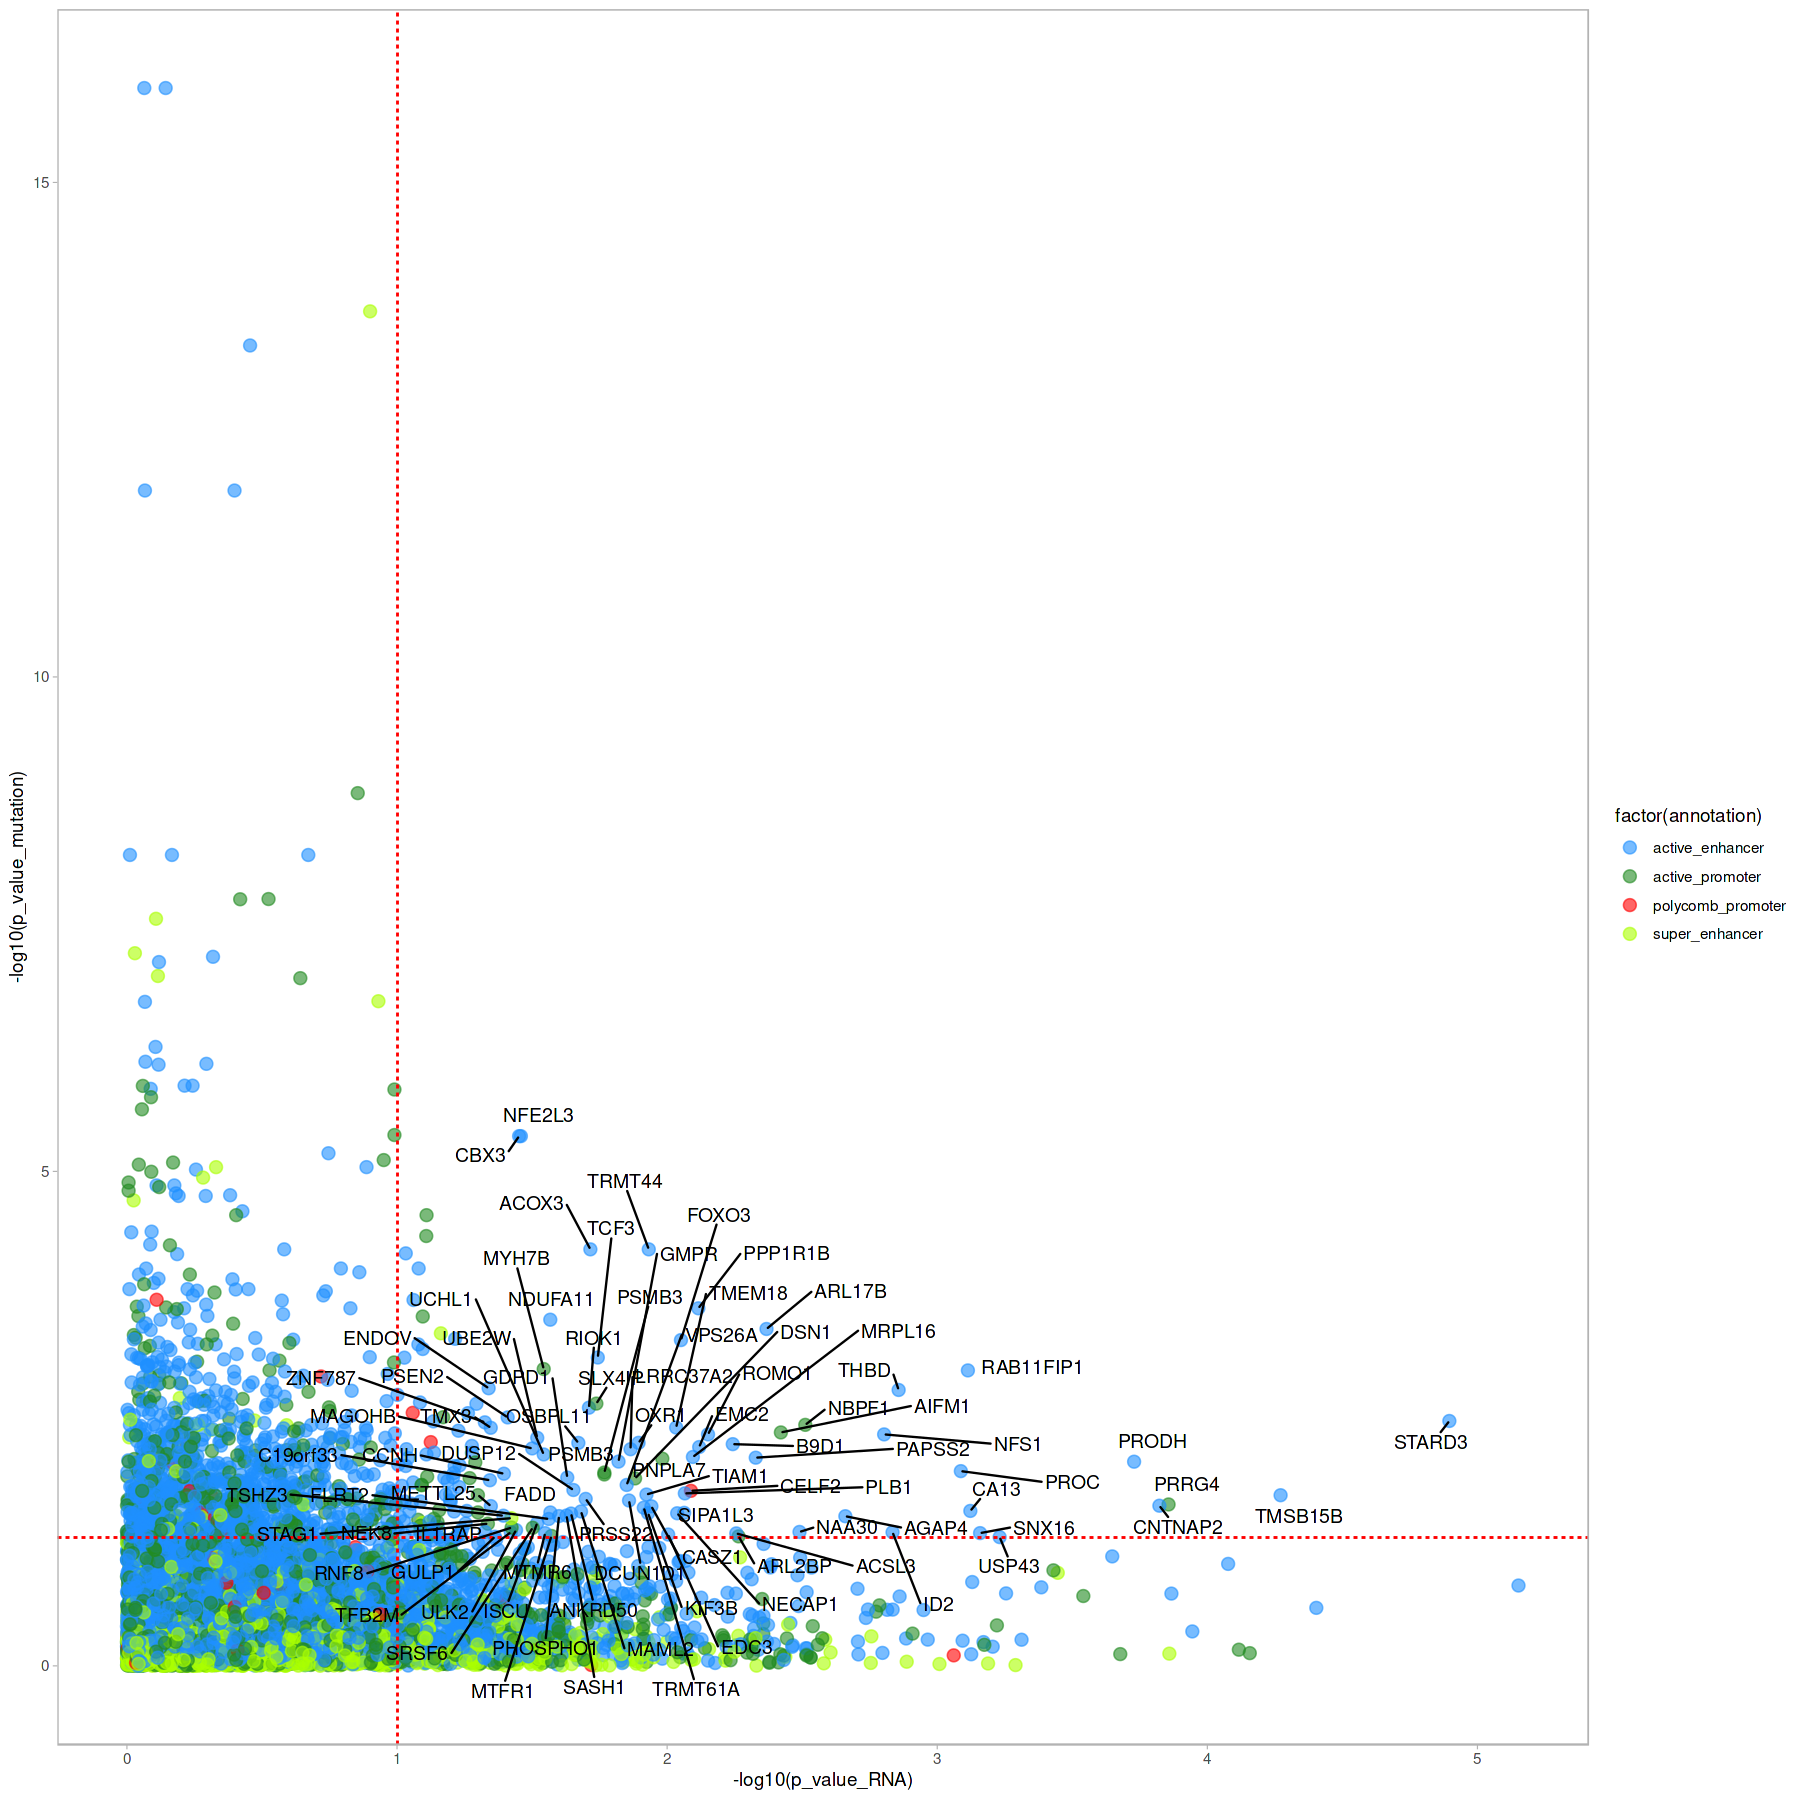

In [23]:
library(ggplot2)
library(ggrepel)

file = read.delim("/home/darragh/New/eQTL/TN_combined_with_GLM.txt", header = T)
#file$annotation = as.factor(file$annotation)

head(file)

file_2 <- file[file$p_value < 0.05 & file$p_value_RNA <0.05, ]

#genes_i_like = c(""  )
#file_2 <- file_2[file_2$gene %in% genes_i_like,]

options(repr.plot.width=15, repr.plot.height=15)


ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_jitter(aes(colour = factor(annotation)),size=3,alpha=0.6) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") + scale_colour_manual(values=c("dodgerblue", "forestgreen", "red", "#AAFF00")) + scale_shape_manual(values=c(5, 2, 8, 1)) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) +geom_hline(yintercept=-log10(0.05),color="red", size=0.6,linetype="dashed") + geom_vline(xintercept=-log10(0.1),color="red", size=0.6,linetype="dashed") +
 geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =4, box.padding = 0.5, max.overlaps = Inf, color="black")

In [50]:
file_3[file_3$gene == "VMP1", ]


X    id                                     gene p_value_RNA
4391 4390 chr17_57823651_57866551_super_enhancer VMP1 0.03814472 
     annotation     nSample p_value_GLM
4391 super_enhancer 28      0.005990085

In [49]:
file_3 <- file[file$p_value_GLM < 0.05 & file$p_value_RNA <0.05, ]
nrow(file_3)
unique(file_3$gene)

ZFP36L1, RRAGC, PTPN14, KLF5, VMP1, CIC


[1] 58

[1] "SSR2"       "GON4L"      "ARHGEF2"    "STK35"      "TCEAL7"    
 [6] "BHLHB9"     "ZFP36L1"    "RDH11"      "POGK"       "URI1"      
[11] "C19orf12"   "CEBPG"      "RTKN2"      "NRBF2"      "CDK1"      
[16] "ADO"        "TMEM164"    "SLC41A1"    "NACC1"      "ZNF830"    
[21] "LINC00958"  "CENPK"      "CENPH"      "RRAGC"      "IDS"       
[26] "PPP1R15B"   "GLS"        "FEZ2"       "HEATR5B"    "SCN1B"     
[31] "EIF4EBP3"   "MAK16"      "FOSB"       "PTPN14"     "BORA"      
[36] "KLF5"       "PSMB3"      "VMP1"       "RASSF8-AS1" "PA2G4P4"   
[41] "FAF1"       "TMPO"       "CD1D"       "LTBP1"      "STAB2"     
[46] "AMPD3"      "CIC"        "DOCK11"     "TSHZ2"      "CCDC82"    
[51] "POU3F2"     "HMGA1"      "ANP32B"     "IKZF2"      "HIVEP2"

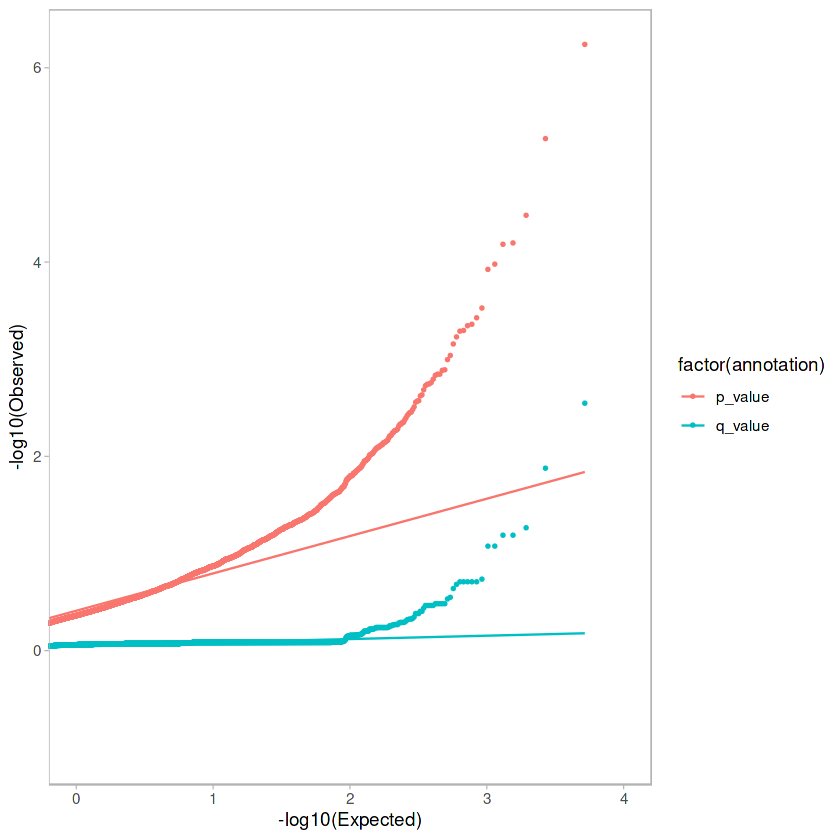

In [9]:
# Q-Q plot

library(ggplot2)

file = read.delim("/home/darragh/New/eQTL/Hartwig/TN/CADD_10/RNA_output.txt", header = T)

file_2 = file[,c("id","p_value_RNA")]
file_2$annotation = "p_value"
file_3 = file[,c("id","q_value_RNA")]
file_3$annotation = "q_value"
colnames(file_3) = c("id", "p_value_RNA", "annotation")
file_4 = rbind(file_2,file_3)


ggplot(file_4, aes(sample = -log10(p_value_RNA),colour = factor(annotation))) + stat_qq(size=0.5) + coord_cartesian(xlim = c(0,4) ) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) + xlab("-log10(Expected)") + ylab("-log10(Observed)") + stat_qq_line()



Loading required package: ggplot2

Warning message:
“Expected 6 pieces. Additional pieces discarded in 16961 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


[1] 0

[1] 0

[1] 0

[1] 0

Warning message in geom_text_repel(data = signif, aes(sample = -log10(p_value_RNA), :
“Ignoring unknown aesthetics: sample”


mapping: y = , sample = ~-log10(p_value_RNA), label = ~gene 
geom_text_repel: parse = FALSE, na.rm = FALSE, box.padding = 0.5, point.padding = 1e-06, min.segment.length = 0.5, arrow = NULL, force = 1, force_pull = 1, max.time = 0.5, max.iter = 10000, max.overlaps = Inf, nudge_x = 0, nudge_y = 0, xlim = c(NA, NA), ylim = c(NA, NA), direction = both, seed = NA, verbose = FALSE
stat_identity: na.rm = FALSE
position_identity 

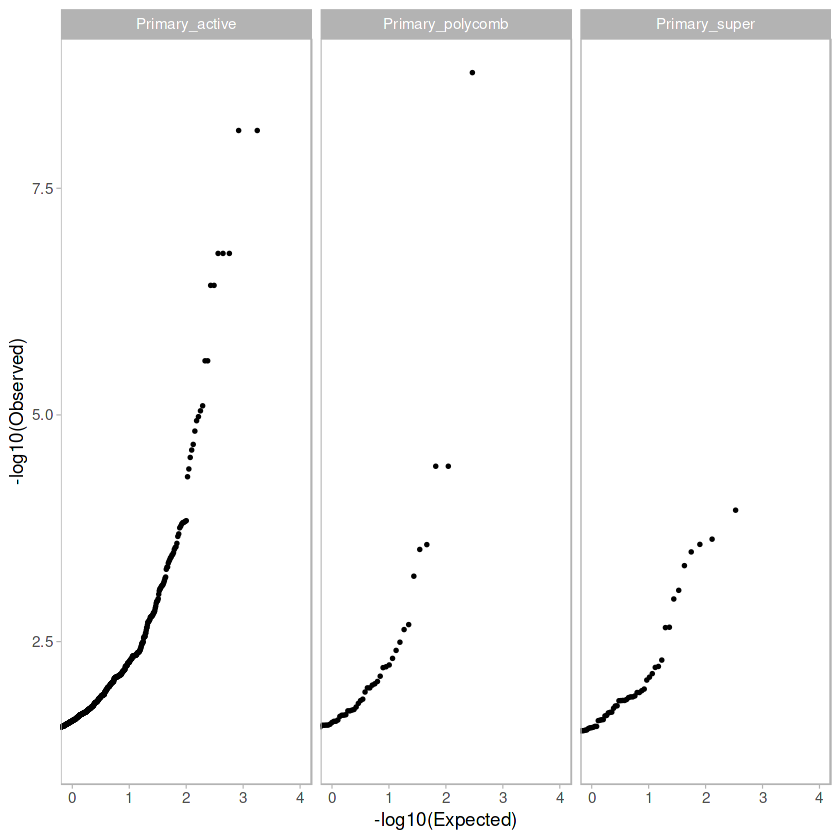

In [1]:
# Pie chart of significant results

library(tidyr)
library(ggrepel)

file = read.delim("/home/darragh/New/GLM_method/significant_RNA.hmec.hartwig.txt", header = T)
file = separate(data = file, col = id, into = c("chr", "start", "end", "id1", "id2", "gene"), sep = "_")
file$id = paste(file$id1, file$id2, sep="_")
file = file[,c("chr", "start", "end", "id", "p_value_RNA", "q_value_RNA", "gene")]
file = unique(file)
#file = file[file$p_value_RNA < 0.05,]

nrow(file[file$p_value < 0.05 & file$id == "active_promoter", ]) #51
nrow(file[file$p_value < 0.05 & file$id == "polycomb_promoter", ]) #13
nrow(file[file$p_value < 0.05 & file$id == "active_enhancer", ]) #88
nrow(file[file$p_value < 0.05 & file$id == "super_enhancer", ]) #277

signif = file[file$p_value < 0.05,]
write.table(signif, '/home/darragh/New/test.txt',row.names = F, col.names =F, sep = "\t", quote = FALSE)


ggplot(signif, aes(sample = -log10(p_value_RNA))) + stat_qq(size=0.5) + facet_wrap(~id) + coord_cartesian(xlim = c(0,4) ) +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) + xlab("-log10(Expected)") + ylab("-log10(Observed)") #+
 geom_text_repel(data =signif,  aes(sample = -log10(p_value_RNA), y="", label = gene), size =3, box.padding = 0.5, max.overlaps = Inf, color="red")


# df <- data.frame(value = c(51, 13, 88, 277),
#                  group = c("Active promoter", "Polycomb promoter", "Active enhancer","Super enhancer" ))

# ggplot(df, aes(x = "", y = value, fill = group)) +
#   geom_col() +
#   coord_polar(theta = "y") +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank())

#print(file[file$p_value < 0.05 & file$id > "polycomb_promoter", ])

#head(signif)

In [19]:
file = pybed.BedTool.from_dataframe(pd.read_table("/home/darragh/New/test.txt", header=None))
Hartwig = pybed.BedTool.from_dataframe(pd.read_table("/home/darragh/New/CADD/Hartwig/All_Hartwig_CADD_10.txt", header=0))

file = file.intersect(Hartwig, wa=True, wb=True)
file = pd.read_table(file.fn, header=None)
file = file.iloc[:,[0,1,2,3,4,5,6,12]]
file.columns = ["chr", "start", "end","id", "p_value", "q_value", "gene", "patient"]
file = file.drop_duplicates()
file = file.groupby(["chr", "start", "end","id", "p_value", "q_value", "gene"])["patient"].size().reset_index()
file.to_csv("/home/darragh/New/test.txt",sep = "\t" , header=True, index=False)
display(file)

/usr/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


chr      start        end               id   p_value   q_value  \
0    chr1    6531766    6557935   super_enhancer  0.006030  0.519043   
1    chr1    6531766    6557935   super_enhancer  0.035841  0.714406   
2    chr1   24603886   24638767   super_enhancer  0.015317  0.625457   
3    chr1   27721254   27810030   super_enhancer  0.036600  0.714406   
4    chr1   33219098   33267580   super_enhancer  0.006825  0.530849   
..    ...        ...        ...              ...       ...       ...   
424  chrX  106916176  106930209   super_enhancer  0.009506  0.585553   
425  chrX  109448172  109492737   super_enhancer  0.024630  0.684854   
426  chrX  149530858  149535881  active_enhancer  0.013043  0.625457   
427  chrX  149530858  149535881  active_enhancer  0.014274  0.625457   
428  chrX  149530858  149535881  active_enhancer  0.035090  0.714406   

         gene  patient  
0       PHF13       18  
1        ICMT       18  
2       GRHL3       15  
3       SYTL1       66  
4       BSDC1       41  
..        ...      ...  
424    TCEAL7       15  
425   TMEM164       28  
426     MTMR1       14  
427     VMA21       14  
428  TMEM185A       14  

[429 rows x 8 columns]

      chr     start       end              id      p_value   q_value    gene
12   chr1  36808026  36841371  super_enhancer 3.180675e-02 0.7144057   STK40
43   chr1 228133655 228136811 active_promoter 3.651216e-02 0.7144057   WNT9A
44   chr1 228133749 228136811 active_promoter 3.651216e-02 0.7144057   WNT9A
52  chr10  63656913  63665529 active_promoter 4.316539e-02 0.7162925  ARID5B
53  chr10  63657054  63665529 active_promoter 4.316539e-02 0.7162925  ARID5B
55  chr10  63778452  63855702  super_enhancer 7.254999e-03 0.5308494    CDK1
58  chr10  63778452  63855702  super_enhancer 4.155084e-02 0.7162925  ARID5B
189 chr17  37616938  37621378 active_promoter 5.413697e-05 0.1133989   CDK12
256  chr3   9987613   9989330 active_enhancer 2.734684e-04 0.1718476  MTMR14
272  chr3   9987742   9989330 active_enhancer 2.734684e-04 0.1718476  MTMR14
301  chr3  71099346  71126254  super_enhancer 3.017805e-02 0.7090087   FOXP1
302  chr3  71462397  71497758  super_enhancer 1.313321e-02 0.6254565   FOXP1

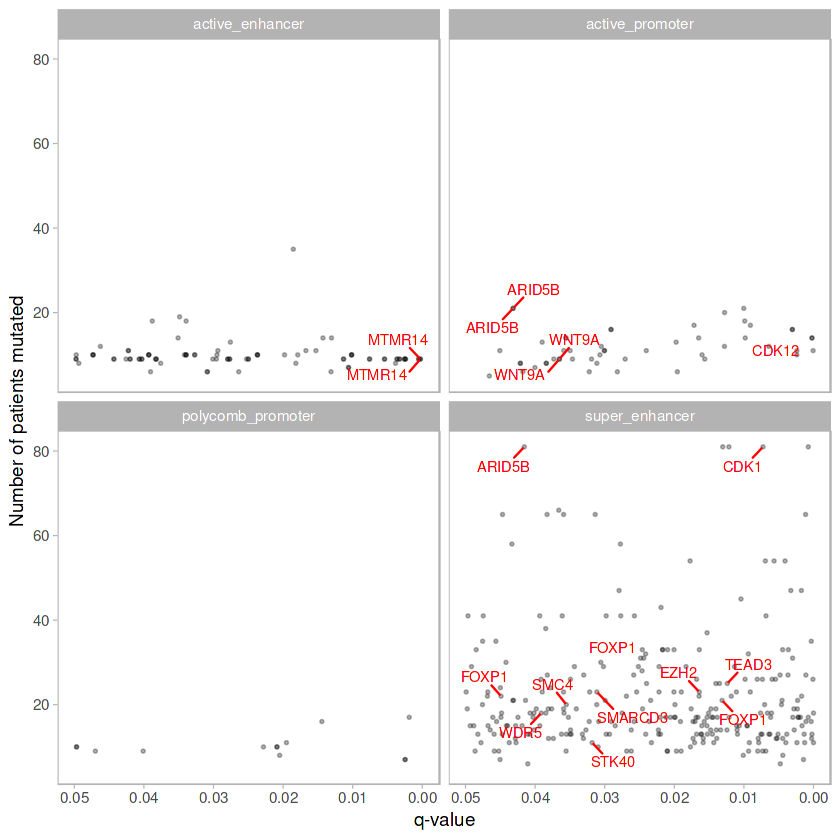

In [21]:
library(ggplot2)
library(ggrepel)

genes_i_like = c("STK40","WNT9A","ARID5B", "CDK1","CDK12","MTMR14","FOXP1", "SMC4","TEAD3", "EZH2", "SMARCD3", "WDR5")
file = read.delim("/home/darragh/New/test.txt", header = T)

#file_2 = file[file$id != "super_enhancer", ]
file_2 <- file[file$gene %in% genes_i_like,]

print(file_2)

ggplot(file, aes(x= p_value, y= patient))+ geom_point(size=0.5,alpha=0.3) + facet_wrap(~id)+ scale_x_reverse() + xlab("q-value") + ylab("Number of patients mutated") +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) +  
 geom_text_repel(data =file_2,  aes(x= p_value, y= patient, label = gene), size =3, box.padding = 0.5, max.overlaps = Inf, color="red")


In [18]:
import pandas as pd

file = pd.read_table("/home/darragh/New/GLM_method/significant_RNA.hmec.hartwig.txt", header = 0)
file[['i','ii','iii','iv','v','vi','vii', 'viii']] = file['id'].str.split("_", expand=True)
file['id'] = file['i'] + '_' + file['ii'] + '_' + file['iii'] + '_' + file['iv'] + '_' + file['v'] 
file = file[['id', 'p_value_RNA', 'vi']]
file.columns = ['id', 'p_value_RNA', 'gene']

file_2 = pd.read_table("/home/darragh/New/GLM_method/mutation.primary.hartwig.txt", header = 0)
file_2 = file_2[['id', 'nSample','p_value', "q_value"]]

file = file.merge(file_2, on="id")

file.to_csv("/home/darragh/New/test.txt",sep = "\t" , header=True, index=False)

display(file)



id  p_value_RNA     gene  \
0         chr19_44178131_44207489_super_enhancer     0.396978   ZNF283   
1         chr19_44178131_44207489_super_enhancer     0.909605    PLAUR   
2         chr19_44178131_44207489_super_enhancer     0.962309     IRGQ   
3         chr19_44178131_44207489_super_enhancer     0.978576   ZNF576   
4         chr19_44178131_44207489_super_enhancer     0.716886    CADM4   
...                                          ...          ...      ...   
6138    chr1_200707261_200711968_active_promoter     0.863990  CAMSAP2   
6139       chr5_73583869_73639922_super_enhancer     0.867657     ENC1   
6140    chr1_150205765_150209295_active_promoter     0.057617   ANP32E   
6141  chr2_176971158_176974182_polycomb_promoter     0.382518   HOXD10   
6142    chr9_77111589_77113861_polycomb_promoter     0.874221     RORB   

      nSample   p_value   q_value  
0           7  0.936962  0.997328  
1           7  0.936962  0.997328  
2           7  0.936962  0.997328  
3           7  0.936962  0.997328  
4           7  0.936962  0.997328  
...       ...       ...       ...  
6138       10  0.049711  0.452332  
6139       10  0.998691  1.000000  
6140       19  0.000002  0.000197  
6141        9  0.976848  1.000000  
6142        2  0.936666  0.999993  

[6143 rows x 6 columns]

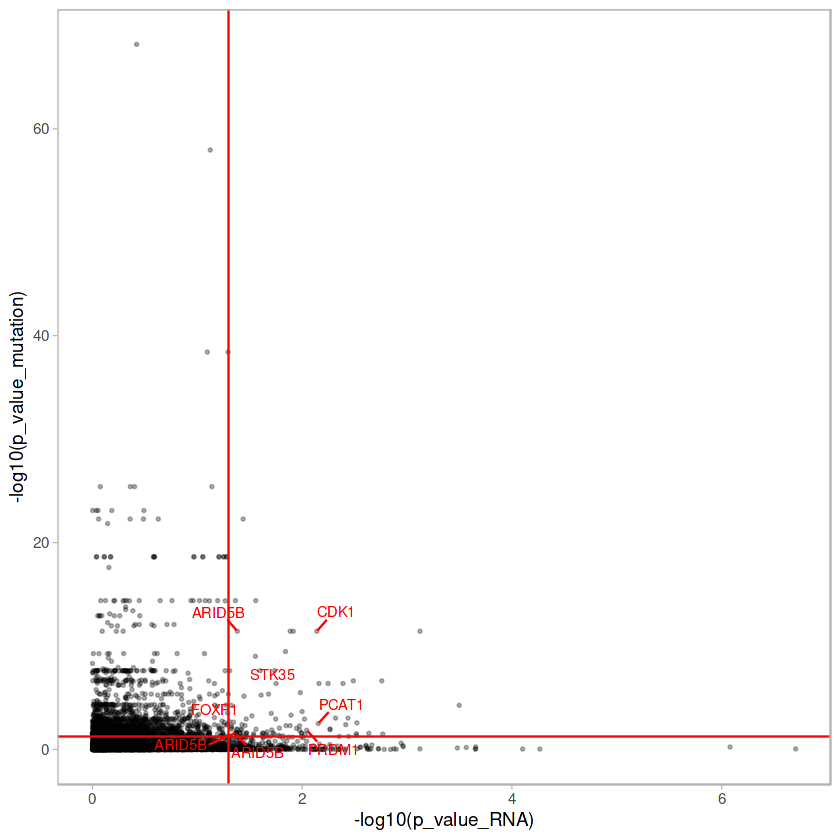

In [23]:
library(ggplot2)
library(ggrepel)

file = read.delim("/home/darragh/New/test.txt", header = T)

file_2 = file[file$id != "super_enhancer", ]
file_2 <- file[file$p_value < 0.05 & file$p_value_RNA <0.05, ]

genes_i_like = c("STK40","WNT9A","ARID5B", "CDK1","CDK12","MTMR14","FOXP1", "SMC4","TEAD3", "EZH2", "SMARCD3", "WDR5", "STK35", "PRDM1", "PCAT1")
file_2 <- file_2[file_2$gene %in% genes_i_like,]

#print(file_2)

ggplot(file, aes(x= -log10(p_value_RNA), y= -log10(p_value)))+ geom_point(size=0.5,alpha=0.3) + xlab("-log10(p_value_RNA)") + ylab("-log10(p_value_mutation)") +theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank()) +geom_hline(yintercept=-log10(0.05),color="red") + geom_vline(xintercept=-log10(0.05),color="red") +
 geom_text_repel(data =file_2,  aes(x= -log10(p_value_RNA), y= -log10(p_value), label = gene), size =3, box.padding = 0.5, max.overlaps = Inf, color="red")

In [ ]:
# All positively selected for
pd.set_option("display.max_rows", 100)

chr1 = pd.read_table("/home/darragh/test.txt", header=0)
chr2 = pd.read_table("/home/darragh/test_2.txt", header=0)
chr3 = pd.read_table("/home/darragh/test_3.txt", header=0)
chr4 = pd.read_table("/home/darragh/test_4.txt", header=0)
chr5 = pd.read_table("/home/darragh/test_5.txt", header=0)
chr6 = pd.read_table("/home/darragh/test_6.txt", header=0)
chr7 = pd.read_table("/home/darragh/test_7.txt", header=0)
chr8 = pd.read_table("/home/darragh/test_8.txt", header=0)
chr9 = pd.read_table("/home/darragh/test_9.txt", header=0)
chr10 = pd.read_table("/home/darragh/test_10.txt", header=0)
chr11= pd.read_table("/home/darragh/test_11.txt", header=0)
chr12 = pd.read_table("/home/darragh/test_12.txt", header=0)
chr13 = pd.read_table("/home/darragh/test_13.txt", header=0)
chr14 = pd.read_table("/home/darragh/test_14.txt", header=0)
chr15 = pd.read_table("/home/darragh/test_15.txt", header=0)
chr16 = pd.read_table("/home/darragh/test_16.txt", header=0)
chr17 = pd.read_table("/home/darragh/test_17.txt", header=0)
chr18 = pd.read_table("/home/darragh/test_18.txt", header=0)
chr19 = pd.read_table("/home/darragh/test_19.txt", header=0)
chr20 = pd.read_table("/home/darragh/test_20.txt", header=0)
chr21 = pd.read_table("/home/darragh/test_21.txt", header=0)
chr22 = pd.read_table("/home/darragh/test_22.txt", header=0)
chrX = pd.read_table("/home/darragh/test_X.txt", header=0)

All_positively_selected_genes = pd.concat([chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrX], axis=0)
Both = All_positively_selected_genes.merge(signif_df, on="gene")
display(Both)

In [17]:
signif_2 = []
for file in signif:
    pandas = pd.read_table(file)

    if sum(pandas['mutated']) > 4:
        signif_2.append(file)

        print(file)

/home/darragh/New/RNA_model/matrixes/HMEC/WDR5_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/RPL27A_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/IRF2BP1_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/GLB1L2_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/CBLB_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/ACACA_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/SPRR1B_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/SPRR2D_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/CNOT6_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/GRB2_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/HOXB6_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/RASA1_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/CDK12_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/IL11RA_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/RTN4IP1_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/APEX2_matrix.txt
/home/darragh/New/RNA_model/matrixes/HMEC/YAP1_mat

In [151]:
print(len(signif_2))

362


# Perfrom Poisson regression for the expression every gene 

In [ ]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

signif = []
dir = glob.glob('/home/darragh/New/RNA_model/matrixes/HMEC/*_matrix.txt')

for file in dir:
    pandas = pd.read_table(file)
    res = pandas.groupby(["id","mutated"])["RNA"].quantile([0.95])#[-1]#.unstack(level=1)
    

    display(res)

   
    # m01 = ols('RNA ~ CNA', data=pandas).fit()
    # m02 = ols('RNA ~ CNA + mutated', data=pandas).fit()
    
    # anovaResults = anova_lm(m01, m02)
    
    # if anovaResults['Pr(>F)'][1] < 0.05:
    #     signif.append(file)
    #     print(file)






In [6]:
print(len(signif))

94


In [71]:
library(glmnet)

identify_eQTL <- function(file) {
    gene_df = read.delim(file, header = TRUE)
    
    x_1 = as.data.frame(gene_df[,c("CNA")])

    #rownames(x_1) <- gene_df$patient
    
    x_2 = gene_df[,c("CNA","mutated")]
    
    #rownames(x_2) <- gene_df$patient
    
    y = as.data.frame(gene_df[,c("RNA")])
    #rownames(y) <- gene_df$patient
    # x_1 = as.matrix(x_1)
    # x_2 = as.matrix(x_2)
    y = as.matrix(y)

    fit0 = lm(y~.,data = x_1)
    # x_factors_L1 = x[,factors_L1]

    # df = data.frame(x_factors_L1,y)
    fit1 = lm(y~.,data = x_2)

    anova(fit0,fit1)$"Pr(>F)"[2]

    }

files = Sys.glob("/home/darragh/New/RNA_model/matrixes/HMEC/*.txt", dirmark = FALSE)

for (file in files){
    gene_df = read.delim(file, header = TRUE)
    if( sum(gene_df$mutated) > 10){
        
        if(identify_eQTL(file) < 0.05){
         print(file)
         print(identify_eQTL(file))
     }
    
}
}


#print(anova(fit0,fit1))

# [1] "/home/darragh/New/RNA_model/matrixes/HMEC/BCL7B_matrix.txt"
# [1] 6.114599e-05
# [1] "/home/darragh/New/RNA_model/matrixes/HMEC/HEY1_matrix.txt"
# [1] 2.691137e-05
# [1] "/home/darragh/New/RNA_model/matrixes/HMEC/KDM5C_matrix.txt"
# [1] 0.0003355206


[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ACTB_matrix.txt"
[1] 0.01014955
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ADAMTS1_matrix.txt"
[1] 0.02396635
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/AIFM1_matrix.txt"
[1] 5.39858e-07
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ALDH9A1_matrix.txt"
[1] 0.03741084
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/AMOTL2_matrix.txt"
[1] 0.01419072
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ANKIB1_matrix.txt"
[1] 0.03596174
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ARHGDIA_matrix.txt"
[1] 1.397693e-06
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ARHGEF2_matrix.txt"
[1] 0.001895936
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ARID3B_matrix.txt"
[1] 0.04123113
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ARID5B_matrix.txt"
[1] 0.01103024
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ATG13_matrix.txt"
[1] 0.04350047
[1] "/home/darragh/New/RNA_model/matrixes/HMEC/ATG5_matrix.txt"
[1] 0.0161182
[1] "/home/darragh/New/RNA_

index id                                              gene  patient        
1 24180 chr16_23606161_23608098_Primary_active_promoter PALB2 DRUP01330020T  
2 24181 chr16_23606161_23608098_Primary_active_promoter PALB2 CPCT02020369T  
3 24182 chr16_23606161_23608098_Primary_active_promoter PALB2 CPCT02020385T  
4 24183 chr16_23606161_23608098_Primary_active_promoter PALB2 CPCT02330076T  
5     0 chr16_23606161_23608098_Primary_active_promoter PALB2 CPCT02080001TII
6     1 chr16_23606161_23608098_Primary_active_promoter PALB2 CPCT02100048T  
  mutated RNA   CNA   
1 1       13.27 5.1089
2 1        0.00 3.0388
3 1        0.00 3.0215
4 1        0.00 7.9052
5 0        6.57 3.6937
6 0        8.53 4.0826

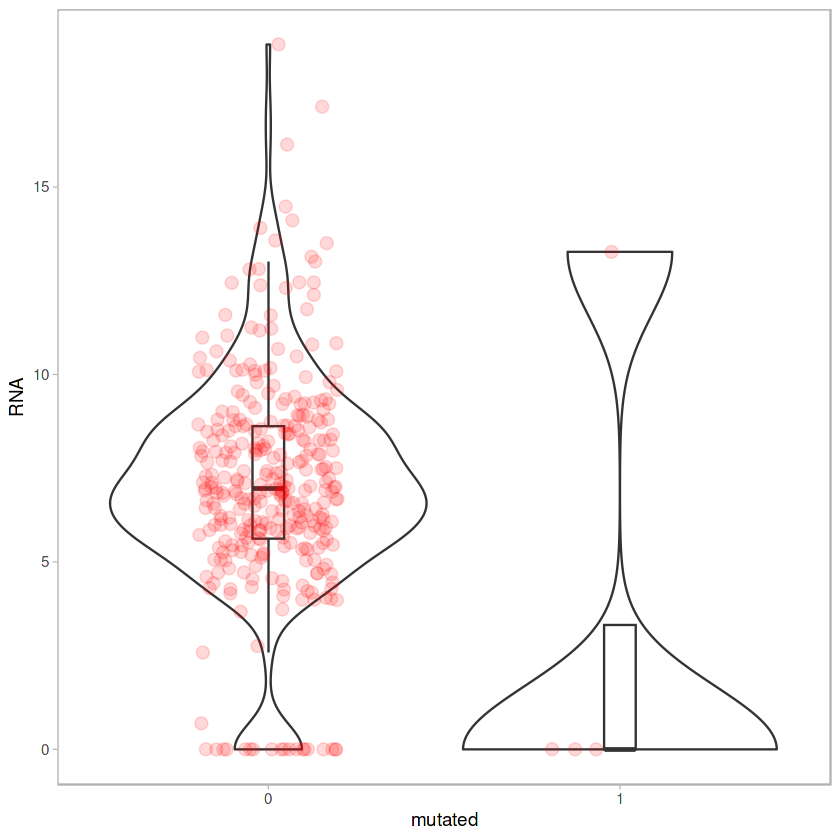

In [31]:
library(ggplot2)

file = read.delim("/home/darragh/New/eQTL/Hartwig/Primary/CADD_10/matrixes/chr16_23606161_23608098_Primary_active_promoter_PALB2__matrix.txt", header = TRUE)
head(file)

file$mutated = as.character(file$mutated)

ggplot(file, aes(x=mutated, y=RNA)) + geom_violin() + geom_boxplot(width=.09,outlier.shape = NA) + geom_jitter(size=3, colour="red", alpha = 0.15,width=0.2) + theme_light() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank())
